In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal

import glob
import pickle

from utils import *

In [2]:
# Prepare object points
nx = 9 # Number of inside corners in any given row
ny = 6 # Number of inside corners in any given column

# Read in and make a list of calibration images

# glob allows us to read in files with consistent file names
# e.g. calibration-1.jpg, calibration-2.jpg...
images = glob.glob("camera_cal/calibration*.jpg")

# Initialise image and object point arrays
objpoints = []
imgpoints = []

# Generate object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

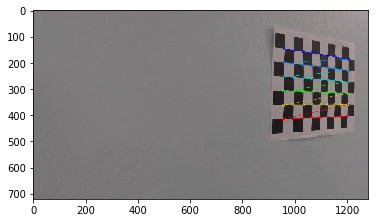

In [3]:
for image in images:

    # Read in image
    img = cv2.imread(image)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    # Parameters: (image, chessboard dims, param for any flags)
    # chessboard dims = inside corners, not squares.
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Fill image point and object point arrays
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

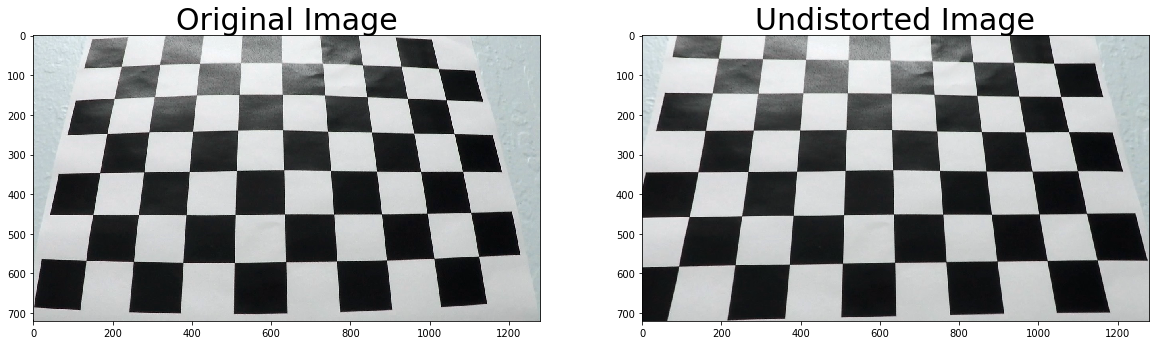

In [4]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [5]:
# Save the camera calibration result.
save = {
    "mtx" : mtx,
    "dist" : dist   
}

pickle.dump( save, open( "camera_calibration.p", "wb" ) )

Pipeline (single images)
1. Has the distortion correction been correctly applied to each image?

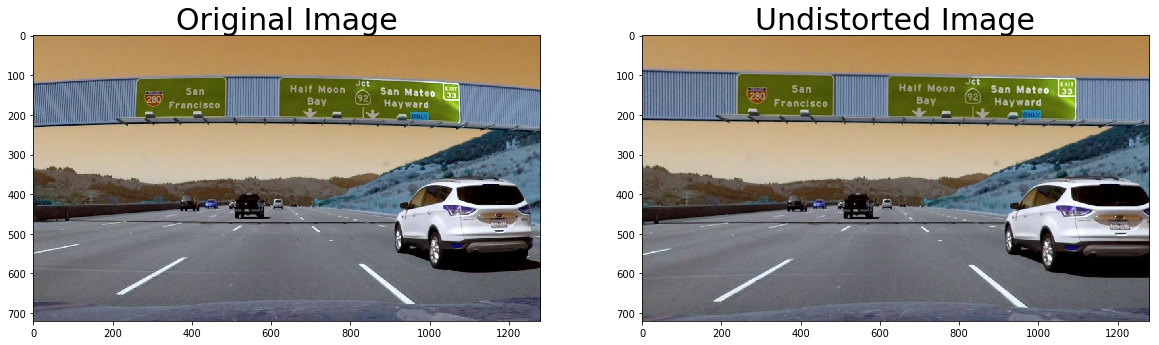

In [6]:
raw = cv2.imread("test_images/signs_vehicles_xygrad.png")

image = cv2.undistort(raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

2. Has a binary image been created using color transforms, gradients or other methods?

In [7]:
# Parameters
imshape = raw.shape

height = raw.shape[0]
offset = 50
offset_height = height - offset
half_frame = raw.shape[1] // 2
steps = 6
pixels_per_step = offset_height / steps
window_radius = 200
medianfilt_kernel_size = 51
horizontal_offset = 40

blank_canvas = np.zeros((720, 1280))
colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

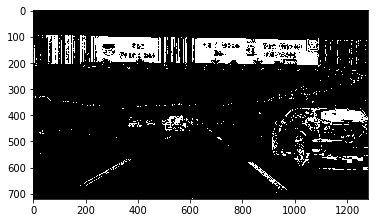

In [8]:
#s_thresh=(150, 255)
#sx_thresh=(40, 100)

s_thresh=(170, 255)
sx_thresh=(40, 100)

combined_binary = pipeline(image, s_thresh=s_thresh, sx_thresh=sx_thresh)
plt.imshow(combined_binary, cmap="gray")

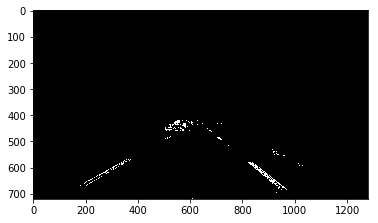

In [9]:
vertices = np.array([[(0,imshape[0]),(550, 420), (700, 420), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(combined_binary, vertices)
plt.imshow(masked_image, cmap="gray")

In [10]:
"""
src = np.float32(
    [[120, 720],
     [550, 470],
     [700, 470],
     [1160, 720]])

dst = np.float32(
    [[150,720],
     [150,0],
     [1130,0],
     [1130,720]])

"""
src = np.float32([
    [120, image.shape[0]],
    [image.shape[1]/2 - 90, image.shape[0]-image.shape[0]/2+110],
    [image.shape[1]/2 + 60, image.shape[0]-image.shape[0]/2+110],
    [image.shape[1] - 120, image.shape[0]]
    ])
   
dst = np.float32([
    [150,image.shape[0]],
     [150,0],
     [image.shape[1] - 150,0],
     [image.shape[1] - 150,image.shape[0]]
    ])    
    
print(image.shape)
print(image.shape[0])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

print(src)
print(dst)

(720, 1280, 3)
720
[[  120.   720.]
 [  550.   470.]
 [  700.   470.]
 [ 1160.   720.]]
[[  150.   720.]
 [  150.     0.]
 [ 1130.     0.]
 [ 1130.   720.]]


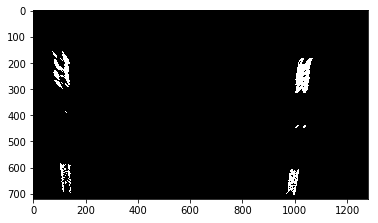

In [11]:
# Warp onto birds-eye-view
# Previous region-of-interest mask's function is absorbed by the warp
warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap="gray")

Have lane line pixels been identified in the rectified image and fit with a polynomial?

In [12]:
# Histogram and get pixels in window

leftx, lefty, rightx, righty, histogram = histogram_pixels(warped, horizontal_offset=horizontal_offset, steps=6,window_radius=200)

print(len(histogram))

6


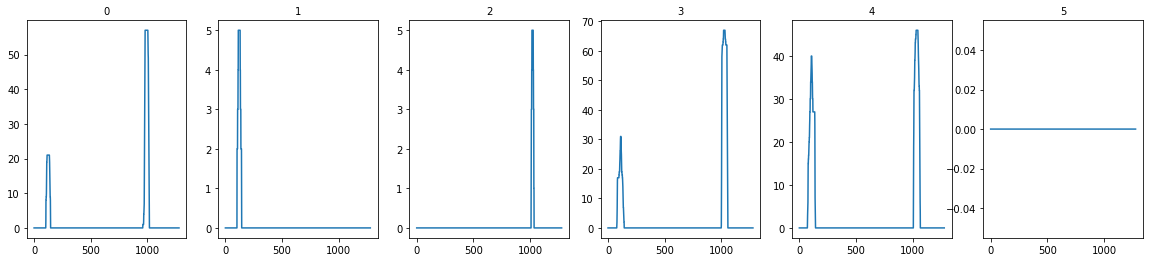

In [13]:
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20,4))
#ax1.imshow(raw)
ax1.plot(histogram[0])
ax1.set_title('0', fontsize=10)
#ax2.imshow(image)
ax2.plot(histogram[1])
ax2.set_title('1', fontsize=10)

ax3.plot(histogram[2])
ax3.set_title('2', fontsize=10)

ax4.plot(histogram[3])
ax4.set_title('3', fontsize=10)

ax5.plot(histogram[4])
ax5.set_title('4', fontsize=10)

ax6.plot(histogram[5])
ax6.set_title('5', fontsize=10)

In [14]:
left_peaks = np.array(signal.find_peaks_cwt(histogram[0][:600], np.arange(1, 10)))
print(left_peaks)
left_peaks2 = np.array(signal.find_peaks_cwt(histogram[5][:600], np.arange(1, 10)))
print(left_peaks2)
left_peaks3 = np.array(signal.find_peaks_cwt(histogram[0][:600], np.arange(10, 50)))
print(left_peaks3)
left_peaks4 = np.array(signal.find_peaks_cwt(histogram[4][:600], np.arange(1, 10)))
print(left_peaks4)

[115 136]
[]
[125]
[ 81 135]


In [15]:
print(type(np.arange(1,10)))

<class 'numpy.ndarray'>


In [16]:
def get_pixel_in_window_test(img, x_center, y_center, size):
    """
    returns selected pixels inside a window.
    :param img: binary image
    :param x_center: x coordinate of the window center
    :param y_center: y coordinate of the window center
    :param size: size of the window in pixel
    :return: x, y of detected pixels
    
    :size, window_radius=200
    
    """
      
    half_size = size // 2
    
    print(int(y_center - half_size))
    print(int(y_center + half_size))
    print(int(x_center - half_size))
    print(int(x_center + half_size))
    
    window = img[int(y_center - half_size):int(y_center + half_size), int(x_center - half_size):int(x_center + half_size)]

#    x, y = (window.T == 1).nonzero()
    
    x, y = window.nonzero()

    x = x + x_center - half_size
    y = y + y_center - half_size

    return x, y, window

def get_pixel_in_window_test2(img, x_center, y_center, size):
    """
    returns selected pixels inside a window.
    :param img: binary image
    :param x_center: x coordinate of the window center
    :param y_center: y coordinate of the window center
    :param size: size of the window in pixel
    :return: x, y of detected pixels
    
    :size, window_radius=200
    
    """
      
    half_size = size // 2
    
    print(int(y_center - half_size))
    print(int(y_center + half_size))
    print(int(x_center - half_size))
    print(int(x_center + half_size))
    
    window = img[int(y_center - half_size):int(y_center + half_size), int(x_center - half_size):int(x_center + half_size)]

    x, y = (window.T == 1).nonzero()
    
#    x, y = window.nonzero()

    print("original x %s" % x)
    print("original y %s" % y)

    x = x + x_center - half_size
    y = y + y_center - half_size
    
    print("x %s" % x)
    print("y %s" % y)

    return x, y, window

500
700
90
290
500
700
90
290
original x [13 13 13 ..., 55 55 55]
original y [ 84  86  88 ..., 146 166 195]
x [103 103 103 ..., 145 145 145]
y [584 586 588 ..., 646 666 695]


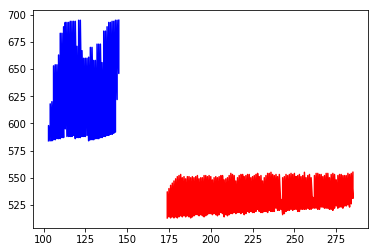

In [17]:
x, y, window = get_pixel_in_window_test(warped, 190,600, 200)
plt.plot(x,y,'r')

x, y, window = get_pixel_in_window_test2(warped, 190,600, 200)
plt.plot(x,y,'b')

In [18]:
print(leftx)

[103 103 103 ..., 141 142 142]


left_fit: [ 121.54484192  121.61067896  121.67657933 ...,  112.13389966  112.10589802
  112.13389966]
left_fit: 9577
Left coeffs: [  7.91766626e-06   2.36548485e-02   1.05030043e+02]
righty[0]: , 708.0 , rightx[0]:  935
Right coeffs:  [  1.04319381e-05  -1.04777246e-01   1.05674898e+03]


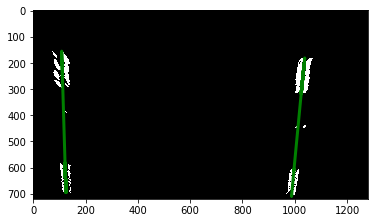

In [19]:
# Fit a second order polynomial to each fake lane line
left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
print("left_fit:", left_fit)
print("left_fit:", len(left_fit))


print("Left coeffs:", left_coeffs)
print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)
print("Right coeffs: ", right_coeffs)

# Plot data

plt.plot(left_fit, lefty, color='green', linewidth=3)
plt.plot(right_fit, righty, color='green', linewidth=3)
plt.imshow(warped, cmap="gray")

In [20]:
def lane_poly_test(yval, poly_coeffs):
    """Returns x value for poly given a y-value.
    Note here x = Ay^2 + By + C."""
    
    print("lane_poly is called")
    
    return poly_coeffs[0]*yval**2 + poly_coeffs[1]*yval + poly_coeffs[2]

def draw_poly_test(img, poly, poly_coeffs, steps, color=[255, 0, 0], thickness=10, dashed=False):
    img_height = img.shape[0]
    pixels_per_step = img_height // steps

    for i in range(steps):
        start = i * pixels_per_step
        end = start + pixels_per_step

        start_point = (int(poly(start, poly_coeffs=poly_coeffs)), start)
        end_point = (int(poly(end, poly_coeffs=poly_coeffs)), end)

        if dashed == False or i % 2 == 1:
            img = cv2.line(img, end_point, start_point, color, thickness)

    return img

Left coeffs:  [  7.91766626e-06   2.36548485e-02   1.05030043e+02]
Right fit:  [  1.04319381e-05  -1.04777246e-01   1.05674898e+03]
(720, 1280)


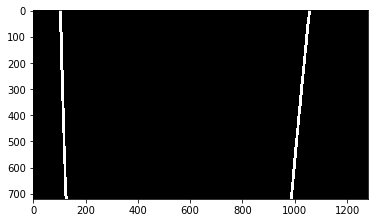

In [21]:
print("Left coeffs: ", left_coeffs)
print("Right fit: ", right_coeffs)
polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
plt.imshow(polyfit_drawn, cmap="gray")
print(polyfit_drawn.shape)

In [22]:
def evaluate_poly_test(indep, poly_coeffs):
    return poly_coeffs[0]*indep**2 + poly_coeffs[1]*indep + poly_coeffs[2]

In [23]:
def highlight_lane_line_area_test(mask_template, left_poly, right_poly, start_y=0, end_y =720):
    area_mask = mask_template
    for y in range(start_y, end_y):
        left = evaluate_poly_test(y, left_poly)
        right = evaluate_poly_test(y, right_poly)
        area_mask[y][int(left):int(right)] = 1

    return area_mask

<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280)
255.0


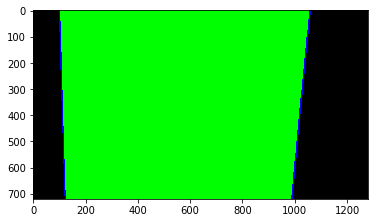

In [24]:
trace = colour_canvas
print(type(trace))
print(trace.shape)
#print(trace)
print(type(polyfit_drawn))
print(polyfit_drawn.shape)
print(np.max(polyfit_drawn))
trace[polyfit_drawn > 1] = [0,0,255]
area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
trace[area == 1] = [0,255,0]
plt.imshow(trace)

http://www.intmath.com/applications-differentiation/8-radius-curvature.php

In [42]:
# Determine curvature of the lane
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
#y_eval = 500
y_eval = imshape[0]
left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                /(2 * left_coeffs[0]))
right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                 /(2 * right_coeffs[0]))
print("Left lane curve radius: ", left_curverad, "pixels")
print("Right lane curve radius: ", right_curverad, "pixels")
curvature = (left_curverad + right_curverad) / 2
centre = center(719, left_coeffs, right_coeffs)
min_curvature = min(left_curverad, right_curverad)

print("center: ", centre, "pixels")

Left lane curve radius:  63266.3683867 pixels
Right lane curve radius:  48510.0805348 pixels
center:  -398.805269004 pixels


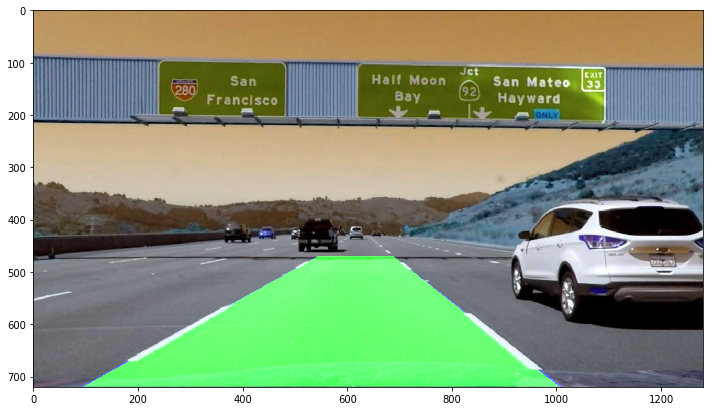

In [51]:
# Warp lane boundaries back onto original image
lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

# Convert to colour
combined_img = cv2.add(lane_lines, image)
plt.imshow(combined_img)

In [44]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 


left_curverad = ((1 + (2*left_coeffs[0]*y_eval*ym_per_pix + left_coeffs[1])**2)**1.5) / np.absolute(2*left_coeffs[0])
right_curverad = ((1 + (2*right_coeffs[0]*y_eval*ym_per_pix + right_coeffs[1])**2)**1.5) / np.absolute(2*right_coeffs[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m


curvature = (left_curverad + right_curverad) / 2
centre = center(719, left_coeffs, right_coeffs)
min_curvature = min(left_curverad, right_curverad)



63205.0829426 m 48711.7200544 m


In [46]:
def add_figures_to_image_test(img, curvature, vehicle_position, min_curvature, left_coeffs=(0,0,0), right_coeffs=(0,0,0)):
    """
    Draws information about the center offset and the current lane curvature onto the given image.
    :param img:
    """
    # Convert from pixels to meters
    vehicle_position = vehicle_position / 12800 * 3.7
    curvature = curvature / 128 * 3.7 * 10
    min_curvature = min_curvature / 128 * 3.7 * 10

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Radius of Curvature = %d(m)' % curvature, (50, 50), font, 1, (255, 255, 255), 2)
    left_or_right = "left" if vehicle_position < 0 else "right"
    cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(vehicle_position), left_or_right), (50, 100), font, 1,
                (255, 255, 255), 2)
    cv2.putText(img, 'Min Radius of Curvature = %d(m)' % min_curvature, (50, 150), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Left poly coefficients = %.3f %.3f %.3f' % (left_coeffs[0], left_coeffs[1], left_coeffs[2]), (50, 200), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Right poly coefficients = %.3f %.3f %.3f' % (right_coeffs[0], right_coeffs[1], right_coeffs[2]), (50, 250), font, 1, (255, 255, 255), 2)

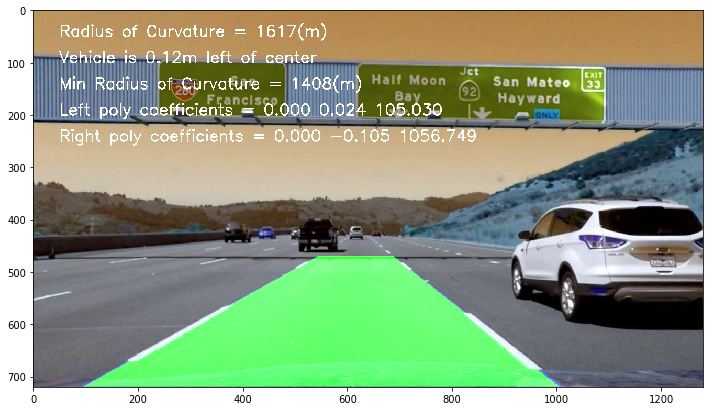

In [53]:
add_figures_to_image(combined_img, curvature=curvature, 
                     vehicle_position=centre, 
                     min_curvature=min_curvature,
                     left_coeffs=left_coeffs,
                     right_coeffs=right_coeffs)

plt.rcParams["figure.figsize"] = (12,9)
plt.imshow(combined_img)

Left coeffs: [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
righty[0]: , 708.0 , rightx[0]:  1111
Right coeffs:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
Left lane curve radius:  2978.80178694
Right lane curve radius:  2067.35316569
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


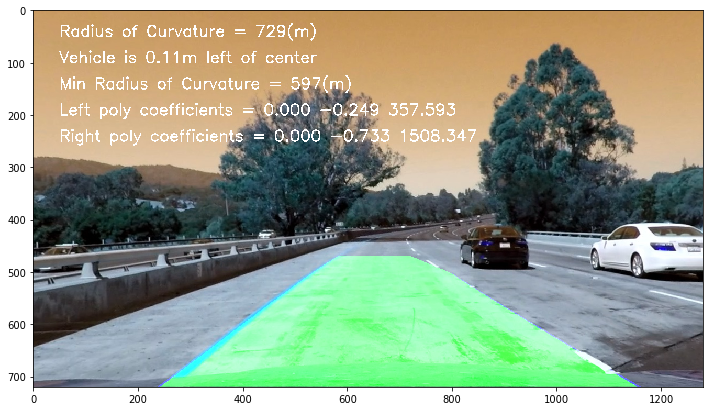

In [55]:
with open("camera_calibration.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

prev_left_coeffs = None
prev_right_coeffs = None

def image_pipeline(file, filepath=False):
    global prev_left_coeffs
    global prev_right_coeffs
    
    plt.clf()
    
    if filepath == True:
        # Read in image
        raw = cv2.imread(file)
    else:
        raw = file

    # Parameters
    imshape = raw.shape
    
    src = np.float32([
    [120, imshape[0]],
    [imshape[1]/2 - 90, imshape[0]-imshape[0]/2+110],
    [imshape[1]/2 + 60, imshape[0]-imshape[0]/2+110],
    [imshape[1] - 120, imshape[0]]
    ])
   
    dst = np.float32([
    [150,imshape[0]],
     [150,0],
     [imshape[1] - 150,0],
     [imshape[1] - 150,imshape[0]]
    ])    

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    imshape = raw.shape

    height = raw.shape[0]
#    offset = 50
#    offset_height = height - offset
    half_frame = raw.shape[1] // 2
    steps = 6
    pixels_per_step = height / steps
    window_radius = 200
    medianfilt_kernel_size = 51
#    horizontal_offset = 40

    blank_canvas = np.zeros((720, 1280))
    colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    # Apply distortion correction to raw image
    image = cv2.undistort(raw, mtx, dist, None, mtx)

    ## Option I
#    combined = apply_thresholds(image)

    ## Option II

    have_fit = False
#    curvature_checked = False

    s_thresh=(170, 255)
    sx_thresh=(40, 100)

    while have_fit == False:
#        combined_binary = apply_threshold_v2(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
        combined_binary = pipeline(image, s_thresh=s_thresh, sx_thresh=sx_thresh)
    #    plt.imshow(combined_binary, cmap="gray")

        # Plotting thresholded images
        """
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Option 1')
        ax1.imshow(combined, cmap="gray")

        ax2.set_title('Option 2: Combined S channel and gradient thresholds')
        ax2.imshow(combined_binary, cmap='gray')
        """

        # Warp onto birds-eye-view
        # Previous region-of-interest mask's function is absorbed by the warp
        warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
        # plt.imshow(warped, cmap="gray")

        # Histogram and get pixels in window

        leftx, lefty, rightx, righty, histograms = histogram_pixels(warped, horizontal_offset=40)

        plt.imshow(warped, cmap="gray")

        if len(leftx) > 1 and len(rightx) > 1:
            have_fit = True
            
#        xgrad_thresh_temp = (xgrad_thresh_temp[0] - 2, xgrad_thresh_temp[1] + 2)

    left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
    print("Left coeffs:", left_coeffs)
    print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
    right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)
    print("Right coeffs: ", right_coeffs)

    # Plot data
    """
    plt.plot(left_fit, lefty, color='green', linewidth=3)
    plt.plot(right_fit, righty, color='green', linewidth=3)
    plt.imshow(warped, cmap="gray")
    """

    # Determine curvature of the lane
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    # y_eval = 500
    y_eval = imshape[0]
    left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                    /(2 * left_coeffs[0]))
    right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                     /(2 * right_coeffs[0]))
    print("Left lane curve radius: ", left_curverad)
    print("Right lane curve radius: ", right_curverad)
    curvature = (left_curverad + right_curverad) / 2
    min_curverad = min(left_curverad, right_curverad)

    # TODO: if plausible parallel, continue. Else don't make `curvature_checked` = True
    if not plausible_curvature(left_curverad, right_curverad) or \
        not plausible_continuation_of_traces(left_coeffs, right_coeffs, prev_left_coeffs, prev_right_coeffs):
            if prev_left_coeffs is not None and prev_right_coeffs is not None:
                left_coeffs = prev_left_coeffs
                right_coeffs = prev_right_coeffs

    prev_left_coeffs = left_coeffs
    prev_right_coeffs = right_coeffs
    
    # Det vehicle position wrt centre
    centre = center(719, left_coeffs, right_coeffs)
        
    ## 7. Warp the detected lane boundaries back onto the original image.

    print("Left coeffs: ", left_coeffs)
    print("Right fit: ", right_coeffs)
    polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
#    plt.imshow(polyfit_drawn, cmap="gray")
#    plt.imshow(warped)

    # Convert to colour and highlight lane line area
    trace = colour_canvas
    trace[polyfit_drawn > 1] = [0,0,255]
    print("polyfit shape: ", polyfit_drawn.shape)
    area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
    trace[area == 1] = [0,255,0]
    # plt.imshow(trace)
    lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    # plt.imshow(trace)

    combined_img = cv2.add(lane_lines, image)
    add_figures_to_image_test(combined_img, curvature=curvature, 
                         vehicle_position=centre, 
                         min_curvature=min_curverad,
                         left_coeffs=left_coeffs,
                         right_coeffs=right_coeffs)
    plt.imshow(combined_img)
    return combined_img

combined_img = image_pipeline("test_images/test1.jpg", filepath=True)

In [56]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Left coeffs: [ -1.49781590e-04   1.79691960e-01   2.55308548e+02]
righty[0]: , 589.0 , rightx[0]:  1167
Right coeffs:  [ -1.40189882e-04   1.83912996e-02   1.23129424e+03]
Left lane curve radius:  3344.68317685
Right lane curve radius:  3748.20630148
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)
[MoviePy] >>>> Building video project_output_colour.mp4
[MoviePy] Writing video project_output_colour.mp4



  0%|          | 1/1261 [00:00<09:03,  2.32it/s]

Left coeffs: [ -1.49781590e-04   1.79691960e-01   2.55308548e+02]
righty[0]: , 589.0 , rightx[0]:  1167
Right coeffs:  [ -1.40189882e-04   1.83912996e-02   1.23129424e+03]
Left lane curve radius:  3344.68317685
Right lane curve radius:  3748.20630148
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  0%|          | 2/1261 [00:00<08:33,  2.45it/s]

Left coeffs: [ -1.85802269e-04   2.09478671e-01   2.51237292e+02]
righty[0]: , 623.0 , rightx[0]:  1160
Right coeffs:  [ -9.33295221e-05  -1.53683543e-02   1.23163673e+03]
Left lane curve radius:  2704.6591136
Right lane curve radius:  5538.60824544
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  0%|          | 3/1261 [00:01<08:36,  2.44it/s]

Left coeffs: [ -2.00492896e-04   2.19860622e-01   2.51439685e+02]
righty[0]: , 655.0 , rightx[0]:  1155
Right coeffs:  [ -3.29907171e-05  -5.34144310e-02   1.23113504e+03]
Left lane curve radius:  2511.60701154
Right lane curve radius:  15387.9108353
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  0%|          | 4/1261 [00:01<08:46,  2.39it/s]

Left coeffs: [ -2.40264537e-04   2.52310810e-01   2.47338983e+02]
righty[0]: , 686.0 , rightx[0]:  1151
Right coeffs:  [  4.37207589e-05  -1.19229847e-01   1.23953544e+03]
Left lane curve radius:  2108.48837053
Right lane curve radius:  11490.577739
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  0%|          | 5/1261 [00:01<08:20,  2.51it/s]

Left coeffs: [ -2.36238592e-04   2.57220756e-01   2.43939089e+02]
righty[0]: , 682.0 , rightx[0]:  1151
Right coeffs:  [ -2.60766060e-05  -6.22602043e-02   1.22964141e+03]
Left lane curve radius:  2138.39317808
Right lane curve radius:  19461.5120602
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  0%|          | 6/1261 [00:02<08:05,  2.59it/s]

Left coeffs: [ -2.40993215e-04   2.64058711e-01   2.43619549e+02]
righty[0]: , 680.0 , rightx[0]:  1150
Right coeffs:  [  1.09681632e-04  -1.94227247e-01   1.25512690e+03]
Left lane curve radius:  2096.20872891
Right lane curve radius:  4567.65463694
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  1%|          | 7/1261 [00:02<07:53,  2.65it/s]

Left coeffs: [ -2.26650583e-04   2.61293876e-01   2.40691703e+02]
righty[0]: , 679.0 , rightx[0]:  1150
Right coeffs:  [ -1.85195342e-04   7.98457550e-02   1.20350626e+03]
Left lane curve radius:  2220.07020608
Right lane curve radius:  2842.44623403
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  1%|          | 8/1261 [00:03<08:06,  2.57it/s]

Left coeffs: [ -2.23182129e-04   2.64756367e-01   2.39664468e+02]
righty[0]: , 567.0 , rightx[0]:  1163
Right coeffs:  [ -1.46020209e-04   5.60095430e-02   1.20077336e+03]
Left lane curve radius:  2251.10674961
Right lane curve radius:  3547.13068267
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  1%|          | 9/1261 [00:03<08:13,  2.54it/s]

Left coeffs: [ -2.12069954e-04   2.59273061e-01   2.37465098e+02]
righty[0]: , 599.0 , rightx[0]:  1161
Right coeffs:  [ -1.41744420e-04   4.44584497e-02   1.20759888e+03]
Left lane curve radius:  2365.23503414
Right lane curve radius:  3663.20055828
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  1%|          | 10/1261 [00:03<07:49,  2.66it/s]

Left coeffs: [ -1.97281762e-04   2.51671289e-01   2.35409020e+02]
righty[0]: , 623.0 , rightx[0]:  1160
Right coeffs:  [ -1.49225698e-04   4.90749626e-02   1.20749465e+03]
Left lane curve radius:  2538.44158875
Right lane curve radius:  3489.7528777
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  1%|          | 11/1261 [00:04<07:55,  2.63it/s]

Left coeffs: [ -2.13793261e-04   2.72921996e-01   2.28667714e+02]
righty[0]: , 655.0 , rightx[0]:  1155
Right coeffs:  [ -3.36696699e-04   2.34810536e-01   1.16014673e+03]
Left lane curve radius:  2342.99199412
Right lane curve radius:  1626.42702772
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  1%|          | 12/1261 [00:04<08:19,  2.50it/s]

Left coeffs: [ -2.12458738e-04   2.86171712e-01   2.16192944e+02]
righty[0]: , 692.0 , rightx[0]:  1153
Right coeffs:  [ -2.60272532e-04   1.66452836e-01   1.18250205e+03]
Left lane curve radius:  2354.77786795
Right lane curve radius:  2047.48761204
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  1%|          | 13/1261 [00:05<08:08,  2.55it/s]

Left coeffs: [ -1.86881053e-04   2.69565238e-01   2.17778568e+02]
righty[0]: , 585.0 , rightx[0]:  1166
Right coeffs:  [ -2.16480678e-04   1.32006215e-01   1.18553862e+03]
Left lane curve radius:  2675.49945727
Right lane curve radius:  2422.48252606
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  1%|          | 14/1261 [00:05<07:54,  2.63it/s]

Left coeffs: [ -2.10318715e-04   2.94037077e-01   2.11485028e+02]
righty[0]: , 601.0 , rightx[0]:  1162
Right coeffs:  [ -7.92855509e-05   2.85567394e-02   1.19799453e+03]
Left lane curve radius:  2377.62183823
Right lane curve radius:  6375.78262385
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  1%|          | 15/1261 [00:05<07:56,  2.61it/s]

Left coeffs: [ -2.03980464e-04   2.86510377e-01   2.14999918e+02]
righty[0]: , 638.0 , rightx[0]:  1153
Right coeffs:  [  1.42459824e-06  -2.07771842e-02   1.19133725e+03]
Left lane curve radius:  2451.40687573
Right lane curve radius:  351160.769994
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  1%|▏         | 16/1261 [00:06<07:57,  2.61it/s]

Left coeffs: [ -1.86686499e-04   2.69669096e-01   2.19788165e+02]
righty[0]: , 684.0 , rightx[0]:  1146
Right coeffs:  [  1.39576717e-04  -1.29527906e-01   1.19788865e+03]
Left lane curve radius:  2678.28971349
Right lane curve radius:  3609.73570112
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  1%|▏         | 17/1261 [00:06<08:05,  2.56it/s]

Left coeffs: [ -1.96497012e-04   2.76620035e-01   2.16979759e+02]
righty[0]: , 701.0 , rightx[0]:  1142
Right coeffs:  [  8.89278655e-05  -1.01871046e-01   1.19521170e+03]
Left lane curve radius:  2544.7211675
Right lane curve radius:  5628.3182918
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  1%|▏         | 18/1261 [00:07<08:22,  2.47it/s]

Left coeffs: [ -2.03782163e-04   2.81887526e-01   2.16399951e+02]
righty[0]: , 697.0 , rightx[0]:  1141
Right coeffs:  [  1.50064552e-04  -1.62734063e-01   1.20408413e+03]
Left lane curve radius:  2454.09215569
Right lane curve radius:  3346.13931678
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  2%|▏         | 19/1261 [00:07<08:23,  2.47it/s]

Left coeffs: [ -1.59982699e-04   2.53760717e-01   2.15138897e+02]
righty[0]: , 697.0 , rightx[0]:  1141
Right coeffs:  [ -3.96299171e-05  -4.71085652e-03   1.18226278e+03]
Left lane curve radius:  3127.90212039
Right lane curve radius:  12689.0276621
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  2%|▏         | 20/1261 [00:07<08:00,  2.58it/s]

Left coeffs: [ -1.52664100e-04   2.55336180e-01   2.09341466e+02]
righty[0]: , 694.0 , rightx[0]:  1142
Right coeffs:  [  1.16607288e-04  -1.75969057e-01   1.22686318e+03]
Left lane curve radius:  3281.35742813
Right lane curve radius:  4288.31395081
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  2%|▏         | 21/1261 [00:08<07:56,  2.60it/s]

Left coeffs: [ -1.24609369e-04   2.36839534e-01   2.07968622e+02]
righty[0]: , 576.0 , rightx[0]:  1148
Right coeffs:  [ -1.79503443e-04   4.97614831e-02   1.19275080e+03]
Left lane curve radius:  4032.38763927
Right lane curve radius:  2969.4552394
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  2%|▏         | 22/1261 [00:08<07:59,  2.58it/s]

Left coeffs: [ -1.16229780e-04   2.32813829e-01   2.03668270e+02]
righty[0]: , 607.0 , rightx[0]:  1148
Right coeffs:  [ -4.28541257e-05  -7.28433868e-02   1.22621026e+03]
Left lane curve radius:  4329.48871777
Right lane curve radius:  11985.7706481
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  2%|▏         | 23/1261 [00:08<07:37,  2.70it/s]

Left coeffs: [ -9.58945416e-05   2.18568104e-01   2.00948110e+02]
righty[0]: , 638.0 , rightx[0]:  1147
Right coeffs:  [ -2.99325244e-05  -9.02263300e-02   1.23582431e+03]
Left lane curve radius:  5264.80045241
Right lane curve radius:  17151.6298034
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  2%|▏         | 24/1261 [00:09<07:44,  2.66it/s]

Left coeffs: [ -6.96615853e-05   1.83236493e-01   2.11814371e+02]
righty[0]: , 667.0 , rightx[0]:  1144
Right coeffs:  [ -1.33884350e-04   5.58733526e-03   1.21230806e+03]
Left lane curve radius:  7251.71731092
Right lane curve radius:  3932.59978233
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  2%|▏         | 25/1261 [00:09<07:43,  2.67it/s]

Left coeffs: [ -8.50814227e-05   1.89465960e-01   2.12034322e+02]
righty[0]: , 699.0 , rightx[0]:  1139
Right coeffs:  [ -7.12614812e-05  -4.75313535e-02   1.22217344e+03]
Left lane curve radius:  5916.27814561
Right lane curve radius:  7255.0166442
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  2%|▏         | 26/1261 [00:10<08:01,  2.56it/s]

Left coeffs: [ -8.37460858e-05   1.87855285e-01   2.09554256e+02]
righty[0]: , 594.0 , rightx[0]:  1152
Right coeffs:  [ -2.60182666e-04   1.13480150e-01   1.19634474e+03]
Left lane curve radius:  6010.98968817
Right lane curve radius:  2121.68335237
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  2%|▏         | 27/1261 [00:10<07:45,  2.65it/s]

Left coeffs: [ -9.10098199e-05   1.86013432e-01   2.11256176e+02]
righty[0]: , 623.0 , rightx[0]:  1150
Right coeffs:  [ -9.76552880e-05  -3.95587671e-03   1.21329094e+03]
Left lane curve radius:  5518.82316643
Right lane curve radius:  5281.42486161
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  2%|▏         | 28/1261 [00:10<07:48,  2.63it/s]

Left coeffs: [ -7.08018540e-05   1.67268872e-01   2.11100835e+02]
righty[0]: , 657.0 , rightx[0]:  1150
Right coeffs:  [ -1.61659927e-04   2.58859444e-02   1.22262853e+03]
Left lane curve radius:  7107.19903279
Right lane curve radius:  3293.63174055
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  2%|▏         | 29/1261 [00:11<07:50,  2.62it/s]

Left coeffs: [ -1.12399012e-04   1.91915500e-01   2.11645439e+02]
righty[0]: , 690.0 , rightx[0]:  1145
Right coeffs:  [ -1.02049028e-04  -1.03743115e-02   1.22098845e+03]
Left lane curve radius:  4454.46884764
Right lane curve radius:  5082.63286962
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  2%|▏         | 30/1261 [00:11<07:45,  2.64it/s]

Left coeffs: [ -1.57436147e-04   2.18254749e-01   2.12487411e+02]
righty[0]: , 702.0 , rightx[0]:  1141
Right coeffs:  [ -6.64427773e-06  -8.46491478e-02   1.22551351e+03]
Left lane curve radius:  3176.23116113
Right lane curve radius:  76256.9526801
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  2%|▏         | 31/1261 [00:11<07:26,  2.75it/s]

Left coeffs: [ -1.78965027e-04   2.28793876e-01   2.15864912e+02]
righty[0]: , 707.0 , rightx[0]:  1141
Right coeffs:  [ -8.66473852e-06  -7.51963595e-02   1.21875558e+03]
Left lane curve radius:  2797.3466664
Right lane curve radius:  58371.7623092
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  3%|▎         | 32/1261 [00:12<07:16,  2.82it/s]

Left coeffs: [ -2.07410562e-04   2.42339426e-01   2.20755353e+02]
righty[0]: , 701.0 , rightx[0]:  1140
Right coeffs:  [ -2.03134016e-04   1.16872840e-01   1.17338763e+03]
Left lane curve radius:  2422.16131131
Right lane curve radius:  2576.20382774
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  3%|▎         | 33/1261 [00:12<07:03,  2.90it/s]

Left coeffs: [ -1.69414304e-04   2.13377717e-01   2.23369053e+02]
righty[0]: , 704.0 , rightx[0]:  1142
Right coeffs:  [ -6.77567579e-05  -2.93478014e-02   1.21338012e+03]
Left lane curve radius:  2955.48517228
Right lane curve radius:  7558.35405287
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  3%|▎         | 34/1261 [00:12<07:27,  2.74it/s]

Left coeffs: [ -1.94691273e-04   2.33569637e-01   2.22337519e+02]
righty[0]: , 591.0 , rightx[0]:  1156
Right coeffs:  [ -8.97212607e-05   1.28346700e-02   1.19775599e+03]
Left lane curve radius:  2576.60537849
Right lane curve radius:  5686.38605996
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  3%|▎         | 35/1261 [00:13<07:38,  2.67it/s]

Left coeffs: [ -2.11574197e-04   2.47041580e-01   2.22332629e+02]
righty[0]: , 623.0 , rightx[0]:  1153
Right coeffs:  [ -8.10817578e-05   6.66620720e-04   1.20199231e+03]
Left lane curve radius:  2375.0182068
Right lane curve radius:  6291.69684583
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  3%|▎         | 36/1261 [00:13<07:28,  2.73it/s]

Left coeffs: [ -1.88791874e-04   2.25628632e-01   2.30203660e+02]
righty[0]: , 673.0 , rightx[0]:  1137
Right coeffs:  [ -1.99605584e-04   1.07270218e-01   1.17640904e+03]
Left lane curve radius:  2656.91457773
Right lane curve radius:  2627.88337118
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  3%|▎         | 37/1261 [00:14<07:34,  2.69it/s]

Left coeffs: [ -2.00138107e-04   2.37116792e-01   2.28744175e+02]
righty[0]: , 703.0 , rightx[0]:  1132
Right coeffs:  [ -3.94247220e-04   2.85951049e-01   1.13389518e+03]
Left lane curve radius:  2508.05964461
Right lane curve radius:  1422.23003757
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  3%|▎         | 38/1261 [00:14<07:51,  2.59it/s]

Left coeffs: [ -2.05198160e-04   2.37964832e-01   2.31950780e+02]
righty[0]: , 563.0 , rightx[0]:  1150
Right coeffs:  [ -2.50591639e-04   1.80928558e-01   1.14936360e+03]
Left lane curve radius:  2448.77200621
Right lane curve radius:  2092.9460099
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  3%|▎         | 39/1261 [00:14<07:52,  2.59it/s]

Left coeffs: [ -2.17264041e-04   2.49488792e-01   2.30754859e+02]
righty[0]: , 606.0 , rightx[0]:  1144
Right coeffs:  [ -1.52246914e-04   1.19783863e-01   1.14897723e+03]
Left lane curve radius:  2315.22424371
Right lane curve radius:  3332.98243358
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  3%|▎         | 40/1261 [00:15<07:34,  2.69it/s]

Left coeffs: [ -2.26627381e-04   2.64015412e-01   2.25469923e+02]
righty[0]: , 626.0 , rightx[0]:  1143
Right coeffs:  [ -6.96178109e-05   4.42036371e-02   1.16491966e+03]
Left lane curve radius:  2219.13350808
Right lane curve radius:  7215.93668111
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  3%|▎         | 41/1261 [00:15<07:50,  2.59it/s]

Left coeffs: [ -2.32020175e-04   2.70078350e-01   2.24633484e+02]
righty[0]: , 668.0 , rightx[0]:  1140
Right coeffs:  [  1.28824240e-05  -2.41750232e-02   1.17461181e+03]
Left lane curve radius:  2168.25152195
Right lane curve radius:  38814.4129968
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  3%|▎         | 42/1261 [00:16<07:56,  2.56it/s]

Left coeffs: [ -2.32542363e-04   2.71824950e-01   2.25002242e+02]
righty[0]: , 702.0 , rightx[0]:  1136
Right coeffs:  [ -3.50477480e-06  -2.72000519e-02   1.18192534e+03]
Left lane curve radius:  2162.97413434
Right lane curve radius:  142885.101039
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  3%|▎         | 43/1261 [00:16<08:20,  2.43it/s]

Left coeffs: [ -2.39174010e-04   2.83696484e-01   2.20503630e+02]
righty[0]: , 707.0 , rightx[0]:  1139
Right coeffs:  [  1.57811378e-05  -5.96891140e-02   1.19488625e+03]
Left lane curve radius:  2102.09795599
Right lane curve radius:  31748.3520846
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  3%|▎         | 44/1261 [00:16<08:24,  2.41it/s]

Left coeffs: [ -2.60539968e-04   3.12965332e-01   2.09545002e+02]
righty[0]: , 702.0 , rightx[0]:  1141
Right coeffs:  [  2.46699371e-05  -8.58924234e-02   1.20895982e+03]
Left lane curve radius:  1930.24349249
Right lane curve radius:  20344.7573992
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  4%|▎         | 45/1261 [00:17<08:06,  2.50it/s]

Left coeffs: [ -2.51718166e-04   3.10956145e-01   2.07481043e+02]
righty[0]: , 697.0 , rightx[0]:  1143
Right coeffs:  [ -1.65973596e-04   8.29611507e-02   1.18161917e+03]
Left lane curve radius:  1994.26171036
Right lane curve radius:  3123.22129718
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  4%|▎         | 46/1261 [00:17<07:53,  2.57it/s]

Left coeffs: [ -2.67318659e-04   3.28407484e-01   2.02407535e+02]
righty[0]: , 570.0 , rightx[0]:  1156
Right coeffs:  [ -1.50230026e-04   6.74266801e-02   1.18474842e+03]
Left lane curve radius:  1879.40027937
Right lane curve radius:  3439.5338964
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  4%|▎         | 47/1261 [00:17<07:29,  2.70it/s]

Left coeffs: [ -2.94102068e-04   3.57475191e-01   1.94412712e+02]
righty[0]: , 706.0 , rightx[0]:  1128
Right coeffs:  [ -2.10367620e-04   1.04377632e-01   1.18424525e+03]
Left lane curve radius:  1711.22125484
Right lane curve radius:  2518.71753111
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  4%|▍         | 48/1261 [00:18<07:33,  2.68it/s]

Left coeffs: [ -2.75078155e-04   3.46023242e-01   1.94834787e+02]
righty[0]: , 674.0 , rightx[0]:  1128
Right coeffs:  [ -1.59507465e-04   7.39226529e-02   1.18474800e+03]
Left lane curve radius:  1824.51014104
Right lane curve radius:  3249.42609491
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  4%|▍         | 49/1261 [00:18<07:35,  2.66it/s]

Left coeffs: [ -2.46273731e-04   3.29400110e-01   1.92264441e+02]
righty[0]: , 706.0 , rightx[0]:  1125
Right coeffs:  [ -1.63048156e-04   6.59780280e-02   1.19300451e+03]
Left lane curve radius:  2032.20068135
Right lane curve radius:  3198.59182011
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  4%|▍         | 50/1261 [00:19<07:16,  2.77it/s]

Left coeffs: [ -2.53625839e-04   3.43864755e-01   1.86435619e+02]
righty[0]: , 703.0 , rightx[0]:  1144
Right coeffs:  [ -2.18300097e-04   1.14507321e-01   1.18197041e+03]
Left lane curve radius:  1972.75685357
Right lane curve radius:  2428.99833354
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  4%|▍         | 51/1261 [00:19<07:16,  2.77it/s]

Left coeffs: [ -2.56310679e-04   3.54452287e-01   1.80995269e+02]
righty[0]: , 591.0 , rightx[0]:  1154
Right coeffs:  [ -2.22816985e-04   1.41081135e-01   1.17000175e+03]
Left lane curve radius:  1951.38435259
Right lane curve radius:  2353.65441842
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  4%|▍         | 52/1261 [00:19<07:31,  2.68it/s]

Left coeffs: [ -2.40425117e-04   3.44142483e-01   1.82323104e+02]
righty[0]: , 623.0 , rightx[0]:  1148
Right coeffs:  [ -1.87840820e-04   1.33212270e-01   1.15921311e+03]
Left lane curve radius:  2079.66296601
Right lane curve radius:  2737.42643149
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  4%|▍         | 53/1261 [00:20<07:47,  2.58it/s]

Left coeffs: [ -2.35796296e-04   3.39004275e-01   1.83778429e+02]
righty[0]: , 645.0 , rightx[0]:  1144
Right coeffs:  [ -8.19955646e-05   5.24293250e-02   1.16660383e+03]
Left lane curve radius:  2120.47529272
Right lane curve radius:  6137.3485398
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  4%|▍         | 54/1261 [00:20<08:03,  2.49it/s]

Left coeffs: [ -2.18686699e-04   3.28918348e-01   1.82830037e+02]
righty[0]: , 683.0 , rightx[0]:  1112
Right coeffs:  [ -6.45947094e-05   3.84163736e-02   1.16599369e+03]
Left lane curve radius:  2287.04905275
Right lane curve radius:  7775.21163222
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  4%|▍         | 55/1261 [00:21<07:56,  2.53it/s]

Left coeffs: [ -2.07562215e-04   3.23627373e-01   1.80264834e+02]
righty[0]: , 704.0 , rightx[0]:  1139
Right coeffs:  [ -4.26801431e-05   6.83008897e-03   1.17552901e+03]
Left lane curve radius:  2411.12785576
Right lane curve radius:  11767.5317871
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  4%|▍         | 56/1261 [00:21<07:40,  2.62it/s]

Left coeffs: [ -1.75205711e-04   2.98068419e-01   1.82387913e+02]
righty[0]: , 647.0 , rightx[0]:  1116
Right coeffs:  [ -8.34111374e-05   3.51626073e-02   1.17481302e+03]
Left lane curve radius:  2862.76138824
Right lane curve radius:  6059.40732315
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  5%|▍         | 57/1261 [00:21<07:23,  2.71it/s]

Left coeffs: [ -1.52080104e-04   2.79889111e-01   1.84316646e+02]
righty[0]: , 679.0 , rightx[0]:  1114
Right coeffs:  [ -2.28152087e-05  -2.60283717e-02   1.18769018e+03]
Left lane curve radius:  3306.04465599
Right lane curve radius:  22029.2788559
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  5%|▍         | 58/1261 [00:22<07:30,  2.67it/s]

Left coeffs: [ -1.28786101e-04   2.58952808e-01   1.87060162e+02]
righty[0]: , 707.0 , rightx[0]:  1138
Right coeffs:  [ -5.99216301e-05   6.50001965e-03   1.18256693e+03]
Left lane curve radius:  3913.91028497
Right lane curve radius:  8424.03784332
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  5%|▍         | 59/1261 [00:22<07:30,  2.67it/s]

Left coeffs: [ -9.16119183e-05   2.16959902e-01   1.99944060e+02]
righty[0]: , 445.0 , rightx[0]:  1142
Right coeffs:  [ -1.05576269e-04   7.17935251e-02   1.15620328e+03]
Left lane curve radius:  5517.11495045
Right lane curve radius:  4781.72003036
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  5%|▍         | 60/1261 [00:22<07:53,  2.54it/s]

Left coeffs: [ -7.58186078e-05   1.92435650e-01   2.08843334e+02]
righty[0]: , 623.0 , rightx[0]:  1136
Right coeffs:  [ -1.24405514e-04   9.50292468e-02   1.14272047e+03]
Left lane curve radius:  6663.37448546
Right lane curve radius:  4061.84437674
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  5%|▍         | 61/1261 [00:23<07:35,  2.63it/s]

Left coeffs: [ -7.29299582e-05   1.81409845e-01   2.12675724e+02]
righty[0]: , 653.0 , rightx[0]:  1133
Right coeffs:  [ -4.60790093e-04   3.64569376e-01   1.08965288e+03]
Left lane curve radius:  6915.99235951
Right lane curve radius:  1233.77853803
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  5%|▍         | 62/1261 [00:23<07:54,  2.53it/s]

Left coeffs: [ -6.67761767e-05   1.63608940e-01   2.20472382e+02]
righty[0]: , 687.0 , rightx[0]:  1130
Right coeffs:  [ -3.13122307e-04   2.78965526e-01   1.09300730e+03]
Left lane curve radius:  7538.85825435
Right lane curve radius:  1668.144123
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  5%|▍         | 63/1261 [00:24<08:12,  2.43it/s]

Left coeffs: [ -6.94206805e-05   1.63610077e-01   2.19280066e+02]
righty[0]: , 481.0 , rightx[0]:  1131
Right coeffs:  [ -1.74391852e-04   1.79149829e-01   1.10931955e+03]
Left lane curve radius:  7246.27038852
Right lane curve radius:  2889.41405041
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  5%|▌         | 64/1261 [00:24<08:09,  2.45it/s]

Left coeffs: [ -8.19037191e-05   1.63186090e-01   2.23465841e+02]
righty[0]: , 702.0 , rightx[0]:  1094
Right coeffs:  [ -6.21130889e-05   9.37810871e-02   1.11783459e+03]
Left lane curve radius:  6123.48383884
Right lane curve radius:  8050.06037474
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  5%|▌         | 65/1261 [00:24<08:01,  2.48it/s]

Left coeffs: [ -1.08592106e-04   1.83617138e-01   2.18182904e+02]
righty[0]: , 648.0 , rightx[0]:  1127
Right coeffs:  [  1.52418597e-05   1.02485354e-02   1.13864507e+03]
Left lane curve radius:  4609.5137104
Right lane curve radius:  32855.4183619
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  5%|▌         | 66/1261 [00:25<08:06,  2.46it/s]

Left coeffs: [ -1.33117701e-04   1.95891263e-01   2.19082051e+02]
righty[0]: , 673.0 , rightx[0]:  1125
Right coeffs:  [  3.31020705e-05  -8.64482016e-03   1.14014429e+03]
Left lane curve radius:  3756.17394565
Right lane curve radius:  15139.309229
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  5%|▌         | 67/1261 [00:25<07:59,  2.49it/s]

Left coeffs: [ -1.42479388e-04   2.01028504e-01   2.17830896e+02]
righty[0]: , 703.0 , rightx[0]:  1121
Right coeffs:  [ -4.19724035e-05   4.18926466e-02   1.13398327e+03]
Left lane curve radius:  3509.36982714
Right lane curve radius:  11918.7368579
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  5%|▌         | 68/1261 [00:26<07:42,  2.58it/s]

Left coeffs: [ -1.94544045e-04   2.42279130e-01   2.08791984e+02]
righty[0]: , 701.0 , rightx[0]:  1121
Right coeffs:  [  7.17808952e-05  -8.12915824e-02   1.16357034e+03]
Left lane curve radius:  2575.64123853
Right lane curve radius:  6970.73299438
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  5%|▌         | 69/1261 [00:26<07:27,  2.66it/s]

Left coeffs: [ -2.16190378e-04   2.56408952e-01   2.08893191e+02]
righty[0]: , 693.0 , rightx[0]:  1120
Right coeffs:  [ -5.82665727e-06  -9.71133906e-03   1.14641494e+03]
Left lane curve radius:  2323.24233586
Right lane curve radius:  85854.6764771
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  6%|▌         | 70/1261 [00:26<07:36,  2.61it/s]

Left coeffs: [ -2.34209481e-04   2.77969327e-01   2.00189835e+02]
righty[0]: , 692.0 , rightx[0]:  1119
Right coeffs:  [ -1.65671658e-05  -2.20677904e-02   1.15836434e+03]
Left lane curve radius:  2146.10868391
Right lane curve radius:  30275.7052303
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  6%|▌         | 71/1261 [00:27<07:20,  2.70it/s]

Left coeffs: [ -2.30351410e-04   2.76436532e-01   2.00227257e+02]
righty[0]: , 574.0 , rightx[0]:  1127
Right coeffs:  [  2.36770705e-05  -4.68131622e-02   1.16103712e+03]
Left lane curve radius:  2180.55008642
Right lane curve radius:  21122.601266
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  6%|▌         | 72/1261 [00:27<07:36,  2.60it/s]

Left coeffs: [ -2.34370146e-04   2.88025595e-01   1.93677963e+02]
righty[0]: , 606.0 , rightx[0]:  1126
Right coeffs:  [ -8.53896527e-06  -4.79524256e-02   1.16966035e+03]
Left lane curve radius:  2141.21294739
Right lane curve radius:  58874.2157484
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  6%|▌         | 73/1261 [00:28<07:28,  2.65it/s]

Left coeffs: [ -2.31277747e-04   2.92998693e-01   1.88935399e+02]
righty[0]: , 637.0 , rightx[0]:  1124
Right coeffs:  [  2.46916473e-05  -6.55520369e-02   1.17259935e+03]
Left lane curve radius:  2167.10411957
Right lane curve radius:  20277.098883
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  6%|▌         | 74/1261 [00:28<07:24,  2.67it/s]

Left coeffs: [ -2.11355675e-04   2.80994074e-01   1.88626025e+02]
righty[0]: , 668.0 , rightx[0]:  1121
Right coeffs:  [ -2.99395660e-04   1.91741261e-01   1.12345466e+03]
Left lane curve radius:  2367.6168446
Right lane curve radius:  1815.62465691
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  6%|▌         | 75/1261 [00:28<07:12,  2.74it/s]

Left coeffs: [ -1.93907817e-04   2.76009698e-01   1.83157908e+02]
righty[0]: , 669.0 , rightx[0]:  1114
Right coeffs:  [ -3.04151150e-04   1.85495168e-01   1.13148056e+03]
Left lane curve radius:  2578.58487626
Right lane curve radius:  1803.59205468
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  6%|▌         | 76/1261 [00:29<07:11,  2.75it/s]

Left coeffs: [ -1.45556686e-04   2.36345390e-01   1.90047349e+02]
righty[0]: , 592.0 , rightx[0]:  1118
Right coeffs:  [ -2.41680793e-04   1.46805546e-01   1.13432782e+03]
Left lane curve radius:  3438.77379352
Right lane curve radius:  2195.7510635
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  6%|▌         | 77/1261 [00:29<07:11,  2.74it/s]

Left coeffs: [ -1.18479669e-04   2.26314531e-01   1.82330999e+02]
righty[0]: , 615.0 , rightx[0]:  1120
Right coeffs:  [ -1.80841141e-04   7.96165850e-02   1.15891309e+03]
Left lane curve radius:  4239.79063166
Right lane curve radius:  2901.52052751
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  6%|▌         | 78/1261 [00:29<07:21,  2.68it/s]

Left coeffs: [ -8.89577542e-05   2.04447493e-01   1.82577023e+02]
righty[0]: , 700.0 , rightx[0]:  1103
Right coeffs:  [ -1.11103288e-04   1.84246320e-02   1.17252322e+03]
Left lane curve radius:  5669.86171762
Right lane curve radius:  4636.27458559
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  6%|▋         | 79/1261 [00:30<07:27,  2.64it/s]

Left coeffs: [ -6.64156268e-05   1.85047550e-01   1.82668086e+02]
righty[0]: , 684.0 , rightx[0]:  1106
Right coeffs:  [ -2.38014463e-05  -6.08352634e-02   1.18851321e+03]
Left lane curve radius:  7618.80108699
Right lane curve radius:  21292.8094684
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  6%|▋         | 80/1261 [00:30<07:16,  2.70it/s]

Left coeffs: [ -6.23504742e-05   1.75846906e-01   1.84342011e+02]
righty[0]: , 696.0 , rightx[0]:  1111
Right coeffs:  [  2.90913340e-05  -1.17927960e-01   1.19989911e+03]
Left lane curve radius:  8108.44359813
Right lane curve radius:  17336.517348
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  6%|▋         | 81/1261 [00:31<07:44,  2.54it/s]

Left coeffs: [ -4.63402015e-05   1.53517424e-01   1.90443723e+02]
righty[0]: , 704.0 , rightx[0]:  1110
Right coeffs:  [ -5.66795368e-05  -3.80934122e-02   1.18204499e+03]
Left lane curve radius:  10911.9007742
Right lane curve radius:  9011.83491626
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  7%|▋         | 82/1261 [00:31<07:42,  2.55it/s]

Left coeffs: [ -4.61919860e-05   1.50377951e-01   1.89189595e+02]
righty[0]: , 695.0 , rightx[0]:  1110
Right coeffs:  [ -9.35245320e-06  -9.53906640e-02   1.19847855e+03]
Left lane curve radius:  10938.7767969
Right lane curve radius:  54415.0125189
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  7%|▋         | 83/1261 [00:31<07:47,  2.52it/s]

Left coeffs: [ -5.32823329e-05   1.49403939e-01   1.89569653e+02]
righty[0]: , 704.0 , rightx[0]:  1109
Right coeffs:  [ -7.12004040e-06  -1.03041989e-01   1.20292605e+03]
Left lane curve radius:  9458.42084039
Right lane curve radius:  71580.7198882
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  7%|▋         | 84/1261 [00:32<07:29,  2.62it/s]

Left coeffs: [ -4.33364909e-05   1.47944001e-01   1.81801945e+02]
righty[0]: , 578.0 , rightx[0]:  1134
Right coeffs:  [  4.10900455e-05  -1.46423424e-01   1.22362506e+03]
Left lane curve radius:  11664.4833255
Right lane curve radius:  12307.6224889
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  7%|▋         | 85/1261 [00:32<07:31,  2.61it/s]

Left coeffs: [ -5.18147755e-05   1.46073314e-01   1.84876164e+02]
righty[0]: , 615.0 , rightx[0]:  1129
Right coeffs:  [ -1.03271889e-04  -2.62230587e-02   1.20068581e+03]
Left lane curve radius:  9723.76668905
Right lane curve radius:  5065.52450997
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  7%|▋         | 86/1261 [00:32<07:36,  2.57it/s]

Left coeffs: [ -6.03202821e-05   1.44174741e-01   1.88449158e+02]
righty[0]: , 653.0 , rightx[0]:  1123
Right coeffs:  [ -1.03015483e-04  -4.10460984e-02   1.20718722e+03]
Left lane curve radius:  8329.96192524
Right lane curve radius:  5117.10236599
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  7%|▋         | 87/1261 [00:33<07:42,  2.54it/s]

Left coeffs: [ -6.11508544e-05   1.23166605e-01   2.04902937e+02]
righty[0]: , 678.0 , rightx[0]:  1117
Right coeffs:  [ -3.59021705e-04   2.03366933e-01   1.14468067e+03]
Left lane curve radius:  8191.62366859
Right lane curve radius:  1603.12168978
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  7%|▋         | 88/1261 [00:33<07:48,  2.50it/s]

Left coeffs: [ -9.53611479e-05   1.36882982e-01   2.11181476e+02]
righty[0]: , 567.0 , rightx[0]:  1123
Right coeffs:  [ -3.43181917e-04   2.04493677e-01   1.13541933e+03]
Left lane curve radius:  5243.22697798
Right lane curve radius:  1644.14847364
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  7%|▋         | 89/1261 [00:34<07:57,  2.45it/s]

Left coeffs: [ -1.08633064e-04   1.37341289e-01   2.17920281e+02]
righty[0]: , 601.0 , rightx[0]:  1117
Right coeffs:  [ -1.98234691e-04   1.36687582e-01   1.12969788e+03]
Left lane curve radius:  4605.16658037
Right lane curve radius:  2606.46093692
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  7%|▋         | 90/1261 [00:34<07:58,  2.44it/s]

Left coeffs: [ -1.10026935e-04   1.26871279e-01   2.29520707e+02]
righty[0]: , 634.0 , rightx[0]:  1112
Right coeffs:  [ -1.15672041e-05  -3.12077689e-03   1.14198568e+03]
Left lane curve radius:  4551.13619798
Right lane curve radius:  43251.0215924
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  7%|▋         | 91/1261 [00:35<08:38,  2.26it/s]

Left coeffs: [ -1.29902666e-04   1.46052403e-01   2.24110312e+02]
righty[0]: , 666.0 , rightx[0]:  1110
Right coeffs:  [  6.38675343e-05  -8.12770819e-02   1.16269894e+03]
Left lane curve radius:  3858.74864668
Right lane curve radius:  7830.04619545
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  7%|▋         | 92/1261 [00:35<08:12,  2.37it/s]

Left coeffs: [ -1.45329564e-04   1.60855494e-01   2.21656317e+02]
righty[0]: , 698.0 , rightx[0]:  1106
Right coeffs:  [  5.71358625e-05  -9.33474529e-02   1.17018910e+03]
Left lane curve radius:  3452.56203384
Right lane curve radius:  8752.68035753
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  7%|▋         | 93/1261 [00:35<08:09,  2.38it/s]

Left coeffs: [ -1.72420286e-04   1.75183570e-01   2.24859120e+02]
righty[0]: , 708.0 , rightx[0]:  1105
Right coeffs:  [  1.68652359e-04  -2.04256098e-01   1.18966151e+03]
Left lane curve radius:  2923.16669904
Right lane curve radius:  2971.30784543
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  7%|▋         | 94/1261 [00:36<07:53,  2.46it/s]

Left coeffs: [ -2.01264892e-04   2.00800631e-01   2.22246263e+02]
righty[0]: , 708.0 , rightx[0]:  1105
Right coeffs:  [  4.91574804e-05  -1.03840746e-01   1.17397437e+03]
Left lane curve radius:  2513.87752815
Right lane curve radius:  10188.0658594
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  8%|▊         | 95/1261 [00:36<07:33,  2.57it/s]

Left coeffs: [ -1.96064975e-04   2.00913124e-01   2.19736962e+02]
righty[0]: , 708.0 , rightx[0]:  1105
Right coeffs:  [  1.01470172e-04  -1.77552900e-01   1.19746469e+03]
Left lane curve radius:  2575.57576501
Right lane curve radius:  4934.86248126
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  8%|▊         | 96/1261 [00:37<07:40,  2.53it/s]

Left coeffs: [ -2.04172429e-04   2.10936325e-01   2.17385868e+02]
righty[0]: , 571.0 , rightx[0]:  1119
Right coeffs:  [ -8.39362250e-05  -2.07644411e-02   1.16815812e+03]
Left lane curve radius:  2474.30388629
Right lane curve radius:  6137.04088632
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  8%|▊         | 97/1261 [00:37<07:19,  2.65it/s]

Left coeffs: [ -2.00876061e-04   2.11253026e-01   2.17690078e+02]
righty[0]: , 597.0 , rightx[0]:  1115
Right coeffs:  [ -8.21948756e-05  -3.11627665e-02   1.17348238e+03]
Left lane curve radius:  2511.85197465
Right lane curve radius:  6288.24247095
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  8%|▊         | 98/1261 [00:37<07:26,  2.60it/s]

Left coeffs: [ -1.82009485e-04   2.03099035e-01   2.15200104e+02]
righty[0]: , 628.0 , rightx[0]:  1114
Right coeffs:  [ -4.89113898e-05  -6.72918438e-02   1.18862053e+03]
Left lane curve radius:  2761.46346417
Right lane curve radius:  10514.7947342
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  8%|▊         | 99/1261 [00:38<07:10,  2.70it/s]

Left coeffs: [ -1.79450964e-04   2.01055323e-01   2.17845177e+02]
righty[0]: , 661.0 , rightx[0]:  1109
Right coeffs:  [ -3.24473701e-04   1.64031434e-01   1.14006525e+03]
Left lane curve radius:  2800.03591081
Right lane curve radius:  1758.27463856
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  8%|▊         | 100/1261 [00:38<07:19,  2.64it/s]

Left coeffs: [ -1.76941325e-04   2.03145332e-01   2.15621086e+02]
righty[0]: , 694.0 , rightx[0]:  1106
Right coeffs:  [ -1.01083331e-04  -3.63192856e-02   1.18843853e+03]
Left lane curve radius:  2837.11077932
Right lane curve radius:  5193.87431126
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  8%|▊         | 101/1261 [00:38<07:22,  2.62it/s]

Left coeffs: [ -1.63538928e-04   1.92911682e-01   2.19228620e+02]
righty[0]: , 589.0 , rightx[0]:  1114
Right coeffs:  [ -2.73793106e-04   1.38160492e-01   1.14645113e+03]
Left lane curve radius:  3065.69630803
Right lane curve radius:  2008.77590112
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  8%|▊         | 102/1261 [00:39<07:08,  2.70it/s]

Left coeffs: [ -1.58790582e-04   1.88898100e-01   2.21861517e+02]
righty[0]: , 624.0 , rightx[0]:  1108
Right coeffs:  [ -2.26116488e-04   1.08355804e-01   1.14719785e+03]
Left lane curve radius:  3156.27113942
Right lane curve radius:  2369.63377653
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  8%|▊         | 103/1261 [00:39<07:33,  2.55it/s]

Left coeffs: [ -1.51912348e-04   1.82883743e-01   2.23388802e+02]
righty[0]: , 656.0 , rightx[0]:  1106
Right coeffs:  [ -1.31357247e-04   3.05551707e-02   1.16296332e+03]
Left lane curve radius:  3297.72604084
Right lane curve radius:  3950.93113142
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  8%|▊         | 104/1261 [00:40<07:49,  2.46it/s]

Left coeffs: [ -1.48480126e-04   1.79825188e-01   2.25611306e+02]
righty[0]: , 686.0 , rightx[0]:  1104
Right coeffs:  [ -9.88225855e-05   5.59872500e-03   1.16721184e+03]
Left lane curve radius:  3373.29015759
Right lane curve radius:  5202.06628335
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  8%|▊         | 105/1261 [00:40<07:41,  2.51it/s]

Left coeffs: [ -1.32985420e-04   1.71362915e-01   2.23431860e+02]
righty[0]: , 703.0 , rightx[0]:  1105
Right coeffs:  [ -6.30686137e-05  -4.34005336e-02   1.18790563e+03]
Left lane curve radius:  3762.09757121
Right lane curve radius:  8143.06454065
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  8%|▊         | 106/1261 [00:40<07:51,  2.45it/s]

Left coeffs: [ -1.45609043e-04   1.82978102e-01   2.20450644e+02]
righty[0]: , 701.0 , rightx[0]:  1109
Right coeffs:  [ -9.11596701e-05  -3.15300557e-02   1.19428706e+03]
Left lane curve radius:  3437.5249475
Right lane curve radius:  5704.37572421
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  8%|▊         | 107/1261 [00:41<07:53,  2.44it/s]

Left coeffs: [ -1.57791181e-04   1.95810032e-01   2.16810938e+02]
righty[0]: , 702.0 , rightx[0]:  1113
Right coeffs:  [ -9.56495773e-05  -4.09641920e-02   1.20657191e+03]
Left lane curve radius:  3173.43519816
Right lane curve radius:  5479.79790745
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  9%|▊         | 108/1261 [00:41<07:38,  2.51it/s]

Left coeffs: [ -1.72428704e-04   2.01991252e-01   2.22169343e+02]
righty[0]: , 707.0 , rightx[0]:  1113
Right coeffs:  [ -1.06797281e-04  -2.31675596e-02   1.19925636e+03]
Left lane curve radius:  2909.08091907
Right lane curve radius:  4903.38207574
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  9%|▊         | 109/1261 [00:42<07:18,  2.63it/s]

Left coeffs: [ -1.73855003e-04   2.02153373e-01   2.23262128e+02]
righty[0]: , 572.0 , rightx[0]:  1133
Right coeffs:  [  1.69523890e-05  -1.08452891e-01   1.21451082e+03]
Left lane curve radius:  2885.98703139
Right lane curve radius:  29807.3957592
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  9%|▊         | 110/1261 [00:42<07:21,  2.61it/s]

Left coeffs: [ -1.72827426e-04   2.02867993e-01   2.23989345e+02]
righty[0]: , 604.0 , rightx[0]:  1131
Right coeffs:  [ -7.01861509e-05  -4.52404595e-02   1.20650790e+03]
Left lane curve radius:  2902.24816746
Right lane curve radius:  7353.87598043
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  9%|▉         | 111/1261 [00:42<07:29,  2.56it/s]

Left coeffs: [ -1.74926657e-04   1.99642423e-01   2.27347130e+02]
righty[0]: , 636.0 , rightx[0]:  1127
Right coeffs:  [ -6.08157727e-05  -6.24181053e-02   1.21189523e+03]
Left lane curve radius:  2870.0548359
Right lane curve radius:  8500.55687654
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  9%|▉         | 112/1261 [00:43<07:13,  2.65it/s]

Left coeffs: [ -1.63546046e-04   1.96670731e-01   2.22679135e+02]
righty[0]: , 674.0 , rightx[0]:  1127
Right coeffs:  [ -6.16193998e-05  -8.32467099e-02   1.23050194e+03]
Left lane curve radius:  3064.16199553
Right lane curve radius:  8476.96851093
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  9%|▉         | 113/1261 [00:43<07:03,  2.71it/s]

Left coeffs: [ -1.91082687e-04   2.16283396e-01   2.24091294e+02]
righty[0]: , 707.0 , rightx[0]:  1121
Right coeffs:  [ -6.82019323e-05  -6.29462132e-02   1.21857714e+03]
Left lane curve radius:  2630.28544382
Right lane curve radius:  7618.62012352
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  9%|▉         | 114/1261 [00:44<07:30,  2.55it/s]

Left coeffs: [ -1.72904968e-04   1.99743823e-01   2.29378748e+02]
righty[0]: , 583.0 , rightx[0]:  1140
Right coeffs:  [ -2.08050701e-04   7.72252818e-02   1.18483307e+03]
Left lane curve radius:  2902.28495201
Right lane curve radius:  2583.69853541
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  9%|▉         | 115/1261 [00:44<07:36,  2.51it/s]

Left coeffs: [ -1.91697847e-04   2.11871112e-01   2.31984752e+02]
righty[0]: , 627.0 , rightx[0]:  1134
Right coeffs:  [ -1.38620936e-04   4.30559571e-02   1.18031271e+03]
Left lane curve radius:  2624.40027992
Right lane curve radius:  3740.38043002
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  9%|▉         | 116/1261 [00:44<07:43,  2.47it/s]

Left coeffs: [ -2.02160169e-04   2.19165063e-01   2.32540037e+02]
righty[0]: , 660.0 , rightx[0]:  1127
Right coeffs:  [ -4.82366050e-05  -3.28836134e-02   1.19083645e+03]
Left lane curve radius:  2492.51446163
Right lane curve radius:  10528.8567857
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  9%|▉         | 117/1261 [00:45<07:17,  2.61it/s]

Left coeffs: [ -1.93643550e-04   2.15194150e-01   2.32240360e+02]
righty[0]: , 682.0 , rightx[0]:  1125
Right coeffs:  [ -6.81375849e-05  -2.34238768e-02   1.19238262e+03]
Left lane curve radius:  2597.7721075
Right lane curve radius:  7501.29551548
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  9%|▉         | 118/1261 [00:45<07:09,  2.66it/s]

Left coeffs: [ -2.00517021e-04   2.19655041e-01   2.32829233e+02]
righty[0]: , 702.0 , rightx[0]:  1124
Right coeffs:  [ -7.14694972e-05  -2.83280935e-02   1.19543964e+03]
Left lane curve radius:  2511.42911424
Right lane curve radius:  7177.52701442
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



  9%|▉         | 119/1261 [00:45<07:05,  2.68it/s]

Left coeffs: [ -2.05891218e-04   2.25587138e-01   2.32493392e+02]
righty[0]: , 694.0 , rightx[0]:  1124
Right coeffs:  [ -4.02977430e-06  -9.47446100e-02   1.20997973e+03]
Left lane curve radius:  2446.79905765
Right lane curve radius:  125962.756565
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 10%|▉         | 120/1261 [00:46<07:03,  2.70it/s]

Left coeffs: [ -2.08296542e-04   2.25653941e-01   2.36511403e+02]
righty[0]: , 704.0 , rightx[0]:  1123
Right coeffs:  [ -1.58827363e-04   5.96365534e-02   1.17494478e+03]
Left lane curve radius:  2420.32488038
Right lane curve radius:  3284.01994419
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 10%|▉         | 121/1261 [00:46<07:08,  2.66it/s]

Left coeffs: [ -2.13737874e-04   2.35374945e-01   2.33234490e+02]
righty[0]: , 708.0 , rightx[0]:  1124
Right coeffs:  [ -7.16704887e-05  -4.08582236e-02   1.20414421e+03]
Left lane curve radius:  2357.73512923
Right lane curve radius:  7194.68032565
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 10%|▉         | 122/1261 [00:47<07:21,  2.58it/s]

Left coeffs: [ -2.20262161e-04   2.41776243e-01   2.33535378e+02]
righty[0]: , 589.0 , rightx[0]:  1142
Right coeffs:  [ -1.73772365e-04   6.35126624e-02   1.18047925e+03]
Left lane curve radius:  2289.40852051
Right lane curve radius:  3029.10501959
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 10%|▉         | 123/1261 [00:47<07:19,  2.59it/s]

Left coeffs: [ -2.12473584e-04   2.33098066e-01   2.38531767e+02]
righty[0]: , 623.0 , rightx[0]:  1136
Right coeffs:  [ -2.22222771e-04   1.13659603e-01   1.16486827e+03]
Left lane curve radius:  2371.99905936
Right lane curve radius:  2395.20924679
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 10%|▉         | 124/1261 [00:47<07:03,  2.68it/s]

Left coeffs: [ -2.28841931e-04   2.49848880e-01   2.35508620e+02]
righty[0]: , 654.0 , rightx[0]:  1133
Right coeffs:  [ -3.97743457e-04   2.56968621e-01   1.13721006e+03]
Left lane curve radius:  2205.75680108
Right lane curve radius:  1449.73660694
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 10%|▉         | 125/1261 [00:48<07:16,  2.60it/s]

Left coeffs: [ -2.27405899e-04   2.50823838e-01   2.36114905e+02]
righty[0]: , 684.0 , rightx[0]:  1130
Right coeffs:  [ -3.07072046e-04   2.05254060e-01   1.14178700e+03]
Left lane curve radius:  2218.11223239
Right lane curve radius:  1767.29598809
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 10%|▉         | 126/1261 [00:48<07:11,  2.63it/s]

Left coeffs: [ -2.19149080e-04   2.53280469e-01   2.30429736e+02]
righty[0]: , 570.0 , rightx[0]:  1143
Right coeffs:  [ -2.83269275e-04   1.71934605e-01   1.15896899e+03]
Left lane curve radius:  2294.84534923
Right lane curve radius:  1914.56902396
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 10%|█         | 127/1261 [00:48<06:50,  2.76it/s]

Left coeffs: [ -2.20115490e-04   2.54709073e-01   2.31578215e+02]
righty[0]: , 596.0 , rightx[0]:  1143
Right coeffs:  [ -2.26104263e-04   1.46869268e-01   1.15631054e+03]
Left lane curve radius:  2284.75418755
Right lane curve radius:  2318.16129429
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 10%|█         | 128/1261 [00:49<06:50,  2.76it/s]

Left coeffs: [ -2.15447059e-04   2.56360291e-01   2.28895896e+02]
righty[0]: , 633.0 , rightx[0]:  1140
Right coeffs:  [ -1.84508747e-04   1.06871917e-01   1.16755447e+03]
Left lane curve radius:  2330.87030171
Right lane curve radius:  2813.0742539
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 10%|█         | 129/1261 [00:49<06:59,  2.70it/s]

Left coeffs: [ -2.29009042e-04   2.66224367e-01   2.31314008e+02]
righty[0]: , 666.0 , rightx[0]:  1133
Right coeffs:  [ -7.89851036e-05   4.38368443e-02   1.16335003e+03]
Left lane curve radius:  2196.55903318
Right lane curve radius:  6376.76139004
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 10%|█         | 130/1261 [00:50<07:17,  2.58it/s]

Left coeffs: [ -2.36388364e-04   2.74607666e-01   2.27776217e+02]
righty[0]: , 698.0 , rightx[0]:  1129
Right coeffs:  [ -1.66803605e-04   1.06429454e-01   1.15750102e+03]
Left lane curve radius:  2128.91150811
Right lane curve radius:  3078.35201106
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 10%|█         | 131/1261 [00:50<07:01,  2.68it/s]

Left coeffs: [ -2.36720289e-04   2.77842946e-01   2.26826078e+02]
righty[0]: , 705.0 , rightx[0]:  1131
Right coeffs:  [ -1.41355204e-04   8.69225555e-02   1.15908973e+03]
Left lane curve radius:  2124.79863935
Right lane curve radius:  3609.6042633
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 10%|█         | 132/1261 [00:50<07:36,  2.47it/s]

Left coeffs: [ -2.16542328e-04   2.63424976e-01   2.30936938e+02]
righty[0]: , 707.0 , rightx[0]:  1131
Right coeffs:  [ -2.14651300e-04   1.61586358e-01   1.14102145e+03]
Left lane curve radius:  2317.13430145
Right lane curve radius:  2405.80044995
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 11%|█         | 133/1261 [00:51<07:47,  2.41it/s]

Left coeffs: [ -2.12353964e-04   2.62334160e-01   2.30699731e+02]
righty[0]: , 690.0 , rightx[0]:  1136
Right coeffs:  [ -1.87737159e-04   1.24475124e-01   1.15521650e+03]
Left lane curve radius:  2361.2319181
Right lane curve radius:  2748.74904717
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 11%|█         | 134/1261 [00:51<07:44,  2.43it/s]

Left coeffs: [ -2.00859207e-04   2.53545834e-01   2.33730117e+02]
righty[0]: , 578.0 , rightx[0]:  1144
Right coeffs:  [ -1.16081128e-04   6.18755288e-02   1.16736107e+03]
Left lane curve radius:  2494.0639771
Right lane curve radius:  4379.14514035
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 11%|█         | 135/1261 [00:52<07:45,  2.42it/s]

Left coeffs: [ -1.84977697e-04   2.42071040e-01   2.35376616e+02]
righty[0]: , 698.0 , rightx[0]:  1124
Right coeffs:  [ -1.57477642e-04   8.83998628e-02   1.16721893e+03]
Left lane curve radius:  2705.4224684
Right lane curve radius:  3266.67183937
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 11%|█         | 136/1261 [00:52<07:47,  2.40it/s]

Left coeffs: [ -1.98594381e-04   2.53211418e-01   2.33896050e+02]
righty[0]: , 650.0 , rightx[0]:  1123
Right coeffs:  [ -2.47987239e-04   1.61963514e-01   1.15733952e+03]
Left lane curve radius:  2521.7498465
Right lane curve radius:  2132.48608196
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 11%|█         | 137/1261 [00:53<07:48,  2.40it/s]

Left coeffs: [ -1.63477956e-04   2.30479925e-01   2.33181520e+02]
righty[0]: , 681.0 , rightx[0]:  1122
Right coeffs:  [ -4.01850005e-04   2.72753854e-01   1.14413070e+03]
Left lane curve radius:  3058.62777132
Right lane curve radius:  1422.92651911
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 11%|█         | 138/1261 [00:53<07:47,  2.40it/s]

Left coeffs: [ -1.62856899e-04   2.32982242e-01   2.29496421e+02]
righty[0]: , 702.0 , rightx[0]:  1141
Right coeffs:  [ -3.80138856e-04   2.43266668e-01   1.15900934e+03]
Left lane curve radius:  3070.19084049
Right lane curve radius:  1501.95926179
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 11%|█         | 139/1261 [00:53<07:44,  2.42it/s]

Left coeffs: [ -1.63921920e-04   2.32052368e-01   2.29616280e+02]
righty[0]: , 578.0 , rightx[0]:  1155
Right coeffs:  [ -2.93850963e-04   1.85094521e-01   1.16768815e+03]
Left lane curve radius:  3050.30572464
Right lane curve radius:  1848.20802557
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 11%|█         | 140/1261 [00:54<07:41,  2.43it/s]

Left coeffs: [ -1.36863161e-04   2.14254042e-01   2.27000334e+02]
righty[0]: , 706.0 , rightx[0]:  1138
Right coeffs:  [ -1.59406844e-04   7.38322655e-02   1.19241164e+03]
Left lane curve radius:  3654.89988999
Right lane curve radius:  3251.3963598
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 11%|█         | 141/1261 [00:54<07:40,  2.43it/s]

Left coeffs: [ -1.33153613e-04   2.06104669e-01   2.29871731e+02]
righty[0]: , 670.0 , rightx[0]:  1130
Right coeffs:  [ -7.48061256e-05   1.43511496e-02   1.19596151e+03]
Left lane curve radius:  3756.22356497
Right lane curve radius:  6771.53972918
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 11%|█▏        | 142/1261 [00:55<07:52,  2.37it/s]

Left coeffs: [ -1.29597409e-04   2.00466438e-01   2.30862133e+02]
righty[0]: , 703.0 , rightx[0]:  1124
Right coeffs:  [ -4.28464713e-05  -1.75199102e-02   1.20135533e+03]
Left lane curve radius:  3859.21135776
Right lane curve radius:  11779.5953495
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 11%|█▏        | 143/1261 [00:55<07:34,  2.46it/s]

Left coeffs: [ -1.53215091e-04   2.08521958e-01   2.34729157e+02]
righty[0]: , 704.0 , rightx[0]:  1141
Right coeffs:  [ -9.83175997e-05   3.53892022e-02   1.18524782e+03]
Left lane curve radius:  3264.10374363
Right lane curve radius:  5171.81804796
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 11%|█▏        | 144/1261 [00:55<07:41,  2.42it/s]

Left coeffs: [ -1.73705836e-04   2.23776125e-01   2.31711514e+02]
righty[0]: , 695.0 , rightx[0]:  1126
Right coeffs:  [ -6.10457462e-05  -2.39780793e-03   1.19106104e+03]
Left lane curve radius:  2881.43017488
Right lane curve radius:  8290.97110932
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 11%|█▏        | 145/1261 [00:56<07:13,  2.58it/s]

Left coeffs: [ -1.82441774e-04   2.30626859e-01   2.30087204e+02]
righty[0]: , 696.0 , rightx[0]:  1117
Right coeffs:  [ -1.26633189e-04   5.58112938e-02   1.18228279e+03]
Left lane curve radius:  2744.83458596
Right lane curve radius:  4043.62650991
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 12%|█▏        | 146/1261 [00:56<07:11,  2.59it/s]

Left coeffs: [ -2.03638586e-04   2.45513471e-01   2.29785491e+02]
righty[0]: , 690.0 , rightx[0]:  1122
Right coeffs:  [ -7.33366655e-05   8.01811442e-03   1.18977105e+03]
Left lane curve radius:  2463.724176
Right lane curve radius:  6915.49506035
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 12%|█▏        | 147/1261 [00:57<07:11,  2.58it/s]

Left coeffs: [ -2.07762509e-04   2.50824270e-01   2.28252752e+02]
righty[0]: , 585.0 , rightx[0]:  1156
Right coeffs:  [ -2.63925746e-06  -4.45650063e-02   1.20254149e+03]
Left lane curve radius:  2415.03912119
Right lane curve radius:  190112.352794
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 12%|█▏        | 148/1261 [00:57<07:21,  2.52it/s]

Left coeffs: [ -1.83681703e-04   2.23878094e-01   2.40378256e+02]
righty[0]: , 619.0 , rightx[0]:  1149
Right coeffs:  [ -1.17138982e-04   5.95945849e-02   1.17055313e+03]
Left lane curve radius:  2728.84129115
Right lane curve radius:  4344.84942821
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 12%|█▏        | 149/1261 [00:57<07:09,  2.59it/s]

Left coeffs: [ -1.78387906e-04   2.21126041e-01   2.40631640e+02]
righty[0]: , 655.0 , rightx[0]:  1146
Right coeffs:  [ -2.27194522e-04   1.46790708e-01   1.15523184e+03]
Left lane curve radius:  2808.25646814
Right lane curve radius:  2309.02235292
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 12%|█▏        | 150/1261 [00:58<07:40,  2.41it/s]

Left coeffs: [ -1.48727764e-04   1.99594949e-01   2.41909647e+02]
righty[0]: , 682.0 , rightx[0]:  1144
Right coeffs:  [ -2.42386742e-04   1.33813649e-01   1.16916483e+03]
Left lane curve radius:  3362.91809178
Right lane curve radius:  2207.79419917
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 12%|█▏        | 151/1261 [00:58<07:33,  2.45it/s]

Left coeffs: [ -1.24313585e-04   1.81219300e-01   2.42641874e+02]
righty[0]: , 572.0 , rightx[0]:  1150
Right coeffs:  [ -1.15828131e-04   4.44427809e-02   1.18298516e+03]
Left lane curve radius:  4022.11597851
Right lane curve radius:  4414.03138356
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 12%|█▏        | 152/1261 [00:59<07:12,  2.56it/s]

Left coeffs: [ -1.16088990e-04   1.78676392e-01   2.38705681e+02]
righty[0]: , 604.0 , rightx[0]:  1148
Right coeffs:  [ -9.44027302e-05   1.95948034e-02   1.19099013e+03]
Left lane curve radius:  4307.89633827
Right lane curve radius:  5404.36085523
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 12%|█▏        | 153/1261 [00:59<07:17,  2.53it/s]

Left coeffs: [ -1.00373181e-04   1.61063482e-01   2.44328467e+02]
righty[0]: , 637.0 , rightx[0]:  1143
Right coeffs:  [ -4.24787299e-05  -1.36693739e-02   1.18854524e+03]
Left lane curve radius:  4983.45120149
Right lane curve radius:  11869.6228986
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 12%|█▏        | 154/1261 [00:59<07:18,  2.52it/s]

Left coeffs: [ -1.02016097e-04   1.68549534e-01   2.37547050e+02]
righty[0]: , 668.0 , rightx[0]:  1141
Right coeffs:  [ -2.90048687e-05  -4.47154239e-02   1.20503435e+03]
Left lane curve radius:  4904.63250611
Right lane curve radius:  17432.2417879
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 12%|█▏        | 155/1261 [01:00<06:53,  2.67it/s]

Left coeffs: [ -8.84353704e-05   1.55840432e-01   2.37146859e+02]
righty[0]: , 697.0 , rightx[0]:  1140
Right coeffs:  [ -7.00506252e-05  -2.04284236e-02   1.20589787e+03]
Left lane curve radius:  5660.73315349
Right lane curve radius:  7295.80930723
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 12%|█▏        | 156/1261 [01:00<06:50,  2.69it/s]

Left coeffs: [ -1.04643299e-04   1.69796735e-01   2.33007974e+02]
righty[0]: , 702.0 , rightx[0]:  1138
Right coeffs:  [ -8.96542895e-05  -6.05889760e-03   1.20281428e+03]
Left lane curve radius:  4780.7545804
Right lane curve radius:  5730.49852419
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 12%|█▏        | 157/1261 [01:00<06:49,  2.70it/s]

Left coeffs: [ -1.08746846e-04   1.72585458e-01   2.31196584e+02]
righty[0]: , 702.0 , rightx[0]:  1136
Right coeffs:  [ -1.57055439e-04   5.76443501e-02   1.18911408e+03]
Left lane curve radius:  4599.59797613
Right lane curve radius:  3320.15623111
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 13%|█▎        | 158/1261 [01:01<06:44,  2.72it/s]

Left coeffs: [ -1.23013759e-04   1.75120959e-01   2.35029590e+02]
righty[0]: , 692.0 , rightx[0]:  1132
Right coeffs:  [ -2.03690886e-04   1.18048839e-01   1.16459726e+03]
Left lane curve radius:  4064.61082357
Right lane curve radius:  2568.66999621
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 13%|█▎        | 159/1261 [01:01<06:37,  2.77it/s]

Left coeffs: [ -1.40744138e-04   1.92593412e-01   2.28180473e+02]
righty[0]: , 569.0 , rightx[0]:  1146
Right coeffs:  [ -2.08489333e-04   1.01226639e-01   1.17384567e+03]
Left lane curve radius:  3553.08708283
Right lane curve radius:  2542.05942283
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 13%|█▎        | 160/1261 [01:01<06:45,  2.72it/s]

Left coeffs: [ -1.54300258e-04   2.02401208e-01   2.26394736e+02]
righty[0]: , 604.0 , rightx[0]:  1140
Right coeffs:  [ -2.66986032e-04   1.64351079e-01   1.15325875e+03]
Left lane curve radius:  3242.33932797
Right lane curve radius:  2010.48916341
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 13%|█▎        | 161/1261 [01:02<06:44,  2.72it/s]

Left coeffs: [ -1.70753697e-04   2.25498834e-01   2.15977105e+02]
righty[0]: , 633.0 , rightx[0]:  1140
Right coeffs:  [ -2.14906674e-04   1.19638331e-01   1.16890892e+03]
Left lane curve radius:  2930.01995719
Right lane curve radius:  2453.47344823
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 13%|█▎        | 162/1261 [01:02<07:02,  2.60it/s]

Left coeffs: [ -1.67240283e-04   2.26565155e-01   2.12344379e+02]
righty[0]: , 664.0 , rightx[0]:  1137
Right coeffs:  [ -3.09298513e-04   1.99058766e-01   1.15316704e+03]
Left lane curve radius:  2990.62239356
Right lane curve radius:  1765.90823663
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 13%|█▎        | 163/1261 [01:03<07:11,  2.55it/s]

Left coeffs: [ -1.69340079e-04   2.34445075e-01   2.06561377e+02]
righty[0]: , 696.0 , rightx[0]:  1098
Right coeffs:  [ -3.29560117e-04   2.14360418e-01   1.15450590e+03]
Left lane curve radius:  2953.03001225
Right lane curve radius:  1673.83882725
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 13%|█▎        | 164/1261 [01:03<07:13,  2.53it/s]

Left coeffs: [ -1.76029195e-04   2.37076195e-01   2.08395744e+02]
righty[0]: , 581.0 , rightx[0]:  1144
Right coeffs:  [ -1.11221507e-04   8.08304342e-02   1.16090257e+03]
Left lane curve radius:  2841.5847516
Right lane curve radius:  4538.03580373
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 13%|█▎        | 165/1261 [01:03<07:01,  2.60it/s]

Left coeffs: [ -1.73500664e-04   2.33102627e-01   2.11671842e+02]
righty[0]: , 688.0 , rightx[0]:  1118
Right coeffs:  [ -3.55812516e-05   2.69187402e-02   1.15871096e+03]
Left lane curve radius:  2883.04454829
Right lane curve radius:  14064.8115788
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 13%|█▎        | 166/1261 [01:04<06:56,  2.63it/s]

Left coeffs: [ -1.79497557e-04   2.42532313e-01   2.06586376e+02]
righty[0]: , 701.0 , rightx[0]:  1111
Right coeffs:  [  1.15153749e-04  -1.02044201e-01   1.17903655e+03]
Left lane curve radius:  2786.61549367
Right lane curve radius:  4368.53989783
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 13%|█▎        | 167/1261 [01:04<06:46,  2.69it/s]

Left coeffs: [ -1.96766609e-04   2.51416501e-01   2.08110350e+02]
righty[0]: , 679.0 , rightx[0]:  1128
Right coeffs:  [  7.53075243e-05  -7.04907532e-02   1.16863995e+03]
Left lane curve radius:  2544.96795639
Right lane curve radius:  6653.79274985
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 13%|█▎        | 168/1261 [01:05<07:08,  2.55it/s]

Left coeffs: [ -1.88691105e-04   2.57421551e-01   1.98942262e+02]
righty[0]: , 700.0 , rightx[0]:  1118
Right coeffs:  [  8.47686385e-05  -1.13212599e-01   1.19170594e+03]
Left lane curve radius:  2650.6455492
Right lane curve radius:  5899.1014599
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 13%|█▎        | 169/1261 [01:05<06:51,  2.65it/s]

Left coeffs: [ -2.02174794e-04   2.75271627e-01   1.91306316e+02]
righty[0]: , 690.0 , rightx[0]:  1112
Right coeffs:  [  1.25658907e-04  -1.70464590e-01   1.21048992e+03]
Left lane curve radius:  2474.0406936
Right lane curve radius:  3979.68161352
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 13%|█▎        | 170/1261 [01:05<06:31,  2.79it/s]

Left coeffs: [ -1.99874650e-04   2.80268628e-01   1.84174562e+02]
righty[0]: , 707.0 , rightx[0]:  1128
Right coeffs:  [  1.13377379e-04  -1.87244716e-01   1.22614071e+03]
Left lane curve radius:  2501.78180797
Right lane curve radius:  4413.8556854
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 14%|█▎        | 171/1261 [01:06<06:54,  2.63it/s]

Left coeffs: [ -1.97413252e-04   2.83228186e-01   1.80048303e+02]
righty[0]: , 705.0 , rightx[0]:  1128
Right coeffs:  [  7.91159214e-05  -1.61745137e-01   1.22397364e+03]
Left lane curve radius:  2532.76219427
Right lane curve radius:  6341.52907854
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 14%|█▎        | 172/1261 [01:06<06:48,  2.67it/s]

Left coeffs: [ -1.91575993e-04   2.78761042e-01   1.79608195e+02]
righty[0]: , 591.0 , rightx[0]:  1136
Right coeffs:  [ -7.43737468e-05  -2.65355388e-02   1.19493434e+03]
Left lane curve radius:  2609.96309791
Right lane curve radius:  6903.68741147
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 14%|█▎        | 173/1261 [01:06<06:55,  2.62it/s]

Left coeffs: [ -1.83560256e-04   2.72023348e-01   1.80225515e+02]
righty[0]: , 646.0 , rightx[0]:  1108
Right coeffs:  [ -1.13532891e-04  -2.29050716e-03   1.18910551e+03]
Left lane curve radius:  2724.14322396
Right lane curve radius:  4586.8002887
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 14%|█▍        | 174/1261 [01:07<06:56,  2.61it/s]

Left coeffs: [ -1.75765092e-04   2.62471007e-01   1.84138096e+02]
righty[0]: , 694.0 , rightx[0]:  1099
Right coeffs:  [ -3.23033047e-04   1.82669184e-01   1.14382034e+03]
Left lane curve radius:  2845.08052256
Right lane curve radius:  1736.76581402
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 14%|█▍        | 175/1261 [01:07<07:08,  2.54it/s]

Left coeffs: [ -1.62349782e-04   2.47903852e-01   1.88195222e+02]
righty[0]: , 540.0 , rightx[0]:  1128
Right coeffs:  [ -4.07054648e-04   2.59896537e-01   1.12571675e+03]
Left lane curve radius:  3080.69118648
Right lane curve radius:  1429.59561112
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 14%|█▍        | 176/1261 [01:08<07:09,  2.53it/s]

Left coeffs: [ -1.24690564e-04   2.15308042e-01   1.93208851e+02]
righty[0]: , 585.0 , rightx[0]:  1126
Right coeffs:  [ -2.49835208e-04   1.71634947e-01   1.13105334e+03]
Left lane curve radius:  4017.61795277
Right lane curve radius:  2108.49999121
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 14%|█▍        | 177/1261 [01:08<07:15,  2.49it/s]

Left coeffs: [ -8.48882595e-05   1.90271472e-01   1.90660941e+02]
righty[0]: , 668.0 , rightx[0]:  1098
Right coeffs:  [ -2.22813768e-04   1.32169132e-01   1.14908423e+03]
Left lane curve radius:  5931.03592492
Right lane curve radius:  2364.92173988
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 14%|█▍        | 178/1261 [01:08<06:54,  2.61it/s]

Left coeffs: [ -5.96407649e-05   1.66483216e-01   1.94339467e+02]
righty[0]: , 700.0 , rightx[0]:  1096
Right coeffs:  [ -2.28045873e-04   1.23604145e-01   1.15959432e+03]
Left lane curve radius:  8465.35482313
Right lane curve radius:  2331.89570385
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 14%|█▍        | 179/1261 [01:09<06:48,  2.65it/s]

Left coeffs: [ -3.89704679e-05   1.43243986e-01   2.00065298e+02]
righty[0]: , 700.0 , rightx[0]:  1096
Right coeffs:  [ -1.12064265e-04   3.09754656e-02   1.17632131e+03]
Left lane curve radius:  12976.5971432
Right lane curve radius:  4576.00470308
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 14%|█▍        | 180/1261 [01:09<06:50,  2.63it/s]

Left coeffs: [ -4.30856680e-05   1.40259591e-01   2.01099068e+02]
righty[0]: , 702.0 , rightx[0]:  1126
Right coeffs:  [ -1.36020245e-04   3.31199220e-02   1.18792738e+03]
Left lane curve radius:  11711.4429877
Right lane curve radius:  3822.93427163
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 14%|█▍        | 181/1261 [01:10<06:44,  2.67it/s]

Left coeffs: [ -7.31680575e-05   1.50915505e-01   2.06269416e+02]
righty[0]: , 706.0 , rightx[0]:  1126
Right coeffs:  [ -1.99883629e-04   1.02254137e-01   1.16970973e+03]
Left lane curve radius:  6854.86488785
Right lane curve radius:  2631.78432856
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 14%|█▍        | 182/1261 [01:10<06:47,  2.65it/s]

Left coeffs: [ -7.83678229e-05   1.48840474e-01   2.06642450e+02]
righty[0]: , 704.0 , rightx[0]:  1128
Right coeffs:  [ -2.30864438e-04   1.20528355e-01   1.17433996e+03]
Left lane curve radius:  6392.57031368
Right lane curve radius:  2313.29172835
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 15%|█▍        | 183/1261 [01:10<06:50,  2.63it/s]

Left coeffs: [ -1.19927630e-04   1.69668834e-01   2.10116436e+02]
righty[0]: , 702.0 , rightx[0]:  1128
Right coeffs:  [ -3.05427813e-04   2.04795800e-01   1.14916833e+03]
Left lane curve radius:  4169.23831811
Right lane curve radius:  1774.53637434
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 15%|█▍        | 184/1261 [01:11<06:40,  2.69it/s]

Left coeffs: [ -1.60449375e-04   1.93850696e-01   2.11572458e+02]
righty[0]: , 578.0 , rightx[0]:  1144
Right coeffs:  [ -3.11311947e-04   2.30804947e-01   1.13431050e+03]
Left lane curve radius:  3122.71729208
Right lane curve radius:  1721.3948513
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 15%|█▍        | 185/1261 [01:11<06:43,  2.67it/s]

Left coeffs: [ -1.99535669e-04   2.18053311e-01   2.12467707e+02]
righty[0]: , 615.0 , rightx[0]:  1140
Right coeffs:  [ -4.32687234e-04   3.47278989e-01   1.10406682e+03]
Left lane curve radius:  2523.8790917
Right lane curve radius:  1289.8848416
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 15%|█▍        | 186/1261 [01:11<07:02,  2.55it/s]

Left coeffs: [ -2.58817893e-04   2.57150739e-01   2.15850831e+02]
righty[0]: , 650.0 , rightx[0]:  1132
Right coeffs:  [ -3.73552708e-04   3.42509300e-01   1.08444623e+03]
Left lane curve radius:  1970.67783225
Right lane curve radius:  1415.88978486
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 15%|█▍        | 187/1261 [01:12<06:57,  2.57it/s]

Left coeffs: [ -2.83894696e-04   2.80553475e-01   2.12681740e+02]
righty[0]: , 704.0 , rightx[0]:  1097
Right coeffs:  [ -3.29054700e-04   3.18864936e-01   1.08519759e+03]
Left lane curve radius:  1804.85084898
Right lane curve radius:  1574.57221915
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 15%|█▍        | 188/1261 [01:12<07:03,  2.54it/s]

Left coeffs: [ -2.89471891e-04   2.86088108e-01   2.15239851e+02]
righty[0]: , 473.0 , rightx[0]:  1130
Right coeffs:  [ -1.70262543e-04   2.24332030e-01   1.08892675e+03]
Left lane curve radius:  1771.76648828
Right lane curve radius:  2938.55563145
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 15%|█▍        | 189/1261 [01:13<06:41,  2.67it/s]

Left coeffs: [ -2.87227605e-04   2.89435527e-01   2.15168730e+02]
righty[0]: , 570.0 , rightx[0]:  1135
Right coeffs:  [ -9.61759875e-05   1.50411916e-01   1.10396475e+03]
Left lane curve radius:  1781.19550129
Right lane curve radius:  5199.91065058
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 15%|█▌        | 190/1261 [01:13<06:51,  2.60it/s]

Left coeffs: [ -3.03161258e-04   3.09108229e-01   2.11956701e+02]
righty[0]: , 690.0 , rightx[0]:  1094
Right coeffs:  [ -9.21932849e-05   1.41432337e-01   1.10472626e+03]
Left lane curve radius:  1689.6314814
Right lane curve radius:  5424.00056932
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 15%|█▌        | 191/1261 [01:13<07:04,  2.52it/s]

Left coeffs: [ -2.73587915e-04   2.87025416e-01   2.18875130e+02]
righty[0]: , 694.0 , rightx[0]:  1098
Right coeffs:  [ -1.45977206e-04   1.84119976e-01   1.09477543e+03]
Left lane curve radius:  1859.0067779
Right lane curve radius:  3428.68936445
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 15%|█▌        | 192/1261 [01:14<06:59,  2.55it/s]

Left coeffs: [ -2.65338144e-04   2.87382508e-01   2.16710043e+02]
righty[0]: , 707.0 , rightx[0]:  1130
Right coeffs:  [ -1.36065491e-04   1.58618199e-01   1.10716231e+03]
Left lane curve radius:  1909.79610926
Right lane curve radius:  3682.37919513
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 15%|█▌        | 193/1261 [01:14<07:07,  2.50it/s]

Left coeffs: [ -2.59051717e-04   2.86441300e-01   2.19156702e+02]
righty[0]: , 631.0 , rightx[0]:  1131
Right coeffs:  [ -1.60406046e-04   1.84761182e-01   1.09855206e+03]
Left lane curve radius:  1951.86628484
Right lane curve radius:  3127.08485689
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 15%|█▌        | 194/1261 [01:15<07:21,  2.42it/s]

Left coeffs: [ -2.43250125e-04   2.79305804e-01   2.19301686e+02]
righty[0]: , 683.0 , rightx[0]:  1112
Right coeffs:  [ -1.41193789e-04   1.52553240e-01   1.10998665e+03]
Left lane curve radius:  2071.04837334
Right lane curve radius:  3554.93058863
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 15%|█▌        | 195/1261 [01:15<07:15,  2.45it/s]

Left coeffs: [ -2.46681887e-04   2.85364490e-01   2.17099602e+02]
righty[0]: , 697.0 , rightx[0]:  1124
Right coeffs:  [ -1.47064905e-04   1.53344421e-01   1.11165773e+03]
Left lane curve radius:  2041.75715139
Right lane curve radius:  3417.2847041
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 16%|█▌        | 196/1261 [01:15<07:08,  2.49it/s]

Left coeffs: [ -2.20961261e-04   2.78670949e-01   2.06490307e+02]
righty[0]: , 576.0 , rightx[0]:  1140
Right coeffs:  [ -9.87654507e-05   7.19732378e-02   1.15075280e+03]
Left lane curve radius:  2268.14161471
Right lane curve radius:  5100.01981301
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 16%|█▌        | 197/1261 [01:16<07:00,  2.53it/s]

Left coeffs: [ -2.05374000e-04   2.78775990e-01   1.95468723e+02]
righty[0]: , 610.0 , rightx[0]:  1145
Right coeffs:  [ -1.10752545e-04   5.12901390e-02   1.17463930e+03]
Left lane curve radius:  2435.63358975
Right lane curve radius:  4594.07070633
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 16%|█▌        | 198/1261 [01:16<06:45,  2.62it/s]

Left coeffs: [ -1.92822031e-04   2.82320580e-01   1.83019187e+02]
righty[0]: , 673.0 , rightx[0]:  1125
Right coeffs:  [ -1.19892081e-04   2.33190117e-02   1.19987098e+03]
Left lane curve radius:  2593.14904338
Right lane curve radius:  4310.68070443
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 16%|█▌        | 199/1261 [01:17<06:35,  2.68it/s]

Left coeffs: [ -1.78040236e-04   2.82227762e-01   1.72236003e+02]
righty[0]: , 672.0 , rightx[0]:  1146
Right coeffs:  [ -1.25554191e-04   6.67655731e-03   1.21782637e+03]
Left lane curve radius:  2811.16929152
Right lane curve radius:  4164.81681024
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 16%|█▌        | 200/1261 [01:17<06:45,  2.61it/s]

Left coeffs: [ -1.84951855e-04   2.87616595e-01   1.70726552e+02]
righty[0]: , 707.0 , rightx[0]:  1140
Right coeffs:  [ -1.28760040e-04   2.79848839e-03   1.21810795e+03]
Left lane curve radius:  2705.24378933
Right lane curve radius:  4079.05142405
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 16%|█▌        | 201/1261 [01:17<06:28,  2.73it/s]

Left coeffs: [ -1.82537933e-04   2.89719445e-01   1.65651272e+02]
righty[0]: , 581.0 , rightx[0]:  1156
Right coeffs:  [ -7.88804107e-05  -2.66742582e-02   1.22109587e+03]
Left lane curve radius:  2742.12256875
Right lane curve radius:  6526.68276165
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 16%|█▌        | 202/1261 [01:18<06:40,  2.65it/s]

Left coeffs: [ -1.83740372e-04   2.83204534e-01   1.69724055e+02]
righty[0]: , 613.0 , rightx[0]:  1149
Right coeffs:  [ -1.53335032e-04   6.47850837e-02   1.18770035e+03]
Left lane curve radius:  2722.64610012
Right lane curve radius:  3380.61501421
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 16%|█▌        | 203/1261 [01:18<06:51,  2.57it/s]

Left coeffs: [ -1.73053027e-04   2.67410990e-01   1.75500033e+02]
righty[0]: , 647.0 , rightx[0]:  1142
Right coeffs:  [ -1.13406433e-04   4.49931370e-02   1.18093658e+03]
Left lane curve radius:  2890.72580487
Right lane curve radius:  4501.81669215
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 16%|█▌        | 204/1261 [01:18<07:01,  2.51it/s]

Left coeffs: [ -1.85567420e-04   2.77567612e-01   1.72063266e+02]
righty[0]: , 686.0 , rightx[0]:  1138
Right coeffs:  [ -7.86255793e-05   1.53181175e-02   1.18436379e+03]
Left lane curve radius:  2694.87150625
Right lane curve radius:  6450.90197262
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 16%|█▋        | 205/1261 [01:19<06:55,  2.54it/s]

Left coeffs: [ -1.63243864e-04   2.50399298e-01   1.82284622e+02]
righty[0]: , 701.0 , rightx[0]:  1134
Right coeffs:  [ -5.59777251e-05   3.60387742e-03   1.17748478e+03]
Left lane curve radius:  3063.98176912
Right lane curve radius:  9011.68818178
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 16%|█▋        | 206/1261 [01:19<06:36,  2.66it/s]

Left coeffs: [ -1.55196634e-04   2.41367873e-01   1.86223425e+02]
righty[0]: , 705.0 , rightx[0]:  1110
Right coeffs:  [ -9.02091732e-05   3.35907069e-02   1.17097265e+03]
Left lane curve radius:  3223.26524917
Right lane curve radius:  5619.97049726
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 16%|█▋        | 207/1261 [01:20<06:37,  2.65it/s]

Left coeffs: [ -1.40332511e-04   2.15727019e-01   2.00359035e+02]
righty[0]: , 706.0 , rightx[0]:  1130
Right coeffs:  [ -1.03357826e-04   6.35809584e-02   1.15264810e+03]
Left lane curve radius:  3563.96182215
Right lane curve radius:  4890.4000221
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 16%|█▋        | 208/1261 [01:20<06:47,  2.58it/s]

Left coeffs: [ -1.56031180e-04   2.22734751e-01   2.03769096e+02]
righty[0]: , 563.0 , rightx[0]:  1137
Right coeffs:  [ -2.24585707e-04   1.74900807e-01   1.12439607e+03]
Left lane curve radius:  3204.50600067
Right lane curve radius:  2300.37178708
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 17%|█▋        | 209/1261 [01:20<06:56,  2.53it/s]

Left coeffs: [ -1.34027212e-04   2.06737896e-01   2.04251281e+02]
righty[0]: , 441.0 , rightx[0]:  1138
Right coeffs:  [ -1.60306410e-04   1.15206221e-01   1.14357641e+03]
Left lane curve radius:  3731.64196862
Right lane curve radius:  3181.79441616
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 17%|█▋        | 210/1261 [01:21<06:45,  2.59it/s]

Left coeffs: [ -1.54074206e-04   2.29687281e-01   1.96386083e+02]
righty[0]: , 665.0 , rightx[0]:  1096
Right coeffs:  [ -1.03731579e-04   5.15301313e-02   1.16490426e+03]
Left lane curve radius:  3245.48724561
Right lane curve radius:  4889.51533831
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 17%|█▋        | 211/1261 [01:21<06:30,  2.69it/s]

Left coeffs: [ -1.58795947e-04   2.39087751e-01   1.89201627e+02]
righty[0]: , 696.0 , rightx[0]:  1098
Right coeffs:  [ -1.61950000e-04   8.83215166e-02   1.16958592e+03]
Left lane curve radius:  3149.20795002
Right lane curve radius:  3185.09668408
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 17%|█▋        | 212/1261 [01:21<06:35,  2.66it/s]

Left coeffs: [ -1.70650713e-04   2.48293060e-01   1.88696902e+02]
righty[0]: , 694.0 , rightx[0]:  1095
Right coeffs:  [ -2.51231942e-04   1.71092412e-01   1.14816209e+03]
Left lane curve radius:  2929.99009866
Right lane curve radius:  2099.71705917
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 17%|█▋        | 213/1261 [01:22<06:21,  2.74it/s]

Left coeffs: [ -1.85665412e-04   2.59581709e-01   1.86511735e+02]
righty[0]: , 537.0 , rightx[0]:  1142
Right coeffs:  [ -2.00231391e-04   1.41825968e-01   1.14980217e+03]
Left lane curve radius:  2693.26069855
Right lane curve radius:  2577.9392193
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 17%|█▋        | 214/1261 [01:22<06:49,  2.55it/s]

Left coeffs: [ -2.04962526e-04   2.74453705e-01   1.84366402e+02]
righty[0]: , 698.0 , rightx[0]:  1102
Right coeffs:  [ -1.55864864e-04   1.24730469e-01   1.14251757e+03]
Left lane curve radius:  2441.0372677
Right lane curve radius:  3255.87047167
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 17%|█▋        | 215/1261 [01:23<06:54,  2.52it/s]

Left coeffs: [ -2.26678924e-04   2.93569095e-01   1.80080864e+02]
righty[0]: , 637.0 , rightx[0]:  1132
Right coeffs:  [ -1.10468682e-04   8.76189522e-02   1.14325983e+03]
Left lane curve radius:  2209.33415786
Right lane curve radius:  4560.87951727
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 17%|█▋        | 216/1261 [01:23<06:37,  2.63it/s]

Left coeffs: [ -2.46802588e-04   3.11655229e-01   1.75293759e+02]
righty[0]: , 671.0 , rightx[0]:  1127
Right coeffs:  [ -6.13352163e-05   4.59653484e-02   1.14685607e+03]
Left lane curve radius:  2031.72751948
Right lane curve radius:  8173.8720979
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 17%|█▋        | 217/1261 [01:23<06:29,  2.68it/s]

Left coeffs: [ -2.54382204e-04   3.19501449e-01   1.73149849e+02]
righty[0]: , 707.0 , rightx[0]:  1121
Right coeffs:  [ -1.30089355e-04   1.06428684e-01   1.13189947e+03]
Left lane curve radius:  1972.00982462
Right lane curve radius:  3881.30626952
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 17%|█▋        | 218/1261 [01:24<06:37,  2.63it/s]

Left coeffs: [ -2.45986292e-04   3.23007044e-01   1.66040651e+02]
righty[0]: , 701.0 , rightx[0]:  1120
Right coeffs:  [ -1.33405719e-04   9.33236497e-02   1.14119456e+03]
Left lane curve radius:  2035.60480306
Right lane curve radius:  3802.95560425
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 17%|█▋        | 219/1261 [01:24<06:41,  2.59it/s]

Left coeffs: [ -2.45741435e-04   3.22841793e-01   1.68170803e+02]
righty[0]: , 688.0 , rightx[0]:  1091
Right coeffs:  [ -1.66060046e-04   1.38230258e-01   1.12117160e+03]
Left lane curve radius:  2037.59747294
Right lane curve radius:  3057.05342997
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 17%|█▋        | 220/1261 [01:25<06:36,  2.62it/s]

Left coeffs: [ -2.15957826e-04   3.07661507e-01   1.64013960e+02]
righty[0]: , 589.0 , rightx[0]:  1105
Right coeffs:  [ -1.33329242e-04   8.69772841e-02   1.14015353e+03]
Left lane curve radius:  2315.30509502
Right lane curve radius:  3812.32321468
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 18%|█▊        | 221/1261 [01:25<06:22,  2.72it/s]

Left coeffs: [ -2.13083880e-04   3.14333059e-01   1.59242269e+02]
righty[0]: , 583.0 , rightx[0]:  1128
Right coeffs:  [ -8.73117639e-05   7.87223565e-02   1.13581604e+03]
Left lane curve radius:  2346.69136576
Right lane curve radius:  5745.59608936
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 18%|█▊        | 222/1261 [01:25<06:34,  2.63it/s]

Left coeffs: [ -1.98246923e-04   3.04835126e-01   1.59355435e+02]
righty[0]: , 705.0 , rightx[0]:  1090
Right coeffs:  [ -5.36754178e-05   3.05281875e-02   1.14833765e+03]
Left lane curve radius:  2523.52527611
Right lane curve radius:  9345.82532414
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 18%|█▊        | 223/1261 [01:26<06:31,  2.65it/s]

Left coeffs: [ -1.91084932e-04   3.00045555e-01   1.58721032e+02]
righty[0]: , 704.0 , rightx[0]:  1090
Right coeffs:  [ -1.12874432e-04   7.12710191e-02   1.14393514e+03]
Left lane curve radius:  2619.06811824
Right lane curve radius:  4485.16454996
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 18%|█▊        | 224/1261 [01:26<06:29,  2.66it/s]

Left coeffs: [ -1.98226186e-04   2.98739015e-01   1.64421160e+02]
righty[0]: , 703.0 , rightx[0]:  1093
Right coeffs:  [ -9.79483312e-05   7.88661292e-02   1.12892194e+03]
Left lane curve radius:  2523.03971211
Right lane curve radius:  5134.3653258
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 18%|█▊        | 225/1261 [01:26<06:44,  2.56it/s]

Left coeffs: [ -1.89403651e-04   2.96310966e-01   1.60798569e+02]
righty[0]: , 474.0 , rightx[0]:  1118
Right coeffs:  [ -1.29555015e-04   1.17465376e-01   1.11827364e+03]
Left lane curve radius:  2642.06473608
Right lane curve radius:  3887.03393208
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 18%|█▊        | 226/1261 [01:27<06:27,  2.67it/s]

Left coeffs: [ -1.93548419e-04   2.92460136e-01   1.64865195e+02]
righty[0]: , 694.0 , rightx[0]:  1096
Right coeffs:  [ -6.28048721e-05   7.78680377e-02   1.11393681e+03]
Left lane curve radius:  2584.06560838
Right lane curve radius:  7963.05302847
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 18%|█▊        | 227/1261 [01:27<06:37,  2.60it/s]

Left coeffs: [ -1.93823404e-04   2.97762939e-01   1.60087606e+02]
righty[0]: , 693.0 , rightx[0]:  1104
Right coeffs:  [ -4.89666135e-06   1.07437362e-02   1.13041064e+03]
Left lane curve radius:  2581.014892
Right lane curve radius:  102112.478328
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 18%|█▊        | 228/1261 [01:28<06:24,  2.69it/s]

Left coeffs: [ -1.71740443e-04   2.82530650e-01   1.58699387e+02]
righty[0]: , 666.0 , rightx[0]:  1109
Right coeffs:  [  4.07794961e-05  -3.74505821e-02   1.14051615e+03]
Left lane curve radius:  2916.79029641
Right lane curve radius:  12269.3867191
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 18%|█▊        | 229/1261 [01:28<06:43,  2.56it/s]

Left coeffs: [ -1.79983590e-04   2.89277398e-01   1.55936635e+02]
righty[0]: , 693.0 , rightx[0]:  1104
Right coeffs:  [ -7.81936558e-06  -1.41468625e-02   1.14019971e+03]
Left lane curve radius:  2781.80753787
Right lane curve radius:  64005.7304242
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 18%|█▊        | 230/1261 [01:28<06:49,  2.52it/s]

Left coeffs: [ -1.68327218e-04   2.85422168e-01   1.50143479e+02]
righty[0]: , 697.0 , rightx[0]:  1105
Right coeffs:  [ -2.31211436e-07  -4.14523727e-02   1.15332295e+03]
Left lane curve radius:  2978.65904929
Right lane curve radius:  2168188.95337
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 18%|█▊        | 231/1261 [01:29<06:52,  2.50it/s]

Left coeffs: [ -1.69826921e-04   2.86749276e-01   1.49335359e+02]
righty[0]: , 701.0 , rightx[0]:  1087
Right coeffs:  [ -5.16030250e-06  -4.05787582e-02   1.15101635e+03]
Left lane curve radius:  2952.04156553
Right lane curve radius:  97228.7353951
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 18%|█▊        | 232/1261 [01:29<06:51,  2.50it/s]

Left coeffs: [ -1.56377808e-04   2.82335661e-01   1.43034527e+02]
righty[0]: , 665.0 , rightx[0]:  1087
Right coeffs:  [  1.79641940e-05  -8.96266479e-02   1.17089527e+03]
Left lane curve radius:  3213.06286804
Right lane curve radius:  28003.033572
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 18%|█▊        | 233/1261 [01:30<06:43,  2.55it/s]

Left coeffs: [ -1.37467082e-04   2.65900796e-01   1.43871702e+02]
righty[0]: , 578.0 , rightx[0]:  1110
Right coeffs:  [ -8.59018973e-05   8.35311950e-03   1.14875339e+03]
Left lane curve radius:  3662.45288221
Right lane curve radius:  5937.13981318
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 19%|█▊        | 234/1261 [01:30<06:27,  2.65it/s]

Left coeffs: [ -1.36112068e-04   2.64085274e-01   1.42338888e+02]
righty[0]: , 619.0 , rightx[0]:  1104
Right coeffs:  [ -2.95780516e-05  -3.78330602e-02   1.15654032e+03]
Left lane curve radius:  3699.01505849
Right lane curve radius:  17068.7046587
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 19%|█▊        | 235/1261 [01:30<06:32,  2.61it/s]

Left coeffs: [ -1.34099525e-04   2.59810094e-01   1.41417248e+02]
righty[0]: , 645.0 , rightx[0]:  1102
Right coeffs:  [ -9.84645348e-05   2.43360370e-02   1.14340643e+03]
Left lane curve radius:  3753.48873985
Right lane curve radius:  5183.40932399
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 19%|█▊        | 236/1261 [01:31<06:29,  2.63it/s]

Left coeffs: [ -1.44646673e-04   2.58302323e-01   1.47453721e+02]
righty[0]: , 682.0 , rightx[0]:  1096
Right coeffs:  [ -4.46748902e-05  -2.06437124e-02   1.14676944e+03]
Left lane curve radius:  3469.67541045
Right lane curve radius:  11313.4110996
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 19%|█▉        | 237/1261 [01:31<06:36,  2.58it/s]

Left coeffs: [ -1.26255406e-04   2.41466642e-01   1.49133490e+02]
righty[0]: , 572.0 , rightx[0]:  1100
Right coeffs:  [ -2.38091107e-04   1.78080408e-01   1.09732520e+03]
Left lane curve radius:  3981.38798408
Right lane curve radius:  2186.1364398
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 19%|█▉        | 238/1261 [01:31<06:35,  2.59it/s]

Left coeffs: [ -1.15667780e-04   2.28236293e-01   1.53280612e+02]
righty[0]: , 604.0 , rightx[0]:  1096
Right coeffs:  [ -2.48240473e-04   1.93013656e-01   1.09090496e+03]
Left lane curve radius:  4347.41235927
Right lane curve radius:  2096.43504466
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 19%|█▉        | 239/1261 [01:32<06:29,  2.62it/s]

Left coeffs: [ -1.13902609e-04   2.20017288e-01   1.56590687e+02]
righty[0]: , 638.0 , rightx[0]:  1093
Right coeffs:  [ -1.26031899e-04   1.07595265e-01   1.09743168e+03]
Left lane curve radius:  4410.37866865
Right lane curve radius:  3999.78467066
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 19%|█▉        | 240/1261 [01:32<06:40,  2.55it/s]

Left coeffs: [ -1.12688989e-04   2.15810626e-01   1.56824249e+02]
righty[0]: , 670.0 , rightx[0]:  1092
Right coeffs:  [ -1.60904989e-04   1.25371483e-01   1.10016981e+03]
Left lane curve radius:  4456.08149086
Right lane curve radius:  3160.27333939
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 19%|█▉        | 241/1261 [01:33<06:50,  2.49it/s]

Left coeffs: [ -1.30359852e-04   2.26083382e-01   1.55906584e+02]
righty[0]: , 702.0 , rightx[0]:  1087
Right coeffs:  [ -1.28866320e-04   9.12612618e-02   1.10651338e+03]
Left lane curve radius:  3844.00806456
Right lane curve radius:  3931.86567344
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 19%|█▉        | 242/1261 [01:33<06:29,  2.62it/s]

Left coeffs: [ -1.20648882e-04   2.23142932e-01   1.50222570e+02]
righty[0]: , 701.0 , rightx[0]:  1092
Right coeffs:  [ -1.13766179e-04   6.17052203e-02   1.12191831e+03]
Left lane curve radius:  4159.44194548
Right lane curve radius:  4463.90512236
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 19%|█▉        | 243/1261 [01:33<06:28,  2.62it/s]

Left coeffs: [ -1.46441330e-04   2.34030965e-01   1.54775229e+02]
righty[0]: , 694.0 , rightx[0]:  1091
Right coeffs:  [ -2.31919963e-04   1.84669534e-01   1.09041247e+03]
Left lane curve radius:  3417.08302922
Right lane curve radius:  2228.39636404
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 19%|█▉        | 244/1261 [01:34<06:37,  2.56it/s]

Left coeffs: [ -1.54921068e-04   2.41371349e-01   1.51775909e+02]
righty[0]: , 698.0 , rightx[0]:  1089
Right coeffs:  [ -1.63707820e-04   1.06055316e-01   1.11132852e+03]
Left lane curve radius:  3229.06873496
Right lane curve radius:  3131.59340804
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 19%|█▉        | 245/1261 [01:34<06:20,  2.67it/s]

Left coeffs: [ -1.63856692e-04   2.41852058e-01   1.55258648e+02]
righty[0]: , 576.0 , rightx[0]:  1099
Right coeffs:  [ -1.28325707e-04   9.96218808e-02   1.10212882e+03]
Left lane curve radius:  3051.60617357
Right lane curve radius:  3938.80498877
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 20%|█▉        | 246/1261 [01:35<06:10,  2.74it/s]

Left coeffs: [ -1.67124362e-04   2.40738463e-01   1.57019057e+02]
righty[0]: , 612.0 , rightx[0]:  1093
Right coeffs:  [ -2.66089957e-04   2.06552319e-01   1.07926022e+03]
Left lane curve radius:  2991.78407047
Right lane curve radius:  1967.66817136
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 20%|█▉        | 247/1261 [01:35<05:59,  2.82it/s]

Left coeffs: [ -1.62745927e-04   2.35378508e-01   1.56480808e+02]
righty[0]: , 645.0 , rightx[0]:  1091
Right coeffs:  [ -3.04675945e-04   2.35014386e-01   1.07665595e+03]
Left lane curve radius:  3072.27834278
Right lane curve radius:  1744.30183538
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 20%|█▉        | 248/1261 [01:35<05:58,  2.83it/s]

Left coeffs: [ -1.69048417e-04   2.34439007e-01   1.62417145e+02]
righty[0]: , 444.0 , rightx[0]:  1090
Right coeffs:  [ -3.75130635e-04   3.03115017e-01   1.05590729e+03]
Left lane curve radius:  2958.09114356
Right lane curve radius:  1446.80156698
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 20%|█▉        | 249/1261 [01:36<06:12,  2.72it/s]

Left coeffs: [ -1.61342467e-04   2.33892056e-01   1.58208710e+02]
righty[0]: , 454.0 , rightx[0]:  1094
Right coeffs:  [ -2.62546775e-04   2.15707656e-01   1.07661652e+03]
Left lane curve radius:  3099.00941309
Right lane curve radius:  1980.21944056
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 20%|█▉        | 250/1261 [01:36<06:17,  2.68it/s]

Left coeffs: [ -1.54053097e-04   2.25938789e-01   1.61282733e+02]
righty[0]: , 596.0 , rightx[0]:  1091
Right coeffs:  [ -2.80389647e-04   2.32384583e-01   1.07244616e+03]
Left lane curve radius:  3245.71613917
Right lane curve radius:  1862.36685181
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 20%|█▉        | 251/1261 [01:36<06:12,  2.71it/s]

Left coeffs: [ -1.62030053e-04   2.35664099e-01   1.56538361e+02]
righty[0]: , 667.0 , rightx[0]:  1057
Right coeffs:  [ -1.58981716e-04   1.34125057e-01   1.09111531e+03]
Left lane curve radius:  3085.8726447
Right lane curve radius:  3187.51516812
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 20%|█▉        | 252/1261 [01:37<06:02,  2.78it/s]

Left coeffs: [ -1.56179390e-04   2.34017883e-01   1.55101807e+02]
righty[0]: , 695.0 , rightx[0]:  1051
Right coeffs:  [ -1.34213182e-04   1.05733638e-01   1.09903605e+03]
Left lane curve radius:  3201.84613422
Right lane curve radius:  3768.31509825
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 20%|██        | 253/1261 [01:37<05:57,  2.82it/s]

Left coeffs: [ -1.72955118e-04   2.42746210e-01   1.55603624e+02]
righty[0]: , 695.0 , rightx[0]:  1052
Right coeffs:  [ -1.13809006e-04   8.39467359e-02   1.10255915e+03]
Left lane curve radius:  2891.0960284
Right lane curve radius:  4435.50345755
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 20%|██        | 254/1261 [01:37<06:18,  2.66it/s]

Left coeffs: [ -1.64356592e-04   2.39837007e-01   1.52832489e+02]
righty[0]: , 692.0 , rightx[0]:  1058
Right coeffs:  [ -8.53683419e-05   3.82544315e-02   1.12124157e+03]
Left lane curve radius:  3042.21144591
Right lane curve radius:  5920.07684411
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 20%|██        | 255/1261 [01:38<06:25,  2.61it/s]

Left coeffs: [ -1.73286094e-04   2.37343737e-01   1.59963159e+02]
righty[0]: , 692.0 , rightx[0]:  1052
Right coeffs:  [ -1.70281745e-04   1.19956054e-01   1.10280982e+03]
Left lane curve radius:  2886.04473536
Right lane curve radius:  3005.67528323
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 20%|██        | 256/1261 [01:38<06:19,  2.65it/s]

Left coeffs: [ -1.73042154e-04   2.35693087e-01   1.60406966e+02]
righty[0]: , 659.0 , rightx[0]:  1056
Right coeffs:  [ -1.34668601e-04   7.62789876e-02   1.11486365e+03]
Left lane curve radius:  2890.25784637
Right lane curve radius:  3790.16249837
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 20%|██        | 257/1261 [01:39<06:07,  2.73it/s]

Left coeffs: [ -1.72253673e-04   2.27660142e-01   1.66626098e+02]
righty[0]: , 580.0 , rightx[0]:  1098
Right coeffs:  [ -1.40451915e-04   9.06856543e-02   1.11020088e+03]
Left lane curve radius:  2904.50525572
Right lane curve radius:  3626.60819736
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 20%|██        | 258/1261 [01:39<06:38,  2.51it/s]

Left coeffs: [ -1.62019180e-04   2.12711131e-01   1.73511191e+02]
righty[0]: , 685.0 , rightx[0]:  1051
Right coeffs:  [ -1.60312876e-04   1.00051446e-01   1.10870595e+03]
Left lane curve radius:  3088.01830579
Right lane curve radius:  3199.28155392
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 21%|██        | 259/1261 [01:39<06:21,  2.63it/s]

Left coeffs: [ -1.53941538e-04   2.06373995e-01   1.74460330e+02]
righty[0]: , 639.0 , rightx[0]:  1047
Right coeffs:  [ -2.85323286e-04   1.87741370e-01   1.09893374e+03]
Left lane curve radius:  3249.12708472
Right lane curve radius:  1884.87673446
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 21%|██        | 260/1261 [01:40<06:27,  2.58it/s]

Left coeffs: [ -1.41172894e-04   1.88621603e-01   1.83679354e+02]
righty[0]: , 512.0 , rightx[0]:  1098
Right coeffs:  [ -2.79170921e-04   1.88938479e-01   1.09710241e+03]
Left lane curve radius:  3542.89937402
Right lane curve radius:  1914.35382993
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 21%|██        | 261/1261 [01:40<06:15,  2.66it/s]

Left coeffs: [ -1.21254064e-04   1.77276964e-01   1.82203232e+02]
righty[0]: , 704.0 , rightx[0]:  1042
Right coeffs:  [ -1.96911637e-04   1.05270768e-01   1.12558551e+03]
Left lane curve radius:  4123.61727309
Right lane curve radius:  2661.2280996
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 21%|██        | 262/1261 [01:41<06:21,  2.62it/s]

Left coeffs: [ -1.32665560e-04   1.83132923e-01   1.84490591e+02]
righty[0]: , 574.0 , rightx[0]:  1102
Right coeffs:  [ -1.59575986e-04   8.61763730e-02   1.12773742e+03]
Left lane curve radius:  3769.22899002
Right lane curve radius:  3230.73684262
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 21%|██        | 263/1261 [01:41<06:10,  2.70it/s]

Left coeffs: [ -1.21654494e-04   1.69543365e-01   1.88733942e+02]
righty[0]: , 606.0 , rightx[0]:  1100
Right coeffs:  [ -1.38270585e-04   5.87633166e-02   1.13712511e+03]
Left lane curve radius:  4110.1962743
Right lane curve radius:  3723.46242472
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 21%|██        | 264/1261 [01:41<06:04,  2.73it/s]

Left coeffs: [ -1.21168514e-04   1.66295007e-01   1.89743253e+02]
righty[0]: , 656.0 , rightx[0]:  1098
Right coeffs:  [ -1.18578816e-04   3.23719252e-02   1.14742526e+03]
Left lane curve radius:  4126.89950249
Right lane curve radius:  4338.30131228
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 21%|██        | 265/1261 [01:42<05:53,  2.82it/s]

Left coeffs: [ -1.37754948e-04   1.76816058e-01   1.88780853e+02]
righty[0]: , 672.0 , rightx[0]:  1095
Right coeffs:  [ -1.07773352e-04   1.64298807e-02   1.15336524e+03]
Left lane curve radius:  3632.16263706
Right lane curve radius:  4774.00785506
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 21%|██        | 266/1261 [01:42<06:12,  2.67it/s]

Left coeffs: [ -1.36230285e-04   1.78077234e-01   1.84789272e+02]
righty[0]: , 704.0 , rightx[0]:  1093
Right coeffs:  [ -1.64419064e-04   4.75972652e-02   1.15922335e+03]
Left lane curve radius:  3672.05850135
Right lane curve radius:  3205.69007158
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 21%|██        | 267/1261 [01:42<06:26,  2.57it/s]

Left coeffs: [ -1.48474785e-04   1.79518098e-01   1.90393960e+02]
righty[0]: , 659.0 , rightx[0]:  1066
Right coeffs:  [ -1.23356954e-04   1.53469158e-02   1.16322248e+03]
Left lane curve radius:  3373.51480095
Right lane curve radius:  4214.45488564
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 21%|██▏       | 268/1261 [01:43<06:09,  2.69it/s]

Left coeffs: [ -1.51454290e-04   1.83858480e-01   1.88338872e+02]
righty[0]: , 679.0 , rightx[0]:  1059
Right coeffs:  [ -2.04390479e-04   7.93699695e-02   1.15667940e+03]
Left lane curve radius:  3307.13194931
Right lane curve radius:  2617.78646587
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 21%|██▏       | 269/1261 [01:43<06:23,  2.59it/s]

Left coeffs: [ -1.41683540e-04   1.77136263e-01   1.86839676e+02]
righty[0]: , 707.0 , rightx[0]:  1098
Right coeffs:  [ -2.26064727e-04   9.09604027e-02   1.16148532e+03]
Left lane curve radius:  3532.81914912
Right lane curve radius:  2396.79536226
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 21%|██▏       | 270/1261 [01:44<06:21,  2.60it/s]

Left coeffs: [ -1.40087344e-04   1.71460030e-01   1.90176483e+02]
righty[0]: , 688.0 , rightx[0]:  1063
Right coeffs:  [ -2.04022290e-04   5.40256971e-02   1.17011986e+03]
Left lane curve radius:  3574.10708193
Right lane curve radius:  2665.05093441
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 21%|██▏       | 271/1261 [01:44<06:06,  2.70it/s]

Left coeffs: [ -1.49423916e-04   1.74321864e-01   1.93684539e+02]
righty[0]: , 704.0 , rightx[0]:  1057
Right coeffs:  [ -1.82205834e-04   5.28556353e-02   1.16585275e+03]
Left lane curve radius:  3354.56324459
Right lane curve radius:  2926.81598031
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 22%|██▏       | 272/1261 [01:44<06:09,  2.68it/s]

Left coeffs: [ -1.62334374e-04   1.73145021e-01   2.03445977e+02]
righty[0]: , 668.0 , rightx[0]:  1102
Right coeffs:  [ -1.57823278e-04   6.59293998e-02   1.15033980e+03]
Left lane curve radius:  3097.05384956
Right lane curve radius:  3292.59729818
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 22%|██▏       | 273/1261 [01:45<06:20,  2.60it/s]

Left coeffs: [ -1.51609464e-04   1.65201427e-01   2.06342536e+02]
righty[0]: , 682.0 , rightx[0]:  1067
Right coeffs:  [ -2.06838327e-04   1.11598469e-01   1.13937693e+03]
Left lane curve radius:  3311.91388398
Right lane curve radius:  2544.21304453
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 22%|██▏       | 274/1261 [01:45<06:29,  2.53it/s]

Left coeffs: [ -1.47018949e-04   1.53276232e-01   2.15903252e+02]
righty[0]: , 589.0 , rightx[0]:  1109
Right coeffs:  [ -1.11076281e-04   6.45098936e-02   1.13461112e+03]
Left lane curve radius:  3418.3540816
Right lane curve radius:  4563.054469
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 22%|██▏       | 275/1261 [01:45<06:33,  2.51it/s]

Left coeffs: [ -1.43780932e-04   1.53599029e-01   2.14688173e+02]
righty[0]: , 623.0 , rightx[0]:  1107
Right coeffs:  [ -5.67233286e-05   9.62277506e-04   1.15366491e+03]
Left lane curve radius:  3492.42309367
Right lane curve radius:  8901.00545919
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 22%|██▏       | 276/1261 [01:46<06:52,  2.39it/s]

Left coeffs: [ -1.31501205e-04   1.47892608e-01   2.13418787e+02]
righty[0]: , 651.0 , rightx[0]:  1109
Right coeffs:  [ -6.49998251e-05  -1.06845695e-02   1.16661978e+03]
Left lane curve radius:  3812.05874931
Right lane curve radius:  7818.15257069
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 22%|██▏       | 277/1261 [01:46<06:54,  2.37it/s]

Left coeffs: [ -1.35162198e-04   1.49456052e-01   2.13719062e+02]
righty[0]: , 688.0 , rightx[0]:  1104
Right coeffs:  [ -1.89519898e-05  -6.42934112e-02   1.18085218e+03]
Left lane curve radius:  3710.59027096
Right lane curve radius:  26715.080446
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 22%|██▏       | 278/1261 [01:47<06:42,  2.44it/s]

Left coeffs: [ -1.31126240e-04   1.49256601e-01   2.11998569e+02]
righty[0]: , 703.0 , rightx[0]:  1074
Right coeffs:  [ -3.49042666e-05  -6.88616787e-02   1.19052609e+03]
Left lane curve radius:  3822.07644754
Right lane curve radius:  14630.8913302
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 22%|██▏       | 279/1261 [01:47<06:26,  2.54it/s]

Left coeffs: [ -1.43612734e-04   1.52124288e-01   2.18090485e+02]
righty[0]: , 706.0 , rightx[0]:  1073
Right coeffs:  [ -2.01113528e-04   8.71416380e-02   1.15802286e+03]
Left lane curve radius:  3497.21037444
Right lane curve radius:  2640.57833203
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 22%|██▏       | 280/1261 [01:47<06:09,  2.65it/s]

Left coeffs: [ -1.42394643e-04   1.50192137e-01   2.20204028e+02]
righty[0]: , 705.0 , rightx[0]:  1072
Right coeffs:  [ -9.19176835e-05  -2.41697606e-02   1.18209342e+03]
Left lane curve radius:  3527.22957453
Right lane curve radius:  5640.79302661
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 22%|██▏       | 281/1261 [01:48<06:14,  2.62it/s]

Left coeffs: [ -1.38066091e-04   1.45412574e-01   2.23147071e+02]
righty[0]: , 569.0 , rightx[0]:  1121
Right coeffs:  [ -8.12326188e-05  -2.27665805e-02   1.18307238e+03]
Left lane curve radius:  3636.95675383
Right lane curve radius:  6336.33449245
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 22%|██▏       | 282/1261 [01:48<06:09,  2.65it/s]

Left coeffs: [ -1.39383103e-04   1.41453100e-01   2.28761745e+02]
righty[0]: , 703.0 , rightx[0]:  1073
Right coeffs:  [ -1.88040384e-04   4.81982839e-02   1.17010604e+03]
Left lane curve radius:  3606.14726592
Right lane curve radius:  2859.02849382
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 22%|██▏       | 283/1261 [01:49<06:09,  2.65it/s]

Left coeffs: [ -1.33074228e-04   1.39531758e-01   2.27744481e+02]
righty[0]: , 636.0 , rightx[0]:  1114
Right coeffs:  [ -2.16475904e-04   6.90121902e-02   1.17413418e+03]
Left lane curve radius:  3772.60732505
Right lane curve radius:  2516.80057503
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 23%|██▎       | 284/1261 [01:49<06:13,  2.62it/s]

Left coeffs: [ -1.34184977e-04   1.37138505e-01   2.32179422e+02]
righty[0]: , 684.0 , rightx[0]:  1073
Right coeffs:  [ -2.47588715e-04   1.07630453e-01   1.16520037e+03]
Left lane curve radius:  3743.79645168
Right lane curve radius:  2210.01478783
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 23%|██▎       | 285/1261 [01:49<06:14,  2.60it/s]

Left coeffs: [ -1.26403459e-04   1.33815678e-01   2.32206998e+02]
righty[0]: , 638.0 , rightx[0]:  1092
Right coeffs:  [ -2.04299641e-04   6.09097539e-02   1.18232697e+03]
Left lane curve radius:  3969.38367605
Right lane curve radius:  2649.86091588
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 23%|██▎       | 286/1261 [01:50<05:52,  2.76it/s]

Left coeffs: [ -1.26795617e-04   1.38136761e-01   2.28996783e+02]
righty[0]: , 580.0 , rightx[0]:  1132
Right coeffs:  [ -1.36907635e-04   8.53666394e-04   1.20157069e+03]
Left lane curve radius:  3955.04611861
Right lane curve radius:  3865.19648909
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 23%|██▎       | 287/1261 [01:50<05:54,  2.75it/s]

Left coeffs: [ -1.17517384e-04   1.25430896e-01   2.34603975e+02]
righty[0]: , 703.0 , rightx[0]:  1092
Right coeffs:  [ -4.28743481e-05  -7.47001098e-02   1.21385285e+03]
Left lane curve radius:  4266.93582174
Right lane curve radius:  11989.1388425
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 23%|██▎       | 288/1261 [01:50<06:03,  2.68it/s]

Left coeffs: [ -1.03101334e-04   1.15108394e-01   2.35549735e+02]
righty[0]: , 647.0 , rightx[0]:  1125
Right coeffs:  [  2.16383727e-05  -1.43103404e-01   1.23463115e+03]
Left lane curve radius:  4857.69440762
Right lane curve radius:  23542.8055845
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 23%|██▎       | 289/1261 [01:51<06:10,  2.62it/s]

Left coeffs: [ -1.16048264e-04   1.12904941e-01   2.45587852e+02]
righty[0]: , 694.0 , rightx[0]:  1102
Right coeffs:  [  1.99526247e-05  -1.40399116e-01   1.22921151e+03]
Left lane curve radius:  4327.55477487
Right lane curve radius:  25529.5379457
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 23%|██▎       | 290/1261 [01:51<05:56,  2.72it/s]

Left coeffs: [ -1.19738599e-04   1.16258009e-01   2.44824198e+02]
righty[0]: , 703.0 , rightx[0]:  1099
Right coeffs:  [ -1.79557426e-05  -1.21272298e-01   1.23306724e+03]
Left lane curve radius:  4195.53760801
Right lane curve radius:  28755.2940081
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 23%|██▎       | 291/1261 [01:52<06:14,  2.59it/s]

Left coeffs: [ -1.10731154e-04   9.72307987e-02   2.56872485e+02]
righty[0]: , 705.0 , rightx[0]:  1107
Right coeffs:  [ -3.95268027e-05  -9.40816264e-02   1.22262811e+03]
Left lane curve radius:  4541.68931071
Right lane curve radius:  13084.7393724
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 23%|██▎       | 292/1261 [01:52<06:01,  2.68it/s]

Left coeffs: [ -1.07655952e-04   9.12042313e-02   2.61627221e+02]
righty[0]: , 706.0 , rightx[0]:  1102
Right coeffs:  [ -1.55036198e-05  -1.20764044e-01   1.22833199e+03]
Left lane curve radius:  4672.82930504
Right lane curve radius:  33246.0574916
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 23%|██▎       | 293/1261 [01:52<06:16,  2.57it/s]

Left coeffs: [ -1.01161619e-04   8.81737724e-02   2.61559627e+02]
righty[0]: , 565.0 , rightx[0]:  1139
Right coeffs:  [ -1.11468169e-04  -4.21540897e-02   1.21691543e+03]
Left lane curve radius:  4967.11748604
Right lane curve radius:  4764.76844808
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 23%|██▎       | 294/1261 [01:53<06:50,  2.36it/s]

Left coeffs: [ -9.01964050e-05   7.49317322e-02   2.67691443e+02]
righty[0]: , 602.0 , rightx[0]:  1131
Right coeffs:  [ -1.35804437e-04  -1.37217170e-02   1.20771466e+03]
Left lane curve radius:  5568.58586282
Right lane curve radius:  3926.27611699
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 23%|██▎       | 295/1261 [01:53<06:21,  2.53it/s]

Left coeffs: [ -8.23287281e-05   7.15724328e-02   2.66828067e+02]
righty[0]: , 634.0 , rightx[0]:  1129
Right coeffs:  [ -1.25352374e-04  -1.98016680e-02   1.21188376e+03]
Left lane curve radius:  6093.33255416
Right lane curve radius:  4231.21357963
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 23%|██▎       | 296/1261 [01:54<06:13,  2.58it/s]

Left coeffs: [ -6.82156642e-05   5.69233632e-02   2.71883823e+02]
righty[0]: , 664.0 , rightx[0]:  1124
Right coeffs:  [ -1.07094537e-04  -3.48571774e-02   1.21380248e+03]
Left lane curve radius:  7348.4626257
Right lane curve radius:  4921.35044897
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 24%|██▎       | 297/1261 [01:54<05:56,  2.71it/s]

Left coeffs: [ -6.94684050e-05   6.15254138e-02   2.68584544e+02]
righty[0]: , 698.0 , rightx[0]:  1117
Right coeffs:  [ -2.02555850e-04   4.01690290e-02   1.20204537e+03]
Left lane curve radius:  7213.53289464
Right lane curve radius:  2706.34520281
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 24%|██▎       | 298/1261 [01:54<06:04,  2.64it/s]

Left coeffs: [ -5.97995059e-05   5.60801605e-02   2.67338078e+02]
righty[0]: , 587.0 , rightx[0]:  1134
Right coeffs:  [ -1.15511904e-04  -1.73279290e-02   1.20982846e+03]
Left lane curve radius:  8372.58680902
Right lane curve radius:  4549.41698464
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 24%|██▎       | 299/1261 [01:55<06:07,  2.62it/s]

Left coeffs: [ -6.44396042e-05   6.22739142e-02   2.64515953e+02]
righty[0]: , 665.0 , rightx[0]:  1114
Right coeffs:  [ -5.35658190e-05  -6.70403242e-02   1.21693027e+03]
Left lane curve radius:  7770.0465602
Right lane curve radius:  9626.85889556
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 24%|██▍       | 300/1261 [01:55<05:55,  2.70it/s]

Left coeffs: [ -5.77346394e-05   6.18440292e-02   2.60609297e+02]
righty[0]: , 698.0 , rightx[0]:  1108
Right coeffs:  [ -4.50718017e-05  -8.64000109e-02   1.22781651e+03]
Left lane curve radius:  8666.20307287
Right lane curve radius:  11476.5199868
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 24%|██▍       | 301/1261 [01:55<05:54,  2.71it/s]

Left coeffs: [ -7.30693286e-05   7.12148708e-02   2.60136915e+02]
righty[0]: , 681.0 , rightx[0]:  1123
Right coeffs:  [ -5.08881692e-06  -1.19579026e-01   1.23070039e+03]
Left lane curve radius:  6854.6887345
Right lane curve radius:  100637.837408
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 24%|██▍       | 302/1261 [01:56<05:51,  2.73it/s]

Left coeffs: [ -7.17806044e-05   7.98340540e-02   2.51456588e+02]
righty[0]: , 682.0 , rightx[0]:  1125
Right coeffs:  [ -4.52658810e-05  -1.03351009e-01   1.23838413e+03]
Left lane curve radius:  6971.45569655
Right lane curve radius:  11519.7870929
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 24%|██▍       | 303/1261 [01:56<05:57,  2.68it/s]

Left coeffs: [ -7.83194640e-05   8.48844581e-02   2.50378752e+02]
righty[0]: , 704.0 , rightx[0]:  1126
Right coeffs:  [ -1.38783507e-05  -1.27935379e-01   1.24039213e+03]
Left lane curve radius:  6391.56232967
Right lane curve radius:  37216.2185221
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 24%|██▍       | 304/1261 [01:56<05:46,  2.76it/s]

Left coeffs: [ -8.62862858e-05   9.00082653e-02   2.50205484e+02]
righty[0]: , 702.0 , rightx[0]:  1125
Right coeffs:  [ -1.10343023e-04  -3.86766811e-02   1.22216584e+03]
Left lane curve radius:  5804.85926544
Right lane curve radius:  4799.21120046
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 24%|██▍       | 305/1261 [01:57<06:08,  2.60it/s]

Left coeffs: [ -8.92532932e-05   9.82625257e-02   2.45045311e+02]
righty[0]: , 565.0 , rightx[0]:  1150
Right coeffs:  [ -8.93946560e-05  -7.58186072e-02   1.23671389e+03]
Left lane curve radius:  5609.73148083
Right lane curve radius:  5947.84493543
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 24%|██▍       | 306/1261 [01:57<06:16,  2.54it/s]

Left coeffs: [ -7.91496929e-05   7.80687989e-02   2.56964566e+02]
righty[0]: , 596.0 , rightx[0]:  1141
Right coeffs:  [ -4.77095285e-05  -7.68355453e-02   1.22301479e+03]
Left lane curve radius:  6329.36483654
Right lane curve radius:  10814.8133801
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 24%|██▍       | 307/1261 [01:58<06:01,  2.64it/s]

Left coeffs: [ -7.32404778e-05   8.04261373e-02   2.52231672e+02]
righty[0]: , 628.0 , rightx[0]:  1141
Right coeffs:  [ -2.46927308e-05  -1.19515784e-01   1.24361485e+03]
Left lane curve radius:  6833.24775263
Right lane curve radius:  20983.6572424
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 24%|██▍       | 308/1261 [01:58<05:49,  2.73it/s]

Left coeffs: [ -7.61917638e-05   6.45703012e-02   2.68383683e+02]
righty[0]: , 663.0 , rightx[0]:  1133
Right coeffs:  [ -2.60994397e-04   1.03221859e-01   1.18645111e+03]
Left lane curve radius:  6582.46198718
Right lane curve radius:  2133.2268391
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 25%|██▍       | 309/1261 [01:58<05:44,  2.76it/s]

Left coeffs: [ -5.37480959e-05   4.55048109e-02   2.72549265e+02]
righty[0]: , 702.0 , rightx[0]:  1128
Right coeffs:  [ -1.91779870e-04   4.47732932e-02   1.20103366e+03]
Left lane curve radius:  9316.85173139
Right lane curve radius:  2819.31935309
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 25%|██▍       | 310/1261 [01:59<05:46,  2.74it/s]

Left coeffs: [ -3.53646479e-05   2.34512877e-02   2.80943429e+02]
righty[0]: , 594.0 , rightx[0]:  1141
Right coeffs:  [ -4.60491108e-05  -5.60551389e-02   1.21235103e+03]
Left lane curve radius:  14154.4238251
Right lane curve radius:  11102.75481
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 25%|██▍       | 311/1261 [01:59<05:52,  2.69it/s]

Left coeffs: [ -3.08745977e-05   7.81636149e-03   2.91573340e+02]
righty[0]: , 628.0 , rightx[0]:  1134
Right coeffs:  [  3.59409807e-05  -1.18561942e-01   1.21659712e+03]
Left lane curve radius:  16227.1708823
Right lane curve radius:  14004.9352132
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 25%|██▍       | 312/1261 [02:00<06:11,  2.56it/s]

Left coeffs: [ -3.54424682e-05   9.97515858e-03   2.92629044e+02]
righty[0]: , 660.0 , rightx[0]:  1130
Right coeffs:  [  9.03424877e-05  -1.71911120e-01   1.22766356e+03]
Left lane curve radius:  14143.0640713
Right lane curve radius:  5549.01841801
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 25%|██▍       | 313/1261 [02:00<06:04,  2.60it/s]

Left coeffs: [ -3.75293784e-05  -6.31072161e-03   3.07336079e+02]
righty[0]: , 654.0 , rightx[0]:  1098
Right coeffs:  [  9.02686753e-05  -1.69208536e-01   1.21918558e+03]
Left lane curve radius:  13395.7548191
Right lane curve radius:  5551.80626016
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)



 25%|██▍       | 314/1261 [02:00<05:48,  2.72it/s]

Left coeffs: [ -4.99848108e-05   6.30214991e-03   3.03972003e+02]
righty[0]: , 706.0 , rightx[0]:  1123
Right coeffs:  [  1.73258051e-04  -2.70493798e-01   1.24787366e+03]
Left lane curve radius:  10067.8281765
Right lane curve radius:  2887.77838454
Left coeffs:  [ -4.99848108e-05   6.30214991e-03   3.03972003e+02]
Right fit:  [  1.73258051e-04  -2.70493798e-01   1.24787366e+03]
polyfit shape:  (720, 1280)



 25%|██▍       | 315/1261 [02:01<05:42,  2.76it/s]

Left coeffs: [ -4.81776497e-05   3.36089606e-03   3.05593032e+02]
righty[0]: , 646.0 , rightx[0]:  1098
Right coeffs:  [  6.82216098e-05  -1.88205349e-01   1.23858567e+03]
Left lane curve radius:  10446.1724307
Right lane curve radius:  7418.21704921
Left coeffs:  [ -4.81776497e-05   3.36089606e-03   3.05593032e+02]
Right fit:  [  6.82216098e-05  -1.88205349e-01   1.23858567e+03]
polyfit shape:  (720, 1280)



 25%|██▌       | 316/1261 [02:01<05:50,  2.70it/s]

Left coeffs: [ -4.78200496e-05   4.67356761e-03   3.03674907e+02]
righty[0]: , 678.0 , rightx[0]:  1095
Right coeffs:  [  5.95463958e-05  -1.99668400e-01   1.24950935e+03]
Left lane curve radius:  10520.5492742
Right lane curve radius:  8560.80544064
Left coeffs:  [ -4.78200496e-05   4.67356761e-03   3.03674907e+02]
Right fit:  [  5.95463958e-05  -1.99668400e-01   1.24950935e+03]
polyfit shape:  (720, 1280)



 25%|██▌       | 317/1261 [02:01<05:38,  2.79it/s]

Left coeffs: [ -5.87038515e-05   1.51993301e-02   3.01109595e+02]
righty[0]: , 563.0 , rightx[0]:  1143
Right coeffs:  [  8.98272671e-06  -1.68372391e-01   1.25097068e+03]
Left lane curve radius:  8578.81964275
Right lane curve radius:  57691.7887559
Left coeffs:  [ -5.87038515e-05   1.51993301e-02   3.01109595e+02]
Right fit:  [  8.98272671e-06  -1.68372391e-01   1.25097068e+03]
polyfit shape:  (720, 1280)



 25%|██▌       | 318/1261 [02:02<05:51,  2.68it/s]

Left coeffs: [ -4.56095838e-05  -7.05207739e-03   3.13679107e+02]
righty[0]: , 629.0 , rightx[0]:  1112
Right coeffs:  [  5.45673977e-05  -2.04719188e-01   1.25207196e+03]
Left lane curve radius:  11049.7054745
Right lane curve radius:  9382.54795581
Left coeffs:  [ -4.56095838e-05  -7.05207739e-03   3.13679107e+02]
Right fit:  [  5.45673977e-05  -2.04719188e-01   1.25207196e+03]
polyfit shape:  (720, 1280)



 25%|██▌       | 319/1261 [02:02<05:55,  2.65it/s]

Left coeffs: [ -5.25458911e-05   3.09283041e-03   3.09919487e+02]
righty[0]: , 679.0 , rightx[0]:  1097
Right coeffs:  [ -1.02961887e-04  -8.31177333e-02   1.23385067e+03]
Left lane curve radius:  9590.76616958
Right lane curve radius:  5251.32419929
Left coeffs:  [ -5.25458911e-05   3.09283041e-03   3.09919487e+02]
Right fit:  [ -1.02961887e-04  -8.31177333e-02   1.23385067e+03]
polyfit shape:  (720, 1280)



 25%|██▌       | 320/1261 [02:02<05:50,  2.68it/s]

Left coeffs: [ -4.05257840e-05  -1.56096240e-02   3.19370088e+02]
righty[0]: , 684.0 , rightx[0]:  1095
Right coeffs:  [ -1.35043868e-04  -5.60945636e-02   1.22667626e+03]
Left lane curve radius:  12439.2144576
Right lane curve radius:  4056.57669753
Left coeffs:  [ -4.05257840e-05  -1.56096240e-02   3.19370088e+02]
Right fit:  [ -1.35043868e-04  -5.60945636e-02   1.22667626e+03]
polyfit shape:  (720, 1280)



 25%|██▌       | 321/1261 [02:03<05:45,  2.72it/s]

Left coeffs: [ -1.59882865e-05  -3.21106341e-02   3.20300860e+02]
righty[0]: , 697.0 , rightx[0]:  1093
Right coeffs:  [ -8.01579542e-05  -1.01630871e-01   1.23988604e+03]
Left lane curve radius:  31415.5947875
Right lane curve radius:  6683.66272682
Left coeffs:  [ -1.59882865e-05  -3.21106341e-02   3.20300860e+02]
Right fit:  [ -8.01579542e-05  -1.01630871e-01   1.23988604e+03]
polyfit shape:  (720, 1280)



 26%|██▌       | 322/1261 [02:03<05:50,  2.68it/s]

Left coeffs: [  9.14680557e-06  -5.18686737e-02   3.23428652e+02]
righty[0]: , 631.0 , rightx[0]:  1106
Right coeffs:  [ -5.31764726e-05  -1.19177773e-01   1.24328258e+03]
Left lane curve radius:  54786.7258878
Right lane curve radius:  9948.24694171
Left coeffs:  [  9.14680557e-06  -5.18686737e-02   3.23428652e+02]
Right fit:  [ -5.31764726e-05  -1.19177773e-01   1.24328258e+03]
polyfit shape:  (720, 1280)



 26%|██▌       | 323/1261 [02:04<05:48,  2.69it/s]

Left coeffs: [  1.33556952e-05  -5.59437601e-02   3.25126189e+02]
righty[0]: , 663.0 , rightx[0]:  1102
Right coeffs:  [  1.02824029e-05  -1.70805109e-01   1.25179712e+03]
Left lane curve radius:  37512.921336
Right lane curve radius:  50412.5581072
Left coeffs:  [  1.33556952e-05  -5.59437601e-02   3.25126189e+02]
Right fit:  [  1.02824029e-05  -1.70805109e-01   1.25179712e+03]
polyfit shape:  (720, 1280)



 26%|██▌       | 324/1261 [02:04<05:56,  2.63it/s]

Left coeffs: [  2.52186211e-05  -5.71539769e-02   3.18637154e+02]
righty[0]: , 695.0 , rightx[0]:  1098
Right coeffs:  [  2.03263444e-06  -1.87833618e-01   1.26914163e+03]
Left lane curve radius:  19839.5359241
Right lane curve radius:  258708.986354
Left coeffs:  [  2.52186211e-05  -5.71539769e-02   3.18637154e+02]
Right fit:  [  2.03263444e-06  -1.87833618e-01   1.26914163e+03]
polyfit shape:  (720, 1280)



 26%|██▌       | 325/1261 [02:04<06:02,  2.58it/s]

Left coeffs: [  2.31149214e-05  -6.40666586e-02   3.23923613e+02]
righty[0]: , 693.0 , rightx[0]:  1120
Right coeffs:  [  4.38062120e-05  -2.22438452e-01   1.27268782e+03]
Left lane curve radius:  21661.7989159
Right lane curve radius:  11851.4361146
Left coeffs:  [  2.31149214e-05  -6.40666586e-02   3.23923613e+02]
Right fit:  [  4.38062120e-05  -2.22438452e-01   1.27268782e+03]
polyfit shape:  (720, 1280)



 26%|██▌       | 326/1261 [02:05<06:00,  2.59it/s]

Left coeffs: [  2.07860034e-05  -6.49501538e-02   3.24404794e+02]
righty[0]: , 701.0 , rightx[0]:  1120
Right coeffs:  [  6.44610014e-05  -2.47751897e-01   1.27970361e+03]
Left lane curve radius:  24098.9084542
Right lane curve radius:  8037.56707932
Left coeffs:  [  2.07860034e-05  -6.49501538e-02   3.24404794e+02]
Right fit:  [  6.44610014e-05  -2.47751897e-01   1.27970361e+03]
polyfit shape:  (720, 1280)



 26%|██▌       | 327/1261 [02:05<06:05,  2.56it/s]

Left coeffs: [  1.79056658e-05  -5.94261152e-02   3.19664960e+02]
righty[0]: , 703.0 , rightx[0]:  1121
Right coeffs:  [  4.11746535e-05  -2.41573587e-01   1.28782361e+03]
Left lane curve radius:  27971.5415546
Right lane curve radius:  12753.6213605
Left coeffs:  [  1.79056658e-05  -5.94261152e-02   3.19664960e+02]
Right fit:  [  4.11746535e-05  -2.41573587e-01   1.28782361e+03]
polyfit shape:  (720, 1280)



 26%|██▌       | 328/1261 [02:06<06:13,  2.50it/s]

Left coeffs: [  2.15817691e-05  -6.47256114e-02   3.20699728e+02]
righty[0]: , 701.0 , rightx[0]:  1121
Right coeffs:  [ -8.21160569e-05  -1.24135110e-01   1.26482258e+03]
Left lane curve radius:  23207.0582762
Right lane curve radius:  6633.32883491
Left coeffs:  [  2.15817691e-05  -6.47256114e-02   3.20699728e+02]
Right fit:  [ -8.21160569e-05  -1.24135110e-01   1.26482258e+03]
polyfit shape:  (720, 1280)



 26%|██▌       | 329/1261 [02:06<06:15,  2.48it/s]

Left coeffs: [  2.26834464e-05  -5.55482241e-02   3.10650661e+02]
righty[0]: , 563.0 , rightx[0]:  1156
Right coeffs:  [  7.88768366e-05  -2.95280148e-01   1.31520728e+03]
Left lane curve radius:  22059.8229634
Right lane curve radius:  6655.48669731
Left coeffs:  [  2.26834464e-05  -5.55482241e-02   3.10650661e+02]
Right fit:  [  7.88768366e-05  -2.95280148e-01   1.31520728e+03]
polyfit shape:  (720, 1280)



 26%|██▌       | 330/1261 [02:06<06:29,  2.39it/s]

Left coeffs: [  3.00341174e-05  -7.18951678e-02   3.20082787e+02]
righty[0]: , 601.0 , rightx[0]:  1145
Right coeffs:  [ -5.13932184e-05  -1.67907810e-01   1.28163239e+03]
Left lane curve radius:  16668.2298878
Right lane curve radius:  10595.3247195
Left coeffs:  [  3.00341174e-05  -7.18951678e-02   3.20082787e+02]
Right fit:  [ -5.13932184e-05  -1.67907810e-01   1.28163239e+03]
polyfit shape:  (720, 1280)



 26%|██▌       | 331/1261 [02:07<06:25,  2.41it/s]

Left coeffs: [  2.15382592e-05  -7.35327695e-02   3.24759656e+02]
righty[0]: , 651.0 , rightx[0]:  1109
Right coeffs:  [ -1.21110143e-05  -1.95086296e-01   1.28422813e+03]
Left lane curve radius:  23277.4813406
Right lane curve radius:  44113.1681052
Left coeffs:  [  2.15382592e-05  -7.35327695e-02   3.24759656e+02]
Right fit:  [ -1.21110143e-05  -1.95086296e-01   1.28422813e+03]
polyfit shape:  (720, 1280)



 26%|██▋       | 332/1261 [02:07<06:09,  2.51it/s]

Left coeffs: [  2.25024890e-05  -9.12815172e-02   3.38799264e+02]
righty[0]: , 686.0 , rightx[0]:  1097
Right coeffs:  [ -1.90738620e-04  -2.26477096e-02   1.23584310e+03]
Left lane curve radius:  22335.4052588
Right lane curve radius:  2976.53223021
Left coeffs:  [  2.25024890e-05  -9.12815172e-02   3.38799264e+02]
Right fit:  [ -1.90738620e-04  -2.26477096e-02   1.23584310e+03]
polyfit shape:  (720, 1280)



 26%|██▋       | 333/1261 [02:08<06:01,  2.57it/s]

Left coeffs: [  3.01383105e-05  -1.06323090e-01   3.45843600e+02]
righty[0]: , 559.0 , rightx[0]:  1142
Right coeffs:  [ -1.15103438e-04  -5.90117902e-02   1.23261914e+03]
Left lane curve radius:  16688.8088576
Right lane curve radius:  4677.20685334
Left coeffs:  [  3.01383105e-05  -1.06323090e-01   3.45843600e+02]
Right fit:  [ -1.15103438e-04  -5.90117902e-02   1.23261914e+03]
polyfit shape:  (720, 1280)



 26%|██▋       | 334/1261 [02:08<05:55,  2.61it/s]

Left coeffs: [  2.81268595e-05  -1.01302063e-01   3.43681181e+02]
righty[0]: , 592.0 , rightx[0]:  1139
Right coeffs:  [ -4.29659583e-05  -1.14858886e-01   1.24289401e+03]
Left lane curve radius:  17875.2620572
Right lane curve radius:  12186.5559403
Left coeffs:  [  2.81268595e-05  -1.01302063e-01   3.43681181e+02]
Right fit:  [ -4.29659583e-05  -1.14858886e-01   1.24289401e+03]
polyfit shape:  (720, 1280)



 27%|██▋       | 335/1261 [02:08<05:53,  2.62it/s]

Left coeffs: [  2.52094709e-05  -9.95656854e-02   3.44069819e+02]
righty[0]: , 623.0 , rightx[0]:  1135
Right coeffs:  [  1.84353137e-05  -1.66334097e-01   1.25262256e+03]
Left lane curve radius:  19953.0072516
Right lane curve radius:  27920.6920431
Left coeffs:  [  2.52094709e-05  -9.95656854e-02   3.44069819e+02]
Right fit:  [  1.84353137e-05  -1.66334097e-01   1.25262256e+03]
polyfit shape:  (720, 1280)



 27%|██▋       | 336/1261 [02:09<05:51,  2.63it/s]

Left coeffs: [  2.36832334e-05  -7.98786473e-02   3.29766298e+02]
righty[0]: , 655.0 , rightx[0]:  1135
Right coeffs:  [ -6.78016975e-05  -1.24502144e-01   1.26408655e+03]
Left lane curve radius:  21178.3717672
Right lane curve radius:  7926.96015099
Left coeffs:  [  2.36832334e-05  -7.98786473e-02   3.29766298e+02]
Right fit:  [ -6.78016975e-05  -1.24502144e-01   1.26408655e+03]
polyfit shape:  (720, 1280)



 27%|██▋       | 337/1261 [02:09<05:59,  2.57it/s]

Left coeffs: [  4.51875953e-06  -6.73316433e-02   3.28997293e+02]
righty[0]: , 653.0 , rightx[0]:  1114
Right coeffs:  [  7.17474704e-05  -2.40534191e-01   1.28331978e+03]
Left lane curve radius:  111264.449515
Right lane curve radius:  7166.63337941
Left coeffs:  [  4.51875953e-06  -6.73316433e-02   3.28997293e+02]
Right fit:  [  7.17474704e-05  -2.40534191e-01   1.28331978e+03]
polyfit shape:  (720, 1280)



 27%|██▋       | 338/1261 [02:10<05:55,  2.59it/s]

Left coeffs: [ -6.50512326e-06  -5.81640392e-02   3.27349924e+02]
righty[0]: , 686.0 , rightx[0]:  1108
Right coeffs:  [  5.31672859e-05  -2.38020641e-01   1.28774091e+03]
Left lane curve radius:  77388.8895586
Right lane curve radius:  9774.40934714
Left coeffs:  [ -6.50512326e-06  -5.81640392e-02   3.27349924e+02]
Right fit:  [  5.31672859e-05  -2.38020641e-01   1.28774091e+03]
polyfit shape:  (720, 1280)



 27%|██▋       | 339/1261 [02:10<05:42,  2.69it/s]

Left coeffs: [ -3.01454017e-05  -4.14995199e-02   3.26143354e+02]
righty[0]: , 708.0 , rightx[0]:  1128
Right coeffs:  [  7.97190806e-05  -2.64996325e-01   1.29337022e+03]
Left lane curve radius:  16765.969127
Right lane curve radius:  6485.46486774
Left coeffs:  [ -3.01454017e-05  -4.14995199e-02   3.26143354e+02]
Right fit:  [  7.97190806e-05  -2.64996325e-01   1.29337022e+03]
polyfit shape:  (720, 1280)



 27%|██▋       | 340/1261 [02:10<05:36,  2.74it/s]

Left coeffs: [ -4.00217684e-05  -4.16777261e-02   3.32640233e+02]
righty[0]: , 702.0 , rightx[0]:  1127
Right coeffs:  [  3.41426408e-05  -2.14285070e-01   1.27690103e+03]
Left lane curve radius:  12678.4734184
Right lane curve radius:  15247.4184255
Left coeffs:  [ -4.00217684e-05  -4.16777261e-02   3.32640233e+02]
Right fit:  [  3.41426408e-05  -2.14285070e-01   1.27690103e+03]
polyfit shape:  (720, 1280)



 27%|██▋       | 341/1261 [02:11<05:29,  2.80it/s]

Left coeffs: [ -5.04588163e-05  -3.11593934e-02   3.31032354e+02]
righty[0]: , 565.0 , rightx[0]:  1152
Right coeffs:  [  1.31396070e-04  -2.82136619e-01   1.28969620e+03]
Left lane curve radius:  10069.711092
Right lane curve radius:  3854.68476567
Left coeffs:  [ -5.04588163e-05  -3.11593934e-02   3.31032354e+02]
Right fit:  [  1.31396070e-04  -2.82136619e-01   1.28969620e+03]
polyfit shape:  (720, 1280)



 27%|██▋       | 342/1261 [02:11<05:40,  2.70it/s]

Left coeffs: [ -5.38790791e-05  -3.52348145e-02   3.39055885e+02]
righty[0]: , 601.0 , rightx[0]:  1142
Right coeffs:  [  1.12821355e-04  -2.83567695e-01   1.28640194e+03]
Left lane curve radius:  9457.78404771
Right lane curve radius:  4529.63928405
Left coeffs:  [ -5.38790791e-05  -3.52348145e-02   3.39055885e+02]
Right fit:  [  1.12821355e-04  -2.83567695e-01   1.28640194e+03]
polyfit shape:  (720, 1280)



 27%|██▋       | 343/1261 [02:11<05:52,  2.61it/s]

Left coeffs: [ -5.24196278e-05  -2.56473686e-02   3.31722708e+02]
righty[0]: , 633.0 , rightx[0]:  1138
Right coeffs:  [ -1.19302170e-04  -8.38303799e-02   1.24915085e+03]
Left lane curve radius:  9685.11807871
Right lane curve radius:  4608.469312
Left coeffs:  [ -5.24196278e-05  -2.56473686e-02   3.31722708e+02]
Right fit:  [ -1.19302170e-04  -8.38303799e-02   1.24915085e+03]
polyfit shape:  (720, 1280)



 27%|██▋       | 344/1261 [02:12<05:39,  2.70it/s]

Left coeffs: [ -3.86114299e-05  -2.71801088e-02   3.26399366e+02]
righty[0]: , 664.0 , rightx[0]:  1135
Right coeffs:  [  7.15754126e-05  -2.60121888e-01   1.29207131e+03]
Left lane curve radius:  13082.8685475
Right lane curve radius:  7245.68526631
Left coeffs:  [ -3.86114299e-05  -2.71801088e-02   3.26399366e+02]
Right fit:  [  7.15754126e-05  -2.60121888e-01   1.29207131e+03]
polyfit shape:  (720, 1280)



 27%|██▋       | 345/1261 [02:12<05:45,  2.65it/s]

Left coeffs: [ -9.31049448e-06  -4.66453174e-02   3.27386013e+02]
righty[0]: , 702.0 , rightx[0]:  1128
Right coeffs:  [ -1.98097650e-04  -4.53374389e-02   1.25357793e+03]
Left lane curve radius:  53993.6046237
Right lane curve radius:  2948.90856982
Left coeffs:  [ -9.31049448e-06  -4.66453174e-02   3.27386013e+02]
Right fit:  [ -1.98097650e-04  -4.53374389e-02   1.25357793e+03]
polyfit shape:  (720, 1280)



 27%|██▋       | 346/1261 [02:12<05:37,  2.71it/s]

Left coeffs: [  1.46103116e-05  -5.75502654e-02   3.23994256e+02]
righty[0]: , 583.0 , rightx[0]:  1148
Right coeffs:  [ -1.53424197e-04  -7.46248024e-02   1.26107801e+03]
Left lane curve radius:  34290.8597883
Right lane curve radius:  3695.14992664
Left coeffs:  [  1.46103116e-05  -5.75502654e-02   3.23994256e+02]
Right fit:  [ -1.53424197e-04  -7.46248024e-02   1.26107801e+03]
polyfit shape:  (720, 1280)



 28%|██▊       | 347/1261 [02:13<05:46,  2.64it/s]

Left coeffs: [  4.30511881e-05  -8.78696470e-02   3.33917356e+02]
righty[0]: , 673.0 , rightx[0]:  1119
Right coeffs:  [ -2.35443910e-05  -1.63065952e-01   1.26924225e+03]
Left lane curve radius:  11625.7478331
Right lane curve radius:  22484.2629093
Left coeffs:  [  4.30511881e-05  -8.78696470e-02   3.33917356e+02]
Right fit:  [ -2.35443910e-05  -1.63065952e-01   1.26924225e+03]
polyfit shape:  (720, 1280)



 28%|██▊       | 348/1261 [02:13<06:04,  2.50it/s]

Left coeffs: [  5.37980926e-05  -8.85557312e-02   3.28670755e+02]
righty[0]: , 706.0 , rightx[0]:  1110
Right coeffs:  [ -4.78302267e-05  -1.56455735e-01   1.27682887e+03]
Left lane curve radius:  9295.72335323
Right lane curve radius:  11259.8252919
Left coeffs:  [  5.37980926e-05  -8.85557312e-02   3.28670755e+02]
Right fit:  [ -4.78302267e-05  -1.56455735e-01   1.27682887e+03]
polyfit shape:  (720, 1280)



 28%|██▊       | 349/1261 [02:14<06:10,  2.46it/s]

Left coeffs: [  5.70863406e-05  -1.01627989e-01   3.35694652e+02]
righty[0]: , 684.0 , rightx[0]:  1130
Right coeffs:  [  6.72825212e-05  -2.50440111e-01   1.28947939e+03]
Left lane curve radius:  8763.61981747
Right lane curve radius:  7695.72517588
Left coeffs:  [  5.70863406e-05  -1.01627989e-01   3.35694652e+02]
Right fit:  [  6.72825212e-05  -2.50440111e-01   1.28947939e+03]
polyfit shape:  (720, 1280)



 28%|██▊       | 350/1261 [02:14<06:07,  2.48it/s]

Left coeffs: [  7.57781261e-05  -1.15228158e-01   3.34567560e+02]
righty[0]: , 702.0 , rightx[0]:  1128
Right coeffs:  [  4.13225430e-05  -2.46305572e-01   1.29805128e+03]
Left lane curve radius:  6598.57934605
Right lane curve radius:  12738.7607187
Left coeffs:  [  7.57781261e-05  -1.15228158e-01   3.34567560e+02]
Right fit:  [  4.13225430e-05  -2.46305572e-01   1.29805128e+03]
polyfit shape:  (720, 1280)



 28%|██▊       | 351/1261 [02:15<06:10,  2.46it/s]

Left coeffs: [  7.55582006e-05  -1.20829328e-01   3.37794621e+02]
righty[0]: , 708.0 , rightx[0]:  1127
Right coeffs:  [  1.29765535e-04  -3.30269072e-01   1.31462150e+03]
Left lane curve radius:  6618.85089397
Right lane curve radius:  3972.5736447
Left coeffs:  [  7.55582006e-05  -1.20829328e-01   3.37794621e+02]
Right fit:  [  1.29765535e-04  -3.30269072e-01   1.31462150e+03]
polyfit shape:  (720, 1280)



 28%|██▊       | 352/1261 [02:15<05:52,  2.58it/s]

Left coeffs: [  6.85278189e-05  -1.18646233e-01   3.38255466e+02]
righty[0]: , 702.0 , rightx[0]:  1128
Right coeffs:  [  9.24681761e-05  -3.00154068e-01   1.31031872e+03]
Left lane curve radius:  7300.6703582
Right lane curve radius:  5635.0401983
Left coeffs:  [  6.85278189e-05  -1.18646233e-01   3.38255466e+02]
Right fit:  [  9.24681761e-05  -3.00154068e-01   1.31031872e+03]
polyfit shape:  (720, 1280)



 28%|██▊       | 353/1261 [02:15<05:46,  2.62it/s]

Left coeffs: [  6.12254419e-05  -1.09785985e-01   3.32505300e+02]
righty[0]: , 699.0 , rightx[0]:  1125
Right coeffs:  [  1.09543018e-04  -3.36907809e-01   1.32904788e+03]
Left lane curve radius:  8172.26690893
Right lane curve radius:  4785.95074384
Left coeffs:  [  6.12254419e-05  -1.09785985e-01   3.32505300e+02]
Right fit:  [  1.09543018e-04  -3.36907809e-01   1.32904788e+03]
polyfit shape:  (720, 1280)



 28%|██▊       | 354/1261 [02:16<05:35,  2.70it/s]

Left coeffs: [  3.82515081e-05  -9.79663188e-02   3.33995440e+02]
righty[0]: , 592.0 , rightx[0]:  1151
Right coeffs:  [ -1.07377023e-04  -1.39771802e-01   1.28447297e+03]
Left lane curve radius:  13107.4550035
Right lane curve radius:  5274.77708674
Left coeffs:  [  3.82515081e-05  -9.79663188e-02   3.33995440e+02]
Right fit:  [ -1.07377023e-04  -1.39771802e-01   1.28447297e+03]
polyfit shape:  (720, 1280)



 28%|██▊       | 355/1261 [02:16<05:32,  2.73it/s]

Left coeffs: [  1.27267445e-05  -7.84495053e-02   3.30186605e+02]
righty[0]: , 695.0 , rightx[0]:  1126
Right coeffs:  [ -8.63756010e-05  -1.52566847e-01   1.28829790e+03]
Left lane curve radius:  39500.5596225
Right lane curve radius:  6467.27030363
Left coeffs:  [  1.27267445e-05  -7.84495053e-02   3.30186605e+02]
Right fit:  [ -8.63756010e-05  -1.52566847e-01   1.28829790e+03]
polyfit shape:  (720, 1280)



 28%|██▊       | 356/1261 [02:16<05:32,  2.72it/s]

Left coeffs: [ -1.02583261e-05  -6.31179266e-02   3.29885980e+02]
righty[0]: , 696.0 , rightx[0]:  1126
Right coeffs:  [ -2.00670445e-04  -5.42448635e-02   1.26782758e+03]
Left lane curve radius:  49185.1221383
Right lane curve radius:  2944.61724141
Left coeffs:  [ -1.02583261e-05  -6.31179266e-02   3.29885980e+02]
Right fit:  [ -2.00670445e-04  -5.42448635e-02   1.26782758e+03]
polyfit shape:  (720, 1280)



 28%|██▊       | 357/1261 [02:17<05:25,  2.78it/s]

Left coeffs: [ -5.38884054e-05  -3.28010790e-02   3.30474132e+02]
righty[0]: , 692.0 , rightx[0]:  1120
Right coeffs:  [ -1.97789391e-04  -5.59603073e-02   1.26422943e+03]
Left lane curve radius:  9448.58132261
Right lane curve radius:  2980.83949034
Left coeffs:  [ -5.38884054e-05  -3.28010790e-02   3.30474132e+02]
Right fit:  [ -1.97789391e-04  -5.59603073e-02   1.26422943e+03]
polyfit shape:  (720, 1280)



 28%|██▊       | 358/1261 [02:17<05:36,  2.68it/s]

Left coeffs: [ -7.49507837e-05  -8.80755529e-03   3.23708889e+02]
righty[0]: , 589.0 , rightx[0]:  1146
Right coeffs:  [ -2.10126404e-04  -4.09341111e-02   1.26241995e+03]
Left lane curve radius:  6807.87186489
Right lane curve radius:  2812.89825165
Left coeffs:  [ -7.49507837e-05  -8.80755529e-03   3.23708889e+02]
Right fit:  [ -2.10126404e-04  -4.09341111e-02   1.26241995e+03]
polyfit shape:  (720, 1280)



 28%|██▊       | 359/1261 [02:17<05:26,  2.76it/s]

Left coeffs: [ -8.96154766e-05   1.74973263e-03   3.26593837e+02]
righty[0]: , 624.0 , rightx[0]:  1137
Right coeffs:  [ -9.93347233e-05  -1.16137351e-01   1.26913883e+03]
Left lane curve radius:  5715.55752637
Right lane curve radius:  5549.08954683
Left coeffs:  [ -8.96154766e-05   1.74973263e-03   3.26593837e+02]
Right fit:  [ -9.93347233e-05  -1.16137351e-01   1.26913883e+03]
polyfit shape:  (720, 1280)



 29%|██▊       | 360/1261 [02:18<05:46,  2.60it/s]

Left coeffs: [ -9.56095320e-05   1.69293729e-02   3.19809061e+02]
righty[0]: , 656.0 , rightx[0]:  1132
Right coeffs:  [ -7.66379282e-05  -1.40320622e-01   1.27750059e+03]
Left lane curve radius:  5344.3927123
Right lane curve radius:  7148.71748204
Left coeffs:  [ -9.56095320e-05   1.69293729e-02   3.19809061e+02]
Right fit:  [ -7.66379282e-05  -1.40320622e-01   1.27750059e+03]
polyfit shape:  (720, 1280)



 29%|██▊       | 361/1261 [02:18<05:47,  2.59it/s]

Left coeffs: [ -9.23396820e-05   1.91029629e-02   3.18272747e+02]
righty[0]: , 690.0 , rightx[0]:  1126
Right coeffs:  [ -7.55079338e-05  -1.45992186e-01   1.28095706e+03]
Left lane curve radius:  5520.43900141
Right lane curve radius:  7276.64088909
Left coeffs:  [ -9.23396820e-05   1.91029629e-02   3.18272747e+02]
Right fit:  [ -7.55079338e-05  -1.45992186e-01   1.28095706e+03]
polyfit shape:  (720, 1280)



 29%|██▊       | 362/1261 [02:19<05:37,  2.67it/s]

Left coeffs: [ -1.04088207e-04   2.99425259e-02   3.18475320e+02]
righty[0]: , 708.0 , rightx[0]:  1118
Right coeffs:  [  7.88422618e-05  -2.84029061e-01   1.30269990e+03]
Left lane curve radius:  4907.65227851
Right lane curve radius:  6620.29962248
Left coeffs:  [ -1.04088207e-04   2.99425259e-02   3.18475320e+02]
Right fit:  [  7.88422618e-05  -2.84029061e-01   1.30269990e+03]
polyfit shape:  (720, 1280)



 29%|██▉       | 363/1261 [02:19<05:48,  2.57it/s]

Left coeffs: [ -9.77492367e-05   3.42014008e-02   3.14958996e+02]
righty[0]: , 708.0 , rightx[0]:  1123
Right coeffs:  [  7.00287394e-05  -2.84395527e-01   1.30769559e+03]
Left lane curve radius:  5202.4959032
Right lane curve radius:  7503.78714226
Left coeffs:  [ -9.77492367e-05   3.42014008e-02   3.14958996e+02]
Right fit:  [  7.00287394e-05  -2.84395527e-01   1.30769559e+03]
polyfit shape:  (720, 1280)



 29%|██▉       | 364/1261 [02:19<05:43,  2.61it/s]

Left coeffs: [ -6.24695515e-05  -1.76518841e-03   3.28029451e+02]
righty[0]: , 702.0 , rightx[0]:  1122
Right coeffs:  [ -2.87595416e-05  -1.73143350e-01   1.27439635e+03]
Left lane curve radius:  8105.11430518
Right lane curve radius:  18599.7544487
Left coeffs:  [ -6.24695515e-05  -1.76518841e-03   3.28029451e+02]
Right fit:  [ -2.87595416e-05  -1.73143350e-01   1.27439635e+03]
polyfit shape:  (720, 1280)



 29%|██▉       | 365/1261 [02:20<05:28,  2.73it/s]

Left coeffs: [ -2.11011146e-05  -2.78577959e-02   3.28375595e+02]
righty[0]: , 561.0 , rightx[0]:  1149
Right coeffs:  [ -9.78700004e-05  -1.37989923e-01   1.27474059e+03]
Left lane curve radius:  23816.1057574
Right lane curve radius:  5716.44994705
Left coeffs:  [ -2.11011146e-05  -2.78577959e-02   3.28375595e+02]
Right fit:  [ -9.78700004e-05  -1.37989923e-01   1.27474059e+03]
polyfit shape:  (720, 1280)



 29%|██▉       | 366/1261 [02:20<06:01,  2.47it/s]

Left coeffs: [  1.01194115e-05  -5.16587982e-02   3.31953810e+02]
righty[0]: , 594.0 , rightx[0]:  1143
Right coeffs:  [ -2.63481915e-06  -2.21414207e-01   1.29259346e+03]
Left lane curve radius:  49511.9634003
Right lane curve radius:  204384.965769
Left coeffs:  [  1.01194115e-05  -5.16587982e-02   3.31953810e+02]
Right fit:  [ -2.63481915e-06  -2.21414207e-01   1.29259346e+03]
polyfit shape:  (720, 1280)



 29%|██▉       | 367/1261 [02:21<06:03,  2.46it/s]

Left coeffs: [  4.13759047e-05  -7.27101140e-02   3.31783302e+02]
righty[0]: , 631.0 , rightx[0]:  1136
Right coeffs:  [ -8.55962619e-05  -1.53596662e-01   1.28309121e+03]
Left lane curve radius:  12087.4524414
Right lane curve radius:  6525.6882721
Left coeffs:  [  4.13759047e-05  -7.27101140e-02   3.31783302e+02]
Right fit:  [ -8.55962619e-05  -1.53596662e-01   1.28309121e+03]
polyfit shape:  (720, 1280)



 29%|██▉       | 368/1261 [02:21<06:08,  2.42it/s]

Left coeffs: [  7.08688904e-05  -9.19250680e-02   3.30125480e+02]
righty[0]: , 523.0 , rightx[0]:  1158
Right coeffs:  [ -2.94194666e-04   4.12362078e-03   1.25939817e+03]
Left lane curve radius:  7056.36708879
Right lane curve radius:  2167.41968315
Left coeffs:  [  7.08688904e-05  -9.19250680e-02   3.30125480e+02]
Right fit:  [ -2.94194666e-04   4.12362078e-03   1.25939817e+03]
polyfit shape:  (720, 1280)



 29%|██▉       | 369/1261 [02:21<05:52,  2.53it/s]

Left coeffs: [  1.15689317e-04  -1.42104956e-01   3.45071856e+02]
righty[0]: , 561.0 , rightx[0]:  1147
Right coeffs:  [ -1.00131326e-04  -1.02364127e-01   1.26008730e+03]
Left lane curve radius:  4325.80825245
Right lane curve radius:  5455.60905691
Left coeffs:  [  1.15689317e-04  -1.42104956e-01   3.45071856e+02]
Right fit:  [ -1.00131326e-04  -1.02364127e-01   1.26008730e+03]
polyfit shape:  (720, 1280)



 29%|██▉       | 370/1261 [02:22<05:47,  2.57it/s]

Left coeffs: [  1.34624142e-04  -1.56655971e-01   3.43805208e+02]
righty[0]: , 594.0 , rightx[0]:  1143
Right coeffs:  [ -1.41023227e-04  -7.89003469e-02   1.26186776e+03]
Left lane curve radius:  3721.75739616
Right lane curve radius:  3976.66394191
Left coeffs:  [  1.34624142e-04  -1.56655971e-01   3.43805208e+02]
Right fit:  [ -1.41023227e-04  -7.89003469e-02   1.26186776e+03]
polyfit shape:  (720, 1280)



 29%|██▉       | 371/1261 [02:22<05:41,  2.60it/s]

Left coeffs: [  1.64392812e-04  -1.88047843e-01   3.49418252e+02]
righty[0]: , 626.0 , rightx[0]:  1138
Right coeffs:  [ -1.14910984e-04  -9.64042217e-02   1.26452394e+03]
Left lane curve radius:  3052.31227404
Right lane curve radius:  4806.38381353
Left coeffs:  [  1.64392812e-04  -1.88047843e-01   3.49418252e+02]
Right fit:  [ -1.14910984e-04  -9.64042217e-02   1.26452394e+03]
polyfit shape:  (720, 1280)



 30%|██▉       | 372/1261 [02:22<05:40,  2.61it/s]

Left coeffs: [  1.68976424e-04  -1.90876909e-01   3.45509863e+02]
righty[0]: , 659.0 , rightx[0]:  1131
Right coeffs:  [ -8.69539428e-05  -1.25709087e-01   1.27335345e+03]
Left lane curve radius:  2971.21095848
Right lane curve radius:  6301.69641461
Left coeffs:  [  1.68976424e-04  -1.90876909e-01   3.45509863e+02]
Right fit:  [ -8.69539428e-05  -1.25709087e-01   1.27335345e+03]
polyfit shape:  (720, 1280)



 30%|██▉       | 373/1261 [02:23<05:28,  2.70it/s]

Left coeffs: [  1.73155739e-04  -1.98605539e-01   3.45627292e+02]
righty[0]: , 690.0 , rightx[0]:  1127
Right coeffs:  [ -4.63550113e-05  -1.65358506e-01   1.28266646e+03]
Left lane curve radius:  2898.73184694
Right lane curve radius:  11669.6254939
Left coeffs:  [  1.73155739e-04  -1.98605539e-01   3.45627292e+02]
Right fit:  [ -4.63550113e-05  -1.65358506e-01   1.28266646e+03]
polyfit shape:  (720, 1280)



 30%|██▉       | 374/1261 [02:23<05:42,  2.59it/s]

Left coeffs: [  1.53123484e-04  -1.99823998e-01   3.51778600e+02]
righty[0]: , 702.0 , rightx[0]:  1124
Right coeffs:  [  8.16938858e-05  -2.73845624e-01   1.29524424e+03]
Left lane curve radius:  3267.43211015
Right lane curve radius:  6345.78114629
Left coeffs:  [  1.53123484e-04  -1.99823998e-01   3.51778600e+02]
Right fit:  [  8.16938858e-05  -2.73845624e-01   1.29524424e+03]
polyfit shape:  (720, 1280)



 30%|██▉       | 375/1261 [02:24<05:33,  2.66it/s]

Left coeffs: [  1.32666526e-04  -1.95443557e-01   3.55237698e+02]
righty[0]: , 707.0 , rightx[0]:  1122
Right coeffs:  [  2.52120898e-05  -2.24299234e-01   1.28543450e+03]
Left lane curve radius:  3768.95784307
Right lane curve radius:  20892.3216913
Left coeffs:  [  1.32666526e-04  -1.95443557e-01   3.55237698e+02]
Right fit:  [  2.52120898e-05  -2.24299234e-01   1.28543450e+03]
polyfit shape:  (720, 1280)



 30%|██▉       | 376/1261 [02:24<05:46,  2.56it/s]

Left coeffs: [  1.05369651e-04  -1.96172133e-01   3.67079711e+02]
righty[0]: , 701.0 , rightx[0]:  1120
Right coeffs:  [  5.90182735e-05  -2.38566737e-01   1.27617385e+03]
Left lane curve radius:  4759.26322397
Right lane curve radius:  8773.45417482
Left coeffs:  [  1.05369651e-04  -1.96172133e-01   3.67079711e+02]
Right fit:  [  5.90182735e-05  -2.38566737e-01   1.27617385e+03]
polyfit shape:  (720, 1280)



 30%|██▉       | 377/1261 [02:24<05:33,  2.65it/s]

Left coeffs: [  9.32669499e-05  -1.90206092e-01   3.66606209e+02]
righty[0]: , 565.0 , rightx[0]:  1144
Right coeffs:  [  6.38233939e-05  -2.52334575e-01   1.28217527e+03]
Left lane curve radius:  5386.10493105
Right lane curve radius:  8138.50086334
Left coeffs:  [  9.32669499e-05  -1.90206092e-01   3.66606209e+02]
Right fit:  [  6.38233939e-05  -2.52334575e-01   1.28217527e+03]
polyfit shape:  (720, 1280)



 30%|██▉       | 378/1261 [02:25<05:38,  2.61it/s]

Left coeffs: [  6.31294778e-05  -1.71717170e-01   3.67290759e+02]
righty[0]: , 696.0 , rightx[0]:  1122
Right coeffs:  [  6.44849255e-05  -2.51706359e-01   1.28117918e+03]
Left lane curve radius:  7997.93986239
Right lane curve radius:  8049.06586725
Left coeffs:  [  6.31294778e-05  -1.71717170e-01   3.67290759e+02]
Right fit:  [  6.44849255e-05  -2.51706359e-01   1.28117918e+03]
polyfit shape:  (720, 1280)



 30%|███       | 379/1261 [02:25<05:29,  2.68it/s]

Left coeffs: [  4.26210283e-05  -1.49537231e-01   3.60285847e+02]
righty[0]: , 634.0 , rightx[0]:  1133
Right coeffs:  [ -9.95673262e-05  -1.18018184e-01   1.26042982e+03]
Left lane curve radius:  11868.3397088
Right lane curve radius:  5545.10430721
Left coeffs:  [  4.26210283e-05  -1.49537231e-01   3.60285847e+02]
Right fit:  [ -9.95673262e-05  -1.18018184e-01   1.26042982e+03]
polyfit shape:  (720, 1280)



 30%|███       | 380/1261 [02:26<05:35,  2.63it/s]

Left coeffs: [  2.60271899e-05  -1.33054124e-01   3.55889733e+02]
righty[0]: , 660.0 , rightx[0]:  1131
Right coeffs:  [ -1.64232492e-04  -7.32632470e-02   1.25750534e+03]
Left lane curve radius:  19474.5016576
Right lane curve radius:  3492.98770325
Left coeffs:  [  2.60271899e-05  -1.33054124e-01   3.55889733e+02]
Right fit:  [ -1.64232492e-04  -7.32632470e-02   1.25750534e+03]
polyfit shape:  (720, 1280)



 30%|███       | 381/1261 [02:26<05:41,  2.57it/s]

Left coeffs: [  2.97158031e-06  -1.09478598e-01   3.49664530e+02]
righty[0]: , 552.0 , rightx[0]:  1150
Right coeffs:  [ -1.91768285e-04  -6.93341618e-02   1.26548474e+03]
Left lane curve radius:  171061.547685
Right lane curve radius:  3087.77762328
Left coeffs:  [  2.97158031e-06  -1.09478598e-01   3.49664530e+02]
Right fit:  [ -1.91768285e-04  -6.93341618e-02   1.26548474e+03]
polyfit shape:  (720, 1280)



 30%|███       | 382/1261 [02:26<05:45,  2.55it/s]

Left coeffs: [ -1.96822035e-05  -8.69729606e-02   3.44840953e+02]
righty[0]: , 585.0 , rightx[0]:  1144
Right coeffs:  [ -1.52664071e-04  -8.62420482e-02   1.26483688e+03]
Left lane curve radius:  25912.0530944
Right lane curve radius:  3746.02707474
Left coeffs:  [ -1.96822035e-05  -8.69729606e-02   3.44840953e+02]
Right fit:  [ -1.52664071e-04  -8.62420482e-02   1.26483688e+03]
polyfit shape:  (720, 1280)



 30%|███       | 383/1261 [02:27<05:49,  2.51it/s]

Left coeffs: [ -4.59966499e-05  -6.97128790e-02   3.45439269e+02]
righty[0]: , 613.0 , rightx[0]:  1078
Right coeffs:  [ -1.02120833e-04  -1.17911351e-01   1.26675579e+03]
Left lane curve radius:  11173.10188
Right lane curve radius:  5420.72177544
Left coeffs:  [ -4.59966499e-05  -6.97128790e-02   3.45439269e+02]
Right fit:  [ -1.02120833e-04  -1.17911351e-01   1.26675579e+03]
polyfit shape:  (720, 1280)



 30%|███       | 384/1261 [02:27<06:03,  2.42it/s]

Left coeffs: [ -5.05895586e-05  -6.23099902e-02   3.44254035e+02]
righty[0]: , 646.0 , rightx[0]:  1072
Right coeffs:  [ -8.58779241e-06  -1.94165565e-01   1.27942997e+03]
Left lane curve radius:  10155.5212991
Right lane curve radius:  61986.8689749
Left coeffs:  [ -5.05895586e-05  -6.23099902e-02   3.44254035e+02]
Right fit:  [ -8.58779241e-06  -1.94165565e-01   1.27942997e+03]
polyfit shape:  (720, 1280)



 31%|███       | 385/1261 [02:28<05:49,  2.51it/s]

Left coeffs: [ -6.86117173e-05  -4.22673747e-02   3.39163314e+02]
righty[0]: , 677.0 , rightx[0]:  1068
Right coeffs:  [  4.39708705e-05  -2.38328432e-01   1.28756453e+03]
Left lane curve radius:  7505.99485596
Right lane curve radius:  11897.5693817
Left coeffs:  [ -6.86117173e-05  -4.22673747e-02   3.39163314e+02]
Right fit:  [  4.39708705e-05  -2.38328432e-01   1.28756453e+03]
polyfit shape:  (720, 1280)



 31%|███       | 386/1261 [02:28<05:57,  2.45it/s]

Left coeffs: [ -8.05404814e-05  -2.22319176e-02   3.30792214e+02]
righty[0]: , 702.0 , rightx[0]:  1124
Right coeffs:  [  1.46306752e-04  -3.38215158e-01   1.30867768e+03]
Left lane curve radius:  6386.78510438
Right lane curve radius:  3501.19213777
Left coeffs:  [ -8.05404814e-05  -2.22319176e-02   3.30792214e+02]
Right fit:  [  1.46306752e-04  -3.38215158e-01   1.30867768e+03]
polyfit shape:  (720, 1280)



 31%|███       | 387/1261 [02:28<05:49,  2.50it/s]

Left coeffs: [ -6.55490658e-05  -2.06742673e-02   3.23165740e+02]
righty[0]: , 708.0 , rightx[0]:  1125
Right coeffs:  [  9.85312793e-05  -3.14794158e-01   1.31578419e+03]
Left lane curve radius:  7779.86294169
Right lane curve radius:  5303.79742685
Left coeffs:  [ -6.55490658e-05  -2.06742673e-02   3.23165740e+02]
Right fit:  [  9.85312793e-05  -3.14794158e-01   1.31578419e+03]
polyfit shape:  (720, 1280)



 31%|███       | 388/1261 [02:29<05:38,  2.58it/s]

Left coeffs: [ -7.13946401e-05  -1.34087564e-02   3.22790273e+02]
righty[0]: , 702.0 , rightx[0]:  1125
Right coeffs:  [  1.12709148e-04  -3.23858537e-01   1.31356793e+03]
Left lane curve radius:  7145.68946364
Right lane curve radius:  4611.00788976
Left coeffs:  [ -7.13946401e-05  -1.34087564e-02   3.22790273e+02]
Right fit:  [  1.12709148e-04  -3.23858537e-01   1.31356793e+03]
polyfit shape:  (720, 1280)



 31%|███       | 389/1261 [02:29<05:21,  2.71it/s]

Left coeffs: [ -5.74171772e-05  -1.40132313e-02   3.17241624e+02]
righty[0]: , 702.0 , rightx[0]:  1125
Right coeffs:  [  1.35137231e-04  -3.63098065e-01   1.32961385e+03]
Left lane curve radius:  8830.60928221
Right lane curve radius:  3858.63124511
Left coeffs:  [ -5.74171772e-05  -1.40132313e-02   3.17241624e+02]
Right fit:  [  1.35137231e-04  -3.63098065e-01   1.32961385e+03]
polyfit shape:  (720, 1280)



 31%|███       | 390/1261 [02:29<05:21,  2.71it/s]

Left coeffs: [ -3.92453283e-05  -1.96199380e-02   3.13159295e+02]
righty[0]: , 591.0 , rightx[0]:  1148
Right coeffs:  [ -1.20584696e-04  -1.34400790e-01   1.28211272e+03]
Left lane curve radius:  12851.3001199
Right lane curve radius:  4750.43900594
Left coeffs:  [ -3.92453283e-05  -1.96199380e-02   3.13159295e+02]
Right fit:  [ -1.20584696e-04  -1.34400790e-01   1.28211272e+03]
polyfit shape:  (720, 1280)



 31%|███       | 391/1261 [02:30<05:28,  2.65it/s]

Left coeffs: [ -1.97863172e-05  -3.04989615e-02   3.12259075e+02]
righty[0]: , 627.0 , rightx[0]:  1139
Right coeffs:  [ -4.40332339e-05  -1.97751883e-01   1.29375364e+03]
Left lane curve radius:  25402.0108738
Right lane curve radius:  12536.3460441
Left coeffs:  [ -1.97863172e-05  -3.04989615e-02   3.12259075e+02]
Right fit:  [ -4.40332339e-05  -1.97751883e-01   1.29375364e+03]
polyfit shape:  (720, 1280)



 31%|███       | 392/1261 [02:30<05:31,  2.62it/s]

Left coeffs: [ -8.80031502e-06  -3.05249484e-02   3.06812799e+02]
righty[0]: , 659.0 , rightx[0]:  1133
Right coeffs:  [ -1.67394333e-05  -2.31864217e-01   1.30401870e+03]
Left lane curve radius:  56975.2518446
Right lane curve radius:  32852.7508425
Left coeffs:  [ -8.80031502e-06  -3.05249484e-02   3.06812799e+02]
Right fit:  [ -1.67394333e-05  -2.31864217e-01   1.30401870e+03]
polyfit shape:  (720, 1280)



 31%|███       | 393/1261 [02:31<05:36,  2.58it/s]

Left coeffs: [  1.17158056e-05  -5.33232887e-02   3.15076983e+02]
righty[0]: , 694.0 , rightx[0]:  1123
Right coeffs:  [ -2.00573892e-04  -6.20449377e-02   1.26181860e+03]
Left lane curve radius:  42762.4816378
Right lane curve radius:  2967.08132043
Left coeffs:  [  1.17158056e-05  -5.33232887e-02   3.15076983e+02]
Right fit:  [ -2.00573892e-04  -6.20449377e-02   1.26181860e+03]
polyfit shape:  (720, 1280)



 31%|███       | 394/1261 [02:31<05:38,  2.56it/s]

Left coeffs: [  2.11461038e-05  -5.31365327e-02   3.09104201e+02]
righty[0]: , 585.0 , rightx[0]:  1140
Right coeffs:  [ -2.12703723e-04  -5.39652003e-02   1.26287491e+03]
Left lane curve radius:  23663.273877
Right lane curve radius:  2822.85993364
Left coeffs:  [  2.11461038e-05  -5.31365327e-02   3.09104201e+02]
Right fit:  [ -2.12703723e-04  -5.39652003e-02   1.26287491e+03]
polyfit shape:  (720, 1280)



 31%|███▏      | 395/1261 [02:31<05:42,  2.53it/s]

Left coeffs: [  4.34733937e-05  -7.19960337e-02   3.12247036e+02]
righty[0]: , 619.0 , rightx[0]:  1132
Right coeffs:  [ -1.04235470e-04  -1.18218557e-01   1.26527602e+03]
Left lane curve radius:  11502.8100931
Right lane curve radius:  5324.06341838
Left coeffs:  [  4.34733937e-05  -7.19960337e-02   3.12247036e+02]
Right fit:  [ -1.04235470e-04  -1.18218557e-01   1.26527602e+03]
polyfit shape:  (720, 1280)



 31%|███▏      | 396/1261 [02:32<05:46,  2.50it/s]

Left coeffs: [  2.57291807e-05  -5.89638348e-02   3.08783577e+02]
righty[0]: , 650.0 , rightx[0]:  1125
Right coeffs:  [ -1.97890301e-06  -1.97560922e-01   1.27575014e+03]
Left lane curve radius:  19447.1876551
Right lane curve radius:  268039.293813
Left coeffs:  [  2.57291807e-05  -5.89638348e-02   3.08783577e+02]
Right fit:  [ -1.97890301e-06  -1.97560922e-01   1.27575014e+03]
polyfit shape:  (720, 1280)



 31%|███▏      | 397/1261 [02:32<05:44,  2.51it/s]

Left coeffs: [  2.86674139e-05  -5.56981378e-02   3.03970522e+02]
righty[0]: , 684.0 , rightx[0]:  1120
Right coeffs:  [ -2.42598280e-05  -1.87822043e-01   1.27955203e+03]
Left lane curve radius:  17446.8439235
Right lane curve radius:  22163.1064619
Left coeffs:  [  2.86674139e-05  -5.56981378e-02   3.03970522e+02]
Right fit:  [ -2.42598280e-05  -1.87822043e-01   1.27955203e+03]
polyfit shape:  (720, 1280)



 32%|███▏      | 398/1261 [02:33<05:48,  2.48it/s]

Left coeffs: [  1.23311754e-05  -4.66645757e-02   3.02678328e+02]
righty[0]: , 707.0 , rightx[0]:  1116
Right coeffs:  [  6.72887493e-05  -2.70863167e-01   1.29375737e+03]
Left lane curve radius:  40598.4713706
Right lane curve radius:  7770.5318197
Left coeffs:  [  1.23311754e-05  -4.66645757e-02   3.02678328e+02]
Right fit:  [  6.72887493e-05  -2.70863167e-01   1.29375737e+03]
polyfit shape:  (720, 1280)



 32%|███▏      | 399/1261 [02:33<05:39,  2.54it/s]

Left coeffs: [ -1.50957135e-05  -2.08359632e-02   2.95086404e+02]
righty[0]: , 707.0 , rightx[0]:  1117
Right coeffs:  [  1.15954818e-04  -3.21791557e-01   1.30667085e+03]
Left lane curve radius:  33212.0779239
Right lane curve radius:  4467.9767312
Left coeffs:  [ -1.50957135e-05  -2.08359632e-02   2.95086404e+02]
Right fit:  [  1.15954818e-04  -3.21791557e-01   1.30667085e+03]
polyfit shape:  (720, 1280)



 32%|███▏      | 400/1261 [02:33<05:30,  2.61it/s]

Left coeffs: [ -4.35907056e-05   1.95181041e-04   2.92812419e+02]
righty[0]: , 707.0 , rightx[0]:  1116
Right coeffs:  [  1.35155780e-04  -3.45746365e-01   1.31238136e+03]
Left lane curve radius:  11537.7723387
Right lane curve radius:  3826.886487
Left coeffs:  [ -4.35907056e-05   1.95181041e-04   2.92812419e+02]
Right fit:  [  1.35155780e-04  -3.45746365e-01   1.31238136e+03]
polyfit shape:  (720, 1280)



 32%|███▏      | 401/1261 [02:34<05:17,  2.71it/s]

Left coeffs: [ -6.00611440e-05   1.80774602e-02   2.86761652e+02]
righty[0]: , 705.0 , rightx[0]:  1118
Right coeffs:  [  9.75686677e-05  -3.19982161e-01   1.31166415e+03]
Left lane curve radius:  8383.35863376
Right lane curve radius:  5374.20716307
Left coeffs:  [ -6.00611440e-05   1.80774602e-02   2.86761652e+02]
Right fit:  [  9.75686677e-05  -3.19982161e-01   1.31166415e+03]
polyfit shape:  (720, 1280)



 32%|███▏      | 402/1261 [02:34<05:51,  2.44it/s]

Left coeffs: [ -7.42909474e-05   3.39592855e-02   2.81624213e+02]
righty[0]: , 589.0 , rightx[0]:  1138
Right coeffs:  [ -1.68974367e-04  -1.05057061e-01   1.26950201e+03]
Left lane curve radius:  6784.19442392
Right lane curve radius:  3513.75791867
Left coeffs:  [ -7.42909474e-05   3.39592855e-02   2.81624213e+02]
Right fit:  [ -1.68974367e-04  -1.05057061e-01   1.26950201e+03]
polyfit shape:  (720, 1280)



 32%|███▏      | 403/1261 [02:35<05:43,  2.50it/s]

Left coeffs: [ -8.80136892e-05   4.60379877e-02   2.80994150e+02]
righty[0]: , 627.0 , rightx[0]:  1127
Right coeffs:  [  7.89348684e-07  -2.32892460e-01   1.28865521e+03]
Left lane curve radius:  5736.52264106
Right lane curve radius:  685146.164877
Left coeffs:  [ -8.80136892e-05   4.60379877e-02   2.80994150e+02]
Right fit:  [  7.89348684e-07  -2.32892460e-01   1.28865521e+03]
polyfit shape:  (720, 1280)



 32%|███▏      | 404/1261 [02:35<05:31,  2.59it/s]

Left coeffs: [ -8.29218224e-05   5.03525906e-02   2.74432891e+02]
righty[0]: , 656.0 , rightx[0]:  1122
Right coeffs:  [  1.17145325e-05  -2.40971778e-01   1.29296957e+03]
Left lane curve radius:  6072.95731171
Right lane curve radius:  45937.4375796
Left coeffs:  [ -8.29218224e-05   5.03525906e-02   2.74432891e+02]
Right fit:  [  1.17145325e-05  -2.40971778e-01   1.29296957e+03]
polyfit shape:  (720, 1280)



 32%|███▏      | 405/1261 [02:35<05:23,  2.65it/s]

Left coeffs: [ -7.68591581e-05   4.33770129e-02   2.77427716e+02]
righty[0]: , 690.0 , rightx[0]:  1114
Right coeffs:  [  5.79637376e-06  -2.29052934e-01   1.28569805e+03]
Left lane curve radius:  6549.65317589
Right lane curve radius:  92639.7738359
Left coeffs:  [ -7.68591581e-05   4.33770129e-02   2.77427716e+02]
Right fit:  [  5.79637376e-06  -2.29052934e-01   1.28569805e+03]
polyfit shape:  (720, 1280)



 32%|███▏      | 406/1261 [02:36<05:09,  2.77it/s]

Left coeffs: [ -5.95267081e-05   3.85535625e-02   2.72104017e+02]
righty[0]: , 587.0 , rightx[0]:  1132
Right coeffs:  [ -1.08725372e-04  -1.25302432e-01   1.26415472e+03]
Left lane curve radius:  8427.6342294
Right lane curve radius:  5157.53621702
Left coeffs:  [ -5.95267081e-05   3.85535625e-02   2.72104017e+02]
Right fit:  [ -1.08725372e-04  -1.25302432e-01   1.26415472e+03]
polyfit shape:  (720, 1280)



 32%|███▏      | 407/1261 [02:36<05:06,  2.79it/s]

Left coeffs: [ -2.85058655e-05   1.70085450e-02   2.72782488e+02]
righty[0]: , 609.0 , rightx[0]:  1126
Right coeffs:  [ -1.49308033e-05  -1.95386161e-01   1.27411326e+03]
Left lane curve radius:  17555.4571653
Right lane curve radius:  35878.278006
Left coeffs:  [ -2.85058655e-05   1.70085450e-02   2.72782488e+02]
Right fit:  [ -1.49308033e-05  -1.95386161e-01   1.27411326e+03]
polyfit shape:  (720, 1280)



 32%|███▏      | 408/1261 [02:36<05:06,  2.79it/s]

Left coeffs: [ -1.13284259e-05   4.56341121e-03   2.73625262e+02]
righty[0]: , 644.0 , rightx[0]:  1118
Right coeffs:  [ -1.54450550e-05  -2.05647222e-01   1.27810720e+03]
Left lane curve radius:  44145.8988459
Right lane curve radius:  34927.1104231
Left coeffs:  [ -1.13284259e-05   4.56341121e-03   2.73625262e+02]
Right fit:  [ -1.54450550e-05  -2.05647222e-01   1.27810720e+03]
polyfit shape:  (720, 1280)



 32%|███▏      | 409/1261 [02:37<05:02,  2.81it/s]

Left coeffs: [  1.70184469e-05  -1.83125034e-02   2.75371403e+02]
righty[0]: , 688.0 , rightx[0]:  1111
Right coeffs:  [  3.71958249e-05  -2.52308081e-01   1.28637792e+03]
Left lane curve radius:  29381.5750287
Right lane curve radius:  14246.6434729
Left coeffs:  [  1.70184469e-05  -1.83125034e-02   2.75371403e+02]
Right fit:  [  3.71958249e-05  -2.52308081e-01   1.28637792e+03]
polyfit shape:  (720, 1280)



 33%|███▎      | 410/1261 [02:37<05:09,  2.75it/s]

Left coeffs: [  3.19456229e-05  -3.85496752e-02   2.82013408e+02]
righty[0]: , 708.0 , rightx[0]:  1104
Right coeffs:  [  1.28725070e-04  -3.31416537e-01   1.29599760e+03]
Left lane curve radius:  15652.9002841
Right lane curve radius:  4009.19183835
Left coeffs:  [  3.19456229e-05  -3.85496752e-02   2.82013408e+02]
Right fit:  [  1.28725070e-04  -3.31416537e-01   1.29599760e+03]
polyfit shape:  (720, 1280)



 33%|███▎      | 411/1261 [02:37<05:21,  2.64it/s]

Left coeffs: [  3.45076952e-05  -3.98770869e-02   2.79785477e+02]
righty[0]: , 707.0 , rightx[0]:  1104
Right coeffs:  [  1.71269562e-04  -3.78957521e-01   1.30757083e+03]
Left lane curve radius:  14491.6151029
Right lane curve radius:  2996.39127118
Left coeffs:  [  3.45076952e-05  -3.98770869e-02   2.79785477e+02]
Right fit:  [  1.71269562e-04  -3.78957521e-01   1.30757083e+03]
polyfit shape:  (720, 1280)



 33%|███▎      | 412/1261 [02:38<05:29,  2.57it/s]

Left coeffs: [  3.34865765e-05  -4.33551398e-02   2.81216749e+02]
righty[0]: , 708.0 , rightx[0]:  1103
Right coeffs:  [  1.62093381e-04  -3.77116829e-01   1.30941877e+03]
Left lane curve radius:  14931.8863676
Right lane curve radius:  3180.68176125
Left coeffs:  [  3.34865765e-05  -4.33551398e-02   2.81216749e+02]
Right fit:  [  1.62093381e-04  -3.77116829e-01   1.30941877e+03]
polyfit shape:  (720, 1280)



 33%|███▎      | 413/1261 [02:38<05:21,  2.64it/s]

Left coeffs: [  3.06791297e-05  -4.57605704e-02   2.81617008e+02]
righty[0]: , 559.0 , rightx[0]:  1129
Right coeffs:  [  1.31864462e-04  -3.66272917e-01   1.31007992e+03]
Left lane curve radius:  16297.7856178
Right lane curve radius:  3970.10028619
Left coeffs:  [  3.06791297e-05  -4.57605704e-02   2.81617008e+02]
Right fit:  [  1.31864462e-04  -3.66272917e-01   1.31007992e+03]
polyfit shape:  (720, 1280)



 33%|███▎      | 414/1261 [02:39<05:28,  2.58it/s]

Left coeffs: [  2.08691491e-05  -4.11057388e-02   2.81862709e+02]
righty[0]: , 592.0 , rightx[0]:  1122
Right coeffs:  [ -6.94878787e-05  -1.92616176e-01   1.27542471e+03]
Left lane curve radius:  23963.2025878
Right lane curve radius:  8139.58393804
Left coeffs:  [  2.08691491e-05  -4.11057388e-02   2.81862709e+02]
Right fit:  [ -6.94878787e-05  -1.92616176e-01   1.27542471e+03]
polyfit shape:  (720, 1280)



 33%|███▎      | 415/1261 [02:39<05:37,  2.50it/s]

Left coeffs: [  2.00818786e-05  -5.49341686e-02   2.91411112e+02]
righty[0]: , 627.0 , rightx[0]:  1112
Right coeffs:  [ -9.29068192e-07  -2.30618966e-01   1.27365967e+03]
Left lane curve radius:  24923.3515881
Right lane curve radius:  582186.53532
Left coeffs:  [  2.00818786e-05  -5.49341686e-02   2.91411112e+02]
Right fit:  [ -9.29068192e-07  -2.30618966e-01   1.27365967e+03]
polyfit shape:  (720, 1280)



 33%|███▎      | 416/1261 [02:39<05:41,  2.47it/s]

Left coeffs: [  9.28422015e-06  -3.67792293e-02   2.80796400e+02]
righty[0]: , 661.0 , rightx[0]:  1108
Right coeffs:  [  7.09371971e-07  -2.48355563e-01   1.28665130e+03]
Left lane curve radius:  53899.0962547
Right lane curve radius:  770505.898103
Left coeffs:  [  9.28422015e-06  -3.67792293e-02   2.80796400e+02]
Right fit:  [  7.09371971e-07  -2.48355563e-01   1.28665130e+03]
polyfit shape:  (720, 1280)



 33%|███▎      | 417/1261 [02:40<05:42,  2.46it/s]

Left coeffs: [ -1.64330867e-05  -2.33998548e-02   2.81788777e+02]
righty[0]: , 694.0 , rightx[0]:  1100
Right coeffs:  [ -3.81916103e-05  -1.94091947e-01   1.26749369e+03]
Left lane curve radius:  30527.5666915
Right lane curve radius:  14329.0127157
Left coeffs:  [ -1.64330867e-05  -2.33998548e-02   2.81788777e+02]
Right fit:  [ -3.81916103e-05  -1.94091947e-01   1.26749369e+03]
polyfit shape:  (720, 1280)



 33%|███▎      | 418/1261 [02:40<05:37,  2.50it/s]

Left coeffs: [ -9.92747298e-06  -2.65250222e-02   2.80265993e+02]
righty[0]: , 580.0 , rightx[0]:  1122
Right coeffs:  [ -7.40976802e-05  -1.52956233e-01   1.25716853e+03]
Left lane curve radius:  50491.2238686
Right lane curve radius:  7441.65333262
Left coeffs:  [ -9.92747298e-06  -2.65250222e-02   2.80265993e+02]
Right fit:  [ -7.40976802e-05  -1.52956233e-01   1.25716853e+03]
polyfit shape:  (720, 1280)



 33%|███▎      | 419/1261 [02:41<05:36,  2.50it/s]

Left coeffs: [ -2.38142776e-05  -9.84514890e-03   2.74382519e+02]
righty[0]: , 620.0 , rightx[0]:  1116
Right coeffs:  [ -3.04512626e-05  -1.87667368e-01   1.26434260e+03]
Left lane curve radius:  21057.1919104
Right lane curve radius:  17757.3629148
Left coeffs:  [ -2.38142776e-05  -9.84514890e-03   2.74382519e+02]
Right fit:  [ -3.04512626e-05  -1.87667368e-01   1.26434260e+03]
polyfit shape:  (720, 1280)



 33%|███▎      | 420/1261 [02:41<06:06,  2.29it/s]

Left coeffs: [ -2.26338491e-05  -1.81970738e-02   2.81099018e+02]
righty[0]: , 654.0 , rightx[0]:  1107
Right coeffs:  [  5.25333962e-05  -2.42997819e-01   1.26494978e+03]
Left lane curve radius:  22176.3408132
Right lane curve radius:  9920.37198403
Left coeffs:  [ -2.26338491e-05  -1.81970738e-02   2.81099018e+02]
Right fit:  [  5.25333962e-05  -2.42997819e-01   1.26494978e+03]
polyfit shape:  (720, 1280)



 33%|███▎      | 421/1261 [02:42<05:54,  2.37it/s]

Left coeffs: [ -1.77828904e-05  -2.19701884e-02   2.81135769e+02]
righty[0]: , 687.0 , rightx[0]:  1101
Right coeffs:  [  1.50411319e-04  -3.29815566e-01   1.27960590e+03]
Left lane curve radius:  28212.4371318
Right lane curve radius:  3388.3445895
Left coeffs:  [ -1.77828904e-05  -2.19701884e-02   2.81135769e+02]
Right fit:  [  1.50411319e-04  -3.29815566e-01   1.27960590e+03]
polyfit shape:  (720, 1280)



 33%|███▎      | 422/1261 [02:42<05:43,  2.44it/s]

Left coeffs: [ -4.88747582e-05  -5.41728201e-03   2.83799525e+02]
righty[0]: , 704.0 , rightx[0]:  1096
Right coeffs:  [  1.60746541e-04  -3.37391834e-01   1.27491466e+03]
Left lane curve radius:  10318.5178393
Right lane curve radius:  3162.97525711
Left coeffs:  [ -4.88747582e-05  -5.41728201e-03   2.83799525e+02]
Right fit:  [  1.60746541e-04  -3.37391834e-01   1.27491466e+03]
polyfit shape:  (720, 1280)



 34%|███▎      | 423/1261 [02:42<05:40,  2.46it/s]

Left coeffs: [ -4.45308139e-05  -2.17353003e-03   2.77766763e+02]
righty[0]: , 701.0 , rightx[0]:  1096
Right coeffs:  [  1.75721330e-04  -3.63388209e-01   1.28464260e+03]
Left lane curve radius:  11302.2901307
Right lane curve radius:  2897.54524885
Left coeffs:  [ -4.45308139e-05  -2.17353003e-03   2.77766763e+02]
Right fit:  [  1.75721330e-04  -3.63388209e-01   1.28464260e+03]
polyfit shape:  (720, 1280)



 34%|███▎      | 424/1261 [02:43<05:31,  2.53it/s]

Left coeffs: [ -5.62982759e-05   1.17171670e-02   2.72123075e+02]
righty[0]: , 701.0 , rightx[0]:  1096
Right coeffs:  [  1.98102303e-04  -3.99907522e-01   1.29731082e+03]
Left lane curve radius:  8945.41861684
Right lane curve radius:  2573.867592
Left coeffs:  [ -5.62982759e-05   1.17171670e-02   2.72123075e+02]
Right fit:  [  1.98102303e-04  -3.99907522e-01   1.29731082e+03]
polyfit shape:  (720, 1280)



 34%|███▎      | 425/1261 [02:43<05:16,  2.64it/s]

Left coeffs: [ -5.61477387e-05   1.50508869e-02   2.69719213e+02]
righty[0]: , 708.0 , rightx[0]:  1093
Right coeffs:  [  9.94747339e-05  -3.12471926e-01   1.27960995e+03]
Left lane curve radius:  8962.97763265
Right lane curve radius:  5243.86139642
Left coeffs:  [ -5.61477387e-05   1.50508869e-02   2.69719213e+02]
Right fit:  [  9.94747339e-05  -3.12471926e-01   1.27960995e+03]
polyfit shape:  (720, 1280)



 34%|███▍      | 426/1261 [02:43<05:15,  2.65it/s]

Left coeffs: [ -6.44971225e-05   3.67870573e-02   2.56155807e+02]
righty[0]: , 632.0 , rightx[0]:  1115
Right coeffs:  [ -2.08171235e-05  -2.29824565e-01   1.27230388e+03]
Left lane curve radius:  7788.89507429
Right lane curve radius:  26491.0445006
Left coeffs:  [ -6.44971225e-05   3.67870573e-02   2.56155807e+02]
Right fit:  [ -2.08171235e-05  -2.29824565e-01   1.27230388e+03]
polyfit shape:  (720, 1280)



 34%|███▍      | 427/1261 [02:44<05:28,  2.54it/s]

Left coeffs: [ -5.31958539e-05   2.62929157e-02   2.59156479e+02]
righty[0]: , 667.0 , rightx[0]:  1105
Right coeffs:  [  4.08291604e-05  -2.67664993e-01   1.27482107e+03]
Left lane curve radius:  9434.93560046
Right lane curve radius:  13056.2234372
Left coeffs:  [ -5.31958539e-05   2.62929157e-02   2.59156479e+02]
Right fit:  [  4.08291604e-05  -2.67664993e-01   1.27482107e+03]
polyfit shape:  (720, 1280)



 34%|███▍      | 428/1261 [02:44<05:29,  2.53it/s]

Left coeffs: [ -5.33677797e-05   2.81817901e-02   2.57086277e+02]
righty[0]: , 701.0 , rightx[0]:  1097
Right coeffs:  [  2.53585804e-05  -2.60444766e-01   1.27374705e+03]
Left lane curve radius:  9402.25490744
Right lane curve radius:  21218.6773191
Left coeffs:  [ -5.33677797e-05   2.81817901e-02   2.57086277e+02]
Right fit:  [  2.53585804e-05  -2.60444766e-01   1.27374705e+03]
polyfit shape:  (720, 1280)



 34%|███▍      | 429/1261 [02:45<05:22,  2.58it/s]

Left coeffs: [ -5.05182153e-05   2.35221775e-02   2.58851783e+02]
righty[0]: , 554.0 , rightx[0]:  1113
Right coeffs:  [  6.37023688e-05  -2.82826388e-01   1.27300421e+03]
Left lane curve radius:  9933.41417797
Right lane curve radius:  8282.83955354
Left coeffs:  [ -5.05182153e-05   2.35221775e-02   2.58851783e+02]
Right fit:  [  6.37023688e-05  -2.82826388e-01   1.27300421e+03]
polyfit shape:  (720, 1280)



 34%|███▍      | 430/1261 [02:45<05:13,  2.65it/s]

Left coeffs: [ -3.34016766e-05   1.19009389e-02   2.58725235e+02]
righty[0]: , 591.0 , rightx[0]:  1105
Right coeffs:  [ -1.24381688e-05  -1.98261449e-01   1.24926392e+03]
Left lane curve radius:  14998.7385556
Right lane curve radius:  43049.279104
Left coeffs:  [ -3.34016766e-05   1.19009389e-02   2.58725235e+02]
Right fit:  [ -1.24381688e-05  -1.98261449e-01   1.24926392e+03]
polyfit shape:  (720, 1280)



 34%|███▍      | 431/1261 [02:45<05:17,  2.61it/s]

Left coeffs: [ -3.12474723e-05   2.24863919e-02   2.48162437e+02]
righty[0]: , 622.0 , rightx[0]:  1102
Right coeffs:  [  1.93568021e-05  -2.35471395e-01   1.26213488e+03]
Left lane curve radius:  16013.4575737
Right lane curve radius:  27518.4071699
Left coeffs:  [ -3.12474723e-05   2.24863919e-02   2.48162437e+02]
Right fit:  [  1.93568021e-05  -2.35471395e-01   1.26213488e+03]
polyfit shape:  (720, 1280)



 34%|███▍      | 432/1261 [02:46<05:26,  2.54it/s]

Left coeffs: [ -2.79699064e-05   1.89600988e-02   2.48612753e+02]
righty[0]: , 654.0 , rightx[0]:  1095
Right coeffs:  [  5.23949581e-05  -2.61049796e-01   1.26442374e+03]
Left lane curve radius:  17888.5416474
Right lane curve radius:  10040.2227242
Left coeffs:  [ -2.79699064e-05   1.89600988e-02   2.48612753e+02]
Right fit:  [  5.23949581e-05  -2.61049796e-01   1.26442374e+03]
polyfit shape:  (720, 1280)



 34%|███▍      | 433/1261 [02:46<05:24,  2.55it/s]

Left coeffs: [ -1.48148269e-05   2.05368151e-02   2.39029086e+02]
righty[0]: , 687.0 , rightx[0]:  1091
Right coeffs:  [  9.90530766e-05  -3.12385332e-01   1.28064660e+03]
Left lane curve radius:  33750.0045842
Right lane curve radius:  5267.53912565
Left coeffs:  [ -1.48148269e-05   2.05368151e-02   2.39029086e+02]
Right fit:  [  9.90530766e-05  -3.12385332e-01   1.28064660e+03]
polyfit shape:  (720, 1280)



 34%|███▍      | 434/1261 [02:47<05:19,  2.59it/s]

Left coeffs: [ -1.16095484e-05   9.72956827e-03   2.44117685e+02]
righty[0]: , 703.0 , rightx[0]:  1087
Right coeffs:  [  1.37128067e-04  -3.52576003e-01   1.28771062e+03]
Left lane curve radius:  43071.1521236
Right lane curve radius:  3778.60507452
Left coeffs:  [ -1.16095484e-05   9.72956827e-03   2.44117685e+02]
Right fit:  [  1.37128067e-04  -3.52576003e-01   1.28771062e+03]
polyfit shape:  (720, 1280)



 34%|███▍      | 435/1261 [02:47<05:21,  2.57it/s]

Left coeffs: [ -1.29933320e-05   1.16661026e-02   2.42615363e+02]
righty[0]: , 706.0 , rightx[0]:  1086
Right coeffs:  [  1.19659470e-04  -3.38944102e-01   1.28547363e+03]
Left lane curve radius:  38484.14062
Right lane curve radius:  4353.76479459
Left coeffs:  [ -1.29933320e-05   1.16661026e-02   2.42615363e+02]
Right fit:  [  1.19659470e-04  -3.38944102e-01   1.28547363e+03]
polyfit shape:  (720, 1280)



 35%|███▍      | 436/1261 [02:47<05:25,  2.53it/s]

Left coeffs: [ -2.10853619e-06  -5.92193589e-03   2.49340535e+02]
righty[0]: , 706.0 , rightx[0]:  1085
Right coeffs:  [  1.17306458e-04  -3.40177873e-01   1.28561618e+03]
Left lane curve radius:  237159.879014
Right lane curve radius:  4451.22223032
Left coeffs:  [ -2.10853619e-06  -5.92193589e-03   2.49340535e+02]
Right fit:  [  1.17306458e-04  -3.40177873e-01   1.28561618e+03]
polyfit shape:  (720, 1280)



 35%|███▍      | 437/1261 [02:48<05:25,  2.53it/s]

Left coeffs: [ -7.74410226e-06  -1.18909056e-02   2.57461189e+02]
righty[0]: , 561.0 , rightx[0]:  1110
Right coeffs:  [  1.87210695e-05  -2.56240548e-01   1.26344391e+03]
Left lane curve radius:  64616.6916057
Right lane curve radius:  28841.3798705
Left coeffs:  [ -7.74410226e-06  -1.18909056e-02   2.57461189e+02]
Right fit:  [  1.87210695e-05  -2.56240548e-01   1.26344391e+03]
polyfit shape:  (720, 1280)



 35%|███▍      | 438/1261 [02:48<05:28,  2.51it/s]

Left coeffs: [ -1.25955671e-05  -1.84042190e-03   2.49990541e+02]
righty[0]: , 594.0 , rightx[0]:  1106
Right coeffs:  [ -2.87084576e-05  -2.19050497e-01   1.26144844e+03]
Left lane curve radius:  39720.2736039
Right lane curve radius:  19217.5063909
Left coeffs:  [ -1.25955671e-05  -1.84042190e-03   2.49990541e+02]
Right fit:  [ -2.87084576e-05  -2.19050497e-01   1.26144844e+03]
polyfit shape:  (720, 1280)



 35%|███▍      | 439/1261 [02:49<05:35,  2.45it/s]

Left coeffs: [ -1.41373429e-05  -1.09166022e-02   2.58942927e+02]
righty[0]: , 690.0 , rightx[0]:  1055
Right coeffs:  [  6.24005496e-05  -2.80852074e-01   1.26568841e+03]
Left lane curve radius:  35419.2261259
Right lane curve radius:  8455.17255261
Left coeffs:  [ -1.41373429e-05  -1.09166022e-02   2.58942927e+02]
Right fit:  [  6.24005496e-05  -2.80852074e-01   1.26568841e+03]
polyfit shape:  (720, 1280)



 35%|███▍      | 440/1261 [02:49<05:40,  2.41it/s]

Left coeffs: [ -1.41384408e-05  -2.26924297e-02   2.67948142e+02]
righty[0]: , 663.0 , rightx[0]:  1089
Right coeffs:  [ -1.91559390e-04  -5.89281174e-02   1.21529646e+03]
Left lane curve radius:  35462.944
Right lane curve radius:  3061.02397879
Left coeffs:  [ -1.41384408e-05  -2.26924297e-02   2.67948142e+02]
Right fit:  [ -1.91559390e-04  -5.89281174e-02   1.21529646e+03]
polyfit shape:  (720, 1280)



 35%|███▍      | 441/1261 [02:49<05:29,  2.49it/s]

Left coeffs: [  6.38871692e-06  -3.29760788e-02   2.64957221e+02]
righty[0]: , 552.0 , rightx[0]:  1108
Right coeffs:  [ -1.42518371e-04  -1.07830826e-01   1.23059216e+03]
Left lane curve radius:  78329.3501903
Right lane curve radius:  4036.50550871
Left coeffs:  [  6.38871692e-06  -3.29760788e-02   2.64957221e+02]
Right fit:  [ -1.42518371e-04  -1.07830826e-01   1.23059216e+03]
polyfit shape:  (720, 1280)



 35%|███▌      | 442/1261 [02:50<05:33,  2.46it/s]

Left coeffs: [  3.32644560e-05  -5.78043421e-02   2.69001739e+02]
righty[0]: , 592.0 , rightx[0]:  1102
Right coeffs:  [ -8.67447851e-05  -1.37026489e-01   1.23209811e+03]
Left lane curve radius:  15033.270378
Right lane curve radius:  6367.32058732
Left coeffs:  [  3.32644560e-05  -5.78043421e-02   2.69001739e+02]
Right fit:  [ -8.67447851e-05  -1.37026489e-01   1.23209811e+03]
polyfit shape:  (720, 1280)



 35%|███▌      | 443/1261 [02:50<05:20,  2.56it/s]

Left coeffs: [  3.30354489e-05  -3.70359180e-02   2.50356322e+02]
righty[0]: , 626.0 , rightx[0]:  1100
Right coeffs:  [ -4.02056194e-05  -1.97138808e-01   1.25777178e+03]
Left lane curve radius:  15137.7765646
Right lane curve radius:  13668.9085803
Left coeffs:  [  3.30354489e-05  -3.70359180e-02   2.50356322e+02]
Right fit:  [ -4.02056194e-05  -1.97138808e-01   1.25777178e+03]
polyfit shape:  (720, 1280)



 35%|███▌      | 444/1261 [02:51<05:05,  2.67it/s]

Left coeffs: [  5.22508875e-05  -5.93390543e-02   2.55650420e+02]
righty[0]: , 660.0 , rightx[0]:  1092
Right coeffs:  [  2.83522802e-05  -2.41468031e-01   1.25934489e+03]
Left lane curve radius:  9572.8454875
Right lane curve radius:  18710.8191471
Left coeffs:  [  5.22508875e-05  -5.93390543e-02   2.55650420e+02]
Right fit:  [  2.83522802e-05  -2.41468031e-01   1.25934489e+03]
polyfit shape:  (720, 1280)



 35%|███▌      | 445/1261 [02:51<05:04,  2.68it/s]

Left coeffs: [  6.54841441e-05  -6.68638150e-02   2.52076693e+02]
righty[0]: , 681.0 , rightx[0]:  1083
Right coeffs:  [  1.20861835e-04  -3.22667045e-01   1.27358037e+03]
Left lane curve radius:  7644.05727459
Right lane curve radius:  4274.78552681
Left coeffs:  [  6.54841441e-05  -6.68638150e-02   2.52076693e+02]
Right fit:  [  1.20861835e-04  -3.22667045e-01   1.27358037e+03]
polyfit shape:  (720, 1280)



 35%|███▌      | 446/1261 [02:51<05:09,  2.63it/s]

Left coeffs: [  6.77572619e-05  -7.95967764e-02   2.58329324e+02]
righty[0]: , 707.0 , rightx[0]:  1084
Right coeffs:  [  1.09941933e-04  -3.20951953e-01   1.27410560e+03]
Left lane curve radius:  7382.85897458
Right lane curve radius:  4729.48164796
Left coeffs:  [  6.77572619e-05  -7.95967764e-02   2.58329324e+02]
Right fit:  [  1.09941933e-04  -3.20951953e-01   1.27410560e+03]
polyfit shape:  (720, 1280)



 35%|███▌      | 447/1261 [02:52<05:14,  2.58it/s]

Left coeffs: [  6.10698459e-05  -8.92387765e-02   2.68301465e+02]
righty[0]: , 706.0 , rightx[0]:  1076
Right coeffs:  [  1.12205951e-04  -3.16655737e-01   1.26711786e+03]
Left lane curve radius:  8187.36737062
Right lane curve radius:  4617.80479148
Left coeffs:  [  6.10698459e-05  -8.92387765e-02   2.68301465e+02]
Right fit:  [  1.12205951e-04  -3.16655737e-01   1.26711786e+03]
polyfit shape:  (720, 1280)



 36%|███▌      | 448/1261 [02:52<05:09,  2.63it/s]

Left coeffs: [  6.30715168e-05  -9.35558162e-02   2.68026059e+02]
righty[0]: , 680.0 , rightx[0]:  1079
Right coeffs:  [  1.12937051e-04  -3.30201819e-01   1.27577164e+03]
Left lane curve radius:  7927.59753822
Right lane curve radius:  4615.02718752
Left coeffs:  [  6.30715168e-05  -9.35558162e-02   2.68026059e+02]
Right fit:  [  1.12937051e-04  -3.30201819e-01   1.27577164e+03]
polyfit shape:  (720, 1280)



 36%|███▌      | 449/1261 [02:52<05:07,  2.64it/s]

Left coeffs: [  5.40041017e-05  -9.97914058e-02   2.75496697e+02]
righty[0]: , 625.0 , rightx[0]:  1078
Right coeffs:  [  1.53629217e-05  -2.10571862e-01   1.24350689e+03]
Left lane curve radius:  9265.29412655
Right lane curve radius:  34294.9044299
Left coeffs:  [  5.40041017e-05  -9.97914058e-02   2.75496697e+02]
Right fit:  [  1.53629217e-05  -2.10571862e-01   1.24350689e+03]
polyfit shape:  (720, 1280)



 36%|███▌      | 450/1261 [02:53<04:57,  2.73it/s]

Left coeffs: [  4.67912985e-05  -9.66185535e-02   2.74751829e+02]
righty[0]: , 599.0 , rightx[0]:  1102
Right coeffs:  [  1.95586183e-06  -2.17258311e-01   1.24901261e+03]
Left lane curve radius:  10699.4536694
Right lane curve radius:  273476.626751
Left coeffs:  [  4.67912985e-05  -9.66185535e-02   2.74751829e+02]
Right fit:  [  1.95586183e-06  -2.17258311e-01   1.24901261e+03]
polyfit shape:  (720, 1280)



 36%|███▌      | 451/1261 [02:53<04:57,  2.72it/s]

Left coeffs: [  3.62828953e-05  -9.32940918e-02   2.76261847e+02]
righty[0]: , 685.0 , rightx[0]:  1061
Right coeffs:  [ -1.07214446e-04  -1.24574184e-01   1.23042413e+03]
Left lane curve radius:  13815.4398316
Right lane curve radius:  5218.38679877
Left coeffs:  [  3.62828953e-05  -9.32940918e-02   2.76261847e+02]
Right fit:  [ -1.07214446e-04  -1.24574184e-01   1.23042413e+03]
polyfit shape:  (720, 1280)



 36%|███▌      | 452/1261 [02:54<05:00,  2.69it/s]

Left coeffs: [  1.86925406e-05  -7.94252504e-02   2.73967056e+02]
righty[0]: , 704.0 , rightx[0]:  1063
Right coeffs:  [ -1.90685195e-04  -7.30127760e-02   1.22680111e+03]
Left lane curve radius:  26859.3367501
Right lane curve radius:  3111.42950349
Left coeffs:  [  1.86925406e-05  -7.94252504e-02   2.73967056e+02]
Right fit:  [ -1.90685195e-04  -7.30127760e-02   1.22680111e+03]
polyfit shape:  (720, 1280)



 36%|███▌      | 453/1261 [02:54<05:12,  2.59it/s]

Left coeffs: [ -2.94395075e-06  -5.73916648e-02   2.67062764e+02]
righty[0]: , 701.0 , rightx[0]:  1084
Right coeffs:  [ -3.37270916e-05  -2.00069093e-01   1.25462569e+03]
Left lane curve radius:  170808.38869
Right lane curve radius:  16220.6184963
Left coeffs:  [ -2.94395075e-06  -5.73916648e-02   2.67062764e+02]
Right fit:  [ -3.37270916e-05  -2.00069093e-01   1.25462569e+03]
polyfit shape:  (720, 1280)



 36%|███▌      | 454/1261 [02:54<05:15,  2.55it/s]

Left coeffs: [  1.83791731e-05  -8.92186365e-02   2.82849619e+02]
righty[0]: , 594.0 , rightx[0]:  1103
Right coeffs:  [ -1.39519477e-05  -1.82169764e-01   1.23782880e+03]
Left lane curve radius:  27365.5578334
Right lane curve radius:  38058.750052
Left coeffs:  [  1.83791731e-05  -8.92186365e-02   2.82849619e+02]
Right fit:  [ -1.39519477e-05  -1.82169764e-01   1.23782880e+03]
polyfit shape:  (720, 1280)



 36%|███▌      | 455/1261 [02:55<05:02,  2.66it/s]

Left coeffs: [  2.65068423e-05  -9.91973465e-02   2.87229874e+02]
righty[0]: , 627.0 , rightx[0]:  1097
Right coeffs:  [ -4.47593056e-06  -1.97803307e-01   1.24329929e+03]
Left lane curve radius:  18968.5312026
Right lane curve radius:  118771.327346
Left coeffs:  [  2.65068423e-05  -9.91973465e-02   2.87229874e+02]
Right fit:  [ -4.47593056e-06  -1.97803307e-01   1.24329929e+03]
polyfit shape:  (720, 1280)



 36%|███▌      | 456/1261 [02:55<05:34,  2.41it/s]

Left coeffs: [  3.58799394e-05  -1.10760316e-01   2.91315536e+02]
righty[0]: , 661.0 , rightx[0]:  1092
Right coeffs:  [  5.94766741e-05  -2.52173016e-01   1.25382932e+03]
Left lane curve radius:  14008.4208036
Right lane curve radius:  8758.75914648
Left coeffs:  [  3.58799394e-05  -1.10760316e-01   2.91315536e+02]
Right fit:  [  5.94766741e-05  -2.52173016e-01   1.25382932e+03]
polyfit shape:  (720, 1280)



 36%|███▌      | 457/1261 [02:56<05:34,  2.40it/s]

Left coeffs: [  3.99548955e-05  -1.16037380e-01   2.95216608e+02]
righty[0]: , 695.0 , rightx[0]:  1085
Right coeffs:  [  7.06343651e-05  -2.67228853e-01   1.25726536e+03]
Left lane curve radius:  12578.4107355
Right lane curve radius:  7371.57593765
Left coeffs:  [  3.99548955e-05  -1.16037380e-01   2.95216608e+02]
Right fit:  [  7.06343651e-05  -2.67228853e-01   1.25726536e+03]
polyfit shape:  (720, 1280)



 36%|███▋      | 458/1261 [02:56<05:16,  2.54it/s]

Left coeffs: [  2.08339409e-05  -1.04947965e-01   2.96204708e+02]
righty[0]: , 702.0 , rightx[0]:  1086
Right coeffs:  [  7.16284833e-05  -2.77277870e-01   1.26348645e+03]
Left lane curve radius:  24201.7923221
Right lane curve radius:  7300.35312171
Left coeffs:  [  2.08339409e-05  -1.04947965e-01   2.96204708e+02]
Right fit:  [  7.16284833e-05  -2.77277870e-01   1.26348645e+03]
polyfit shape:  (720, 1280)



 36%|███▋      | 459/1261 [02:56<05:20,  2.50it/s]

Left coeffs: [  2.06068246e-05  -1.18717855e-01   3.08319875e+02]
righty[0]: , 706.0 , rightx[0]:  1084
Right coeffs:  [  1.06037041e-04  -3.08277191e-01   1.26626875e+03]
Left lane curve radius:  24552.953246
Right lane curve radius:  4887.57677385
Left coeffs:  [  2.06068246e-05  -1.18717855e-01   3.08319875e+02]
Right fit:  [  1.06037041e-04  -3.08277191e-01   1.26626875e+03]
polyfit shape:  (720, 1280)



 36%|███▋      | 460/1261 [02:57<05:19,  2.51it/s]

Left coeffs: [  6.92876887e-06  -1.03101264e-01   3.03160120e+02]
righty[0]: , 677.0 , rightx[0]:  1064
Right coeffs:  [  1.10489287e-04  -3.26351847e-01   1.27586441e+03]
Left lane curve radius:  73103.6244125
Right lane curve radius:  4716.5184876
Left coeffs:  [  6.92876887e-06  -1.03101264e-01   3.03160120e+02]
Right fit:  [  1.10489287e-04  -3.26351847e-01   1.27586441e+03]
polyfit shape:  (720, 1280)



 37%|███▋      | 461/1261 [02:57<05:13,  2.55it/s]

Left coeffs: [  1.23670286e-05  -1.07818802e-01   3.04851217e+02]
righty[0]: , 567.0 , rightx[0]:  1110
Right coeffs:  [ -4.23926928e-05  -1.82028798e-01   1.24574089e+03]
Left lane curve radius:  40922.4152783
Right lane curve radius:  12855.0949828
Left coeffs:  [  1.23670286e-05  -1.07818802e-01   3.04851217e+02]
Right fit:  [ -4.23926928e-05  -1.82028798e-01   1.24574089e+03]
polyfit shape:  (720, 1280)



 37%|███▋      | 462/1261 [02:57<04:57,  2.69it/s]

Left coeffs: [  1.00105875e-05  -9.99269340e-02   2.98915830e+02]
righty[0]: , 617.0 , rightx[0]:  1077
Right coeffs:  [ -1.05228120e-04  -1.58734967e-01   1.25172300e+03]
Left lane curve radius:  50495.9572111
Right lane curve radius:  5453.94271605
Left coeffs:  [  1.00105875e-05  -9.99269340e-02   2.98915830e+02]
Right fit:  [ -1.05228120e-04  -1.58734967e-01   1.25172300e+03]
polyfit shape:  (720, 1280)



 37%|███▋      | 463/1261 [02:58<04:59,  2.66it/s]

Left coeffs: [ -3.01097906e-06  -7.92929968e-02   2.89635837e+02]
righty[0]: , 650.0 , rightx[0]:  1071
Right coeffs:  [ -6.40157278e-05  -1.99107760e-01   1.26793057e+03]
Left lane curve radius:  167804.054261
Right lane curve radius:  8825.47153315
Left coeffs:  [ -3.01097906e-06  -7.92929968e-02   2.89635837e+02]
Right fit:  [ -6.40157278e-05  -1.99107760e-01   1.26793057e+03]
polyfit shape:  (720, 1280)



 37%|███▋      | 464/1261 [02:58<04:57,  2.67it/s]

Left coeffs: [ -2.75154889e-05  -7.12547684e-02   2.97208776e+02]
righty[0]: , 685.0 , rightx[0]:  1062
Right coeffs:  [ -1.47492698e-04  -1.09625928e-01   1.23989338e+03]
Left lane curve radius:  18507.7058452
Right lane curve radius:  3930.72321169
Left coeffs:  [ -2.75154889e-05  -7.12547684e-02   2.97208776e+02]
Right fit:  [ -1.47492698e-04  -1.09625928e-01   1.23989338e+03]
polyfit shape:  (720, 1280)



 37%|███▋      | 465/1261 [02:59<05:01,  2.64it/s]

Left coeffs: [ -2.30324884e-05  -7.31905456e-02   2.97115019e+02]
righty[0]: , 701.0 , rightx[0]:  1085
Right coeffs:  [ -9.05083085e-05  -1.47606583e-01   1.24574686e+03]
Left lane curve radius:  22077.8514648
Right lane curve radius:  6176.69576764
Left coeffs:  [ -2.30324884e-05  -7.31905456e-02   2.97115019e+02]
Right fit:  [ -9.05083085e-05  -1.47606583e-01   1.24574686e+03]
polyfit shape:  (720, 1280)



 37%|███▋      | 466/1261 [02:59<05:01,  2.64it/s]

Left coeffs: [ -1.81271724e-05  -8.69488523e-02   3.06488730e+02]
righty[0]: , 596.0 , rightx[0]:  1105
Right coeffs:  [  1.51091076e-05  -2.12080663e-01   1.24856042e+03]
Left lane curve radius:  28113.3821145
Right lane curve radius:  34906.8825986
Left coeffs:  [ -1.81271724e-05  -8.69488523e-02   3.06488730e+02]
Right fit:  [  1.51091076e-05  -2.12080663e-01   1.24856042e+03]
polyfit shape:  (720, 1280)



 37%|███▋      | 467/1261 [02:59<05:03,  2.61it/s]

Left coeffs: [ -3.31880662e-05  -6.96190135e-02   3.01376711e+02]
righty[0]: , 631.0 , rightx[0]:  1098
Right coeffs:  [  5.65775178e-05  -2.47820398e-01   1.25395075e+03]
Left lane curve radius:  15378.2491175
Right lane curve radius:  9206.78169164
Left coeffs:  [ -3.31880662e-05  -6.96190135e-02   3.01376711e+02]
Right fit:  [  5.65775178e-05  -2.47820398e-01   1.25395075e+03]
polyfit shape:  (720, 1280)



 37%|███▋      | 468/1261 [03:00<05:03,  2.61it/s]

Left coeffs: [ -3.54957793e-05  -6.35312105e-02   2.99887699e+02]
righty[0]: , 664.0 , rightx[0]:  1092
Right coeffs:  [  1.35890151e-04  -3.17998681e-01   1.26644338e+03]
Left lane curve radius:  14364.8050559
Right lane curve radius:  3762.32510784
Left coeffs:  [ -3.54957793e-05  -6.35312105e-02   2.99887699e+02]
Right fit:  [  1.35890151e-04  -3.17998681e-01   1.26644338e+03]
polyfit shape:  (720, 1280)



 37%|███▋      | 469/1261 [03:00<05:02,  2.62it/s]

Left coeffs: [ -4.14366917e-05  -5.49597060e-02   2.98661526e+02]
righty[0]: , 690.0 , rightx[0]:  1087
Right coeffs:  [  1.58455049e-04  -3.47917581e-01   1.27346102e+03]
Left lane curve radius:  12305.2072295
Right lane curve radius:  3223.57743801
Left coeffs:  [ -4.14366917e-05  -5.49597060e-02   2.98661526e+02]
Right fit:  [  1.58455049e-04  -3.47917581e-01   1.27346102e+03]
polyfit shape:  (720, 1280)



 37%|███▋      | 470/1261 [03:01<05:01,  2.62it/s]

Left coeffs: [ -6.31008032e-05  -2.31104718e-02   2.84124952e+02]
righty[0]: , 706.0 , rightx[0]:  1086
Right coeffs:  [  1.26942182e-04  -3.42816313e-01   1.28320434e+03]
Left lane curve radius:  8078.73084809
Right lane curve radius:  4091.05240158
Left coeffs:  [ -6.31008032e-05  -2.31104718e-02   2.84124952e+02]
Right fit:  [  1.26942182e-04  -3.42816313e-01   1.28320434e+03]
polyfit shape:  (720, 1280)



 37%|███▋      | 471/1261 [03:01<04:53,  2.69it/s]

Left coeffs: [ -7.01217229e-05  -2.14792794e-02   2.88549033e+02]
righty[0]: , 706.0 , rightx[0]:  1085
Right coeffs:  [  1.77841480e-04  -3.83933372e-01   1.28535167e+03]
Left lane curve radius:  7291.44085308
Right lane curve radius:  2880.69780409
Left coeffs:  [ -7.01217229e-05  -2.14792794e-02   2.88549033e+02]
Right fit:  [  1.77841480e-04  -3.83933372e-01   1.28535167e+03]
polyfit shape:  (720, 1280)



 37%|███▋      | 472/1261 [03:01<04:55,  2.67it/s]

Left coeffs: [ -8.34404522e-05  -3.52322306e-03   2.82332897e+02]
righty[0]: , 701.0 , rightx[0]:  1085
Right coeffs:  [  1.61371031e-04  -3.78456983e-01   1.28778208e+03]
Left lane curve radius:  6130.31009451
Right lane curve radius:  3198.15891779
Left coeffs:  [ -8.34404522e-05  -3.52322306e-03   2.82332897e+02]
Right fit:  [  1.61371031e-04  -3.78456983e-01   1.28778208e+03]
polyfit shape:  (720, 1280)



 38%|███▊      | 473/1261 [03:02<04:43,  2.78it/s]

Left coeffs: [ -8.82871255e-05   8.26780518e-03   2.78421801e+02]
righty[0]: , 576.0 , rightx[0]:  1109
Right coeffs:  [  7.07372339e-06  -2.59666752e-01   1.26854145e+03]
Left lane curve radius:  5783.78923131
Right lane curve radius:  77384.9051681
Left coeffs:  [ -8.82871255e-05   8.26780518e-03   2.78421801e+02]
Right fit:  [  7.07372339e-06  -2.59666752e-01   1.26854145e+03]
polyfit shape:  (720, 1280)



 38%|███▊      | 474/1261 [03:02<05:08,  2.55it/s]

Left coeffs: [ -8.40979842e-05   5.31041750e-03   2.80813367e+02]
righty[0]: , 610.0 , rightx[0]:  1102
Right coeffs:  [  1.43245166e-05  -2.62829867e-01   1.26706118e+03]
Left lane curve radius:  6065.41578784
Right lane curve radius:  38021.2216115
Left coeffs:  [ -8.40979842e-05   5.31041750e-03   2.80813367e+02]
Right fit:  [  1.43245166e-05  -2.62829867e-01   1.26706118e+03]
polyfit shape:  (720, 1280)



 38%|███▊      | 475/1261 [03:02<04:54,  2.67it/s]

Left coeffs: [ -8.81868589e-05   2.62261819e-02   2.67302350e+02]
righty[0]: , 636.0 , rightx[0]:  1098
Right coeffs:  [  9.75539478e-05  -3.46284582e-01   1.29473974e+03]
Left lane curve radius:  5756.3470697
Right lane curve radius:  5454.43236372
Left coeffs:  [ -8.81868589e-05   2.62261819e-02   2.67302350e+02]
Right fit:  [  9.75539478e-05  -3.46284582e-01   1.29473974e+03]
polyfit shape:  (720, 1280)



 38%|███▊      | 476/1261 [03:03<05:01,  2.61it/s]

Left coeffs: [ -7.99760428e-05   2.24713818e-02   2.68487369e+02]
righty[0]: , 673.0 , rightx[0]:  1091
Right coeffs:  [  1.94153736e-05  -2.77741462e-01   1.28008782e+03]
Left lane curve radius:  6332.62105093
Right lane curve radius:  28200.1397914
Left coeffs:  [ -7.99760428e-05   2.24713818e-02   2.68487369e+02]
Right fit:  [  1.94153736e-05  -2.77741462e-01   1.28008782e+03]
polyfit shape:  (720, 1280)



 38%|███▊      | 477/1261 [03:03<05:04,  2.57it/s]

Left coeffs: [ -7.26038892e-05   2.91270625e-02   2.59734454e+02]
righty[0]: , 565.0 , rightx[0]:  1113
Right coeffs:  [  1.68081414e-04  -4.17021032e-01   1.31726607e+03]
Left lane curve radius:  6945.52987444
Right lane curve radius:  3112.41668646
Left coeffs:  [ -7.26038892e-05   2.91270625e-02   2.59734454e+02]
Right fit:  [  1.68081414e-04  -4.17021032e-01   1.31726607e+03]
polyfit shape:  (720, 1280)



 38%|███▊      | 478/1261 [03:04<05:07,  2.54it/s]

Left coeffs: [ -4.52250856e-05   1.43807805e-02   2.58990329e+02]
righty[0]: , 596.0 , rightx[0]:  1108
Right coeffs:  [ -1.23936349e-04  -1.71104092e-01   1.27199329e+03]
Left lane curve radius:  11098.5396858
Right lane curve radius:  4795.97838695
Left coeffs:  [ -4.52250856e-05   1.43807805e-02   2.58990329e+02]
Right fit:  [ -1.23936349e-04  -1.71104092e-01   1.27199329e+03]
polyfit shape:  (720, 1280)



 38%|███▊      | 479/1261 [03:04<05:15,  2.48it/s]

Left coeffs: [ -7.75115151e-07  -1.99941831e-02   2.63179229e+02]
righty[0]: , 632.0 , rightx[0]:  1101
Right coeffs:  [ -4.50136503e-05  -2.27308879e-01   1.28165123e+03]
Left lane curve radius:  645496.699933
Right lane curve radius:  12559.5457972
Left coeffs:  [ -7.75115151e-07  -1.99941831e-02   2.63179229e+02]
Right fit:  [ -4.50136503e-05  -2.27308879e-01   1.28165123e+03]
polyfit shape:  (720, 1280)



 38%|███▊      | 480/1261 [03:05<05:37,  2.31it/s]

Left coeffs: [  2.35443500e-05  -3.11423195e-02   2.58589954e+02]
righty[0]: , 665.0 , rightx[0]:  1096
Right coeffs:  [ -9.79569199e-05  -1.93566820e-01   1.28440756e+03]
Left lane curve radius:  21236.7603989
Right lane curve radius:  5985.17266875
Left coeffs:  [  2.35443500e-05  -3.11423195e-02   2.58589954e+02]
Right fit:  [ -9.79569199e-05  -1.93566820e-01   1.28440756e+03]
polyfit shape:  (720, 1280)



 38%|███▊      | 481/1261 [03:05<05:22,  2.42it/s]

Left coeffs: [  4.16416738e-05  -5.92710484e-02   2.69543998e+02]
righty[0]: , 699.0 , rightx[0]:  1088
Right coeffs:  [ -1.00950133e-04  -1.93314815e-01   1.28568852e+03]
Left lane curve radius:  12007.2109089
Right lane curve radius:  5829.12973567
Left coeffs:  [  4.16416738e-05  -5.92710484e-02   2.69543998e+02]
Right fit:  [ -1.00950133e-04  -1.93314815e-01   1.28568852e+03]
polyfit shape:  (720, 1280)



 38%|███▊      | 482/1261 [03:05<05:16,  2.46it/s]

Left coeffs: [  4.23452875e-05  -5.36061628e-02   2.62136288e+02]
righty[0]: , 704.0 , rightx[0]:  1090
Right coeffs:  [ -7.02856354e-05  -2.25415570e-01   1.29690318e+03]
Left lane curve radius:  11808.6516762
Right lane curve radius:  8282.08219144
Left coeffs:  [  4.23452875e-05  -5.36061628e-02   2.62136288e+02]
Right fit:  [ -7.02856354e-05  -2.25415570e-01   1.29690318e+03]
polyfit shape:  (720, 1280)



 38%|███▊      | 483/1261 [03:06<05:06,  2.54it/s]

Left coeffs: [  4.25430298e-05  -5.29056223e-02   2.59456274e+02]
righty[0]: , 707.0 , rightx[0]:  1090
Right coeffs:  [ -2.61410536e-05  -2.69049124e-01   1.30816584e+03]
Left lane curve radius:  11754.0376184
Right lane curve radius:  21888.1322647
Left coeffs:  [  4.25430298e-05  -5.29056223e-02   2.59456274e+02]
Right fit:  [ -2.61410536e-05  -2.69049124e-01   1.30816584e+03]
polyfit shape:  (720, 1280)



 38%|███▊      | 484/1261 [03:06<05:03,  2.56it/s]

Left coeffs: [  2.84325617e-05  -5.37996865e-02   2.66087181e+02]
righty[0]: , 707.0 , rightx[0]:  1090
Right coeffs:  [  6.91262908e-05  -3.56747654e-01   1.32335599e+03]
Left lane curve radius:  17589.8318305
Right lane curve radius:  7962.64150271
Left coeffs:  [  2.84325617e-05  -5.37996865e-02   2.66087181e+02]
Right fit:  [  6.91262908e-05  -3.56747654e-01   1.32335599e+03]
polyfit shape:  (720, 1280)



 38%|███▊      | 485/1261 [03:06<04:49,  2.68it/s]

Left coeffs: [  2.63022943e-05  -5.46547803e-02   2.66205402e+02]
righty[0]: , 567.0 , rightx[0]:  1127
Right coeffs:  [  5.74443911e-06  -3.10907673e-01   1.31757747e+03]
Left lane curve radius:  19017.7774156
Right lane curve radius:  99268.3298825
Left coeffs:  [  2.63022943e-05  -5.46547803e-02   2.66205402e+02]
Right fit:  [  5.74443911e-06  -3.10907673e-01   1.31757747e+03]
polyfit shape:  (720, 1280)



 39%|███▊      | 486/1261 [03:07<04:51,  2.66it/s]

Left coeffs: [  4.04757943e-06  -4.87959280e-02   2.73416700e+02]
righty[0]: , 654.0 , rightx[0]:  1098
Right coeffs:  [ -1.35407324e-04  -1.67634502e-01   1.27810046e+03]
Left lane curve radius:  123872.871706
Right lane curve radius:  4444.32946887
Left coeffs:  [  4.04757943e-06  -4.87959280e-02   2.73416700e+02]
Right fit:  [ -1.35407324e-04  -1.67634502e-01   1.27810046e+03]
polyfit shape:  (720, 1280)



 39%|███▊      | 487/1261 [03:07<04:59,  2.59it/s]

Left coeffs: [  1.62010907e-06  -5.24305496e-02   2.77064545e+02]
righty[0]: , 688.0 , rightx[0]:  1092
Right coeffs:  [ -3.15468339e-05  -2.51281948e-01   1.29567094e+03]
Left lane curve radius:  309783.776973
Right lane curve radius:  17987.8558933
Left coeffs:  [  1.62010907e-06  -5.24305496e-02   2.77064545e+02]
Right fit:  [ -3.15468339e-05  -2.51281948e-01   1.29567094e+03]
polyfit shape:  (720, 1280)



 39%|███▊      | 488/1261 [03:08<04:54,  2.63it/s]

Left coeffs: [  3.52551251e-06  -6.66899115e-02   2.87668839e+02]
righty[0]: , 678.0 , rightx[0]:  1098
Right coeffs:  [ -1.10642548e-04  -1.56869217e-01   1.26609692e+03]
Left lane curve radius:  142631.69861
Right lane curve radius:  5213.440237
Left coeffs:  [  3.52551251e-06  -6.66899115e-02   2.87668839e+02]
Right fit:  [ -1.10642548e-04  -1.56869217e-01   1.26609692e+03]
polyfit shape:  (720, 1280)



 39%|███▉      | 489/1261 [03:08<04:56,  2.61it/s]

Left coeffs: [ -1.42902882e-05  -5.81007249e-02   2.91508168e+02]
righty[0]: , 559.0 , rightx[0]:  1120
Right coeffs:  [ -3.54582798e-05  -2.07258692e-01   1.27104581e+03]
Left lane curve radius:  35314.188873
Right lane curve radius:  15535.7846631
Left coeffs:  [ -1.42902882e-05  -5.81007249e-02   2.91508168e+02]
Right fit:  [ -3.54582798e-05  -2.07258692e-01   1.27104581e+03]
polyfit shape:  (720, 1280)



 39%|███▉      | 490/1261 [03:08<05:02,  2.55it/s]

Left coeffs: [  7.31150555e-06  -7.52087914e-02   2.94321908e+02]
righty[0]: , 683.0 , rightx[0]:  1092
Right coeffs:  [ -5.94093231e-05  -1.90463553e-01   1.26898423e+03]
Left lane curve radius:  68814.9553506
Right lane curve radius:  9396.03640623
Left coeffs:  [  7.31150555e-06  -7.52087914e-02   2.94321908e+02]
Right fit:  [ -5.94093231e-05  -1.90463553e-01   1.26898423e+03]
polyfit shape:  (720, 1280)



 39%|███▉      | 491/1261 [03:09<05:01,  2.55it/s]

Left coeffs: [  5.33984382e-06  -7.68437454e-02   2.97378419e+02]
righty[0]: , 627.0 , rightx[0]:  1105
Right coeffs:  [  5.46770514e-06  -2.40253568e-01   1.27555855e+03]
Left lane curve radius:  94308.194623
Right lane curve radius:  98952.3568559
Left coeffs:  [  5.33984382e-06  -7.68437454e-02   2.97378419e+02]
Right fit:  [  5.46770514e-06  -2.40253568e-01   1.27555855e+03]
polyfit shape:  (720, 1280)



 39%|███▉      | 492/1261 [03:09<05:15,  2.44it/s]

Left coeffs: [  9.89084753e-06  -7.00253813e-02   2.90403712e+02]
righty[0]: , 661.0 , rightx[0]:  1099
Right coeffs:  [ -1.94097563e-07  -2.48853054e-01   1.28482187e+03]
Left lane curve radius:  50787.9212035
Right lane curve radius:  2819537.09316
Left coeffs:  [  9.89084753e-06  -7.00253813e-02   2.90403712e+02]
Right fit:  [ -1.94097563e-07  -2.48853054e-01   1.28482187e+03]
polyfit shape:  (720, 1280)



 39%|███▉      | 493/1261 [03:10<05:18,  2.41it/s]

Left coeffs: [ -3.50923421e-06  -6.02308977e-02   2.89139950e+02]
righty[0]: , 695.0 , rightx[0]:  1092
Right coeffs:  [  5.15417379e-05  -2.93675724e-01   1.29286192e+03]
Left lane curve radius:  143393.085945
Right lane curve radius:  10410.0495767
Left coeffs:  [ -3.50923421e-06  -6.02308977e-02   2.89139950e+02]
Right fit:  [  5.15417379e-05  -2.93675724e-01   1.29286192e+03]
polyfit shape:  (720, 1280)



 39%|███▉      | 494/1261 [03:10<05:17,  2.42it/s]

Left coeffs: [ -2.42842160e-06  -5.02083975e-02   2.80345464e+02]
righty[0]: , 694.0 , rightx[0]:  1094
Right coeffs:  [  4.31925630e-05  -3.00682810e-01   1.30196523e+03]
Left lane curve radius:  206786.480244
Right lane curve radius:  12577.5681046
Left coeffs:  [ -2.42842160e-06  -5.02083975e-02   2.80345464e+02]
Right fit:  [  4.31925630e-05  -3.00682810e-01   1.30196523e+03]
polyfit shape:  (720, 1280)



 39%|███▉      | 495/1261 [03:10<05:00,  2.55it/s]

Left coeffs: [ -1.76050400e-05  -3.44134363e-02   2.74857603e+02]
righty[0]: , 692.0 , rightx[0]:  1095
Right coeffs:  [  1.26404807e-04  -3.83346313e-01   1.32010684e+03]
Left lane curve radius:  28553.2583265
Right lane curve radius:  4198.45028841
Left coeffs:  [ -1.76050400e-05  -3.44134363e-02   2.74857603e+02]
Right fit:  [  1.26404807e-04  -3.83346313e-01   1.32010684e+03]
polyfit shape:  (720, 1280)



 39%|███▉      | 496/1261 [03:11<05:00,  2.55it/s]

Left coeffs: [ -1.34787566e-05  -3.88808007e-02   2.76961052e+02]
righty[0]: , 693.0 , rightx[0]:  1092
Right coeffs:  [  6.35403811e-05  -3.30022325e-01   1.31042419e+03]
Left lane curve radius:  37284.6315142
Right lane curve radius:  8550.02144439
Left coeffs:  [ -1.34787566e-05  -3.88808007e-02   2.76961052e+02]
Right fit:  [  6.35403811e-05  -3.30022325e-01   1.31042419e+03]
polyfit shape:  (720, 1280)



 39%|███▉      | 497/1261 [03:11<05:08,  2.48it/s]

Left coeffs: [ -1.59976194e-05  -3.50544499e-02   2.75549082e+02]
righty[0]: , 575.0 , rightx[0]:  1122
Right coeffs:  [ -5.90665529e-05  -2.40184698e-01   1.29579728e+03]
Left lane curve radius:  31412.9900724
Right lane curve radius:  9843.10916446
Left coeffs:  [ -1.59976194e-05  -3.50544499e-02   2.75549082e+02]
Right fit:  [ -5.90665529e-05  -2.40184698e-01   1.29579728e+03]
polyfit shape:  (720, 1280)



 39%|███▉      | 498/1261 [03:12<05:06,  2.49it/s]

Left coeffs: [ -2.37869858e-05  -3.34312667e-02   2.78877636e+02]
righty[0]: , 616.0 , rightx[0]:  1111
Right coeffs:  [ -1.56790098e-05  -2.52949039e-01   1.29013272e+03]
Left lane curve radius:  21164.5070226
Right lane curve radius:  35589.2086312
Left coeffs:  [ -2.37869858e-05  -3.34312667e-02   2.78877636e+02]
Right fit:  [ -1.56790098e-05  -2.52949039e-01   1.29013272e+03]
polyfit shape:  (720, 1280)



 40%|███▉      | 499/1261 [03:12<05:18,  2.40it/s]

Left coeffs: [ -1.24324582e-05  -3.65618701e-02   2.73934943e+02]
righty[0]: , 645.0 , rightx[0]:  1105
Right coeffs:  [ -2.22935041e-05  -2.67314543e-01   1.30180323e+03]
Left lane curve radius:  40396.3911678
Right lane curve radius:  25510.7127412
Left coeffs:  [ -1.24324582e-05  -3.65618701e-02   2.73934943e+02]
Right fit:  [ -2.22935041e-05  -2.67314543e-01   1.30180323e+03]
polyfit shape:  (720, 1280)



 40%|███▉      | 500/1261 [03:12<05:17,  2.39it/s]

Left coeffs: [ -6.71867095e-06  -3.03232749e-02   2.65283511e+02]
righty[0]: , 680.0 , rightx[0]:  1094
Right coeffs:  [ -2.52200585e-05  -2.53795038e-01   1.30265287e+03]
Left lane curve radius:  74598.1419416
Right lane curve radius:  22380.3537103
Left coeffs:  [ -6.71867095e-06  -3.03232749e-02   2.65283511e+02]
Right fit:  [ -2.52200585e-05  -2.53795038e-01   1.30265287e+03]
polyfit shape:  (720, 1280)



 40%|███▉      | 501/1261 [03:13<05:16,  2.40it/s]

Left coeffs: [  2.66312361e-07  -2.57411171e-02   2.58961932e+02]
righty[0]: , 633.0 , rightx[0]:  1114
Right coeffs:  [  1.24138069e-04  -4.04923299e-01   1.34554553e+03]
Left lane curve radius:  1879305.68572
Right lane curve radius:  4340.72517347
Left coeffs:  [  2.66312361e-07  -2.57411171e-02   2.58961932e+02]
Right fit:  [  1.24138069e-04  -4.04923299e-01   1.34554553e+03]
polyfit shape:  (720, 1280)



 40%|███▉      | 502/1261 [03:13<05:05,  2.49it/s]

Left coeffs: [ -4.17067296e-07  -1.07777912e-02   2.48762079e+02]
righty[0]: , 589.0 , rightx[0]:  1132
Right coeffs:  [  1.59239284e-04  -4.74997554e-01   1.37929380e+03]
Left lane curve radius:  1199080.12202
Right lane curve radius:  3428.49003804
Left coeffs:  [ -4.17067296e-07  -1.07777912e-02   2.48762079e+02]
Right fit:  [  1.59239284e-04  -4.74997554e-01   1.37929380e+03]
polyfit shape:  (720, 1280)



 40%|███▉      | 503/1261 [03:14<05:12,  2.42it/s]

Left coeffs: [ -1.69297219e-06  -2.29655096e-02   2.59706091e+02]
righty[0]: , 703.0 , rightx[0]:  1095
Right coeffs:  [ -2.47159169e-04  -4.97588470e-02   1.26819941e+03]
Left lane curve radius:  295624.512454
Right lane curve radius:  2542.37585421
Left coeffs:  [ -1.69297219e-06  -2.29655096e-02   2.59706091e+02]
Right fit:  [ -2.47159169e-04  -4.97588470e-02   1.26819941e+03]
polyfit shape:  (720, 1280)



 40%|███▉      | 504/1261 [03:14<05:07,  2.46it/s]

Left coeffs: [  2.01425999e-05  -4.31802628e-02   2.63745133e+02]
righty[0]: , 702.0 , rightx[0]:  1093
Right coeffs:  [ -2.21462151e-04  -6.74577659e-02   1.27175348e+03]
Left lane curve radius:  24830.4938952
Right lane curve radius:  2781.680975
Left coeffs:  [  2.01425999e-05  -4.31802628e-02   2.63745133e+02]
Right fit:  [ -2.21462151e-04  -6.74577659e-02   1.27175348e+03]
polyfit shape:  (720, 1280)



 40%|████      | 505/1261 [03:14<04:58,  2.54it/s]

Left coeffs: [  8.57907088e-06  -3.51194377e-02   2.62800762e+02]
righty[0]: , 703.0 , rightx[0]:  1106
Right coeffs:  [ -9.28678320e-05  -1.68113107e-01   1.28632671e+03]
Left lane curve radius:  58326.6836984
Right lane curve radius:  6136.30509314
Left coeffs:  [  8.57907088e-06  -3.51194377e-02   2.62800762e+02]
Right fit:  [ -9.28678320e-05  -1.68113107e-01   1.28632671e+03]
polyfit shape:  (720, 1280)



 40%|████      | 506/1261 [03:15<04:41,  2.68it/s]

Left coeffs: [ -3.18612442e-06  -2.78986765e-02   2.63053083e+02]
righty[0]: , 694.0 , rightx[0]:  1106
Right coeffs:  [ -8.09161142e-05  -1.83116158e-01   1.29089236e+03]
Left lane curve radius:  157178.967629
Right lane curve radius:  7029.81737619
Left coeffs:  [ -3.18612442e-06  -2.78986765e-02   2.63053083e+02]
Right fit:  [ -8.09161142e-05  -1.83116158e-01   1.29089236e+03]
polyfit shape:  (720, 1280)



 40%|████      | 507/1261 [03:15<04:33,  2.76it/s]

Left coeffs: [ -1.59993544e-05  -1.23613038e-02   2.56498955e+02]
righty[0]: , 704.0 , rightx[0]:  1108
Right coeffs:  [ -6.20040085e-05  -2.00577767e-01   1.29552780e+03]
Left lane curve radius:  31310.0248599
Right lane curve radius:  9101.36860032
Left coeffs:  [ -1.59993544e-05  -1.23613038e-02   2.56498955e+02]
Right fit:  [ -6.20040085e-05  -2.00577767e-01   1.29552780e+03]
polyfit shape:  (720, 1280)



 40%|████      | 508/1261 [03:15<04:36,  2.72it/s]

Left coeffs: [ -3.83075239e-06  -2.48842181e-02   2.60384791e+02]
righty[0]: , 702.0 , rightx[0]:  1098
Right coeffs:  [  1.07186383e-04  -3.62579946e-01   1.32517477e+03]
Left lane curve radius:  130703.645539
Right lane curve radius:  4971.43654073
Left coeffs:  [ -3.83075239e-06  -2.48842181e-02   2.60384791e+02]
Right fit:  [  1.07186383e-04  -3.62579946e-01   1.32517477e+03]
polyfit shape:  (720, 1280)



 40%|████      | 509/1261 [03:16<04:31,  2.77it/s]

Left coeffs: [ -1.89466897e-05  -7.90343664e-03   2.53188844e+02]
righty[0]: , 567.0 , rightx[0]:  1138
Right coeffs:  [  1.58410751e-04  -4.09335172e-01   1.33755898e+03]
Left lane curve radius:  26438.8593934
Right lane curve radius:  3313.11265677
Left coeffs:  [ -1.89466897e-05  -7.90343664e-03   2.53188844e+02]
Right fit:  [  1.58410751e-04  -4.09335172e-01   1.33755898e+03]
polyfit shape:  (720, 1280)



 40%|████      | 510/1261 [03:16<04:41,  2.67it/s]

Left coeffs: [ -3.61415676e-05   6.16858417e-03   2.51744500e+02]
righty[0]: , 694.0 , rightx[0]:  1100
Right coeffs:  [  7.91417635e-05  -3.29810976e-01   1.31622884e+03]
Left lane curve radius:  13878.181535
Right lane curve radius:  6764.39661079
Left coeffs:  [ -3.61415676e-05   6.16858417e-03   2.51744500e+02]
Right fit:  [  7.91417635e-05  -3.29810976e-01   1.31622884e+03]
polyfit shape:  (720, 1280)



 41%|████      | 511/1261 [03:17<04:50,  2.58it/s]

Left coeffs: [ -5.17207986e-05   2.12711883e-02   2.48257106e+02]
righty[0]: , 706.0 , rightx[0]:  1097
Right coeffs:  [ -2.61580642e-05  -2.24113543e-01   1.28916207e+03]
Left lane curve radius:  9708.37140006
Right lane curve radius:  21112.7157574
Left coeffs:  [ -5.17207986e-05   2.12711883e-02   2.48257106e+02]
Right fit:  [ -2.61580642e-05  -2.24113543e-01   1.28916207e+03]
polyfit shape:  (720, 1280)



 41%|████      | 512/1261 [03:17<04:39,  2.68it/s]

Left coeffs: [ -4.30708199e-05   1.34414813e-02   2.50965887e+02]
righty[0]: , 676.0 , rightx[0]:  1107
Right coeffs:  [  4.52727558e-05  -2.92230062e-01   1.30188622e+03]
Left lane curve radius:  11649.9080886
Right lane curve radius:  11909.0040954
Left coeffs:  [ -4.30708199e-05   1.34414813e-02   2.50965887e+02]
Right fit:  [  4.52727558e-05  -2.92230062e-01   1.30188622e+03]
polyfit shape:  (720, 1280)



 41%|████      | 513/1261 [03:17<04:36,  2.71it/s]

Left coeffs: [ -5.61170104e-05   1.77986117e-02   2.56540681e+02]
righty[0]: , 563.0 , rightx[0]:  1126
Right coeffs:  [  1.63708922e-04  -3.89963489e-01   1.31565358e+03]
Left lane curve radius:  8963.06902306
Right lane curve radius:  3163.81120515
Left coeffs:  [ -5.61170104e-05   1.77986117e-02   2.56540681e+02]
Right fit:  [  1.63708922e-04  -3.89963489e-01   1.31565358e+03]
polyfit shape:  (720, 1280)



 41%|████      | 514/1261 [03:18<04:45,  2.62it/s]

Left coeffs: [ -3.41186301e-05   9.86986679e-03   2.52815203e+02]
righty[0]: , 597.0 , rightx[0]:  1119
Right coeffs:  [ -1.21832722e-04  -1.44883878e-01   1.26610962e+03]
Left lane curve radius:  14688.6469902
Right lane curve radius:  4751.56931745
Left coeffs:  [ -3.41186301e-05   9.86986679e-03   2.52815203e+02]
Right fit:  [ -1.21832722e-04  -1.44883878e-01   1.26610962e+03]
polyfit shape:  (720, 1280)



 41%|████      | 515/1261 [03:18<04:35,  2.71it/s]

Left coeffs: [ -2.05750586e-05  -2.54644910e-03   2.56008591e+02]
righty[0]: , 695.0 , rightx[0]:  1091
Right coeffs:  [ -4.20691536e-05  -1.97719104e-01   1.27117825e+03]
Left lane curve radius:  24339.0121092
Right lane curve radius:  13094.2550007
Left coeffs:  [ -2.05750586e-05  -2.54644910e-03   2.56008591e+02]
Right fit:  [ -4.20691536e-05  -1.97719104e-01   1.27117825e+03]
polyfit shape:  (720, 1280)



 41%|████      | 516/1261 [03:19<04:46,  2.60it/s]

Left coeffs: [ -1.14295024e-05  -2.17461205e-03   2.50820231e+02]
righty[0]: , 688.0 , rightx[0]:  1093
Right coeffs:  [ -9.20755965e-05  -1.67505968e-01   1.27254680e+03]
Left lane curve radius:  43769.2211845
Right lane curve radius:  6180.15288615
Left coeffs:  [ -1.14295024e-05  -2.17461205e-03   2.50820231e+02]
Right fit:  [ -9.20755965e-05  -1.67505968e-01   1.27254680e+03]
polyfit shape:  (720, 1280)



 41%|████      | 517/1261 [03:19<04:58,  2.49it/s]

Left coeffs: [  1.44746767e-05  -1.78885479e-02   2.49639969e+02]
righty[0]: , 701.0 , rightx[0]:  1097
Right coeffs:  [ -8.36486096e-05  -1.77017762e-01   1.27746615e+03]
Left lane curve radius:  34543.538291
Right lane curve radius:  6788.09032541
Left coeffs:  [  1.44746767e-05  -1.78885479e-02   2.49639969e+02]
Right fit:  [ -8.36486096e-05  -1.77017762e-01   1.27746615e+03]
polyfit shape:  (720, 1280)



 41%|████      | 518/1261 [03:19<05:06,  2.42it/s]

Left coeffs: [  5.38429853e-06  -1.69540992e-02   2.52669991e+02]
righty[0]: , 704.0 , rightx[0]:  1096
Right coeffs:  [ -3.48007964e-05  -2.22726140e-01   1.28572173e+03]
Left lane curve radius:  92874.3991248
Right lane curve radius:  16001.2845228
Left coeffs:  [  5.38429853e-06  -1.69540992e-02   2.52669991e+02]
Right fit:  [ -3.48007964e-05  -2.22726140e-01   1.28572173e+03]
polyfit shape:  (720, 1280)



 41%|████      | 519/1261 [03:20<05:10,  2.39it/s]

Left coeffs: [  2.14559133e-06  -1.10771421e-02   2.49420714e+02]
righty[0]: , 701.0 , rightx[0]:  1088
Right coeffs:  [ -6.46253034e-05  -2.05094661e-01   1.28958711e+03]
Left lane curve radius:  233058.292455
Right lane curve radius:  8791.18236908
Left coeffs:  [  2.14559133e-06  -1.10771421e-02   2.49420714e+02]
Right fit:  [ -6.46253034e-05  -2.05094661e-01   1.28958711e+03]
polyfit shape:  (720, 1280)



 41%|████      | 520/1261 [03:20<05:02,  2.45it/s]

Left coeffs: [ -8.80169239e-06  -1.27166791e-02   2.57115678e+02]
righty[0]: , 701.0 , rightx[0]:  1097
Right coeffs:  [  3.74341377e-05  -2.96691517e-01   1.30422049e+03]
Left lane curve radius:  56862.2018512
Right lane curve radius:  14555.0067085
Left coeffs:  [ -8.80169239e-06  -1.27166791e-02   2.57115678e+02]
Right fit:  [  3.74341377e-05  -2.96691517e-01   1.30422049e+03]
polyfit shape:  (720, 1280)



 41%|████▏     | 521/1261 [03:21<04:59,  2.47it/s]

Left coeffs: [ -9.26999201e-06  -1.44409575e-02   2.58972914e+02]
righty[0]: , 565.0 , rightx[0]:  1133
Right coeffs:  [  1.26608627e-04  -3.56359593e-01   1.31516838e+03]
Left lane curve radius:  53999.9725446
Right lane curve radius:  4129.96698917
Left coeffs:  [ -9.26999201e-06  -1.44409575e-02   2.58972914e+02]
Right fit:  [  1.26608627e-04  -3.56359593e-01   1.31516838e+03]
polyfit shape:  (720, 1280)



 41%|████▏     | 522/1261 [03:21<04:54,  2.51it/s]

Left coeffs: [ -1.90999145e-05  -8.83198588e-03   2.59734018e+02]
righty[0]: , 606.0 , rightx[0]:  1124
Right coeffs:  [  5.84169696e-05  -3.18114357e-01   1.31280141e+03]
Left lane curve radius:  26229.989062
Right lane curve radius:  9271.65428328
Left coeffs:  [ -1.90999145e-05  -8.83198588e-03   2.59734018e+02]
Right fit:  [  5.84169696e-05  -3.18114357e-01   1.31280141e+03]
polyfit shape:  (720, 1280)



 41%|████▏     | 523/1261 [03:21<04:45,  2.59it/s]

Left coeffs: [ -1.55200853e-05  -1.80761223e-02   2.65253368e+02]
righty[0]: , 698.0 , rightx[0]:  1097
Right coeffs:  [ -4.30731423e-07  -2.58214632e-01   1.29885426e+03]
Left lane curve radius:  32295.3210726
Right lane curve radius:  1279402.89275
Left coeffs:  [ -1.55200853e-05  -1.80761223e-02   2.65253368e+02]
Right fit:  [ -4.30731423e-07  -2.58214632e-01   1.29885426e+03]
polyfit shape:  (720, 1280)



 42%|████▏     | 524/1261 [03:22<04:49,  2.55it/s]

Left coeffs: [  5.35023191e-06  -4.45146449e-02   2.74746635e+02]
righty[0]: , 676.0 , rightx[0]:  1106
Right coeffs:  [  8.18448429e-05  -3.37914422e-01   1.31630547e+03]
Left lane curve radius:  93643.9022108
Right lane curve radius:  6558.20550302
Left coeffs:  [  5.35023191e-06  -4.45146449e-02   2.74746635e+02]
Right fit:  [  8.18448429e-05  -3.37914422e-01   1.31630547e+03]
polyfit shape:  (720, 1280)



 42%|████▏     | 525/1261 [03:22<04:52,  2.52it/s]

Left coeffs: [ -1.16860672e-05  -3.57220621e-02   2.77529880e+02]
righty[0]: , 704.0 , rightx[0]:  1096
Right coeffs:  [  1.38557199e-04  -3.96192778e-01   1.32847988e+03]
Left lane curve radius:  42963.3465122
Right lane curve radius:  3819.99761809
Left coeffs:  [ -1.16860672e-05  -3.57220621e-02   2.77529880e+02]
Right fit:  [  1.38557199e-04  -3.96192778e-01   1.32847988e+03]
polyfit shape:  (720, 1280)



 42%|████▏     | 526/1261 [03:23<04:51,  2.52it/s]

Left coeffs: [ -2.21230307e-05  -1.47088191e-02   2.64728308e+02]
righty[0]: , 594.0 , rightx[0]:  1124
Right coeffs:  [ -2.92175213e-04  -3.93719033e-02   1.26561612e+03]
Left lane curve radius:  22674.4328935
Right lane curve radius:  2282.53309757
Left coeffs:  [ -2.21230307e-05  -1.47088191e-02   2.64728308e+02]
Right fit:  [ -2.92175213e-04  -3.93719033e-02   1.26561612e+03]
polyfit shape:  (720, 1280)



 42%|████▏     | 527/1261 [03:23<04:52,  2.51it/s]

Left coeffs: [  9.74072521e-06  -3.68461998e-02   2.64537914e+02]
righty[0]: , 628.0 , rightx[0]:  1118
Right coeffs:  [ -2.11735759e-04  -8.67798553e-02   1.27231278e+03]
Left lane curve radius:  51370.9799959
Right lane curve radius:  2925.18201104
Left coeffs:  [  9.74072521e-06  -3.68461998e-02   2.64537914e+02]
Right fit:  [ -2.11735759e-04  -8.67798553e-02   1.27231278e+03]
polyfit shape:  (720, 1280)



 42%|████▏     | 528/1261 [03:23<04:51,  2.52it/s]

Left coeffs: [  3.23662863e-05  -4.52835038e-02   2.58450270e+02]
righty[0]: , 699.0 , rightx[0]:  1099
Right coeffs:  [ -2.12277290e-04  -8.88070231e-02   1.27802123e+03]
Left lane curve radius:  15448.2139335
Right lane curve radius:  2926.09713217
Left coeffs:  [  3.23662863e-05  -4.52835038e-02   2.58450270e+02]
Right fit:  [ -2.12277290e-04  -8.88070231e-02   1.27802123e+03]
polyfit shape:  (720, 1280)



 42%|████▏     | 529/1261 [03:24<04:44,  2.57it/s]

Left coeffs: [  2.81267980e-05  -4.88717142e-02   2.63614527e+02]
righty[0]: , 706.0 , rightx[0]:  1099
Right coeffs:  [ -1.78302553e-04  -1.08877833e-01   1.27747915e+03]
Left lane curve radius:  17778.5090535
Right lane curve radius:  3384.95334894
Left coeffs:  [  2.81267980e-05  -4.88717142e-02   2.63614527e+02]
Right fit:  [ -1.78302553e-04  -1.08877833e-01   1.27747915e+03]
polyfit shape:  (720, 1280)



 42%|████▏     | 530/1261 [03:24<04:37,  2.63it/s]

Left coeffs: [  1.64293438e-05  -6.02823706e-02   2.78901561e+02]
righty[0]: , 705.0 , rightx[0]:  1098
Right coeffs:  [ -7.50494643e-05  -1.89751421e-01   1.28353858e+03]
Left lane curve radius:  30494.6039548
Right lane curve radius:  7568.04565627
Left coeffs:  [  1.64293438e-05  -6.02823706e-02   2.78901561e+02]
Right fit:  [ -7.50494643e-05  -1.89751421e-01   1.28353858e+03]
polyfit shape:  (720, 1280)



 42%|████▏     | 531/1261 [03:24<04:39,  2.61it/s]

Left coeffs: [  1.64499941e-05  -7.10161191e-02   2.87688779e+02]
righty[0]: , 704.0 , rightx[0]:  1096
Right coeffs:  [  6.34560522e-05  -3.11689147e-01   1.30129314e+03]
Left lane curve radius:  30497.3302952
Right lane curve radius:  8460.05034728
Left coeffs:  [  1.64499941e-05  -7.10161191e-02   2.87688779e+02]
Right fit:  [  6.34560522e-05  -3.11689147e-01   1.30129314e+03]
polyfit shape:  (720, 1280)



 42%|████▏     | 532/1261 [03:25<04:36,  2.64it/s]

Left coeffs: [  1.44465233e-05  -8.82126114e-02   3.03869474e+02]
righty[0]: , 707.0 , rightx[0]:  1092
Right coeffs:  [  7.33814054e-05  -3.01058282e-01   1.28479339e+03]
Left lane curve radius:  34846.578749
Right lane curve radius:  7207.60554935
Left coeffs:  [  1.44465233e-05  -8.82126114e-02   3.03869474e+02]
Right fit:  [  7.33814054e-05  -3.01058282e-01   1.28479339e+03]
polyfit shape:  (720, 1280)



 42%|████▏     | 533/1261 [03:25<04:25,  2.74it/s]

Left coeffs: [  5.13191550e-06  -8.29933413e-02   3.05013258e+02]
righty[0]: , 572.0 , rightx[0]:  1123
Right coeffs:  [ -9.02190812e-05  -1.65663128e-01   1.25966168e+03]
Left lane curve radius:  98266.0418332
Right lane curve radius:  6283.99244655
Left coeffs:  [  5.13191550e-06  -8.29933413e-02   3.05013258e+02]
Right fit:  [ -9.02190812e-05  -1.65663128e-01   1.25966168e+03]
polyfit shape:  (720, 1280)



 42%|████▏     | 534/1261 [03:26<04:30,  2.69it/s]

Left coeffs: [  1.45915145e-05  -8.72208695e-02   3.04630482e+02]
righty[0]: , 606.0 , rightx[0]:  1117
Right coeffs:  [ -1.53177979e-04  -1.13416366e-01   1.25117792e+03]
Left lane curve radius:  34492.0557801
Right lane curve radius:  3825.32038998
Left coeffs:  [  1.45915145e-05  -8.72208695e-02   3.04630482e+02]
Right fit:  [ -1.53177979e-04  -1.13416366e-01   1.25117792e+03]
polyfit shape:  (720, 1280)



 42%|████▏     | 535/1261 [03:26<04:38,  2.61it/s]

Left coeffs: [  1.55630206e-05  -7.89309009e-02   2.98039201e+02]
righty[0]: , 638.0 , rightx[0]:  1112
Right coeffs:  [ -1.48264545e-04  -1.25922835e-01   1.26162522e+03]
Left lane curve radius:  32281.510088
Right lane curve radius:  3971.61188635
Left coeffs:  [  1.55630206e-05  -7.89309009e-02   2.98039201e+02]
Right fit:  [ -1.48264545e-04  -1.25922835e-01   1.26162522e+03]
polyfit shape:  (720, 1280)



 43%|████▎     | 536/1261 [03:26<04:29,  2.69it/s]

Left coeffs: [  3.91882972e-05  -9.00619861e-02   2.94569622e+02]
righty[0]: , 699.0 , rightx[0]:  1094
Right coeffs:  [ -1.87149389e-04  -1.04730301e-01   1.26854929e+03]
Left lane curve radius:  12780.5633464
Right lane curve radius:  3252.10374197
Left coeffs:  [  3.91882972e-05  -9.00619861e-02   2.94569622e+02]
Right fit:  [ -1.87149389e-04  -1.04730301e-01   1.26854929e+03]
polyfit shape:  (720, 1280)



 43%|████▎     | 537/1261 [03:27<04:39,  2.59it/s]

Left coeffs: [ -1.20089138e-05  -5.05272681e-02   2.89747036e+02]
righty[0]: , 556.0 , rightx[0]:  1134
Right coeffs:  [ -9.76636214e-05  -1.63833911e-01   1.27578354e+03]
Left lane curve radius:  41923.3285695
Right lane curve radius:  5847.76085268
Left coeffs:  [ -1.20089138e-05  -5.05272681e-02   2.89747036e+02]
Right fit:  [ -9.76636214e-05  -1.63833911e-01   1.27578354e+03]
polyfit shape:  (720, 1280)



 43%|████▎     | 538/1261 [03:27<04:28,  2.70it/s]

Left coeffs: [ -1.96602533e-06  -4.81591177e-02   2.83398785e+02]
righty[0]: , 481.0 , rightx[0]:  1109
Right coeffs:  [ -1.39664418e-04  -1.45942857e-01   1.28252363e+03]
Left lane curve radius:  255312.716004
Right lane curve radius:  4245.9333261
Left coeffs:  [ -1.96602533e-06  -4.81591177e-02   2.83398785e+02]
Right fit:  [ -1.39664418e-04  -1.45942857e-01   1.28252363e+03]
polyfit shape:  (720, 1280)



 43%|████▎     | 539/1261 [03:27<04:38,  2.59it/s]

Left coeffs: [  2.66107666e-05  -6.00843464e-02   2.86592935e+02]
righty[0]: , 626.0 , rightx[0]:  1121
Right coeffs:  [ -2.01870970e-05  -2.32534436e-01   1.29291047e+03]
Left lane curve radius:  18802.7399136
Right lane curve radius:  27353.9000271
Left coeffs:  [  2.66107666e-05  -6.00843464e-02   2.86592935e+02]
Right fit:  [ -2.01870970e-05  -2.32534436e-01   1.29291047e+03]
polyfit shape:  (720, 1280)



 43%|████▎     | 540/1261 [03:28<04:41,  2.56it/s]

Left coeffs: [ -3.53713289e-05  -2.09894011e-02   2.80270131e+02]
righty[0]: , 667.0 , rightx[0]:  1110
Right coeffs:  [  3.90128718e-05  -2.86226394e-01   1.30369628e+03]
Left lane curve radius:  14245.5722678
Right lane curve radius:  13847.022387
Left coeffs:  [ -3.53713289e-05  -2.09894011e-02   2.80270131e+02]
Right fit:  [  3.90128718e-05  -2.86226394e-01   1.30369628e+03]
polyfit shape:  (720, 1280)



 43%|████▎     | 541/1261 [03:28<04:35,  2.62it/s]

Left coeffs: [ -2.31412677e-05  -3.10271276e-02   2.84174264e+02]
righty[0]: , 592.0 , rightx[0]:  1077
Right coeffs:  [  1.19460138e-04  -3.57388870e-01   1.31501537e+03]
Left lane curve radius:  21740.7690942
Right lane curve radius:  4403.06381829
Left coeffs:  [ -2.31412677e-05  -3.10271276e-02   2.84174264e+02]
Right fit:  [  1.19460138e-04  -3.57388870e-01   1.31501537e+03]
polyfit shape:  (720, 1280)



 43%|████▎     | 542/1261 [03:29<04:27,  2.69it/s]

Left coeffs: [ -4.16878787e-05  -2.23338222e-02   2.86375052e+02]
righty[0]: , 628.0 , rightx[0]:  1065
Right coeffs:  [ -9.93479072e-04   7.24840767e-01   1.07711190e+03]
Left lane curve radius:  12116.1486577
Right lane curve radius:  922.840919972
Left coeffs:  [ -2.31412677e-05  -3.10271276e-02   2.84174264e+02]
Right fit:  [  1.19460138e-04  -3.57388870e-01   1.31501537e+03]
polyfit shape:  (720, 1280)



 43%|████▎     | 543/1261 [03:29<04:29,  2.66it/s]

Left coeffs: [  1.16993913e-04  -1.19472954e-01   2.97702510e+02]
righty[0]: , 660.0 , rightx[0]:  1062
Right coeffs:  [  1.03370043e-04  -3.55288256e-01   1.31631336e+03]
Left lane curve radius:  4289.1266135
Right lane curve radius:  5149.4591816
Left coeffs:  [  1.16993913e-04  -1.19472954e-01   2.97702510e+02]
Right fit:  [  1.03370043e-04  -3.55288256e-01   1.31631336e+03]
polyfit shape:  (720, 1280)



 43%|████▎     | 544/1261 [03:29<04:20,  2.75it/s]

Left coeffs: [ -3.28404479e-05  -3.08748743e-02   2.90566805e+02]
righty[0]: , 695.0 , rightx[0]:  1048
Right coeffs:  [  1.39779050e-04  -3.96883942e-01   1.32401260e+03]
Left lane curve radius:  15364.8736347
Right lane curve radius:  3784.31450099
Left coeffs:  [ -3.28404479e-05  -3.08748743e-02   2.90566805e+02]
Right fit:  [  1.39779050e-04  -3.96883942e-01   1.32401260e+03]
polyfit shape:  (720, 1280)



 43%|████▎     | 545/1261 [03:30<04:22,  2.73it/s]

Left coeffs: [ -2.62618836e-05  -2.94848261e-02   2.85638952e+02]
righty[0]: , 707.0 , rightx[0]:  1097
Right coeffs:  [ -6.75477278e-05  -1.93019655e-01   1.28145345e+03]
Left lane curve radius:  19168.5034603
Right lane curve radius:  8357.25833223
Left coeffs:  [ -2.62618836e-05  -2.94848261e-02   2.85638952e+02]
Right fit:  [ -6.75477278e-05  -1.93019655e-01   1.28145345e+03]
polyfit shape:  (720, 1280)



 43%|████▎     | 546/1261 [03:30<04:35,  2.59it/s]

Left coeffs: [ -4.62302982e-05  -1.19702000e-02   2.82790898e+02]
righty[0]: , 554.0 , rightx[0]:  1126
Right coeffs:  [  9.08316552e-04  -7.77528374e-01   1.33486019e+03]
Left lane curve radius:  10915.6497307
Right lane curve radius:  798.44847571
Left coeffs:  [ -2.62618836e-05  -2.94848261e-02   2.85638952e+02]
Right fit:  [ -6.75477278e-05  -1.93019655e-01   1.28145345e+03]
polyfit shape:  (720, 1280)



 43%|████▎     | 547/1261 [03:31<04:36,  2.58it/s]

Left coeffs: [  8.51111782e-05  -8.63414614e-02   2.88452975e+02]
righty[0]: , 512.0 , rightx[0]:  1139
Right coeffs:  [ -8.34920128e-05  -2.03434954e-01   1.28925643e+03]
Left lane curve radius:  5886.23228496
Right lane curve radius:  6953.85809323
Left coeffs:  [  8.51111782e-05  -8.63414614e-02   2.88452975e+02]
Right fit:  [ -8.34920128e-05  -2.03434954e-01   1.28925643e+03]
polyfit shape:  (720, 1280)



 43%|████▎     | 548/1261 [03:31<04:32,  2.61it/s]

Left coeffs: [ -3.50389866e-06  -3.05050377e-02   2.79070152e+02]
righty[0]: , 620.0 , rightx[0]:  1112
Right coeffs:  [ -4.87782849e-05  -2.25126862e-01   1.29301032e+03]
Left lane curve radius:  142968.79976
Right lane curve radius:  11620.7141583
Left coeffs:  [ -3.50389866e-06  -3.05050377e-02   2.79070152e+02]
Right fit:  [ -4.87782849e-05  -2.25126862e-01   1.29301032e+03]
polyfit shape:  (720, 1280)



 44%|████▎     | 549/1261 [03:31<04:28,  2.65it/s]

Left coeffs: [  1.70787671e-04  -1.22783969e-01   2.84520520e+02]
righty[0]: , 657.0 , rightx[0]:  1105
Right coeffs:  [ -1.98717857e-05  -2.48191044e-01   1.29884304e+03]
Left lane curve radius:  2994.46386943
Right lane curve radius:  28107.8649958
Left coeffs:  [  1.70787671e-04  -1.22783969e-01   2.84520520e+02]
Right fit:  [ -1.98717857e-05  -2.48191044e-01   1.29884304e+03]
polyfit shape:  (720, 1280)



 44%|████▎     | 550/1261 [03:32<04:35,  2.58it/s]

Left coeffs: [ -8.90630963e-05   7.17862062e-02   2.41990970e+02]
righty[0]: , 688.0 , rightx[0]:  1103
Right coeffs:  [  3.77853033e-04  -6.02204952e-01   1.37227039e+03]
Left lane curve radius:  5640.86718608
Right lane curve radius:  1329.97091665
Left coeffs:  [ -8.90630963e-05   7.17862062e-02   2.41990970e+02]
Right fit:  [  3.77853033e-04  -6.02204952e-01   1.37227039e+03]
polyfit shape:  (720, 1280)



 44%|████▎     | 551/1261 [03:32<04:36,  2.57it/s]

Left coeffs: [ -5.25994374e-05   3.74685618e-02   2.49052783e+02]
righty[0]: , 642.0 , rightx[0]:  1117
Right coeffs:  [  2.55424026e-05  -3.13887913e-01   1.32926722e+03]
Left lane curve radius:  9526.70099719
Right lane curve radius:  21872.7653712
Left coeffs:  [ -5.25994374e-05   3.74685618e-02   2.49052783e+02]
Right fit:  [  2.55424026e-05  -3.13887913e-01   1.32926722e+03]
polyfit shape:  (720, 1280)



 44%|████▍     | 552/1261 [03:32<04:30,  2.62it/s]

Left coeffs: [ -5.07315751e-05   4.31217575e-02   2.42398801e+02]
righty[0]: , 671.0 , rightx[0]:  1113
Right coeffs:  [  2.31395541e-05  -3.22723287e-01   1.33828288e+03]
Left lane curve radius:  9869.04270929
Right lane curve radius:  24378.7207772
Left coeffs:  [ -5.07315751e-05   4.31217575e-02   2.42398801e+02]
Right fit:  [  2.31395541e-05  -3.22723287e-01   1.33828288e+03]
polyfit shape:  (720, 1280)



 44%|████▍     | 553/1261 [03:33<04:32,  2.60it/s]

Left coeffs: [  2.48597957e-05  -2.89266352e-02   2.59084441e+02]
righty[0]: , 706.0 , rightx[0]:  1104
Right coeffs:  [  4.36179224e-05  -3.46847919e-01   1.34577194e+03]
Left lane curve radius:  20114.2205612
Right lane curve radius:  12878.025535
Left coeffs:  [  2.48597957e-05  -2.89266352e-02   2.59084441e+02]
Right fit:  [  4.36179224e-05  -3.46847919e-01   1.34577194e+03]
polyfit shape:  (720, 1280)



 44%|████▍     | 554/1261 [03:33<04:34,  2.57it/s]

Left coeffs: [  3.17003647e-05  -3.02976701e-02   2.55828382e+02]
righty[0]: , 708.0 , rightx[0]:  1105
Right coeffs:  [ -4.14737385e-06  -3.11185852e-01   1.34177955e+03]
Left lane curve radius:  15778.2647648
Right lane curve radius:  139198.550801
Left coeffs:  [  3.17003647e-05  -3.02976701e-02   2.55828382e+02]
Right fit:  [ -4.14737385e-06  -3.11185852e-01   1.34177955e+03]
polyfit shape:  (720, 1280)



 44%|████▍     | 555/1261 [03:34<04:22,  2.69it/s]

Left coeffs: [  3.55027939e-05  -3.73280157e-02   2.60291074e+02]
righty[0]: , 706.0 , rightx[0]:  1105
Right coeffs:  [  1.91343832e-05  -3.21724518e-01   1.34043352e+03]
Left lane curve radius:  14087.4195729
Right lane curve radius:  29595.2536542
Left coeffs:  [  3.55027939e-05  -3.73280157e-02   2.60291074e+02]
Right fit:  [  1.91343832e-05  -3.21724518e-01   1.34043352e+03]
polyfit shape:  (720, 1280)



 44%|████▍     | 556/1261 [03:34<04:25,  2.66it/s]

Left coeffs: [  3.35927674e-05  -5.00637705e-02   2.71269338e+02]
righty[0]: , 660.0 , rightx[0]:  1069
Right coeffs:  [  1.43146405e-04  -4.35292544e-01   1.36019151e+03]
Left lane curve radius:  14884.2200626
Right lane curve radius:  3771.6558547
Left coeffs:  [  3.35927674e-05  -5.00637705e-02   2.71269338e+02]
Right fit:  [  1.43146405e-04  -4.35292544e-01   1.36019151e+03]
polyfit shape:  (720, 1280)



 44%|████▍     | 557/1261 [03:34<04:27,  2.63it/s]

Left coeffs: [  7.57977139e-05  -1.02750318e-01   2.88052908e+02]
righty[0]: , 693.0 , rightx[0]:  1061
Right coeffs:  [ -1.70888370e-05  -2.84292761e-01   1.32347780e+03]
Left lane curve radius:  6596.91010879
Right lane curve radius:  33545.0372136
Left coeffs:  [  7.57977139e-05  -1.02750318e-01   2.88052908e+02]
Right fit:  [ -1.70888370e-05  -2.84292761e-01   1.32347780e+03]
polyfit shape:  (720, 1280)



 44%|████▍     | 558/1261 [03:35<04:30,  2.60it/s]

Left coeffs: [  9.12464811e-05  -1.15709266e-01   2.86033730e+02]
righty[0]: , 676.0 , rightx[0]:  1015
Right coeffs:  [ -1.64284401e-03   1.43096918e+00   8.77630351e+02]
Left lane curve radius:  5481.68582115
Right lane curve radius:  780.599563303
Left coeffs:  [  7.57977139e-05  -1.02750318e-01   2.88052908e+02]
Right fit:  [ -1.70888370e-05  -2.84292761e-01   1.32347780e+03]
polyfit shape:  (720, 1280)



 44%|████▍     | 559/1261 [03:35<04:19,  2.70it/s]

Left coeffs: [  7.51651843e-05  -7.11716270e-02   2.55243312e+02]
righty[0]: , 693.0 , rightx[0]:  1102
Right coeffs:  [ -3.79327609e-05  -2.90206633e-01   1.35262009e+03]
Left lane curve radius:  6665.72945583
Right lane curve radius:  15600.8005621
Left coeffs:  [  7.51651843e-05  -7.11716270e-02   2.55243312e+02]
Right fit:  [ -3.79327609e-05  -2.90206633e-01   1.35262009e+03]
polyfit shape:  (720, 1280)



 44%|████▍     | 560/1261 [03:35<04:23,  2.66it/s]

Left coeffs: [  2.16790360e-05   4.57030507e-02   1.90267701e+02]
righty[0]: , 703.0 , rightx[0]:  1123
Right coeffs:  [  2.89445147e-04  -7.46122779e-01   1.53093158e+03]
Left lane curve radius:  23268.7547375
Right lane curve radius:  2015.94906278
Left coeffs:  [  2.16790360e-05   4.57030507e-02   1.90267701e+02]
Right fit:  [  2.89445147e-04  -7.46122779e-01   1.53093158e+03]
polyfit shape:  (720, 1280)



 44%|████▍     | 561/1261 [03:36<04:26,  2.63it/s]

Left coeffs: [  1.36528843e-05   6.31614350e-02   1.74637976e+02]
righty[0]: , 683.0 , rightx[0]:  1138
Right coeffs:  [  2.74817829e-04  -7.65214380e-01   1.55052809e+03]
Left lane curve radius:  36999.7550326
Right lane curve radius:  2204.38137633
Left coeffs:  [  1.36528843e-05   6.31614350e-02   1.74637976e+02]
Right fit:  [  2.74817829e-04  -7.65214380e-01   1.55052809e+03]
polyfit shape:  (720, 1280)



 45%|████▍     | 562/1261 [03:36<04:31,  2.57it/s]

Left coeffs: [ -6.57519876e-06   9.27801023e-02   1.57945685e+02]
righty[0]: , 704.0 , rightx[0]:  1141
Right coeffs:  [ -6.15048456e-04   3.33589346e-01   1.22076111e+03]
Left lane curve radius:  76836.4098004
Right lane curve radius:  1211.63832034
Left coeffs:  [  1.36528843e-05   6.31614350e-02   1.74637976e+02]
Right fit:  [  2.74817829e-04  -7.65214380e-01   1.55052809e+03]
polyfit shape:  (720, 1280)



 45%|████▍     | 563/1261 [03:37<04:33,  2.55it/s]

Left coeffs: [ -2.48894818e-05   4.96774760e-02   1.99804765e+02]
righty[0]: , 703.0 , rightx[0]:  1131
Right coeffs:  [  3.27489936e-04  -7.84723194e-01   1.53512525e+03]
Left lane curve radius:  20094.5764642
Right lane curve radius:  1756.7433202
Left coeffs:  [ -2.48894818e-05   4.96774760e-02   1.99804765e+02]
Right fit:  [  3.27489936e-04  -7.84723194e-01   1.53512525e+03]
polyfit shape:  (720, 1280)



 45%|████▍     | 564/1261 [03:37<04:37,  2.51it/s]

Left coeffs: [ -2.80762372e-05   7.20710790e-03   2.36527326e+02]
righty[0]: , 666.0 , rightx[0]:  1088
Right coeffs:  [ -2.81552684e-04  -3.61882252e-02   1.29665235e+03]
Left lane curve radius:  17838.1466714
Right lane curve radius:  2319.95491968
Left coeffs:  [ -2.48894818e-05   4.96774760e-02   1.99804765e+02]
Right fit:  [  3.27489936e-04  -7.84723194e-01   1.53512525e+03]
polyfit shape:  (720, 1280)



 45%|████▍     | 565/1261 [03:37<04:29,  2.58it/s]

Left coeffs: [ -6.74085732e-05   3.13659193e-02   2.43930188e+02]
righty[0]: , 578.0 , rightx[0]:  1148
Right coeffs:  [  2.60574563e-04  -4.99262124e-01   1.37367682e+03]
Left lane curve radius:  7465.53553172
Right lane curve radius:  1963.28729747
Left coeffs:  [ -6.74085732e-05   3.13659193e-02   2.43930188e+02]
Right fit:  [  2.60574563e-04  -4.99262124e-01   1.37367682e+03]
polyfit shape:  (720, 1280)



 45%|████▍     | 566/1261 [03:38<04:31,  2.56it/s]

Left coeffs: [ -1.27393133e-04   7.43072985e-02   2.48175968e+02]
righty[0]: , 696.0 , rightx[0]:  1054
Right coeffs:  [  3.41687577e-04  -5.87070278e-01   1.38194202e+03]
Left lane curve radius:  3995.19188352
Right lane curve radius:  1483.19630016
Left coeffs:  [ -1.27393133e-04   7.43072985e-02   2.48175968e+02]
Right fit:  [  3.41687577e-04  -5.87070278e-01   1.38194202e+03]
polyfit shape:  (720, 1280)



 45%|████▍     | 567/1261 [03:38<04:26,  2.60it/s]

Left coeffs: [ -1.08399776e-05  -5.89168776e-02   2.89372952e+02]
righty[0]: , 646.0 , rightx[0]:  1114
Right coeffs:  [  3.29022320e-04  -5.80258663e-01   1.37579362e+03]
Left lane curve radius:  46510.3749449
Right lane curve radius:  1545.56501091
Left coeffs:  [ -1.08399776e-05  -5.89168776e-02   2.89372952e+02]
Right fit:  [  3.29022320e-04  -5.80258663e-01   1.37579362e+03]
polyfit shape:  (720, 1280)



 45%|████▌     | 568/1261 [03:39<04:34,  2.52it/s]

Left coeffs: [  2.56869664e-05  -8.87582744e-02   2.96766124e+02]
righty[0]: , 679.0 , rightx[0]:  1106
Right coeffs:  [  5.44398004e-04  -8.31806358e-01   1.44692680e+03]
Left lane curve radius:  19543.4276979
Right lane curve radius:  921.604902124
Left coeffs:  [  2.56869664e-05  -8.87582744e-02   2.96766124e+02]
Right fit:  [  5.44398004e-04  -8.31806358e-01   1.44692680e+03]
polyfit shape:  (720, 1280)



 45%|████▌     | 569/1261 [03:39<04:27,  2.58it/s]

Left coeffs: [ -6.10939544e-06  -3.23644671e-02   2.71050491e+02]
righty[0]: , 569.0 , rightx[0]:  1085
Right coeffs:  [  6.78871799e-04  -1.00569204e+00   1.50990116e+03]
Left lane curve radius:  82049.2429222
Right lane curve radius:  737.389633448
Left coeffs:  [ -6.10939544e-06  -3.23644671e-02   2.71050491e+02]
Right fit:  [  6.78871799e-04  -1.00569204e+00   1.50990116e+03]
polyfit shape:  (720, 1280)



 45%|████▌     | 570/1261 [03:39<04:19,  2.67it/s]

Left coeffs: [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
righty[0]: , 602.0 , rightx[0]:  1092
Right coeffs:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
Left lane curve radius:  35662.5453684
Right lane curve radius:  540.205257603
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 45%|████▌     | 571/1261 [03:40<04:23,  2.61it/s]

Left coeffs: [  2.76923019e-05  -5.39367652e-02   2.66567717e+02]
righty[0]: , 636.0 , rightx[0]:  1086
Right coeffs:  [  2.63547126e-03  -3.34144654e+00   2.21556251e+03]
Left lane curve radius:  18060.9133858
Right lane curve radius:  251.197288054
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 45%|████▌     | 572/1261 [03:40<04:20,  2.64it/s]

Left coeffs: [  3.19263174e-05  -6.81754966e-02   2.75240963e+02]
righty[0]: , 670.0 , rightx[0]:  1078
Right coeffs:  [  2.10458239e-03  -2.86236876e+00   2.11859302e+03]
Left lane curve radius:  15672.6415338
Right lane curve radius:  247.733447151
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 45%|████▌     | 573/1261 [03:40<04:15,  2.70it/s]

Left coeffs: [  2.92138139e-05  -5.48321860e-02   2.65244400e+02]
righty[0]: , 695.0 , rightx[0]:  1112
Right coeffs:  [ -8.14966259e-04   7.05420203e-01   1.03600424e+03]
Left lane curve radius:  17119.3738254
Right lane curve radius:  825.875145158
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 46%|████▌     | 574/1261 [03:41<04:08,  2.76it/s]

Left coeffs: [ -1.71385628e-05  -1.07928822e-02   2.59139001e+02]
righty[0]: , 689.0 , rightx[0]:  1110
Right coeffs:  [ -2.07897028e-04  -1.06383471e-01   1.30915848e+03]
Left lane curve radius:  29229.0562799
Right lane curve radius:  3022.7884374
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 46%|████▌     | 575/1261 [03:41<04:02,  2.83it/s]

Left coeffs: [ -8.80330882e-05   6.71334880e-02   2.39897668e+02]
righty[0]: , 702.0 , rightx[0]:  1118
Right coeffs:  [ -2.61487749e-04  -4.84701133e-02   1.29539877e+03]
Left lane curve radius:  5710.00693875
Right lane curve radius:  2452.97132133
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 46%|████▌     | 576/1261 [03:41<03:58,  2.87it/s]

Left coeffs: [  1.19471122e-05  -4.54710694e-02   2.73262852e+02]
righty[0]: , 695.0 , rightx[0]:  1112
Right coeffs:  [ -1.07718807e-04  -1.69240450e-01   1.31136034e+03]
Left lane curve radius:  41901.2886403
Right lane curve radius:  5393.16392515
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 46%|████▌     | 577/1261 [03:42<04:11,  2.72it/s]

Left coeffs: [  8.82401566e-05  -1.45517393e-01   3.06011797e+02]
righty[0]: , 627.0 , rightx[0]:  1109
Right coeffs:  [ -1.71999596e-04  -1.55053448e-01   1.30941812e+03]
Left lane curve radius:  5669.24840499
Right lane curve radius:  3642.171456
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 46%|████▌     | 578/1261 [03:42<04:18,  2.64it/s]

Left coeffs: [  2.26135293e-04  -2.99553259e-01   3.51098599e+02]
righty[0]: , 663.0 , rightx[0]:  1095
Right coeffs:  [  8.85045056e-05  -3.90212772e-01   1.35783208e+03]
Left lane curve radius:  2213.32223401
Right lane curve radius:  6244.52324052
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 46%|████▌     | 579/1261 [03:43<04:30,  2.52it/s]

Left coeffs: [  2.14648856e-05  -8.04324561e-02   2.94543589e+02]
righty[0]: , 697.0 , rightx[0]:  1085
Right coeffs:  [  7.53243980e-06  -3.03597882e-01   1.33089285e+03]
Left lane curve radius:  23379.6039463
Right lane curve radius:  75093.2740484
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 46%|████▌     | 580/1261 [03:43<04:29,  2.53it/s]

Left coeffs: [  3.95424017e-05  -9.75149693e-02   2.98479846e+02]
righty[0]: , 703.0 , rightx[0]:  1083
Right coeffs:  [ -6.45448997e-05  -2.01172909e-01   1.30302988e+03]
Left lane curve radius:  12675.8914088
Right lane curve radius:  8773.15400346
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 46%|████▌     | 581/1261 [03:43<04:15,  2.66it/s]

Left coeffs: [  1.08177764e-04  -1.78742132e-01   3.21941066e+02]
righty[0]: , 561.0 , rightx[0]:  1160
Right coeffs:  [  1.26580034e-03  -1.55221327e+00   1.64571777e+03]
Left lane curve radius:  4625.6792106
Right lane curve radius:  439.157813165
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 46%|████▌     | 582/1261 [03:44<04:19,  2.62it/s]

Left coeffs: [  8.35930261e-05  -1.47133780e-01   3.10590290e+02]
righty[0]: , 687.0 , rightx[0]:  1121
Right coeffs:  [ -2.21577022e-04  -4.56373813e-02   1.26846810e+03]
Left lane curve radius:  5987.78612943
Right lane curve radius:  2721.42974847
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 46%|████▌     | 583/1261 [03:44<04:19,  2.61it/s]

Left coeffs: [  6.02941727e-05  -1.30310365e-01   3.08657672e+02]
righty[0]: , 620.0 , rightx[0]:  1136
Right coeffs:  [ -2.34706995e-04  -2.99505274e-02   1.26191214e+03]
Left lane curve radius:  8316.20986532
Right lane curve radius:  2577.21664661
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 46%|████▋     | 584/1261 [03:45<04:06,  2.75it/s]

Left coeffs: [ -1.71761998e-05  -4.93594241e-02   2.90897717e+02]
righty[0]: , 655.0 , rightx[0]:  1122
Right coeffs:  [ -9.16857500e-05  -1.21008604e-01   1.25930570e+03]
Left lane curve radius:  29350.0888724
Right lane curve radius:  5985.4567102
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 46%|████▋     | 585/1261 [03:45<04:16,  2.64it/s]

Left coeffs: [  6.11707289e-05  -1.19591900e-01   2.98695623e+02]
righty[0]: , 706.0 , rightx[0]:  1104
Right coeffs:  [ -9.79463852e-05  -1.26095130e-01   1.26850328e+03]
Left lane curve radius:  8186.01751643
Right lane curve radius:  5660.91139346
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 46%|████▋     | 586/1261 [03:45<04:24,  2.55it/s]

Left coeffs: [ -3.73370515e-05  -2.98713324e-04   2.67637460e+02]
righty[0]: , 705.0 , rightx[0]:  1119
Right coeffs:  [ -6.47994493e-05  -1.35386334e-01   1.25880020e+03]
Left lane curve radius:  13450.2798961
Right lane curve radius:  8329.32164141
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 47%|████▋     | 587/1261 [03:46<04:16,  2.63it/s]

Left coeffs: [ -9.70262453e-05   8.76856642e-02   2.32977242e+02]
righty[0]: , 707.0 , rightx[0]:  1119
Right coeffs:  [  8.26101097e-05  -2.82142672e-01   1.29263131e+03]
Left lane curve radius:  5174.18641659
Right lane curve radius:  6295.8900138
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 47%|████▋     | 588/1261 [03:46<04:09,  2.70it/s]

Left coeffs: [  2.36449255e-05  -6.96359023e-02   2.86595891e+02]
righty[0]: , 704.0 , rightx[0]:  1116
Right coeffs:  [  1.69037603e-04  -3.46780258e-01   1.30022919e+03]
Left lane curve radius:  21186.369851
Right lane curve radius:  3005.45423752
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 47%|████▋     | 589/1261 [03:46<04:04,  2.75it/s]

Left coeffs: [  1.38395515e-04  -2.00005250e-01   3.21868372e+02]
righty[0]: , 589.0 , rightx[0]:  1138
Right coeffs:  [ -1.83215927e-07  -1.79890914e-01   1.26450281e+03]
Left lane curve radius:  3612.83661953
Right lane curve radius:  2862951.16002
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 47%|████▋     | 590/1261 [03:47<04:07,  2.71it/s]

Left coeffs: [  2.92966222e-04  -3.64004569e-01   3.58952298e+02]
righty[0]: , 619.0 , rightx[0]:  1137
Right coeffs:  [  3.36621791e-04  -5.13458818e-01   1.35152689e+03]
Left lane curve radius:  1715.26096583
Right lane curve radius:  1487.18507984
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 47%|████▋     | 591/1261 [03:47<04:13,  2.64it/s]

Left coeffs: [  2.47690251e-04  -3.18534323e-01   3.42745308e+02]
righty[0]: , 654.0 , rightx[0]:  1129
Right coeffs:  [  2.67894650e-04  -4.88808110e-01   1.35707855e+03]
Left lane curve radius:  2023.0564967
Right lane curve radius:  1896.20808833
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 47%|████▋     | 592/1261 [03:48<04:10,  2.68it/s]

Left coeffs: [  1.64517086e-04  -2.35618967e-01   3.22664100e+02]
righty[0]: , 688.0 , rightx[0]:  1118
Right coeffs:  [  3.29150965e-04  -5.78119372e-01   1.38179558e+03]
Left lane curve radius:  3039.20554917
Right lane curve radius:  1543.83925391
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 47%|████▋     | 593/1261 [03:48<04:05,  2.72it/s]

Left coeffs: [ -1.17586866e-05  -1.69590778e-02   2.53218404e+02]
righty[0]: , 578.0 , rightx[0]:  1138
Right coeffs:  [ -1.28061612e-04  -1.23721271e-01   1.26896519e+03]
Left lane curve radius:  42595.0400938
Right lane curve radius:  4473.41261725
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)



 47%|████▋     | 594/1261 [03:48<03:55,  2.83it/s]

Left coeffs: [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
righty[0]: , 676.0 , rightx[0]:  1122
Right coeffs:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
Left lane curve radius:  3852.83850887
Right lane curve radius:  648.790797848
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 47%|████▋     | 595/1261 [03:49<03:50,  2.89it/s]

Left coeffs: [ -1.13675217e-04   1.15964311e-01   2.08074475e+02]
righty[0]: , 649.0 , rightx[0]:  1120
Right coeffs:  [ -3.60201727e-05  -2.24767602e-01   1.29479068e+03]
Left lane curve radius:  4413.53409241
Right lane curve radius:  15504.6550992
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 47%|████▋     | 596/1261 [03:49<03:54,  2.84it/s]

Left coeffs: [ -4.33932314e-05   5.28108639e-02   2.17464655e+02]
righty[0]: , 688.0 , rightx[0]:  1072
Right coeffs:  [  4.66994473e-05  -2.98088377e-01   1.31171238e+03]
Left lane curve radius:  11524.1523926
Right lane curve radius:  11573.8739999
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 47%|████▋     | 597/1261 [03:49<04:01,  2.75it/s]

Left coeffs: [ -4.49316126e-05   6.41496804e-02   2.09653266e+02]
righty[0]: , 704.0 , rightx[0]:  1108
Right coeffs:  [  3.77036400e-05  -2.97870391e-01   1.31684670e+03]
Left lane curve radius:  11128.0276737
Right lane curve radius:  14458.8424633
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 47%|████▋     | 598/1261 [03:50<04:06,  2.69it/s]

Left coeffs: [ -1.05287104e-04   1.49802943e-01   1.76859244e+02]
righty[0]: , 664.0 , rightx[0]:  1096
Right coeffs:  [ -1.23659992e-04  -1.69821945e-01   1.30304559e+03]
Left lane curve radius:  4748.94301075
Right lane curve radius:  4799.16966885
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 48%|████▊     | 599/1261 [03:50<04:07,  2.68it/s]

Left coeffs: [ -4.82370403e-05   8.32133288e-02   1.93098849e+02]
righty[0]: , 678.0 , rightx[0]:  1054
Right coeffs:  [ -1.86330255e-04  -1.27686285e-01   1.29902208e+03]
Left lane curve radius:  10368.4189936
Right lane curve radius:  3338.74984803
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 48%|████▊     | 600/1261 [03:51<04:25,  2.49it/s]

Left coeffs: [ -7.67629857e-06   3.38770567e-02   2.06880179e+02]
righty[0]: , 616.0 , rightx[0]:  1107
Right coeffs:  [ -1.64151701e-04  -1.48756209e-01   1.29697633e+03]
Left lane curve radius:  65186.4593296
Right lane curve radius:  3748.21029531
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 48%|████▊     | 601/1261 [03:51<04:24,  2.49it/s]

Left coeffs: [  2.23593370e-05   2.06091517e-02   1.98578831e+02]
righty[0]: , 574.0 , rightx[0]:  1146
Right coeffs:  [ -2.61706122e-04  -5.10066515e-02   1.28320172e+03]
Left lane curve radius:  22455.623755
Right lane curve radius:  2458.50000529
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 48%|████▊     | 602/1261 [03:51<04:14,  2.58it/s]

Left coeffs: [  9.76836406e-05  -6.46872812e-02   2.18992692e+02]
righty[0]: , 680.0 , rightx[0]:  1098
Right coeffs:  [ -3.51974059e-04   3.75702409e-02   1.26690586e+03]
Left lane curve radius:  5162.94883569
Right lane curve radius:  1914.76171594
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 48%|████▊     | 603/1261 [03:52<04:04,  2.69it/s]

Left coeffs: [  4.67839537e-05  -1.93740346e-02   2.08102495e+02]
righty[0]: , 682.0 , rightx[0]:  1119
Right coeffs:  [ -2.35262996e-04  -7.50289726e-02   1.29245685e+03]
Left lane curve radius:  10724.3741658
Right lane curve radius:  2693.91225776
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 48%|████▊     | 604/1261 [03:52<03:55,  2.80it/s]

Left coeffs: [  5.37613639e-05  -2.65230909e-02   2.09253622e+02]
righty[0]: , 523.0 , rightx[0]:  1171
Right coeffs:  [ -1.92558137e-03   1.46742353e+00   9.37615863e+02]
Left lane curve radius:  9336.51632513
Right lane curve radius:  1154.6314864
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 48%|████▊     | 605/1261 [03:52<03:50,  2.85it/s]

Left coeffs: [ -4.02881119e-05   6.99253276e-02   1.88201533e+02]
righty[0]: , 565.0 , rightx[0]:  1150
Right coeffs:  [  2.28760514e-04  -5.05516542e-01   1.37389075e+03]
Left lane curve radius:  12413.2498212
Right lane curve radius:  2288.14917406
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 48%|████▊     | 606/1261 [03:53<03:58,  2.75it/s]

Left coeffs: [ -1.77143586e-04   2.80121231e-01   1.13326157e+02]
righty[0]: , 604.0 , rightx[0]:  1131
Right coeffs:  [ -1.61700399e-04  -1.41426010e-01   1.28371874e+03]
Left lane curve radius:  2825.2229117
Right lane curve radius:  3764.11376306
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 48%|████▊     | 607/1261 [03:53<04:05,  2.67it/s]

Left coeffs: [ -4.35003050e-05  -2.79754131e-02   2.53192261e+02]
righty[0]: , 644.0 , rightx[0]:  1115
Right coeffs:  [  2.64322024e-05  -2.94153630e-01   1.30465213e+03]
Left lane curve radius:  11636.0344815
Right lane curve radius:  20807.3807378
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 48%|████▊     | 608/1261 [03:54<04:12,  2.59it/s]

Left coeffs: [  4.52136281e-04  -3.70841227e-01   2.67027949e+02]
righty[0]: , 670.0 , rightx[0]:  1105
Right coeffs:  [ -8.83180710e-05  -2.00704570e-01   1.28925608e+03]
Left lane curve radius:  1238.65396433
Right lane curve radius:  6598.4228931
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 48%|████▊     | 609/1261 [03:54<04:10,  2.60it/s]

Left coeffs: [ -1.45863392e-04   7.60517990e-02   2.18267356e+02]
righty[0]: , 694.0 , rightx[0]:  1095
Right coeffs:  [ -7.46568003e-06  -2.74880270e-01   1.30409639e+03]
Left lane curve radius:  3520.59238297
Right lane curve radius:  75334.0999895
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 48%|████▊     | 610/1261 [03:54<04:09,  2.61it/s]

Left coeffs: [ -3.74143739e-05   7.28148407e-03   2.16669282e+02]
righty[0]: , 697.0 , rightx[0]:  1095
Right coeffs:  [ -1.00334148e-04  -1.81860267e-01   1.28225688e+03]
Left lane curve radius:  13407.3931267
Right lane curve radius:  5800.26213231
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 48%|████▊     | 611/1261 [03:55<04:15,  2.54it/s]

Left coeffs: [  3.74934781e-05  -5.04188845e-02   2.20671602e+02]
righty[0]: , 695.0 , rightx[0]:  1089
Right coeffs:  [ -2.87952108e-05  -2.44770727e-01   1.28995600e+03]
Left lane curve radius:  13335.9078157
Right lane curve radius:  19541.1023557
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 49%|████▊     | 612/1261 [03:55<04:18,  2.51it/s]

Left coeffs: [ -2.27625310e-05  -1.18906916e-02   2.23865913e+02]
righty[0]: , 395.0 , rightx[0]:  1155
Right coeffs:  [ -1.57908452e-04  -2.11572159e-01   1.28725221e+03]
Left lane curve radius:  22031.6984262
Right lane curve radius:  4124.3347133
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 49%|████▊     | 613/1261 [03:55<04:02,  2.67it/s]

Left coeffs: [  2.48858366e-04  -2.61680584e-01   2.71617796e+02]
righty[0]: , 592.0 , rightx[0]:  1114
Right coeffs:  [  1.83571160e-04  -4.46370213e-01   1.32400905e+03]
Left lane curve radius:  2037.40774464
Right lane curve radius:  2860.22761449
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 49%|████▊     | 614/1261 [03:56<03:53,  2.77it/s]

Left coeffs: [  2.88298620e-04  -3.17273288e-01   2.90853137e+02]
righty[0]: , 685.0 , rightx[0]:  1038
Right coeffs:  [  2.59888349e-04  -5.19097983e-01   1.33713296e+03]
Left lane curve radius:  1759.29412882
Right lane curve radius:  1984.77662656
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)



 49%|████▉     | 615/1261 [03:56<04:08,  2.60it/s]

Left coeffs: [  2.85093965e-04  -3.15207224e-01   2.89063152e+02]
righty[0]: , 642.0 , rightx[0]:  1087
Right coeffs:  [  4.48580136e-04  -6.82640507e-01   1.37244073e+03]
Left lane curve radius:  1777.7684033
Right lane curve radius:  1116.87889762
Left coeffs:  [  2.85093965e-04  -3.15207224e-01   2.89063152e+02]
Right fit:  [  4.48580136e-04  -6.82640507e-01   1.37244073e+03]
polyfit shape:  (720, 1280)



 49%|████▉     | 616/1261 [03:57<04:07,  2.60it/s]

Left coeffs: [  2.57455676e-04  -3.26514104e-01   3.04611022e+02]
righty[0]: , 540.0 , rightx[0]:  1107
Right coeffs:  [  1.40282574e-04  -4.81938263e-01   1.33847383e+03]
Left lane curve radius:  1947.78152812
Right lane curve radius:  3991.28627401
Left coeffs:  [  2.57455676e-04  -3.26514104e-01   3.04611022e+02]
Right fit:  [  1.40282574e-04  -4.81938263e-01   1.33847383e+03]
polyfit shape:  (720, 1280)



 49%|████▉     | 617/1261 [03:57<04:07,  2.60it/s]

Left coeffs: [  2.67559699e-04  -3.59209402e-01   3.22698035e+02]
righty[0]: , 576.0 , rightx[0]:  1095
Right coeffs:  [  7.38228763e-05  -4.11712099e-01   1.32062238e+03]
Left lane curve radius:  1870.64822677
Right lane curve radius:  7742.34095637
Left coeffs:  [  2.67559699e-04  -3.59209402e-01   3.22698035e+02]
Right fit:  [  7.38228763e-05  -4.11712099e-01   1.32062238e+03]
polyfit shape:  (720, 1280)



 49%|████▉     | 618/1261 [03:57<04:21,  2.46it/s]

Left coeffs: [  1.99496067e-04  -3.08730068e-01   3.17752321e+02]
righty[0]: , 610.0 , rightx[0]:  1086
Right coeffs:  [  7.20582012e-05  -4.28576998e-01   1.32994337e+03]
Left lane curve radius:  2508.04594234
Right lane curve radius:  8065.41713986
Left coeffs:  [  1.99496067e-04  -3.08730068e-01   3.17752321e+02]
Right fit:  [  7.20582012e-05  -4.28576998e-01   1.32994337e+03]
polyfit shape:  (720, 1280)



 49%|████▉     | 619/1261 [03:58<04:19,  2.47it/s]

Left coeffs: [  2.06795392e-04  -3.40097655e-01   3.40219075e+02]
righty[0]: , 644.0 , rightx[0]:  1074
Right coeffs:  [ -8.60201218e-05  -3.08495048e-01   1.30458256e+03]
Left lane curve radius:  2424.34487243
Right lane curve radius:  7516.44283086
Left coeffs:  [  2.06795392e-04  -3.40097655e-01   3.40219075e+02]
Right fit:  [ -8.60201218e-05  -3.08495048e-01   1.30458256e+03]
polyfit shape:  (720, 1280)



 49%|████▉     | 620/1261 [03:58<04:16,  2.49it/s]

Left coeffs: [  1.37195015e-04  -2.84219550e-01   3.30149078e+02]
righty[0]: , 534.0 , rightx[0]:  1099
Right coeffs:  [ -4.33285218e-04  -8.25868175e-02   1.28212867e+03]
Left lane curve radius:  3685.5775165
Right lane curve radius:  2118.22047663
Left coeffs:  [  1.37195015e-04  -2.84219550e-01   3.30149078e+02]
Right fit:  [ -4.33285218e-04  -8.25868175e-02   1.28212867e+03]
polyfit shape:  (720, 1280)



 49%|████▉     | 621/1261 [03:59<04:15,  2.50it/s]

Left coeffs: [  1.81211576e-04  -3.59867098e-01   3.57721259e+02]
righty[0]: , 567.0 , rightx[0]:  1091
Right coeffs:  [ -3.42028009e-04  -1.22407465e-01   1.28475256e+03]
Left lane curve radius:  2799.80546603
Right lane curve radius:  2365.08384478
Left coeffs:  [  1.81211576e-04  -3.59867098e-01   3.57721259e+02]
Right fit:  [ -3.42028009e-04  -1.22407465e-01   1.28475256e+03]
polyfit shape:  (720, 1280)



 49%|████▉     | 622/1261 [03:59<04:12,  2.53it/s]

Left coeffs: [  1.63429164e-04  -3.35644127e-01   3.49857876e+02]
righty[0]: , 596.0 , rightx[0]:  1088
Right coeffs:  [ -4.16574049e-04  -5.18952785e-02   1.28082806e+03]
Left lane curve radius:  3105.71825231
Right lane curve radius:  2041.29475643
Left coeffs:  [  1.63429164e-04  -3.35644127e-01   3.49857876e+02]
Right fit:  [ -4.16574049e-04  -5.18952785e-02   1.28082806e+03]
polyfit shape:  (720, 1280)



 49%|████▉     | 623/1261 [03:59<04:09,  2.56it/s]

Left coeffs: [  2.25329605e-04  -3.91765690e-01   3.65831106e+02]
righty[0]: , 627.0 , rightx[0]:  1084
Right coeffs:  [ -2.50726892e-04  -1.62328750e-01   1.30126803e+03]
Left lane curve radius:  2234.0602137
Right lane curve radius:  2867.36701855
Left coeffs:  [  2.25329605e-04  -3.91765690e-01   3.65831106e+02]
Right fit:  [ -2.50726892e-04  -1.62328750e-01   1.30126803e+03]
polyfit shape:  (720, 1280)



 49%|████▉     | 624/1261 [04:00<04:15,  2.49it/s]

Left coeffs: [  2.70095137e-04  -4.38058701e-01   3.81984346e+02]
righty[0]: , 661.0 , rightx[0]:  1076
Right coeffs:  [ -2.12840938e-04  -1.89556730e-01   1.31028019e+03]
Left lane curve radius:  1857.90385884
Right lane curve radius:  3267.57073823
Left coeffs:  [  2.70095137e-04  -4.38058701e-01   3.81984346e+02]
Right fit:  [ -2.12840938e-04  -1.89556730e-01   1.31028019e+03]
polyfit shape:  (720, 1280)



 50%|████▉     | 625/1261 [04:00<04:14,  2.50it/s]

Left coeffs: [  3.19803172e-04  -5.43037994e-01   4.41980094e+02]
righty[0]: , 694.0 , rightx[0]:  1064
Right coeffs:  [ -2.75284875e-05  -3.45311721e-01   1.33272912e+03]
Left lane curve radius:  1579.45907979
Right lane curve radius:  22346.3968968
Left coeffs:  [  3.19803172e-04  -5.43037994e-01   4.41980094e+02]
Right fit:  [ -2.75284875e-05  -3.45311721e-01   1.33272912e+03]
polyfit shape:  (720, 1280)



 50%|████▉     | 626/1261 [04:01<04:23,  2.41it/s]

Left coeffs: [  3.65488319e-04  -6.01116333e-01   4.64940231e+02]
righty[0]: , 706.0 , rightx[0]:  1064
Right coeffs:  [  1.03377053e-04  -4.67397826e-01   1.35981894e+03]
Left lane curve radius:  1379.53416961
Right lane curve radius:  5591.15577697
Left coeffs:  [  3.65488319e-04  -6.01116333e-01   4.64940231e+02]
Right fit:  [  1.03377053e-04  -4.67397826e-01   1.35981894e+03]
polyfit shape:  (720, 1280)



 50%|████▉     | 627/1261 [04:01<04:20,  2.43it/s]

Left coeffs: [  4.13632905e-04  -6.54103929e-01   4.80884176e+02]
righty[0]: , 707.0 , rightx[0]:  1067
Right coeffs:  [  9.53370003e-05  -4.70149216e-01   1.36848892e+03]
Left lane curve radius:  1215.00601931
Right lane curve radius:  6139.90129141
Left coeffs:  [  4.13632905e-04  -6.54103929e-01   4.80884176e+02]
Right fit:  [  9.53370003e-05  -4.70149216e-01   1.36848892e+03]
polyfit shape:  (720, 1280)



 50%|████▉     | 628/1261 [04:01<04:14,  2.48it/s]

Left coeffs: [  3.01836726e-04  -5.88796151e-01   4.90940346e+02]
righty[0]: , 706.0 , rightx[0]:  1066
Right coeffs:  [  3.04672931e-04  -6.74687070e-01   1.40966851e+03]
Left lane curve radius:  1715.91914641
Right lane curve radius:  1780.05011706
Left coeffs:  [  3.01836726e-04  -5.88796151e-01   4.90940346e+02]
Right fit:  [  3.04672931e-04  -6.74687070e-01   1.40966851e+03]
polyfit shape:  (720, 1280)



 50%|████▉     | 629/1261 [04:02<04:11,  2.52it/s]

Left coeffs: [  2.48206566e-04  -5.36627896e-01   4.77516217e+02]
righty[0]: , 572.0 , rightx[0]:  1121
Right coeffs:  [  2.80808492e-04  -6.52750895e-01   1.41632870e+03]
Left lane curve radius:  2112.27152754
Right lane curve radius:  1947.87013556
Left coeffs:  [  2.48206566e-04  -5.36627896e-01   4.77516217e+02]
Right fit:  [  2.80808492e-04  -6.52750895e-01   1.41632870e+03]
polyfit shape:  (720, 1280)



 50%|████▉     | 630/1261 [04:02<04:12,  2.50it/s]

Left coeffs: [  2.28144688e-04  -4.70154377e-01   4.35768301e+02]
righty[0]: , 594.0 , rightx[0]:  1127
Right coeffs:  [  2.26301936e-04  -6.17221550e-01   1.43257699e+03]
Left lane curve radius:  2257.85941713
Right lane curve radius:  2496.64073976
Left coeffs:  [  2.28144688e-04  -4.70154377e-01   4.35768301e+02]
Right fit:  [  2.26301936e-04  -6.17221550e-01   1.43257699e+03]
polyfit shape:  (720, 1280)



 50%|█████     | 631/1261 [04:03<04:13,  2.49it/s]

Left coeffs: [  1.70960773e-04  -3.88750923e-01   3.98660547e+02]
righty[0]: , 623.0 , rightx[0]:  1124
Right coeffs:  [  1.02106609e-05  -4.47869219e-01   1.41348481e+03]
Left lane curve radius:  3014.26632721
Right lane curve radius:  63378.1200864
Left coeffs:  [  1.70960773e-04  -3.88750923e-01   3.98660547e+02]
Right fit:  [  1.02106609e-05  -4.47869219e-01   1.41348481e+03]
polyfit shape:  (720, 1280)



 50%|█████     | 632/1261 [04:03<04:14,  2.47it/s]

Left coeffs: [  1.49408078e-04  -3.46709337e-01   3.75800652e+02]
righty[0]: , 654.0 , rightx[0]:  1117
Right coeffs:  [  9.92735862e-05  -5.52313801e-01   1.44869558e+03]
Left lane curve radius:  3433.79941444
Right lane curve radius:  6354.24184603
Left coeffs:  [  1.49408078e-04  -3.46709337e-01   3.75800652e+02]
Right fit:  [  9.92735862e-05  -5.52313801e-01   1.44869558e+03]
polyfit shape:  (720, 1280)



 50%|█████     | 633/1261 [04:03<04:01,  2.60it/s]

Left coeffs: [  1.65477361e-04  -3.61034498e-01   3.77049705e+02]
righty[0]: , 540.0 , rightx[0]:  1154
Right coeffs:  [  1.15792212e-04  -6.07772441e-01   1.47236077e+03]
Left lane curve radius:  3090.10606039
Right lane curve radius:  5637.34676184
Left coeffs:  [  1.65477361e-04  -3.61034498e-01   3.77049705e+02]
Right fit:  [  1.15792212e-04  -6.07772441e-01   1.47236077e+03]
polyfit shape:  (720, 1280)



 50%|█████     | 634/1261 [04:04<04:04,  2.57it/s]

Left coeffs: [  1.46866019e-04  -3.69743033e-01   3.93874403e+02]
righty[0]: , 578.0 , rightx[0]:  1134
Right coeffs:  [ -3.30093436e-04  -9.56003411e-02   1.32108910e+03]
Left lane curve radius:  3533.15791123
Right lane curve radius:  2312.7677147
Left coeffs:  [  1.65477361e-04  -3.61034498e-01   3.77049705e+02]
Right fit:  [  1.15792212e-04  -6.07772441e-01   1.47236077e+03]
polyfit shape:  (720, 1280)



 50%|█████     | 635/1261 [04:04<03:56,  2.65it/s]

Left coeffs: [  1.40575222e-04  -4.02132995e-01   4.25767677e+02]
righty[0]: , 616.0 , rightx[0]:  1114
Right coeffs:  [ -1.14463443e-04  -2.77684616e-01   1.34650159e+03]
Left lane curve radius:  3771.70128794
Right lane curve radius:  5712.1578418
Left coeffs:  [  1.40575222e-04  -4.02132995e-01   4.25767677e+02]
Right fit:  [ -1.14463443e-04  -2.77684616e-01   1.34650159e+03]
polyfit shape:  (720, 1280)



 50%|█████     | 636/1261 [04:05<04:06,  2.54it/s]

Left coeffs: [  1.63005172e-04  -4.59265733e-01   4.63591369e+02]
righty[0]: , 652.0 , rightx[0]:  1096
Right coeffs:  [ -1.32488661e-04  -2.24140518e-01   1.31538947e+03]
Left lane curve radius:  3302.26184061
Right lane curve radius:  4789.30833498
Left coeffs:  [  1.63005172e-04  -4.59265733e-01   4.63591369e+02]
Right fit:  [ -1.32488661e-04  -2.24140518e-01   1.31538947e+03]
polyfit shape:  (720, 1280)



 51%|█████     | 637/1261 [04:05<03:58,  2.62it/s]

Left coeffs: [  1.85913706e-04  -5.23384978e-01   5.07774473e+02]
righty[0]: , 684.0 , rightx[0]:  1085
Right coeffs:  [  1.68428459e-04  -4.76146677e-01   1.35136021e+03]
Left lane curve radius:  2957.38122291
Right lane curve radius:  3214.91728966
Left coeffs:  [  1.85913706e-04  -5.23384978e-01   5.07774473e+02]
Right fit:  [  1.68428459e-04  -4.76146677e-01   1.35136021e+03]
polyfit shape:  (720, 1280)



 51%|█████     | 638/1261 [04:05<03:59,  2.60it/s]

Left coeffs: [  1.93256911e-04  -5.27392156e-01   5.12642491e+02]
righty[0]: , 705.0 , rightx[0]:  1082
Right coeffs:  [  3.77190323e-04  -6.74214411e-01   1.39219127e+03]
Left lane curve radius:  2831.74136881
Right lane curve radius:  1359.89112808
Left coeffs:  [  1.93256911e-04  -5.27392156e-01   5.12642491e+02]
Right fit:  [  3.77190323e-04  -6.74214411e-01   1.39219127e+03]
polyfit shape:  (720, 1280)



 51%|█████     | 639/1261 [04:06<03:48,  2.72it/s]

Left coeffs: [  1.74527718e-04  -4.89923458e-01   4.95975278e+02]
righty[0]: , 707.0 , rightx[0]:  1086
Right coeffs:  [  2.34791869e-04  -5.58631494e-01   1.38360946e+03]
Left lane curve radius:  3112.97727052
Right lane curve radius:  2286.77197477
Left coeffs:  [  1.74527718e-04  -4.89923458e-01   4.95975278e+02]
Right fit:  [  2.34791869e-04  -5.58631494e-01   1.38360946e+03]
polyfit shape:  (720, 1280)



 51%|█████     | 640/1261 [04:06<03:50,  2.69it/s]

Left coeffs: [  1.64282690e-04  -4.37279473e-01   4.63268914e+02]
righty[0]: , 708.0 , rightx[0]:  1093
Right coeffs:  [  2.09407135e-05  -3.72934211e-01   1.36103878e+03]
Left lane curve radius:  3229.28961584
Right lane curve radius:  28206.4591145
Left coeffs:  [  1.64282690e-04  -4.37279473e-01   4.63268914e+02]
Right fit:  [  2.09407135e-05  -3.72934211e-01   1.36103878e+03]
polyfit shape:  (720, 1280)



 51%|█████     | 641/1261 [04:06<03:59,  2.59it/s]

Left coeffs: [  1.60970770e-04  -3.92906167e-01   4.31736662e+02]
righty[0]: , 666.0 , rightx[0]:  1094
Right coeffs:  [ -1.75743282e-04  -2.01635212e-01   1.34234701e+03]
Left lane curve radius:  3227.86976657
Right lane curve radius:  3771.56050856
Left coeffs:  [  1.60970770e-04  -3.92906167e-01   4.31736662e+02]
Right fit:  [ -1.75743282e-04  -2.01635212e-01   1.34234701e+03]
polyfit shape:  (720, 1280)



 51%|█████     | 642/1261 [04:07<03:51,  2.68it/s]

Left coeffs: [  1.47816259e-04  -3.68254918e-01   4.22210890e+02]
righty[0]: , 576.0 , rightx[0]:  1144
Right coeffs:  [ -4.04784162e-04  -4.14027538e-02   1.31809968e+03]
Left lane curve radius:  3505.84345365
Right lane curve radius:  2023.70420204
Left coeffs:  [  1.47816259e-04  -3.68254918e-01   4.22210890e+02]
Right fit:  [ -4.04784162e-04  -4.14027538e-02   1.31809968e+03]
polyfit shape:  (720, 1280)



 51%|█████     | 643/1261 [04:07<03:52,  2.66it/s]

Left coeffs: [  1.43750251e-04  -3.75619864e-01   4.32935907e+02]
righty[0]: , 613.0 , rightx[0]:  1131
Right coeffs:  [ -4.78460535e-05  -3.61450383e-01   1.38644848e+03]
Left lane curve radius:  3627.64771513
Right lane curve radius:  13483.7704008
Left coeffs:  [  1.43750251e-04  -3.75619864e-01   4.32935907e+02]
Right fit:  [ -4.78460535e-05  -3.61450383e-01   1.38644848e+03]
polyfit shape:  (720, 1280)



 51%|█████     | 644/1261 [04:08<03:57,  2.60it/s]

Left coeffs: [  1.21973531e-04  -3.73706736e-01   4.46354493e+02]
righty[0]: , 646.0 , rightx[0]:  1119
Right coeffs:  [  2.75849966e-04  -6.85509447e-01   1.46260331e+03]
Left lane curve radius:  4342.81895484
Right lane curve radius:  2043.17249242
Left coeffs:  [  1.21973531e-04  -3.73706736e-01   4.46354493e+02]
Right fit:  [  2.75849966e-04  -6.85509447e-01   1.46260331e+03]
polyfit shape:  (720, 1280)



 51%|█████     | 645/1261 [04:08<03:49,  2.68it/s]

Left coeffs: [  1.17249804e-04  -3.75282580e-01   4.53075095e+02]
righty[0]: , 534.0 , rightx[0]:  1152
Right coeffs:  [  9.25667364e-04  -1.29413047e+00   1.60396125e+03]
Left lane curve radius:  4539.89820131
Right lane curve radius:  541.372963389
Left coeffs:  [  1.21973531e-04  -3.73706736e-01   4.46354493e+02]
Right fit:  [  2.75849966e-04  -6.85509447e-01   1.46260331e+03]
polyfit shape:  (720, 1280)



 51%|█████     | 646/1261 [04:08<03:57,  2.59it/s]

Left coeffs: [  8.38870353e-05  -3.58244038e-01   4.60774305e+02]
righty[0]: , 570.0 , rightx[0]:  1137
Right coeffs:  [ -2.07909565e-04  -1.94172163e-01   1.33426539e+03]
Left lane curve radius:  6471.51545527
Right lane curve radius:  3335.17309397
Left coeffs:  [  8.38870353e-05  -3.58244038e-01   4.60774305e+02]
Right fit:  [ -2.07909565e-04  -1.94172163e-01   1.33426539e+03]
polyfit shape:  (720, 1280)



 51%|█████▏    | 647/1261 [04:09<03:49,  2.67it/s]

Left coeffs: [  7.92623486e-05  -3.46619277e-01   4.56519038e+02]
righty[0]: , 601.0 , rightx[0]:  1129
Right coeffs:  [  2.77464500e-05  -4.06408678e-01   1.38207857e+03]
Left lane curve radius:  6826.42670632
Right lane curve radius:  21769.467407
Left coeffs:  [  7.92623486e-05  -3.46619277e-01   4.56519038e+02]
Right fit:  [  2.77464500e-05  -4.06408678e-01   1.38207857e+03]
polyfit shape:  (720, 1280)



 51%|█████▏    | 648/1261 [04:09<03:47,  2.70it/s]

Left coeffs: [  6.82345650e-05  -3.28272446e-01   4.50669559e+02]
righty[0]: , 632.0 , rightx[0]:  1120
Right coeffs:  [ -2.64325225e-04  -1.10311072e-01   1.31136916e+03]
Left lane curve radius:  7916.81400701
Right lane curve radius:  2615.17254069
Left coeffs:  [  6.82345650e-05  -3.28272446e-01   4.50669559e+02]
Right fit:  [ -2.64325225e-04  -1.10311072e-01   1.31136916e+03]
polyfit shape:  (720, 1280)



 51%|█████▏    | 649/1261 [04:09<03:39,  2.78it/s]

Left coeffs: [  6.70751691e-05  -3.22709412e-01   4.49557370e+02]
righty[0]: , 657.0 , rightx[0]:  1111
Right coeffs:  [ -1.65114748e-04  -1.83003605e-01   1.31873252e+03]
Left lane curve radius:  8033.28842915
Right lane curve radius:  3867.00312472
Left coeffs:  [  6.70751691e-05  -3.22709412e-01   4.49557370e+02]
Right fit:  [ -1.65114748e-04  -1.83003605e-01   1.31873252e+03]
polyfit shape:  (720, 1280)



 52%|█████▏    | 650/1261 [04:10<03:46,  2.69it/s]

Left coeffs: [  7.27372067e-05  -3.11690768e-01   4.39759048e+02]
righty[0]: , 688.0 , rightx[0]:  1104
Right coeffs:  [ -1.18118596e-04  -2.25683529e-01   1.33097615e+03]
Left lane curve radius:  7320.35917736
Right lane curve radius:  5265.59582976
Left coeffs:  [  7.27372067e-05  -3.11690768e-01   4.39759048e+02]
Right fit:  [ -1.18118596e-04  -2.25683529e-01   1.33097615e+03]
polyfit shape:  (720, 1280)



 52%|█████▏    | 651/1261 [04:10<03:45,  2.70it/s]

Left coeffs: [  8.44896597e-05  -3.18847752e-01   4.41532273e+02]
righty[0]: , 708.0 , rightx[0]:  1102
Right coeffs:  [ -1.34790553e-04  -2.08450197e-01   1.32834744e+03]
Left lane curve radius:  6266.35716763
Right lane curve radius:  4646.70578396
Left coeffs:  [  8.44896597e-05  -3.18847752e-01   4.41532273e+02]
Right fit:  [ -1.34790553e-04  -2.08450197e-01   1.32834744e+03]
polyfit shape:  (720, 1280)



 52%|█████▏    | 652/1261 [04:11<03:53,  2.61it/s]

Left coeffs: [  7.70675883e-05  -3.03151417e-01   4.35996548e+02]
righty[0]: , 706.0 , rightx[0]:  1103
Right coeffs:  [ -3.19504867e-05  -3.12775239e-01   1.35287626e+03]
Left lane curve radius:  6850.51069166
Right lane curve radius:  18766.1537985
Left coeffs:  [  7.70675883e-05  -3.03151417e-01   4.35996548e+02]
Right fit:  [ -3.19504867e-05  -3.12775239e-01   1.35287626e+03]
polyfit shape:  (720, 1280)



 52%|█████▏    | 653/1261 [04:11<03:57,  2.56it/s]

Left coeffs: [  7.43048218e-05  -3.01256487e-01   4.38586452e+02]
righty[0]: , 708.0 , rightx[0]:  1103
Right coeffs:  [  6.94296346e-05  -4.12513471e-01   1.37396826e+03]
Left lane curve radius:  7113.49986656
Right lane curve radius:  8282.04459646
Left coeffs:  [  7.43048218e-05  -3.01256487e-01   4.38586452e+02]
Right fit:  [  6.94296346e-05  -4.12513471e-01   1.37396826e+03]
polyfit shape:  (720, 1280)



 52%|█████▏    | 654/1261 [04:11<04:22,  2.31it/s]

Left coeffs: [  7.02806814e-05  -2.91697257e-01   4.36639539e+02]
righty[0]: , 567.0 , rightx[0]:  1142
Right coeffs:  [  1.51718649e-05  -4.10872254e-01   1.38372294e+03]
Left lane curve radius:  7505.06573667
Right lane curve radius:  40713.3258738
Left coeffs:  [  7.02806814e-05  -2.91697257e-01   4.36639539e+02]
Right fit:  [  1.51718649e-05  -4.10872254e-01   1.38372294e+03]
polyfit shape:  (720, 1280)



 52%|█████▏    | 655/1261 [04:12<04:12,  2.40it/s]

Left coeffs: [  6.49771984e-05  -2.83049166e-01   4.36471047e+02]
righty[0]: , 604.0 , rightx[0]:  1131
Right coeffs:  [  1.41479202e-04  -5.05761251e-01   1.40206232e+03]
Left lane curve radius:  8113.12052972
Right lane curve radius:  4028.5390331
Left coeffs:  [  6.49771984e-05  -2.83049166e-01   4.36471047e+02]
Right fit:  [  1.41479202e-04  -5.05761251e-01   1.40206232e+03]
polyfit shape:  (720, 1280)



 52%|█████▏    | 656/1261 [04:12<04:13,  2.39it/s]

Left coeffs: [  9.39693417e-05  -3.00893137e-01   4.37977673e+02]
righty[0]: , 631.0 , rightx[0]:  1124
Right coeffs:  [  1.55054645e-04  -5.26515020e-01   1.41071995e+03]
Left lane curve radius:  5541.19206667
Right lane curve radius:  3679.51611469
Left coeffs:  [  9.39693417e-05  -3.00893137e-01   4.37977673e+02]
Right fit:  [  1.55054645e-04  -5.26515020e-01   1.41071995e+03]
polyfit shape:  (720, 1280)



 52%|█████▏    | 657/1261 [04:13<04:06,  2.45it/s]

Left coeffs: [  1.10905949e-04  -3.10207567e-01   4.38824447e+02]
righty[0]: , 661.0 , rightx[0]:  1116
Right coeffs:  [  1.98283707e-04  -5.71811920e-01   1.42201384e+03]
Left lane curve radius:  4662.36672138
Right lane curve radius:  2837.91042108
Left coeffs:  [  1.10905949e-04  -3.10207567e-01   4.38824447e+02]
Right fit:  [  1.98283707e-04  -5.71811920e-01   1.42201384e+03]
polyfit shape:  (720, 1280)



 52%|█████▏    | 658/1261 [04:13<04:05,  2.46it/s]

Left coeffs: [  1.25645853e-04  -3.28819066e-01   4.46970983e+02]
righty[0]: , 554.0 , rightx[0]:  1142
Right coeffs:  [ -1.64055762e-05  -3.54535391e-01   1.36622443e+03]
Left lane curve radius:  4110.70265418
Right lane curve radius:  37243.4970809
Left coeffs:  [  1.25645853e-04  -3.28819066e-01   4.46970983e+02]
Right fit:  [ -1.64055762e-05  -3.54535391e-01   1.36622443e+03]
polyfit shape:  (720, 1280)



 52%|█████▏    | 659/1261 [04:13<03:57,  2.53it/s]

Left coeffs: [  1.71090052e-04  -3.57664973e-01   4.46392965e+02]
righty[0]: , 585.0 , rightx[0]:  1134
Right coeffs:  [ -9.84089784e-05  -2.94855710e-01   1.35997127e+03]
Left lane curve radius:  2976.90418112
Right lane curve radius:  6600.51628122
Left coeffs:  [  1.71090052e-04  -3.57664973e-01   4.46392965e+02]
Right fit:  [ -9.84089784e-05  -2.94855710e-01   1.35997127e+03]
polyfit shape:  (720, 1280)



 52%|█████▏    | 660/1261 [04:14<03:46,  2.65it/s]

Left coeffs: [  1.75198816e-04  -3.65383443e-01   4.49788784e+02]
righty[0]: , 617.0 , rightx[0]:  1124
Right coeffs:  [ -2.67697864e-04  -1.37064718e-01   1.32526472e+03]
Left lane curve radius:  2908.8315118
Right lane curve radius:  2682.85653816
Left coeffs:  [  1.75198816e-04  -3.65383443e-01   4.49788784e+02]
Right fit:  [ -2.67697864e-04  -1.37064718e-01   1.32526472e+03]
polyfit shape:  (720, 1280)



 52%|█████▏    | 661/1261 [04:14<03:45,  2.66it/s]

Left coeffs: [  1.94909573e-04  -3.71538468e-01   4.44706258e+02]
righty[0]: , 649.0 , rightx[0]:  1116
Right coeffs:  [  2.29870955e-04  -6.13244768e-01   1.43690795e+03]
Left lane curve radius:  2597.13053933
Right lane curve radius:  2440.12944462
Left coeffs:  [  1.94909573e-04  -3.71538468e-01   4.44706258e+02]
Right fit:  [  2.29870955e-04  -6.13244768e-01   1.43690795e+03]
polyfit shape:  (720, 1280)



 52%|█████▏    | 662/1261 [04:15<03:45,  2.66it/s]

Left coeffs: [  1.96355007e-04  -3.67063194e-01   4.39560001e+02]
righty[0]: , 676.0 , rightx[0]:  1111
Right coeffs:  [ -1.26550845e-04  -2.18771936e-01   1.33192197e+03]
Left lane curve radius:  2573.60814573
Right lane curve radius:  4941.33085325
Left coeffs:  [  1.96355007e-04  -3.67063194e-01   4.39560001e+02]
Right fit:  [ -1.26550845e-04  -2.18771936e-01   1.33192197e+03]
polyfit shape:  (720, 1280)



 53%|█████▎    | 663/1261 [04:15<03:49,  2.60it/s]

Left coeffs: [  2.09379656e-04  -3.78475112e-01   4.40737728e+02]
righty[0]: , 708.0 , rightx[0]:  1103
Right coeffs:  [ -1.04282994e-04  -2.38912727e-01   1.33771562e+03]
Left lane curve radius:  2409.25831103
Right lane curve radius:  5923.61026172
Left coeffs:  [  2.09379656e-04  -3.78475112e-01   4.40737728e+02]
Right fit:  [ -1.04282994e-04  -2.38912727e-01   1.33771562e+03]
polyfit shape:  (720, 1280)



 53%|█████▎    | 664/1261 [04:15<03:42,  2.69it/s]

Left coeffs: [  2.03867904e-04  -3.75227002e-01   4.39501851e+02]
righty[0]: , 708.0 , rightx[0]:  1105
Right coeffs:  [ -1.41190538e-04  -2.06163015e-01   1.33398338e+03]
Left lane curve radius:  2477.1395713
Right lane curve radius:  4468.33330155
Left coeffs:  [  2.03867904e-04  -3.75227002e-01   4.39501851e+02]
Right fit:  [ -1.41190538e-04  -2.06163015e-01   1.33398338e+03]
polyfit shape:  (720, 1280)



 53%|█████▎    | 665/1261 [04:16<03:39,  2.71it/s]

Left coeffs: [  2.11722518e-04  -3.89007792e-01   4.46196828e+02]
righty[0]: , 706.0 , rightx[0]:  1107
Right coeffs:  [ -1.30298302e-04  -2.18448397e-01   1.33865252e+03]
Left lane curve radius:  2386.69673017
Right lane curve radius:  4824.62793292
Left coeffs:  [  2.11722518e-04  -3.89007792e-01   4.46196828e+02]
Right fit:  [ -1.30298302e-04  -2.18448397e-01   1.33865252e+03]
polyfit shape:  (720, 1280)



 53%|█████▎    | 666/1261 [04:16<03:44,  2.66it/s]

Left coeffs: [  2.09482446e-04  -4.01901785e-01   4.55014111e+02]
righty[0]: , 706.0 , rightx[0]:  1106
Right coeffs:  [  8.57166948e-05  -4.31705480e-01   1.38367530e+03]
Left lane curve radius:  2422.90473283
Right lane curve radius:  6684.13340835
Left coeffs:  [  2.09482446e-04  -4.01901785e-01   4.55014111e+02]
Right fit:  [  8.57166948e-05  -4.31705480e-01   1.38367530e+03]
polyfit shape:  (720, 1280)



 53%|█████▎    | 667/1261 [04:16<03:34,  2.77it/s]

Left coeffs: [  1.92568940e-04  -3.94072926e-01   4.57249587e+02]
righty[0]: , 585.0 , rightx[0]:  1144
Right coeffs:  [  3.91045474e-04  -7.19070758e-01   1.44996438e+03]
Left lane curve radius:  2649.7619502
Right lane curve radius:  1325.5603515
Left coeffs:  [  1.92568940e-04  -3.94072926e-01   4.57249587e+02]
Right fit:  [  3.91045474e-04  -7.19070758e-01   1.44996438e+03]
polyfit shape:  (720, 1280)



 53%|█████▎    | 668/1261 [04:17<03:40,  2.69it/s]

Left coeffs: [  1.90416240e-04  -3.86002152e-01   4.51778387e+02]
righty[0]: , 642.0 , rightx[0]:  1118
Right coeffs:  [  3.43938901e-04  -7.06149856e-01   1.45819984e+03]
Left lane curve radius:  2675.21367319
Right lane curve radius:  1551.78777557
Left coeffs:  [  1.90416240e-04  -3.86002152e-01   4.51778387e+02]
Right fit:  [  3.43938901e-04  -7.06149856e-01   1.45819984e+03]
polyfit shape:  (720, 1280)



 53%|█████▎    | 669/1261 [04:17<03:54,  2.53it/s]

Left coeffs: [  1.62707927e-04  -3.61001040e-01   4.46123941e+02]
righty[0]: , 646.0 , rightx[0]:  1131
Right coeffs:  [  2.29370050e-04  -6.07334671e-01   1.44204502e+03]
Left lane curve radius:  3147.28469227
Right lane curve radius:  2435.60536569
Left coeffs:  [  1.62707927e-04  -3.61001040e-01   4.46123941e+02]
Right fit:  [  2.29370050e-04  -6.07334671e-01   1.44204502e+03]
polyfit shape:  (720, 1280)



 53%|█████▎    | 670/1261 [04:18<03:54,  2.52it/s]

Left coeffs: [  1.60935229e-04  -3.60637566e-01   4.46396171e+02]
righty[0]: , 706.0 , rightx[0]:  1099
Right coeffs:  [  5.24669903e-05  -4.24664436e-01   1.39705400e+03]
Left lane curve radius:  3184.5808073
Right lane curve radius:  11324.0812728
Left coeffs:  [  1.60935229e-04  -3.60637566e-01   4.46396171e+02]
Right fit:  [  5.24669903e-05  -4.24664436e-01   1.39705400e+03]
polyfit shape:  (720, 1280)



 53%|█████▎    | 671/1261 [04:18<03:58,  2.47it/s]

Left coeffs: [  1.50209800e-04  -3.49920508e-01   4.43598472e+02]
righty[0]: , 565.0 , rightx[0]:  1154
Right coeffs:  [ -3.07627467e-04  -7.34765485e-02   1.31412991e+03]
Left lane curve radius:  3418.21904658
Right lane curve radius:  2317.24264149
Left coeffs:  [  1.50209800e-04  -3.49920508e-01   4.43598472e+02]
Right fit:  [ -3.07627467e-04  -7.34765485e-02   1.31412991e+03]
polyfit shape:  (720, 1280)



 53%|█████▎    | 672/1261 [04:19<04:11,  2.35it/s]

Left coeffs: [  1.60574753e-04  -3.69178034e-01   4.54021344e+02]
righty[0]: , 599.0 , rightx[0]:  1142
Right coeffs:  [ -1.68113401e-04  -1.93300753e-01   1.33688937e+03]
Left lane curve radius:  3203.12136874
Right lane curve radius:  3858.75139092
Left coeffs:  [  1.60574753e-04  -3.69178034e-01   4.54021344e+02]
Right fit:  [ -1.68113401e-04  -1.93300753e-01   1.33688937e+03]
polyfit shape:  (720, 1280)



 53%|█████▎    | 673/1261 [04:19<04:06,  2.38it/s]

Left coeffs: [  1.37498157e-04  -3.47149646e-01   4.48548883e+02]
righty[0]: , 632.0 , rightx[0]:  1131
Right coeffs:  [ -1.98186754e-04  -1.60491567e-01   1.33014569e+03]
Left lane curve radius:  3758.43044489
Right lane curve radius:  3311.4682562
Left coeffs:  [  1.37498157e-04  -3.47149646e-01   4.48548883e+02]
Right fit:  [ -1.98186754e-04  -1.60491567e-01   1.33014569e+03]
polyfit shape:  (720, 1280)



 53%|█████▎    | 674/1261 [04:19<04:01,  2.43it/s]

Left coeffs: [  1.47364479e-04  -3.59886282e-01   4.53865068e+02]
righty[0]: , 662.0 , rightx[0]:  1125
Right coeffs:  [  1.25976987e-04  -4.86032676e-01   1.40946535e+03]
Left lane curve radius:  3504.55023612
Right lane curve radius:  4534.06727163
Left coeffs:  [  1.47364479e-04  -3.59886282e-01   4.53865068e+02]
Right fit:  [  1.25976987e-04  -4.86032676e-01   1.40946535e+03]
polyfit shape:  (720, 1280)



 54%|█████▎    | 675/1261 [04:20<03:59,  2.44it/s]

Left coeffs: [  1.39436698e-04  -3.56661692e-01   4.55823910e+02]
righty[0]: , 694.0 , rightx[0]:  1115
Right coeffs:  [ -1.17895203e-04  -1.92979860e-01   1.32215648e+03]
Left lane curve radius:  3717.3319727
Right lane curve radius:  5105.11678606
Left coeffs:  [  1.39436698e-04  -3.56661692e-01   4.55823910e+02]
Right fit:  [ -1.17895203e-04  -1.92979860e-01   1.32215648e+03]
polyfit shape:  (720, 1280)



 54%|█████▎    | 676/1261 [04:20<03:46,  2.58it/s]

Left coeffs: [  1.40186680e-04  -3.61635654e-01   4.60241570e+02]
righty[0]: , 708.0 , rightx[0]:  1114
Right coeffs:  [ -1.47261754e-04  -1.72943037e-01   1.32187655e+03]
Left lane curve radius:  3704.10179798
Right lane curve radius:  4177.53902716
Left coeffs:  [  1.40186680e-04  -3.61635654e-01   4.60241570e+02]
Right fit:  [ -1.47261754e-04  -1.72943037e-01   1.32187655e+03]
polyfit shape:  (720, 1280)



 54%|█████▎    | 677/1261 [04:20<03:43,  2.61it/s]

Left coeffs: [  1.22317418e-04  -3.46190090e-01   4.58846795e+02]
righty[0]: , 708.0 , rightx[0]:  1115
Right coeffs:  [ -1.41002576e-04  -1.83196676e-01   1.32716178e+03]
Left lane curve radius:  4266.31447361
Right lane curve radius:  4368.4359617
Left coeffs:  [  1.22317418e-04  -3.46190090e-01   4.58846795e+02]
Right fit:  [ -1.41002576e-04  -1.83196676e-01   1.32716178e+03]
polyfit shape:  (720, 1280)



 54%|█████▍    | 678/1261 [04:21<03:41,  2.63it/s]

Left coeffs: [  9.70615045e-05  -3.17982523e-01   4.50834638e+02]
righty[0]: , 708.0 , rightx[0]:  1117
Right coeffs:  [ -1.59845027e-04  -1.67844655e-01   1.32764649e+03]
Left lane curve radius:  5398.72431609
Right lane curve radius:  3900.05354529
Left coeffs:  [  9.70615045e-05  -3.17982523e-01   4.50834638e+02]
Right fit:  [ -1.59845027e-04  -1.67844655e-01   1.32764649e+03]
polyfit shape:  (720, 1280)



 54%|█████▍    | 679/1261 [04:21<03:40,  2.63it/s]

Left coeffs: [  8.49377788e-05  -3.07882394e-01   4.50866504e+02]
righty[0]: , 578.0 , rightx[0]:  1146
Right coeffs:  [ -3.54816982e-05  -3.15035146e-01   1.36080700e+03]
Left lane curve radius:  6193.34326744
Right lane curve radius:  17018.2178475
Left coeffs:  [  8.49377788e-05  -3.07882394e-01   4.50866504e+02]
Right fit:  [ -3.54816982e-05  -3.15035146e-01   1.36080700e+03]
polyfit shape:  (720, 1280)



 54%|█████▍    | 680/1261 [04:22<03:45,  2.58it/s]

Left coeffs: [  8.19966727e-05  -3.01086073e-01   4.48257316e+02]
righty[0]: , 609.0 , rightx[0]:  1139
Right coeffs:  [  1.85114382e-04  -5.26013720e-01   1.40992759e+03]
Left lane curve radius:  6406.71004191
Right lane curve radius:  2978.29713935
Left coeffs:  [  8.19966727e-05  -3.01086073e-01   4.48257316e+02]
Right fit:  [  1.85114382e-04  -5.26013720e-01   1.40992759e+03]
polyfit shape:  (720, 1280)



 54%|█████▍    | 681/1261 [04:22<03:40,  2.63it/s]

Left coeffs: [  8.64558644e-05  -3.03458467e-01   4.49153935e+02]
righty[0]: , 636.0 , rightx[0]:  1130
Right coeffs:  [  2.25141676e-04  -5.74943266e-01   1.42345537e+03]
Left lane curve radius:  6063.34657018
Right lane curve radius:  2433.51730256
Left coeffs:  [  8.64558644e-05  -3.03458467e-01   4.49153935e+02]
Right fit:  [  2.25141676e-04  -5.74943266e-01   1.42345537e+03]
polyfit shape:  (720, 1280)



 54%|█████▍    | 682/1261 [04:22<03:39,  2.64it/s]

Left coeffs: [  9.55151677e-05  -3.07198584e-01   4.48239418e+02]
righty[0]: , 668.0 , rightx[0]:  1122
Right coeffs:  [ -1.74526544e-04  -1.65331676e-01   1.32103064e+03]
Left lane curve radius:  5462.40114427
Right lane curve radius:  3642.3953181
Left coeffs:  [  9.55151677e-05  -3.07198584e-01   4.48239418e+02]
Right fit:  [ -1.74526544e-04  -1.65331676e-01   1.32103064e+03]
polyfit shape:  (720, 1280)



 54%|█████▍    | 683/1261 [04:23<03:36,  2.67it/s]

Left coeffs: [  9.87503206e-05  -3.03943047e-01   4.45807462e+02]
righty[0]: , 554.0 , rightx[0]:  1153
Right coeffs:  [ -1.70566443e-04  -1.74255451e-01   1.32381687e+03]
Left lane curve radius:  5263.2564849
Right lane curve radius:  3739.80533513
Left coeffs:  [  9.87503206e-05  -3.03943047e-01   4.45807462e+02]
Right fit:  [ -1.70566443e-04  -1.74255451e-01   1.32381687e+03]
polyfit shape:  (720, 1280)



 54%|█████▍    | 684/1261 [04:23<03:29,  2.75it/s]

Left coeffs: [  9.39227362e-05  -2.92152835e-01   4.39874612e+02]
righty[0]: , 589.0 , rightx[0]:  1144
Right coeffs:  [ -5.22112892e-05  -2.86588817e-01   1.35270701e+03]
Left lane curve radius:  5521.31860397
Right lane curve radius:  11516.7577819
Left coeffs:  [  9.39227362e-05  -2.92152835e-01   4.39874612e+02]
Right fit:  [ -5.22112892e-05  -2.86588817e-01   1.35270701e+03]
polyfit shape:  (720, 1280)



 54%|█████▍    | 685/1261 [04:23<03:25,  2.80it/s]

Left coeffs: [  1.03333630e-04  -2.99104497e-01   4.41396969e+02]
righty[0]: , 615.0 , rightx[0]:  1136
Right coeffs:  [ -1.37604100e-04  -1.86916130e-01   1.32368046e+03]
Left lane curve radius:  5003.58715183
Right lane curve radius:  4471.03403716
Left coeffs:  [  1.03333630e-04  -2.99104497e-01   4.41396969e+02]
Right fit:  [ -1.37604100e-04  -1.86916130e-01   1.32368046e+03]
polyfit shape:  (720, 1280)



 54%|█████▍    | 686/1261 [04:24<03:32,  2.70it/s]

Left coeffs: [  1.19766411e-04  -3.17157339e-01   4.48276667e+02]
righty[0]: , 651.0 , rightx[0]:  1125
Right coeffs:  [ -1.91198298e-04  -1.33919597e-01   1.31028079e+03]
Left lane curve radius:  4306.5839493
Right lane curve radius:  3298.83841454
Left coeffs:  [  1.19766411e-04  -3.17157339e-01   4.48276667e+02]
Right fit:  [ -1.91198298e-04  -1.33919597e-01   1.31028079e+03]
polyfit shape:  (720, 1280)



 54%|█████▍    | 687/1261 [04:24<03:34,  2.67it/s]

Left coeffs: [  1.19588365e-04  -3.13414460e-01   4.46248153e+02]
righty[0]: , 679.0 , rightx[0]:  1117
Right coeffs:  [ -4.89758476e-05  -2.48760953e-01   1.32778691e+03]
Left lane curve radius:  4306.6807465
Right lane curve radius:  11809.3808776
Left coeffs:  [  1.19588365e-04  -3.13414460e-01   4.46248153e+02]
Right fit:  [ -4.89758476e-05  -2.48760953e-01   1.32778691e+03]
polyfit shape:  (720, 1280)



 55%|█████▍    | 688/1261 [04:25<03:45,  2.54it/s]

Left coeffs: [  1.26457843e-04  -3.13205386e-01   4.42637019e+02]
righty[0]: , 703.0 , rightx[0]:  1117
Right coeffs:  [ -1.13451742e-04  -1.98506224e-01   1.32392053e+03]
Left lane curve radius:  4056.26757009
Right lane curve radius:  5300.62023245
Left coeffs:  [  1.26457843e-04  -3.13205386e-01   4.42637019e+02]
Right fit:  [ -1.13451742e-04  -1.98506224e-01   1.32392053e+03]
polyfit shape:  (720, 1280)



 55%|█████▍    | 689/1261 [04:25<03:45,  2.54it/s]

Left coeffs: [  1.06822947e-04  -2.80991257e-01   4.27774320e+02]
righty[0]: , 707.0 , rightx[0]:  1117
Right coeffs:  [ -2.04655085e-04  -1.18887957e-01   1.31465095e+03]
Left lane curve radius:  4794.63777104
Right lane curve radius:  3096.09966052
Left coeffs:  [  1.06822947e-04  -2.80991257e-01   4.27774320e+02]
Right fit:  [ -2.04655085e-04  -1.18887957e-01   1.31465095e+03]
polyfit shape:  (720, 1280)



 55%|█████▍    | 690/1261 [04:25<03:51,  2.47it/s]

Left coeffs: [  1.12338777e-04  -2.85075925e-01   4.29046847e+02]
righty[0]: , 708.0 , rightx[0]:  1114
Right coeffs:  [ -1.18285159e-04  -2.07166699e-01   1.33490638e+03]
Left lane curve radius:  4552.71917416
Right lane curve radius:  5162.10071511
Left coeffs:  [  1.12338777e-04  -2.85075925e-01   4.29046847e+02]
Right fit:  [ -1.18285159e-04  -2.07166699e-01   1.33490638e+03]
polyfit shape:  (720, 1280)



 55%|█████▍    | 691/1261 [04:26<03:53,  2.44it/s]

Left coeffs: [  8.78587074e-05  -2.64590968e-01   4.25093774e+02]
righty[0]: , 707.0 , rightx[0]:  1114
Right coeffs:  [  6.94661713e-05  -4.04359212e-01   1.37897057e+03]
Left lane curve radius:  5854.47202474
Right lane curve radius:  8220.48931042
Left coeffs:  [  8.78587074e-05  -2.64590968e-01   4.25093774e+02]
Right fit:  [  6.94661713e-05  -4.04359212e-01   1.37897057e+03]
polyfit shape:  (720, 1280)



 55%|█████▍    | 692/1261 [04:26<03:48,  2.49it/s]

Left coeffs: [  9.17328197e-05  -2.72955049e-01   4.30218186e+02]
righty[0]: , 473.0 , rightx[0]:  1096
Right coeffs:  [  2.06303572e-04  -5.62665640e-01   1.41686864e+03]
Left lane curve radius:  5613.63626605
Right lane curve radius:  2684.51559517
Left coeffs:  [  9.17328197e-05  -2.72955049e-01   4.30218186e+02]
Right fit:  [  2.06303572e-04  -5.62665640e-01   1.41686864e+03]
polyfit shape:  (720, 1280)



 55%|█████▍    | 693/1261 [04:27<03:46,  2.51it/s]

Left coeffs: [  8.70994405e-05  -2.64607021e-01   4.26735929e+02]
righty[0]: , 626.0 , rightx[0]:  1133
Right coeffs:  [ -1.02809830e-04  -2.42006724e-01   1.34024318e+03]
Left lane curve radius:  5908.18080443
Right lane curve radius:  6014.42273069
Left coeffs:  [  8.70994405e-05  -2.64607021e-01   4.26735929e+02]
Right fit:  [ -1.02809830e-04  -2.42006724e-01   1.34024318e+03]
polyfit shape:  (720, 1280)



 55%|█████▌    | 694/1261 [04:27<03:52,  2.44it/s]

Left coeffs: [  1.10608928e-04  -2.80910863e-01   4.26879367e+02]
righty[0]: , 657.0 , rightx[0]:  1125
Right coeffs:  [  1.33529278e-04  -4.81687297e-01   1.39986736e+03]
Left lane curve radius:  4621.1193925
Right lane curve radius:  4224.64649465
Left coeffs:  [  1.10608928e-04  -2.80910863e-01   4.26879367e+02]
Right fit:  [  1.33529278e-04  -4.81687297e-01   1.39986736e+03]
polyfit shape:  (720, 1280)



 55%|█████▌    | 695/1261 [04:27<03:45,  2.51it/s]

Left coeffs: [  1.22207176e-04  -2.88825300e-01   4.27696766e+02]
righty[0]: , 575.0 , rightx[0]:  1062
Right coeffs:  [ -2.21893394e-04  -1.39644535e-01   1.31646959e+03]
Left lane curve radius:  4169.81381312
Right lane curve radius:  3002.304305
Left coeffs:  [  1.22207176e-04  -2.88825300e-01   4.27696766e+02]
Right fit:  [ -2.21893394e-04  -1.39644535e-01   1.31646959e+03]
polyfit shape:  (720, 1280)



 55%|█████▌    | 696/1261 [04:28<03:47,  2.48it/s]

Left coeffs: [  1.29551913e-04  -2.92564629e-01   4.26403899e+02]
righty[0]: , 576.0 , rightx[0]:  1144
Right coeffs:  [ -4.22134923e-05  -2.95882088e-01   1.35072572e+03]
Left lane curve radius:  3924.69854835
Right lane curve radius:  14175.1540863
Left coeffs:  [  1.29551913e-04  -2.92564629e-01   4.26403899e+02]
Right fit:  [ -4.22134923e-05  -2.95882088e-01   1.35072572e+03]
polyfit shape:  (720, 1280)



 55%|█████▌    | 697/1261 [04:28<03:36,  2.61it/s]

Left coeffs: [  1.58275459e-04  -3.21976789e-01   4.34634499e+02]
righty[0]: , 617.0 , rightx[0]:  1134
Right coeffs:  [ -1.49861429e-04  -1.88437534e-01   1.32434109e+03]
Left lane curve radius:  3201.06564981
Right lane curve radius:  4186.76322801
Left coeffs:  [  1.58275459e-04  -3.21976789e-01   4.34634499e+02]
Right fit:  [ -1.49861429e-04  -1.88437534e-01   1.32434109e+03]
polyfit shape:  (720, 1280)



 55%|█████▌    | 698/1261 [04:29<03:39,  2.57it/s]

Left coeffs: [  1.88597977e-04  -3.53096306e-01   4.42964181e+02]
righty[0]: , 651.0 , rightx[0]:  1124
Right coeffs:  [ -1.82666526e-04  -1.36000367e-01   1.30474024e+03]
Left lane curve radius:  2677.60993551
Right lane curve radius:  3416.3878554
Left coeffs:  [  1.88597977e-04  -3.53096306e-01   4.42964181e+02]
Right fit:  [ -1.82666526e-04  -1.36000367e-01   1.30474024e+03]
polyfit shape:  (720, 1280)



 55%|█████▌    | 699/1261 [04:29<03:44,  2.50it/s]

Left coeffs: [  2.21302326e-04  -3.86644592e-01   4.51697239e+02]
righty[0]: , 681.0 , rightx[0]:  1117
Right coeffs:  [ -1.00630096e-04  -2.12851310e-01   1.32100732e+03]
Left lane curve radius:  2275.02742658
Right lane curve radius:  5952.51797373
Left coeffs:  [  2.21302326e-04  -3.86644592e-01   4.51697239e+02]
Right fit:  [ -1.00630096e-04  -2.12851310e-01   1.32100732e+03]
polyfit shape:  (720, 1280)



 56%|█████▌    | 700/1261 [04:29<03:43,  2.51it/s]

Left coeffs: [  2.59339887e-04  -4.30890517e-01   4.65929828e+02]
righty[0]: , 701.0 , rightx[0]:  1109
Right coeffs:  [ -1.16870165e-04  -1.93264849e-01   1.31539626e+03]
Left lane curve radius:  1937.52165733
Right lane curve radius:  5144.00431197
Left coeffs:  [  2.59339887e-04  -4.30890517e-01   4.65929828e+02]
Right fit:  [ -1.16870165e-04  -1.93264849e-01   1.31539626e+03]
polyfit shape:  (720, 1280)



 56%|█████▌    | 701/1261 [04:30<03:42,  2.52it/s]

Left coeffs: [  2.57650578e-04  -4.37113659e-01   4.69723587e+02]
righty[0]: , 719.0 , rightx[0]:  1091
Right coeffs:  [ -1.62837338e-05  -2.91239016e-01   1.33564131e+03]
Left lane curve radius:  1953.3438406
Right lane curve radius:  35377.6770069
Left coeffs:  [  2.57650578e-04  -4.37113659e-01   4.69723587e+02]
Right fit:  [ -1.62837338e-05  -2.91239016e-01   1.33564131e+03]
polyfit shape:  (720, 1280)



 56%|█████▌    | 702/1261 [04:30<03:41,  2.52it/s]

Left coeffs: [  2.48120683e-04  -4.27466824e-01   4.65326217e+02]
righty[0]: , 701.0 , rightx[0]:  1109
Right coeffs:  [  9.40397415e-05  -4.05620113e-01   1.36413888e+03]
Left lane curve radius:  2030.05138212
Right lane curve radius:  5909.68031692
Left coeffs:  [  2.48120683e-04  -4.27466824e-01   4.65326217e+02]
Right fit:  [  9.40397415e-05  -4.05620113e-01   1.36413888e+03]
polyfit shape:  (720, 1280)



 56%|█████▌    | 703/1261 [04:31<03:33,  2.61it/s]

Left coeffs: [  2.15651461e-04  -4.08226409e-01   4.63832890e+02]
righty[0]: , 671.0 , rightx[0]:  1071
Right coeffs:  [  1.17226160e-04  -4.35067014e-01   1.37229732e+03]
Left lane curve radius:  2351.82409391
Right lane curve radius:  4726.78515227
Left coeffs:  [  2.15651461e-04  -4.08226409e-01   4.63832890e+02]
Right fit:  [  1.17226160e-04  -4.35067014e-01   1.37229732e+03]
polyfit shape:  (720, 1280)



 56%|█████▌    | 704/1261 [04:31<03:37,  2.56it/s]

Left coeffs: [  1.99382710e-04  -3.98402677e-01   4.63310806e+02]
righty[0]: , 591.0 , rightx[0]:  1138
Right coeffs:  [  1.73417945e-04  -4.90433740e-01   1.38489281e+03]
Left lane curve radius:  2554.47458371
Right lane curve radius:  3137.39276528
Left coeffs:  [  1.99382710e-04  -3.98402677e-01   4.63310806e+02]
Right fit:  [  1.73417945e-04  -4.90433740e-01   1.38489281e+03]
polyfit shape:  (720, 1280)



 56%|█████▌    | 705/1261 [04:31<03:39,  2.53it/s]

Left coeffs: [  1.70527405e-04  -3.80845586e-01   4.62882185e+02]
righty[0]: , 719.0 , rightx[0]:  1073
Right coeffs:  [ -1.16181911e-04  -2.08021060e-01   1.31663621e+03]
Left lane curve radius:  3012.94309999
Right lane curve radius:  5244.26010033
Left coeffs:  [  1.70527405e-04  -3.80845586e-01   4.62882185e+02]
Right fit:  [ -1.16181911e-04  -2.08021060e-01   1.31663621e+03]
polyfit shape:  (720, 1280)



 56%|█████▌    | 706/1261 [04:32<03:37,  2.55it/s]

Left coeffs: [  1.51153619e-04  -3.62504145e-01   4.57320813e+02]
righty[0]: , 654.0 , rightx[0]:  1120
Right coeffs:  [ -8.43637670e-05  -2.31475985e-01   1.32177304e+03]
Left lane curve radius:  3412.53389018
Right lane curve radius:  7068.05528406
Left coeffs:  [  1.51153619e-04  -3.62504145e-01   4.57320813e+02]
Right fit:  [ -8.43637670e-05  -2.31475985e-01   1.32177304e+03]
polyfit shape:  (720, 1280)



 56%|█████▌    | 707/1261 [04:32<03:27,  2.67it/s]

Left coeffs: [  1.43067685e-04  -3.54462076e-01   4.54250970e+02]
righty[0]: , 684.0 , rightx[0]:  1114
Right coeffs:  [  9.18316794e-05  -3.96380243e-01   1.35910381e+03]
Left lane curve radius:  3611.00108926
Right lane curve radius:  6024.40148833
Left coeffs:  [  1.43067685e-04  -3.54462076e-01   4.54250970e+02]
Right fit:  [  9.18316794e-05  -3.96380243e-01   1.35910381e+03]
polyfit shape:  (720, 1280)



 56%|█████▌    | 708/1261 [04:32<03:34,  2.57it/s]

Left coeffs: [  1.45956395e-04  -3.57316189e-01   4.54108449e+02]
righty[0]: , 583.0 , rightx[0]:  1140
Right coeffs:  [  3.27390907e-04  -6.12232269e-01   1.40684144e+03]
Left lane curve radius:  3537.52898813
Right lane curve radius:  1572.85877282
Left coeffs:  [  1.45956395e-04  -3.57316189e-01   4.54108449e+02]
Right fit:  [  3.27390907e-04  -6.12232269e-01   1.40684144e+03]
polyfit shape:  (720, 1280)



 56%|█████▌    | 709/1261 [04:33<03:34,  2.57it/s]

Left coeffs: [  1.27600544e-04  -3.43899953e-01   4.53463907e+02]
righty[0]: , 606.0 , rightx[0]:  1127
Right coeffs:  [ -5.12114424e-05  -2.44339268e-01   1.31629770e+03]
Left lane curve radius:  4070.20280087
Right lane curve radius:  11282.0716367
Left coeffs:  [  1.27600544e-04  -3.43899953e-01   4.53463907e+02]
Right fit:  [ -5.12114424e-05  -2.44339268e-01   1.31629770e+03]
polyfit shape:  (720, 1280)



 56%|█████▋    | 710/1261 [04:33<03:31,  2.61it/s]

Left coeffs: [  1.43119388e-04  -3.58712354e-01   4.57374943e+02]
righty[0]: , 647.0 , rightx[0]:  1119
Right coeffs:  [ -4.93201575e-05  -2.50480802e-01   1.31893987e+03]
Left lane curve radius:  3616.35899487
Right lane curve radius:  11749.6092871
Left coeffs:  [  1.43119388e-04  -3.58712354e-01   4.57374943e+02]
Right fit:  [ -4.93201575e-05  -2.50480802e-01   1.31893987e+03]
polyfit shape:  (720, 1280)



 56%|█████▋    | 711/1261 [04:34<03:26,  2.67it/s]

Left coeffs: [  1.50443999e-04  -3.61577864e-01   4.57050483e+02]
righty[0]: , 714.0 , rightx[0]:  1056
Right coeffs:  [  1.97994848e-05  -3.17443701e-01   1.33468701e+03]
Left lane curve radius:  3428.76975458
Right lane curve radius:  28480.5676037
Left coeffs:  [  1.50443999e-04  -3.61577864e-01   4.57050483e+02]
Right fit:  [  1.97994848e-05  -3.17443701e-01   1.33468701e+03]
polyfit shape:  (720, 1280)



 56%|█████▋    | 712/1261 [04:34<03:24,  2.68it/s]

Left coeffs: [  1.68589017e-04  -3.68615389e-01   4.53694897e+02]
righty[0]: , 697.0 , rightx[0]:  1106
Right coeffs:  [  1.18129316e-05  -3.17113977e-01   1.33855209e+03]
Left lane curve radius:  3036.526672
Right lane curve radius:  48171.3845436
Left coeffs:  [  1.68589017e-04  -3.68615389e-01   4.53694897e+02]
Right fit:  [  1.18129316e-05  -3.17113977e-01   1.33855209e+03]
polyfit shape:  (720, 1280)



 57%|█████▋    | 713/1261 [04:34<03:26,  2.65it/s]

Left coeffs: [  1.76036440e-04  -3.73315354e-01   4.53204228e+02]
righty[0]: , 694.0 , rightx[0]:  1107
Right coeffs:  [ -3.82836678e-05  -2.78884844e-01   1.33556542e+03]
Left lane curve radius:  2901.71000576
Right lane curve radius:  15305.8940571
Left coeffs:  [  1.76036440e-04  -3.73315354e-01   4.53204228e+02]
Right fit:  [ -3.82836678e-05  -2.78884844e-01   1.33556542e+03]
polyfit shape:  (720, 1280)



 57%|█████▋    | 714/1261 [04:35<03:31,  2.58it/s]

Left coeffs: [  1.68319451e-04  -3.74574690e-01   4.58758890e+02]
righty[0]: , 697.0 , rightx[0]:  1104
Right coeffs:  [  1.17760206e-04  -4.29425541e-01   1.36459193e+03]
Left lane curve radius:  3048.74846946
Right lane curve radius:  4683.13826679
Left coeffs:  [  1.68319451e-04  -3.74574690e-01   4.58758890e+02]
Right fit:  [  1.17760206e-04  -4.29425541e-01   1.36459193e+03]
polyfit shape:  (720, 1280)



 57%|█████▋    | 715/1261 [04:35<03:33,  2.56it/s]

Left coeffs: [  1.61246041e-04  -3.78830113e-01   4.65360638e+02]
righty[0]: , 703.0 , rightx[0]:  1103
Right coeffs:  [  2.57652815e-04  -5.77594507e-01   1.39756697e+03]
Left lane curve radius:  3201.39908493
Right lane curve radius:  2066.12839587
Left coeffs:  [  1.61246041e-04  -3.78830113e-01   4.65360638e+02]
Right fit:  [  2.57652815e-04  -5.77594507e-01   1.39756697e+03]
polyfit shape:  (720, 1280)



 57%|█████▋    | 716/1261 [04:36<03:29,  2.60it/s]

Left coeffs: [  1.62303216e-04  -3.79079483e-01   4.66122071e+02]
righty[0]: , 581.0 , rightx[0]:  1132
Right coeffs:  [  1.10182619e-04  -4.40529100e-01   1.37052204e+03]
Left lane curve radius:  3178.81067236
Right lane curve radius:  5089.32065838
Left coeffs:  [  1.62303216e-04  -3.79079483e-01   4.66122071e+02]
Right fit:  [  1.10182619e-04  -4.40529100e-01   1.37052204e+03]
polyfit shape:  (720, 1280)



 57%|█████▋    | 717/1261 [04:36<03:30,  2.58it/s]

Left coeffs: [  1.61487205e-04  -3.71529286e-01   4.60982216e+02]
righty[0]: , 612.0 , rightx[0]:  1125
Right coeffs:  [ -2.00314465e-04  -1.82970365e-01   1.32162803e+03]
Left lane curve radius:  3186.36967939
Right lane curve radius:  3372.81360487
Left coeffs:  [  1.61487205e-04  -3.71529286e-01   4.60982216e+02]
Right fit:  [ -2.00314465e-04  -1.82970365e-01   1.32162803e+03]
polyfit shape:  (720, 1280)



 57%|█████▋    | 718/1261 [04:36<03:32,  2.56it/s]

Left coeffs: [  1.27136825e-04  -3.39129975e-01   4.53038089e+02]
righty[0]: , 647.0 , rightx[0]:  1119
Right coeffs:  [  9.25077612e-05  -4.37107321e-01   1.38145274e+03]
Left lane curve radius:  4077.30130228
Right lane curve radius:  6170.7260056
Left coeffs:  [  1.27136825e-04  -3.39129975e-01   4.53038089e+02]
Right fit:  [  9.25077612e-05  -4.37107321e-01   1.38145274e+03]
polyfit shape:  (720, 1280)



 57%|█████▋    | 719/1261 [04:37<03:34,  2.52it/s]

Left coeffs: [  1.34497992e-04  -3.48423147e-01   4.57070290e+02]
righty[0]: , 676.0 , rightx[0]:  1112
Right coeffs:  [ -1.50187532e-04  -2.03337016e-01   1.32649975e+03]
Left lane curve radius:  3851.85560793
Right lane curve radius:  4246.05807054
Left coeffs:  [  1.34497992e-04  -3.48423147e-01   4.57070290e+02]
Right fit:  [ -1.50187532e-04  -2.03337016e-01   1.32649975e+03]
polyfit shape:  (720, 1280)



 57%|█████▋    | 720/1261 [04:37<03:40,  2.45it/s]

Left coeffs: [  1.09038799e-04  -3.22920308e-01   4.50771623e+02]
righty[0]: , 708.0 , rightx[0]:  1105
Right coeffs:  [ -6.46082110e-05  -2.79057541e-01   1.34467233e+03]
Left lane curve radius:  4776.14042137
Right lane curve radius:  9400.59229742
Left coeffs:  [  1.09038799e-04  -3.22920308e-01   4.50771623e+02]
Right fit:  [ -6.46082110e-05  -2.79057541e-01   1.34467233e+03]
polyfit shape:  (720, 1280)



 57%|█████▋    | 721/1261 [04:38<03:42,  2.43it/s]

Left coeffs: [  1.17766256e-04  -3.30398314e-01   4.52939042e+02]
righty[0]: , 597.0 , rightx[0]:  1138
Right coeffs:  [ -4.14661356e-05  -3.09350558e-01   1.35677738e+03]
Left lane curve radius:  4411.45842429
Right lane curve radius:  14603.6833214
Left coeffs:  [  1.17766256e-04  -3.30398314e-01   4.52939042e+02]
Right fit:  [ -4.14661356e-05  -3.09350558e-01   1.35677738e+03]
polyfit shape:  (720, 1280)



 57%|█████▋    | 722/1261 [04:38<03:43,  2.42it/s]

Left coeffs: [  1.21130560e-04  -3.33330188e-01   4.53535651e+02]
righty[0]: , 628.0 , rightx[0]:  1129
Right coeffs:  [  7.43983224e-05  -4.41821994e-01   1.39690125e+03]
Left lane curve radius:  4285.09924391
Right lane curve radius:  7880.85994843
Left coeffs:  [  1.21130560e-04  -3.33330188e-01   4.53535651e+02]
Right fit:  [  7.43983224e-05  -4.41821994e-01   1.39690125e+03]
polyfit shape:  (720, 1280)



 57%|█████▋    | 723/1261 [04:38<03:38,  2.47it/s]

Left coeffs: [  1.10402646e-04  -3.23273997e-01   4.52582843e+02]
righty[0]: , 659.0 , rightx[0]:  1123
Right coeffs:  [  1.03075094e-04  -4.59777041e-01   1.40024652e+03]
Left lane curve radius:  4713.47796062
Right lane curve radius:  5573.00550166
Left coeffs:  [  1.10402646e-04  -3.23273997e-01   4.52582843e+02]
Right fit:  [  1.03075094e-04  -4.59777041e-01   1.40024652e+03]
polyfit shape:  (720, 1280)



 57%|█████▋    | 724/1261 [04:39<03:37,  2.47it/s]

Left coeffs: [  1.20563139e-04  -3.29464292e-01   4.53419568e+02]
righty[0]: , 694.0 , rightx[0]:  1114
Right coeffs:  [ -3.13826667e-05  -2.94037428e-01   1.35038934e+03]
Left lane curve radius:  4299.2235698
Right lane curve radius:  18760.1728504
Left coeffs:  [  1.20563139e-04  -3.29464292e-01   4.53419568e+02]
Right fit:  [ -3.13826667e-05  -2.94037428e-01   1.35038934e+03]
polyfit shape:  (720, 1280)



 57%|█████▋    | 725/1261 [04:39<03:24,  2.62it/s]

Left coeffs: [  1.11682836e-04  -3.13489002e-01   4.46283476e+02]
righty[0]: , 705.0 , rightx[0]:  1116
Right coeffs:  [ -9.89451949e-05  -2.35873934e-01   1.34464774e+03]
Left lane curve radius:  4634.3878437
Right lane curve radius:  6176.34521039
Left coeffs:  [  1.11682836e-04  -3.13489002e-01   4.46283476e+02]
Right fit:  [ -9.89451949e-05  -2.35873934e-01   1.34464774e+03]
polyfit shape:  (720, 1280)



 58%|█████▊    | 726/1261 [04:40<03:27,  2.58it/s]

Left coeffs: [  1.25857682e-04  -3.29253440e-01   4.53091043e+02]
righty[0]: , 705.0 , rightx[0]:  1116
Right coeffs:  [ -1.62975268e-04  -1.82487669e-01   1.33823395e+03]
Left lane curve radius:  4104.01455313
Right lane curve radius:  3902.72987991
Left coeffs:  [  1.25857682e-04  -3.29253440e-01   4.53091043e+02]
Right fit:  [ -1.62975268e-04  -1.82487669e-01   1.33823395e+03]
polyfit shape:  (720, 1280)



 58%|█████▊    | 727/1261 [04:40<03:21,  2.65it/s]

Left coeffs: [  1.21496222e-04  -3.31215703e-01   4.56828547e+02]
righty[0]: , 707.0 , rightx[0]:  1117
Right coeffs:  [ -2.57287575e-04  -8.93298979e-02   1.32115013e+03]
Left lane curve radius:  4267.00098718
Right lane curve radius:  2591.21257002
Left coeffs:  [  1.21496222e-04  -3.31215703e-01   4.56828547e+02]
Right fit:  [ -2.57287575e-04  -8.93298979e-02   1.32115013e+03]
polyfit shape:  (720, 1280)



 58%|█████▊    | 728/1261 [04:40<03:32,  2.51it/s]

Left coeffs: [  1.21637429e-04  -3.33851646e-01   4.60732087e+02]
righty[0]: , 574.0 , rightx[0]:  1156
Right coeffs:  [ -5.22484092e-04   1.04168920e-01   1.28642922e+03]
Left lane curve radius:  4266.82975291
Right lane curve radius:  1619.60531223
Left coeffs:  [  1.21637429e-04  -3.33851646e-01   4.60732087e+02]
Right fit:  [ -5.22484092e-04   1.04168920e-01   1.28642922e+03]
polyfit shape:  (720, 1280)



 58%|█████▊    | 729/1261 [04:41<03:32,  2.50it/s]

Left coeffs: [  1.29175225e-04  -3.45228963e-01   4.66038629e+02]
righty[0]: , 607.0 , rightx[0]:  1146
Right coeffs:  [ -2.05582729e-04  -1.92393142e-01   1.35422000e+03]
Left lane curve radius:  4018.82358411
Right lane curve radius:  3352.44878987
Left coeffs:  [  1.29175225e-04  -3.45228963e-01   4.66038629e+02]
Right fit:  [ -2.05582729e-04  -1.92393142e-01   1.35422000e+03]
polyfit shape:  (720, 1280)



 58%|█████▊    | 730/1261 [04:41<03:24,  2.60it/s]

Left coeffs: [  1.30613845e-04  -3.47012197e-01   4.68551559e+02]
righty[0]: , 638.0 , rightx[0]:  1139
Right coeffs:  [  3.51777363e-05  -4.15933588e-01   1.40869989e+03]
Left lane curve radius:  3974.02560307
Right lane curve radius:  17151.1357041
Left coeffs:  [  1.30613845e-04  -3.47012197e-01   4.68551559e+02]
Right fit:  [  3.51777363e-05  -4.15933588e-01   1.40869989e+03]
polyfit shape:  (720, 1280)



 58%|█████▊    | 731/1261 [04:41<03:24,  2.59it/s]

Left coeffs: [  1.54167497e-04  -3.72624220e-01   4.77911417e+02]
righty[0]: , 671.0 , rightx[0]:  1129
Right coeffs:  [  1.61551633e-04  -5.56880657e-01   1.44575101e+03]
Left lane curve radius:  3354.21946407
Right lane curve radius:  3595.68835775
Left coeffs:  [  1.54167497e-04  -3.72624220e-01   4.77911417e+02]
Right fit:  [  1.61551633e-04  -5.56880657e-01   1.44575101e+03]
polyfit shape:  (720, 1280)



 58%|█████▊    | 732/1261 [04:42<03:26,  2.57it/s]

Left coeffs: [  1.62006741e-04  -3.88218208e-01   4.87031557e+02]
righty[0]: , 718.0 , rightx[0]:  1095
Right coeffs:  [  1.54293674e-04  -5.35775037e-01   1.43410850e+03]
Left lane curve radius:  3198.07511241
Right lane curve radius:  3730.15693311
Left coeffs:  [  1.62006741e-04  -3.88218208e-01   4.87031557e+02]
Right fit:  [  1.54293674e-04  -5.35775037e-01   1.43410850e+03]
polyfit shape:  (720, 1280)



 58%|█████▊    | 733/1261 [04:42<03:22,  2.61it/s]

Left coeffs: [  1.79912660e-04  -4.14093386e-01   4.99035093e+02]
righty[0]: , 602.0 , rightx[0]:  1148
Right coeffs:  [ -7.85123840e-07  -3.37015665e-01   1.37112397e+03]
Left lane curve radius:  2879.90324685
Right lane curve radius:  749135.028335
Left coeffs:  [  1.79912660e-04  -4.14093386e-01   4.99035093e+02]
Right fit:  [ -7.85123840e-07  -3.37015665e-01   1.37112397e+03]
polyfit shape:  (720, 1280)



 58%|█████▊    | 734/1261 [04:43<03:13,  2.72it/s]

Left coeffs: [  1.85028473e-04  -4.19488013e-01   5.00596575e+02]
righty[0]: , 719.0 , rightx[0]:  1081
Right coeffs:  [  1.46448780e-05  -3.68651581e-01   1.38493237e+03]
Left lane curve radius:  2797.78570021
Right lane curve radius:  40511.3237009
Left coeffs:  [  1.85028473e-04  -4.19488013e-01   5.00596575e+02]
Right fit:  [  1.46448780e-05  -3.68651581e-01   1.38493237e+03]
polyfit shape:  (720, 1280)



 58%|█████▊    | 735/1261 [04:43<03:08,  2.80it/s]

Left coeffs: [  1.81738736e-04  -4.14781250e-01   4.99600728e+02]
righty[0]: , 667.0 , rightx[0]:  1131
Right coeffs:  [  2.07774057e-04  -5.73600821e-01   1.43957777e+03]
Left lane curve radius:  2848.46863387
Right lane curve radius:  2683.31955609
Left coeffs:  [  1.81738736e-04  -4.14781250e-01   4.99600728e+02]
Right fit:  [  2.07774057e-04  -5.73600821e-01   1.43957777e+03]
polyfit shape:  (720, 1280)



 58%|█████▊    | 736/1261 [04:43<03:15,  2.68it/s]

Left coeffs: [  2.03490605e-04  -4.33653690e-01   5.05026977e+02]
righty[0]: , 700.0 , rightx[0]:  1122
Right coeffs:  [  2.89109479e-04  -6.77341113e-01   1.47304700e+03]
Left lane curve radius:  2530.3630206
Right lane curve radius:  1909.17537211
Left coeffs:  [  2.03490605e-04  -4.33653690e-01   5.05026977e+02]
Right fit:  [  2.89109479e-04  -6.77341113e-01   1.47304700e+03]
polyfit shape:  (720, 1280)



 58%|█████▊    | 737/1261 [04:44<03:09,  2.77it/s]

Left coeffs: [  2.15523574e-04  -4.46797190e-01   5.08368621e+02]
righty[0]: , 708.0 , rightx[0]:  1122
Right coeffs:  [ -1.20095954e-04  -2.09653109e-01   1.34337531e+03]
Left lane curve radius:  2385.01684138
Right lane curve radius:  5110.13421757
Left coeffs:  [  2.15523574e-04  -4.46797190e-01   5.08368621e+02]
Right fit:  [ -1.20095954e-04  -2.09653109e-01   1.34337531e+03]
polyfit shape:  (720, 1280)



 59%|█████▊    | 738/1261 [04:44<03:06,  2.81it/s]

Left coeffs: [  2.16357952e-04  -4.55531406e-01   5.15059302e+02]
righty[0]: , 704.0 , rightx[0]:  1123
Right coeffs:  [ -1.55926913e-04  -1.75842051e-01   1.33820506e+03]
Left lane curve radius:  2383.21306623
Right lane curve radius:  4007.79271818
Left coeffs:  [  2.16357952e-04  -4.55531406e-01   5.15059302e+02]
Right fit:  [ -1.55926913e-04  -1.75842051e-01   1.33820506e+03]
polyfit shape:  (720, 1280)



 59%|█████▊    | 739/1261 [04:44<03:04,  2.82it/s]

Left coeffs: [  1.90007324e-04  -4.28103640e-01   5.07890655e+02]
righty[0]: , 708.0 , rightx[0]:  1123
Right coeffs:  [ -2.84577518e-04  -4.58605899e-02   1.31214575e+03]
Left lane curve radius:  2726.25008027
Right lane curve radius:  2331.65500473
Left coeffs:  [  1.90007324e-04  -4.28103640e-01   5.07890655e+02]
Right fit:  [ -2.84577518e-04  -4.58605899e-02   1.31214575e+03]
polyfit shape:  (720, 1280)



 59%|█████▊    | 740/1261 [04:45<03:02,  2.85it/s]

Left coeffs: [  1.68566922e-04  -4.20292978e-01   5.13163344e+02]
righty[0]: , 576.0 , rightx[0]:  1163
Right coeffs:  [ -4.84518051e-04   8.97739839e-02   1.28912864e+03]
Left lane curve radius:  3107.5500745
Right lane curve radius:  1654.02390722
Left coeffs:  [  1.68566922e-04  -4.20292978e-01   5.13163344e+02]
Right fit:  [ -4.84518051e-04   8.97739839e-02   1.28912864e+03]
polyfit shape:  (720, 1280)



 59%|█████▉    | 741/1261 [04:45<03:11,  2.72it/s]

Left coeffs: [  1.62542286e-04  -4.17191408e-01   5.14266171e+02]
righty[0]: , 610.0 , rightx[0]:  1152
Right coeffs:  [ -1.56395352e-04  -2.12213796e-01   1.35745150e+03]
Left lane curve radius:  3232.1577444
Right lane curve radius:  4157.18341696
Left coeffs:  [  1.62542286e-04  -4.17191408e-01   5.14266171e+02]
Right fit:  [ -1.56395352e-04  -2.12213796e-01   1.35745150e+03]
polyfit shape:  (720, 1280)



 59%|█████▉    | 742/1261 [04:45<03:07,  2.77it/s]

Left coeffs: [  1.78563891e-04  -4.37053314e-01   5.22864783e+02]
righty[0]: , 641.0 , rightx[0]:  1143
Right coeffs:  [  2.09367398e-04  -5.69218955e-01   1.44129086e+03]
Left lane curve radius:  2937.17949307
Right lane curve radius:  2649.46514942
Left coeffs:  [  1.78563891e-04  -4.37053314e-01   5.22864783e+02]
Right fit:  [  2.09367398e-04  -5.69218955e-01   1.44129086e+03]
polyfit shape:  (720, 1280)



 59%|█████▉    | 743/1261 [04:46<03:12,  2.69it/s]

Left coeffs: [  1.79166207e-04  -4.38079010e-01   5.24954111e+02]
righty[0]: , 673.0 , rightx[0]:  1134
Right coeffs:  [  1.18459461e-04  -4.72018358e-01   1.41538229e+03]
Left lane curve radius:  2927.54783788
Right lane curve radius:  4809.01607657
Left coeffs:  [  1.79166207e-04  -4.38079010e-01   5.24954111e+02]
Right fit:  [  1.18459461e-04  -4.72018358e-01   1.41538229e+03]
polyfit shape:  (720, 1280)



 59%|█████▉    | 744/1261 [04:46<03:19,  2.59it/s]

Left coeffs: [  1.77414826e-04  -4.41216350e-01   5.28839250e+02]
righty[0]: , 715.0 , rightx[0]:  1060
Right coeffs:  [  1.82091632e-04  -5.52060958e-01   1.43858629e+03]
Left lane curve radius:  2965.344756
Right lane curve radius:  3099.07024148
Left coeffs:  [  1.77414826e-04  -4.41216350e-01   5.28839250e+02]
Right fit:  [  1.82091632e-04  -5.52060958e-01   1.43858629e+03]
polyfit shape:  (720, 1280)



 59%|█████▉    | 745/1261 [04:47<03:24,  2.53it/s]

Left coeffs: [  1.74946861e-04  -4.34561586e-01   5.26638066e+02]
righty[0]: , 700.0 , rightx[0]:  1151
Right coeffs:  [ -6.11213248e-05  -2.72287419e-01   1.36114686e+03]
Left lane curve radius:  3002.19726985
Right lane curve radius:  9824.03185624
Left coeffs:  [  1.74946861e-04  -4.34561586e-01   5.26638066e+02]
Right fit:  [ -6.11213248e-05  -2.72287419e-01   1.36114686e+03]
polyfit shape:  (720, 1280)



 59%|█████▉    | 746/1261 [04:47<03:21,  2.56it/s]

Left coeffs: [  1.66385665e-04  -4.24173065e-01   5.23907016e+02]
righty[0]: , 636.0 , rightx[0]:  1148
Right coeffs:  [ -3.29582985e-06  -3.41928921e-01   1.38442120e+03]
Left lane curve radius:  3159.93633678
Right lane curve radius:  179861.817318
Left coeffs:  [  1.66385665e-04  -4.24173065e-01   5.23907016e+02]
Right fit:  [ -3.29582985e-06  -3.41928921e-01   1.38442120e+03]
polyfit shape:  (720, 1280)



 59%|█████▉    | 747/1261 [04:47<03:19,  2.57it/s]

Left coeffs: [  1.57655281e-04  -4.12076975e-01   5.21863846e+02]
righty[0]: , 667.0 , rightx[0]:  1141
Right coeffs:  [  7.07011519e-05  -4.10933570e-01   1.40150332e+03]
Left lane curve radius:  3335.77284565
Right lane curve radius:  8109.54212992
Left coeffs:  [  1.57655281e-04  -4.12076975e-01   5.21863846e+02]
Right fit:  [  7.07011519e-05  -4.10933570e-01   1.40150332e+03]
polyfit shape:  (720, 1280)



 59%|█████▉    | 748/1261 [04:48<03:26,  2.48it/s]

Left coeffs: [  1.61325041e-04  -4.09473841e-01   5.20061886e+02]
righty[0]: , 698.0 , rightx[0]:  1136
Right coeffs:  [  2.16803764e-04  -5.99961585e-01   1.46538939e+03]
Left lane curve radius:  3246.39344033
Right lane curve radius:  2598.5465458
Left coeffs:  [  1.61325041e-04  -4.09473841e-01   5.20061886e+02]
Right fit:  [  2.16803764e-04  -5.99961585e-01   1.46538939e+03]
polyfit shape:  (720, 1280)



 59%|█████▉    | 749/1261 [04:48<03:17,  2.59it/s]

Left coeffs: [  1.56315333e-04  -4.03365178e-01   5.18880744e+02]
righty[0]: , 708.0 , rightx[0]:  1135
Right coeffs:  [ -9.64261854e-05  -2.51588757e-01   1.37321483e+03]
Left lane curve radius:  3352.35075474
Right lane curve radius:  6415.13070705
Left coeffs:  [  1.56315333e-04  -4.03365178e-01   5.18880744e+02]
Right fit:  [ -9.64261854e-05  -2.51588757e-01   1.37321483e+03]
polyfit shape:  (720, 1280)



 59%|█████▉    | 750/1261 [04:49<03:22,  2.53it/s]

Left coeffs: [  1.52992616e-04  -4.02854166e-01   5.22194961e+02]
righty[0]: , 707.0 , rightx[0]:  1136
Right coeffs:  [ -2.12346572e-04  -1.09538944e-01   1.33263784e+03]
Left lane curve radius:  3432.83894588
Right lane curve radius:  2989.42692524
Left coeffs:  [  1.52992616e-04  -4.02854166e-01   5.22194961e+02]
Right fit:  [ -2.12346572e-04  -1.09538944e-01   1.33263784e+03]
polyfit shape:  (720, 1280)



 60%|█████▉    | 751/1261 [04:49<03:17,  2.58it/s]

Left coeffs: [  1.38227953e-04  -3.93178512e-01   5.23473337e+02]
righty[0]: , 708.0 , rightx[0]:  1136
Right coeffs:  [ -1.19691223e-04  -2.14260134e-01   1.36213447e+03]
Left lane curve radius:  3823.60845208
Right lane curve radius:  5148.19555692
Left coeffs:  [  1.38227953e-04  -3.93178512e-01   5.23473337e+02]
Right fit:  [ -1.19691223e-04  -2.14260134e-01   1.36213447e+03]
polyfit shape:  (720, 1280)



 60%|█████▉    | 752/1261 [04:49<03:06,  2.72it/s]

Left coeffs: [  1.28160957e-04  -3.82710622e-01   5.21585344e+02]
righty[0]: , 574.0 , rightx[0]:  1181
Right coeffs:  [ -6.90214885e-04   3.04985894e-01   1.25185562e+03]
Left lane curve radius:  4133.37610003
Right lane curve radius:  1297.19103688
Left coeffs:  [  1.38227953e-04  -3.93178512e-01   5.23473337e+02]
Right fit:  [ -1.19691223e-04  -2.14260134e-01   1.36213447e+03]
polyfit shape:  (720, 1280)



 60%|█████▉    | 753/1261 [04:50<03:10,  2.66it/s]

Left coeffs: [  1.22298110e-04  -3.83915617e-01   5.27124890e+02]
righty[0]: , 602.0 , rightx[0]:  1172
Right coeffs:  [ -5.36488155e-04   1.81477892e-01   1.27848883e+03]
Left lane curve radius:  4356.03444767
Right lane curve radius:  1460.83309201
Left coeffs:  [  1.22298110e-04  -3.83915617e-01   5.27124890e+02]
Right fit:  [ -5.36488155e-04   1.81477892e-01   1.27848883e+03]
polyfit shape:  (720, 1280)



 60%|█████▉    | 754/1261 [04:50<03:09,  2.68it/s]

Left coeffs: [  1.29641761e-04  -4.00394965e-01   5.39183728e+02]
righty[0]: , 636.0 , rightx[0]:  1159
Right coeffs:  [ -8.11869983e-05  -2.90641878e-01   1.39618232e+03]
Left lane curve radius:  4123.99851624
Right lane curve radius:  7755.07610261
Left coeffs:  [  1.29641761e-04  -4.00394965e-01   5.39183728e+02]
Right fit:  [ -8.11869983e-05  -2.90641878e-01   1.39618232e+03]
polyfit shape:  (720, 1280)



 60%|█████▉    | 755/1261 [04:50<03:09,  2.67it/s]

Left coeffs: [  1.27025151e-04  -3.99126813e-01   5.42805045e+02]
righty[0]: , 668.0 , rightx[0]:  1152
Right coeffs:  [  1.04828061e-04  -5.07287120e-01   1.45996083e+03]
Left lane curve radius:  4215.4397555
Right lane curve radius:  5706.41751432
Left coeffs:  [  1.27025151e-04  -3.99126813e-01   5.42805045e+02]
Right fit:  [  1.04828061e-04  -5.07287120e-01   1.45996083e+03]
polyfit shape:  (720, 1280)



 60%|█████▉    | 756/1261 [04:51<03:12,  2.62it/s]

Left coeffs: [  1.20169857e-04  -3.84419318e-01   5.37416508e+02]
righty[0]: , 706.0 , rightx[0]:  1144
Right coeffs:  [  1.72945358e-04  -5.99511839e-01   1.49363378e+03]
Left lane curve radius:  4442.71986192
Right lane curve radius:  3439.78950444
Left coeffs:  [  1.20169857e-04  -3.84419318e-01   5.37416508e+02]
Right fit:  [  1.72945358e-04  -5.99511839e-01   1.49363378e+03]
polyfit shape:  (720, 1280)



 60%|██████    | 757/1261 [04:51<03:11,  2.63it/s]

Left coeffs: [  1.28748445e-04  -3.85837276e-01   5.36761329e+02]
righty[0]: , 599.0 , rightx[0]:  1181
Right coeffs:  [  5.35278410e-04  -1.00707183e+00   1.61170900e+03]
Left lane curve radius:  4119.91499786
Right lane curve radius:  1013.39215922
Left coeffs:  [  1.28748445e-04  -3.85837276e-01   5.36761329e+02]
Right fit:  [  5.35278410e-04  -1.00707183e+00   1.61170900e+03]
polyfit shape:  (720, 1280)



 60%|██████    | 758/1261 [04:52<03:09,  2.65it/s]

Left coeffs: [  1.32082186e-04  -3.82638148e-01   5.34114645e+02]
righty[0]: , 632.0 , rightx[0]:  1170
Right coeffs:  [  7.44205791e-04  -1.27273863e+00   1.69721784e+03]
Left lane curve radius:  3997.74112523
Right lane curve radius:  713.015247492
Left coeffs:  [  1.32082186e-04  -3.82638148e-01   5.34114645e+02]
Right fit:  [  7.44205791e-04  -1.27273863e+00   1.69721784e+03]
polyfit shape:  (720, 1280)



 60%|██████    | 759/1261 [04:52<03:02,  2.75it/s]

Left coeffs: [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
righty[0]: , 665.0 , rightx[0]:  1162
Right coeffs:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
Left lane curve radius:  4193.8630904
Right lane curve radius:  762.932520544
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)



 60%|██████    | 760/1261 [04:52<03:06,  2.69it/s]

Left coeffs: [  1.27333336e-04  -3.67271502e-01   5.30052397e+02]
righty[0]: , 697.0 , rightx[0]:  1152
Right coeffs:  [ -7.84252073e-05  -2.81765595e-01   1.40314699e+03]
Left lane curve radius:  4127.59854278
Right lane curve radius:  7921.92477651
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)



 60%|██████    | 761/1261 [04:53<03:14,  2.57it/s]

Left coeffs: [  1.27244633e-04  -3.64015953e-01   5.28352964e+02]
righty[0]: , 705.0 , rightx[0]:  1151
Right coeffs:  [ -3.27764941e-05  -3.43661265e-01   1.42458566e+03]
Left lane curve radius:  4123.64156688
Right lane curve radius:  18880.8750268
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)



 60%|██████    | 762/1261 [04:53<03:23,  2.45it/s]

Left coeffs: [  1.19307255e-04  -3.47215129e-01   5.20070689e+02]
righty[0]: , 702.0 , rightx[0]:  1154
Right coeffs:  [ -7.32555439e-05  -3.05025312e-01   1.42006292e+03]
Left lane curve radius:  4385.767051
Right lane curve radius:  8621.53076013
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)



 61%|██████    | 763/1261 [04:54<03:22,  2.46it/s]

Left coeffs: [  1.06004591e-04  -3.33143258e-01   5.16335542e+02]
righty[0]: , 706.0 , rightx[0]:  1155
Right coeffs:  [  3.69662336e-05  -4.23597123e-01   1.45117905e+03]
Left lane curve radius:  4949.14624638
Right lane curve radius:  16402.2467957
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)



 61%|██████    | 764/1261 [04:54<03:19,  2.49it/s]

Left coeffs: [  1.08896310e-04  -3.29191357e-01   5.12991301e+02]
righty[0]: , 574.0 , rightx[0]:  1206
Right coeffs:  [ -1.75113878e-01   1.97584708e+02  -5.45052859e+04]
Left lane curve radius:  4797.6930722
Right lane curve radius:  464463.282174
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)



 61%|██████    | 765/1261 [04:54<03:17,  2.51it/s]

Left coeffs: [  1.04619549e-04  -3.20876463e-01   5.09669887e+02]
righty[0]: , 607.0 , rightx[0]:  1196
Right coeffs:  [ -5.62001574e-04   2.46549721e-01   1.26834681e+03]
Left lane curve radius:  4988.44546413
Right lane curve radius:  1344.1472659
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)



 61%|██████    | 766/1261 [04:55<03:14,  2.54it/s]

Left coeffs: [  1.29465291e-04  -3.43649767e-01   5.15964837e+02]
righty[0]: , 642.0 , rightx[0]:  1182
Right coeffs:  [ -2.41871530e-04  -9.11536220e-02   1.35510817e+03]
Left lane curve radius:  4006.113323
Right lane curve radius:  2694.06929832
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)



 61%|██████    | 767/1261 [04:55<03:05,  2.66it/s]

Left coeffs: [  1.31796329e-04  -3.37189930e-01   5.10892555e+02]
righty[0]: , 675.0 , rightx[0]:  1173
Right coeffs:  [ -3.82241977e-04   6.04436714e-02   1.31782829e+03]
Left lane curve radius:  3918.04525675
Right lane curve radius:  1806.37888939
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)



 61%|██████    | 768/1261 [04:56<03:13,  2.54it/s]

Left coeffs: [  1.66233694e-04  -3.67997834e-01   5.18041251e+02]
righty[0]: , 702.0 , rightx[0]:  1163
Right coeffs:  [ -2.33662516e-04  -1.13912898e-01   1.36757830e+03]
Left lane curve radius:  3082.76105984
Right lane curve radius:  2822.91165139
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)



 61%|██████    | 769/1261 [04:56<03:12,  2.55it/s]

Left coeffs: [  1.85324182e-04  -3.89865332e-01   5.26509215e+02]
righty[0]: , 591.0 , rightx[0]:  1195
Right coeffs:  [ -8.15933701e-04   4.32694409e-01   1.24227982e+03]
Left lane curve radius:  2759.43093331
Right lane curve radius:  1183.60183427
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)



 61%|██████    | 770/1261 [04:56<03:18,  2.47it/s]

Left coeffs: [  2.00741530e-04  -4.05737370e-01   5.31373184e+02]
righty[0]: , 627.0 , rightx[0]:  1184
Right coeffs:  [  2.59870132e-04  -7.36922167e-01   1.56168935e+03]
Left lane curve radius:  2541.79343623
Right lane curve radius:  2315.94816822
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)



 61%|██████    | 771/1261 [04:57<03:15,  2.50it/s]

Left coeffs: [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
righty[0]: , 659.0 , rightx[0]:  1175
Right coeffs:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
Left lane curve radius:  2328.76187926
Right lane curve radius:  994.700420566
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)



 61%|██████    | 772/1261 [04:57<03:04,  2.64it/s]

Left coeffs: [  2.18251001e-04  -4.15166659e-01   5.28357087e+02]
righty[0]: , 692.0 , rightx[0]:  1168
Right coeffs:  [ -9.68272568e-05  -3.07853060e-01   1.44412049e+03]
Left lane curve radius:  2326.00427137
Right lane curve radius:  6788.57441535
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)



 61%|██████▏   | 773/1261 [04:57<03:08,  2.58it/s]

Left coeffs: [  2.28000808e-04  -4.21278563e-01   5.26949570e+02]
righty[0]: , 706.0 , rightx[0]:  1166
Right coeffs:  [ -2.07788883e-04  -1.65088327e-01   1.40071551e+03]
Left lane curve radius:  2221.46049802
Right lane curve radius:  3224.94424974
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)



 61%|██████▏   | 774/1261 [04:58<03:10,  2.56it/s]

Left coeffs: [  2.20765466e-04  -4.20103210e-01   5.28380092e+02]
righty[0]: , 706.0 , rightx[0]:  1169
Right coeffs:  [ -5.15384925e-04   2.73887442e-01   1.24767689e+03]
Left lane curve radius:  2300.42408548
Right lane curve radius:  1306.14134907
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)



 61%|██████▏   | 775/1261 [04:58<03:09,  2.57it/s]

Left coeffs: [  2.13601385e-04  -4.15471077e-01   5.26764720e+02]
righty[0]: , 706.0 , rightx[0]:  1172
Right coeffs:  [ -4.94585212e-04   2.53034059e-01   1.25444549e+03]
Left lane curve radius:  2381.79516285
Right lane curve radius:  1346.96646009
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)



 62%|██████▏   | 776/1261 [04:59<03:05,  2.62it/s]

Left coeffs: [  2.02426415e-04  -4.16302876e-01   5.32210063e+02]
righty[0]: , 572.0 , rightx[0]:  1217
Right coeffs:  [ -1.82506690e-02   1.93623136e+01  -3.87112280e+03]
Left lane curve radius:  2527.9720222
Right lane curve radius:  9358.88846419
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)



 62%|██████▏   | 777/1261 [04:59<03:06,  2.59it/s]

Left coeffs: [  2.01441018e-04  -4.21308714e-01   5.36136884e+02]
righty[0]: , 609.0 , rightx[0]:  1204
Right coeffs:  [ -3.49702613e-04   8.05133632e-02   1.30199629e+03]
Left lane curve radius:  2546.51294021
Right lane curve radius:  1830.33213654
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)



 62%|██████▏   | 778/1261 [04:59<03:09,  2.55it/s]

Left coeffs: [  1.81525521e-04  -4.15437877e-01   5.40886520e+02]
righty[0]: , 644.0 , rightx[0]:  1192
Right coeffs:  [ -5.83002944e-04   3.26903325e-01   1.23818187e+03]
Left lane curve radius:  2853.05150328
Right lane curve radius:  1217.00090968
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)



 62%|██████▏   | 779/1261 [05:00<03:05,  2.59it/s]

Left coeffs: [  1.76486093e-04  -4.12429649e-01   5.41092624e+02]
righty[0]: , 672.0 , rightx[0]:  1184
Right coeffs:  [ -4.80433461e-04   2.32326811e-01   1.25992731e+03]
Left lane curve radius:  2940.22566072
Right lane curve radius:  1387.16178078
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)



 62%|██████▏   | 780/1261 [05:00<03:15,  2.46it/s]

Left coeffs: [  1.46108891e-04  -3.81451955e-01   5.33563066e+02]
righty[0]: , 704.0 , rightx[0]:  1175
Right coeffs:  [ -3.07020582e-04   3.13163106e-02   1.31706021e+03]
Left lane curve radius:  3573.39411472
Right lane curve radius:  2057.71676074
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)



 62%|██████▏   | 781/1261 [05:01<03:07,  2.56it/s]

Left coeffs: [  1.39201588e-04  -3.69143405e-01   5.27818196e+02]
righty[0]: , 594.0 , rightx[0]:  1208
Right coeffs:  [ -7.87891899e-04   5.08957164e-01   1.20154829e+03]
Left lane curve radius:  3746.32331699
Right lane curve radius:  1041.53539077
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)



 62%|██████▏   | 782/1261 [05:01<03:02,  2.63it/s]

Left coeffs: [  1.26664140e-04  -3.43845802e-01   5.14454308e+02]
righty[0]: , 627.0 , rightx[0]:  1199
Right coeffs:  [  2.89417772e-04  -6.92790387e-01   1.53927210e+03]
Left lane curve radius:  4102.78938375
Right lane curve radius:  1928.76529807
Left coeffs:  [  1.26664140e-04  -3.43845802e-01   5.14454308e+02]
Right fit:  [  2.89417772e-04  -6.92790387e-01   1.53927210e+03]
polyfit shape:  (720, 1280)



 62%|██████▏   | 783/1261 [05:01<02:55,  2.72it/s]

Left coeffs: [  1.16345598e-04  -3.34442810e-01   5.12404040e+02]
righty[0]: , 661.0 , rightx[0]:  1186
Right coeffs:  [  4.15698728e-04  -8.49678994e-01   1.58562626e+03]
Left lane curve radius:  4478.36310033
Right lane curve radius:  1318.29991752
Left coeffs:  [  1.16345598e-04  -3.34442810e-01   5.12404040e+02]
Right fit:  [  4.15698728e-04  -8.49678994e-01   1.58562626e+03]
polyfit shape:  (720, 1280)



 62%|██████▏   | 784/1261 [05:02<02:54,  2.74it/s]

Left coeffs: [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
righty[0]: , 692.0 , rightx[0]:  1179
Right coeffs:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
Left lane curve radius:  4081.96004911
Right lane curve radius:  1447.52178954
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)



 62%|██████▏   | 785/1261 [05:02<02:57,  2.67it/s]

Left coeffs: [  1.34356161e-04  -3.30108671e-01   5.02191613e+02]
righty[0]: , 701.0 , rightx[0]:  1178
Right coeffs:  [ -2.80408691e-04   2.74354545e-02   1.31220705e+03]
Left lane curve radius:  3826.15246494
Right lane curve radius:  2175.06994583
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)



 62%|██████▏   | 786/1261 [05:02<02:58,  2.66it/s]

Left coeffs: [  1.49795589e-04  -3.48682928e-01   5.08994610e+02]
righty[0]: , 702.0 , rightx[0]:  1179
Right coeffs:  [ -2.15361477e-04  -3.64401117e-02   1.32586024e+03]
Left lane curve radius:  3426.80767438
Right lane curve radius:  2752.26132104
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)



 62%|██████▏   | 787/1261 [05:03<02:54,  2.71it/s]

Left coeffs: [  1.25282938e-04  -3.26919779e-01   5.04435976e+02]
righty[0]: , 702.0 , rightx[0]:  1179
Right coeffs:  [ -1.90315186e-04  -7.73032225e-02   1.34327219e+03]
Left lane curve radius:  4120.15792459
Right lane curve radius:  3128.4428766
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)



 62%|██████▏   | 788/1261 [05:03<02:57,  2.66it/s]

Left coeffs: [  1.32702302e-04  -3.37798871e-01   5.09210568e+02]
righty[0]: , 578.0 , rightx[0]:  1212
Right coeffs:  [ -1.29497701e-04  -1.14309217e-01   1.33803028e+03]
Left lane curve radius:  3890.12753519
Right lane curve radius:  4396.7302505
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)



 63%|██████▎   | 789/1261 [05:04<03:01,  2.60it/s]

Left coeffs: [  1.07602651e-04  -3.20003042e-01   5.09480756e+02]
righty[0]: , 607.0 , rightx[0]:  1199
Right coeffs:  [ -4.25053973e-04   1.73663100e-01   1.26925711e+03]
Left lane curve radius:  4837.90083402
Right lane curve radius:  1531.27655574
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)



 63%|██████▎   | 790/1261 [05:04<03:04,  2.55it/s]

Left coeffs: [  1.12931086e-04  -3.24423626e-01   5.11359277e+02]
righty[0]: , 646.0 , rightx[0]:  1189
Right coeffs:  [ -3.36435301e-04   8.37290292e-02   1.29092317e+03]
Left lane curve radius:  4602.48015358
Right lane curve radius:  1858.17718812
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)



 63%|██████▎   | 791/1261 [05:04<03:00,  2.61it/s]

Left coeffs: [  1.02643298e-04  -3.08828747e-01   5.06698854e+02]
righty[0]: , 678.0 , rightx[0]:  1182
Right coeffs:  [ -3.10264657e-04   4.45716162e-02   1.30500299e+03]
Left lane curve radius:  5061.91519763
Right lane curve radius:  2017.99144795
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)



 63%|██████▎   | 792/1261 [05:05<03:01,  2.58it/s]

Left coeffs: [  1.15065940e-04  -3.13010826e-01   5.03755249e+02]
righty[0]: , 565.0 , rightx[0]:  1208
Right coeffs:  [ -1.04027448e-03   7.45150709e-01   1.13830483e+03]
Left lane curve radius:  4487.55267923
Right lane curve radius:  942.609839313
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)



 63%|██████▎   | 793/1261 [05:05<03:13,  2.42it/s]

Left coeffs: [  1.34618185e-04  -3.35114467e-01   5.10889248e+02]
righty[0]: , 601.0 , rightx[0]:  1194
Right coeffs:  [  5.31291645e-04  -9.12911827e-01   1.57182589e+03]
Left lane curve radius:  3825.94015802
Right lane curve radius:  972.129734118
Left coeffs:  [  1.34618185e-04  -3.35114467e-01   5.10889248e+02]
Right fit:  [  5.31291645e-04  -9.12911827e-01   1.57182589e+03]
polyfit shape:  (720, 1280)



 63%|██████▎   | 794/1261 [05:06<03:09,  2.47it/s]

Left coeffs: [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
righty[0]: , 633.0 , rightx[0]:  1185
Right coeffs:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
Left lane curve radius:  3751.1338378
Right lane curve radius:  1060.3509272
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)



 63%|██████▎   | 795/1261 [05:06<03:06,  2.50it/s]

Left coeffs: [  1.47010549e-04  -3.48463703e-01   5.15243202e+02]
righty[0]: , 668.0 , rightx[0]:  1172
Right coeffs:  [ -1.43333317e-04  -1.30916748e-01   1.34103685e+03]
Left lane curve radius:  3496.99138049
Right lane curve radius:  4100.37407708
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)



 63%|██████▎   | 796/1261 [05:06<02:56,  2.64it/s]

Left coeffs: [  1.50434655e-04  -3.53353166e-01   5.18408128e+02]
righty[0]: , 701.0 , rightx[0]:  1164
Right coeffs:  [  3.16130676e-05  -3.19763418e-01   1.38899780e+03]
Left lane curve radius:  3417.33812237
Right lane curve radius:  17633.642761
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)



 63%|██████▎   | 797/1261 [05:07<02:52,  2.69it/s]

Left coeffs: [  1.45953387e-04  -3.44365797e-01   5.13753793e+02]
righty[0]: , 701.0 , rightx[0]:  1165
Right coeffs:  [ -1.98153867e-04  -5.55838330e-02   1.31515462e+03]
Left lane curve radius:  3518.7016673
Right lane curve radius:  2975.76111371
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)



 63%|██████▎   | 798/1261 [05:07<03:04,  2.51it/s]

Left coeffs: [  1.40958686e-04  -3.35695021e-01   5.10478399e+02]
righty[0]: , 702.0 , rightx[0]:  1164
Right coeffs:  [ -1.97215363e-04  -5.17590670e-02   1.31227026e+03]
Left lane curve radius:  3641.26446127
Right lane curve radius:  2975.86005076
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)



 63%|██████▎   | 799/1261 [05:08<02:58,  2.59it/s]

Left coeffs: [  1.12378855e-04  -2.99529336e-01   4.96159716e+02]
righty[0]: , 706.0 , rightx[0]:  1166
Right coeffs:  [ -9.04221460e-05  -1.64701316e-01   1.34194597e+03]
Left lane curve radius:  4576.38545942
Right lane curve radius:  6266.46176294
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)



 63%|██████▎   | 800/1261 [05:08<02:58,  2.58it/s]

Left coeffs: [  7.79786212e-05  -2.63947494e-01   4.85192074e+02]
righty[0]: , 585.0 , rightx[0]:  1197
Right coeffs:  [ -6.26587251e-04   3.22819216e-01   1.23742688e+03]
Left lane curve radius:  6634.49776445
Right lane curve radius:  1231.94553546
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)



 64%|██████▎   | 801/1261 [05:08<02:57,  2.59it/s]

Left coeffs: [  4.88755779e-05  -2.29355208e-01   4.73086652e+02]
righty[0]: , 617.0 , rightx[0]:  1190
Right coeffs:  [ -4.84198960e-04   2.08683473e-01   1.26088989e+03]
Left lane curve radius:  10620.312262
Right lane curve radius:  1423.61355755
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)



 64%|██████▎   | 802/1261 [05:09<03:01,  2.53it/s]

Left coeffs: [  2.61269093e-05  -2.01876996e-01   4.63167722e+02]
righty[0]: , 648.0 , rightx[0]:  1181
Right coeffs:  [ -3.21272702e-04   4.56174000e-02   1.30190605e+03]
Left lane curve radius:  19917.0311436
Right lane curve radius:  1979.44666731
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)



 64%|██████▎   | 803/1261 [05:09<02:57,  2.58it/s]

Left coeffs: [  8.15120022e-06  -1.82892465e-01   4.57675031e+02]
righty[0]: , 684.0 , rightx[0]:  1173
Right coeffs:  [ -1.73628612e-04  -1.08073153e-01   1.34113832e+03]
Left lane curve radius:  64055.6687632
Right lane curve radius:  3451.02205735
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)



 64%|██████▍   | 804/1261 [05:09<02:49,  2.69it/s]

Left coeffs: [  1.89335609e-05  -1.95194680e-01   4.63832975e+02]
righty[0]: , 574.0 , rightx[0]:  1194
Right coeffs:  [ -2.91739187e-04   1.22928184e-02   1.30420662e+03]
Left lane curve radius:  27533.0603033
Right lane curve radius:  2158.72046105
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)



 64%|██████▍   | 805/1261 [05:10<02:57,  2.57it/s]

Left coeffs: [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
righty[0]: , 607.0 , rightx[0]:  1181
Right coeffs:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
Left lane curve radius:  12859.5431749
Right lane curve radius:  904.052826574
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 64%|██████▍   | 806/1261 [05:10<03:02,  2.50it/s]

Left coeffs: [  5.95945440e-05  -2.23967500e-01   4.68570781e+02]
righty[0]: , 644.0 , rightx[0]:  1170
Right coeffs:  [ -4.81084276e-05  -2.18283172e-01   1.35037924e+03]
Left lane curve radius:  8631.36787355
Right lane curve radius:  11708.6074066
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 64%|██████▍   | 807/1261 [05:11<03:04,  2.47it/s]

Left coeffs: [  7.40762468e-05  -2.27218343e-01   4.64534550e+02]
righty[0]: , 673.0 , rightx[0]:  1164
Right coeffs:  [ -3.04650203e-05  -2.35325267e-01   1.35439597e+03]
Left lane curve radius:  6897.46696163
Right lane curve radius:  18368.1886585
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 64%|██████▍   | 808/1261 [05:11<02:54,  2.59it/s]

Left coeffs: [  9.95884973e-05  -2.44739260e-01   4.66596516e+02]
righty[0]: , 706.0 , rightx[0]:  1157
Right coeffs:  [ -1.59914340e-04  -8.45112545e-02   1.31017440e+03]
Left lane curve radius:  5098.18757247
Right lane curve radius:  3602.74333023
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 64%|██████▍   | 809/1261 [05:11<02:57,  2.55it/s]

Left coeffs: [  1.11959595e-04  -2.39531473e-01   4.56205458e+02]
righty[0]: , 706.0 , rightx[0]:  1158
Right coeffs:  [ -1.83669787e-04  -6.19753671e-02   1.30819430e+03]
Left lane curve radius:  4507.03974189
Right lane curve radius:  3168.86819175
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 64%|██████▍   | 810/1261 [05:12<02:57,  2.54it/s]

Left coeffs: [  1.16026483e-04  -2.31137125e-01   4.46575159e+02]
righty[0]: , 706.0 , rightx[0]:  1158
Right coeffs:  [ -2.56592651e-04   8.58885073e-03   1.29487917e+03]
Left lane curve radius:  4335.91373902
Right lane curve radius:  2341.47097356
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 64%|██████▍   | 811/1261 [05:12<02:55,  2.56it/s]

Left coeffs: [  1.09912122e-04  -2.19380914e-01   4.38733257e+02]
righty[0]: , 704.0 , rightx[0]:  1159
Right coeffs:  [ -2.57177604e-04   1.31073855e-02   1.29456647e+03]
Left lane curve radius:  4574.59280527
Right lane curve radius:  2327.96502797
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 64%|██████▍   | 812/1261 [05:13<02:48,  2.67it/s]

Left coeffs: [  1.05596808e-04  -2.03261399e-01   4.25528133e+02]
righty[0]: , 587.0 , rightx[0]:  1197
Right coeffs:  [ -4.80818770e-04   2.03208879e-01   1.25883208e+03]
Left lane curve radius:  4753.62401868
Right lane curve radius:  1434.65230657
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 64%|██████▍   | 813/1261 [05:13<02:43,  2.73it/s]

Left coeffs: [  1.01603210e-04  -1.96063616e-01   4.19242878e+02]
righty[0]: , 620.0 , rightx[0]:  1188
Right coeffs:  [ -5.90278578e-04   3.24561550e-01   1.22880970e+03]
Left lane curve radius:  4939.38937994
Right lane curve radius:  1221.04956744
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 65%|██████▍   | 814/1261 [05:13<02:47,  2.66it/s]

Left coeffs: [  1.04403156e-04  -1.94020079e-01   4.13406339e+02]
righty[0]: , 655.0 , rightx[0]:  1177
Right coeffs:  [ -3.66048987e-04   9.58690213e-02   1.28497591e+03]
Left lane curve radius:  4802.83957688
Right lane curve radius:  1764.17205133
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 65%|██████▍   | 815/1261 [05:14<02:42,  2.74it/s]

Left coeffs: [  1.13620824e-04  -2.05093753e-01   4.13397531e+02]
righty[0]: , 688.0 , rightx[0]:  1168
Right coeffs:  [  4.53205409e-05  -3.47963954e-01   1.39935814e+03]
Left lane curve radius:  4411.96397632
Right lane curve radius:  12381.198262
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 65%|██████▍   | 816/1261 [05:14<03:03,  2.42it/s]

Left coeffs: [  1.46414913e-04  -2.46591438e-01   4.26898972e+02]
righty[0]: , 585.0 , rightx[0]:  1184
Right coeffs:  [ -4.48812116e-04   1.69929275e-01   1.25718945e+03]
Left lane curve radius:  3421.50301886
Right lane curve radius:  1514.01185967
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 65%|██████▍   | 817/1261 [05:15<03:02,  2.43it/s]

Left coeffs: [  1.92317240e-04  -3.02779193e-01   4.44559311e+02]
righty[0]: , 620.0 , rightx[0]:  1169
Right coeffs:  [ -2.15991871e-04  -1.73147813e-02   1.28252511e+03]
Left lane curve radius:  2602.47574957
Right lane curve radius:  2699.16873439
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 65%|██████▍   | 818/1261 [05:15<03:09,  2.34it/s]

Left coeffs: [  1.92993689e-04  -3.07238626e-01   4.45603654e+02]
righty[0]: , 654.0 , rightx[0]:  1161
Right coeffs:  [ -1.63995653e-04  -5.99624919e-02   1.28837003e+03]
Left lane curve radius:  2594.10153533
Right lane curve radius:  3458.53576307
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 65%|██████▍   | 819/1261 [05:15<03:03,  2.40it/s]

Left coeffs: [  2.17009337e-04  -3.21501618e-01   4.43382284e+02]
righty[0]: , 686.0 , rightx[0]:  1156
Right coeffs:  [ -1.45121855e-04  -7.61090604e-02   1.29291179e+03]
Left lane curve radius:  2304.32878595
Right lane curve radius:  3873.82801975
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 65%|██████▌   | 820/1261 [05:16<02:54,  2.53it/s]

Left coeffs: [  2.27652005e-04  -3.33907051e-01   4.44350095e+02]
righty[0]: , 704.0 , rightx[0]:  1151
Right coeffs:  [ -4.12867270e-05  -1.71181522e-01   1.30991471e+03]
Left lane curve radius:  2196.45681903
Right lane curve radius:  13089.4385467
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 65%|██████▌   | 821/1261 [05:16<02:57,  2.47it/s]

Left coeffs: [  2.15181621e-04  -3.20555264e-01   4.36983534e+02]
righty[0]: , 703.0 , rightx[0]:  1150
Right coeffs:  [ -4.75559715e-05  -1.73983144e-01   1.31396842e+03]
Left lane curve radius:  2324.01711308
Right lane curve radius:  11454.5721544
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 65%|██████▌   | 822/1261 [05:17<03:00,  2.44it/s]

Left coeffs: [  2.12657333e-04  -3.11411644e-01   4.27130358e+02]
righty[0]: , 706.0 , rightx[0]:  1149
Right coeffs:  [ -4.20405329e-05  -1.93206286e-01   1.32456994e+03]
Left lane curve radius:  2351.29518506
Right lane curve radius:  13060.2273208
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 65%|██████▌   | 823/1261 [05:17<02:54,  2.51it/s]

Left coeffs: [  1.74352145e-04  -2.84689591e-01   4.21536091e+02]
righty[0]: , 707.0 , rightx[0]:  1146
Right coeffs:  [ -1.44059601e-04  -1.32346297e-01   1.31744683e+03]
Left lane curve radius:  2872.62363966
Right lane curve radius:  4088.91451635
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 65%|██████▌   | 824/1261 [05:17<02:46,  2.62it/s]

Left coeffs: [  1.59310980e-04  -2.78810022e-01   4.20991650e+02]
righty[0]: , 591.0 , rightx[0]:  1167
Right coeffs:  [  3.21759354e-05  -3.18059966e-01   1.35962122e+03]
Left lane curve radius:  3150.01232115
Right lane curve radius:  17292.0057278
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)



 65%|██████▌   | 825/1261 [05:18<02:42,  2.69it/s]

Left coeffs: [  1.33383640e-04  -2.66381704e-01   4.20785953e+02]
righty[0]: , 631.0 , rightx[0]:  1155
Right coeffs:  [  1.88620821e-04  -4.75862974e-01   1.39534788e+03]
Left lane curve radius:  3779.67726927
Right lane curve radius:  2818.41802062
Left coeffs:  [  1.33383640e-04  -2.66381704e-01   4.20785953e+02]
Right fit:  [  1.88620821e-04  -4.75862974e-01   1.39534788e+03]
polyfit shape:  (720, 1280)



 66%|██████▌   | 826/1261 [05:18<02:50,  2.56it/s]

Left coeffs: [  1.08456824e-04  -2.53381866e-01   4.22142976e+02]
righty[0]: , 658.0 , rightx[0]:  1145
Right coeffs:  [  2.93913107e-04  -5.85450862e-01   1.41908889e+03]
Left lane curve radius:  4675.62264124
Right lane curve radius:  1768.77034389
Left coeffs:  [  1.08456824e-04  -2.53381866e-01   4.22142976e+02]
Right fit:  [  2.93913107e-04  -5.85450862e-01   1.41908889e+03]
polyfit shape:  (720, 1280)



 66%|██████▌   | 827/1261 [05:19<02:53,  2.50it/s]

Left coeffs: [  8.32177645e-05  -2.33825321e-01   4.18890548e+02]
righty[0]: , 694.0 , rightx[0]:  1136
Right coeffs:  [  4.37472443e-05  -3.21272062e-01   1.34756216e+03]
Left lane curve radius:  6125.82158604
Right lane curve radius:  12591.768184
Left coeffs:  [  8.32177645e-05  -2.33825321e-01   4.18890548e+02]
Right fit:  [  4.37472443e-05  -3.21272062e-01   1.34756216e+03]
polyfit shape:  (720, 1280)



 66%|██████▌   | 828/1261 [05:19<02:50,  2.54it/s]

Left coeffs: [  8.07460384e-05  -2.32419972e-01   4.18216096e+02]
righty[0]: , 592.0 , rightx[0]:  1151
Right coeffs:  [  4.60504038e-05  -3.39304945e-01   1.35411435e+03]
Left lane curve radius:  6317.97445454
Right lane curve radius:  12093.7571982
Left coeffs:  [  8.07460384e-05  -2.32419972e-01   4.18216096e+02]
Right fit:  [  4.60504038e-05  -3.39304945e-01   1.35411435e+03]
polyfit shape:  (720, 1280)



 66%|██████▌   | 829/1261 [05:19<02:43,  2.64it/s]

Left coeffs: [  6.32246530e-05  -2.13874180e-01   4.13678537e+02]
righty[0]: , 628.0 , rightx[0]:  1139
Right coeffs:  [  1.41363753e-05  -3.04155391e-01   1.34326694e+03]
Left lane curve radius:  8087.95432331
Right lane curve radius:  39727.784112
Left coeffs:  [  6.32246530e-05  -2.13874180e-01   4.13678537e+02]
Right fit:  [  1.41363753e-05  -3.04155391e-01   1.34326694e+03]
polyfit shape:  (720, 1280)



 66%|██████▌   | 830/1261 [05:20<02:44,  2.63it/s]

Left coeffs: [  6.30851567e-05  -2.08351873e-01   4.09024627e+02]
righty[0]: , 660.0 , rightx[0]:  1131
Right coeffs:  [ -1.58047113e-05  -2.54533857e-01   1.32334687e+03]
Left lane curve radius:  8090.52419281
Right lane curve radius:  35354.2138117
Left coeffs:  [  6.30851567e-05  -2.08351873e-01   4.09024627e+02]
Right fit:  [ -1.58047113e-05  -2.54533857e-01   1.32334687e+03]
polyfit shape:  (720, 1280)



 66%|██████▌   | 831/1261 [05:20<02:44,  2.62it/s]

Left coeffs: [  7.64201072e-05  -2.12658496e-01   4.06425146e+02]
righty[0]: , 694.0 , rightx[0]:  1123
Right coeffs:  [ -1.66227247e-05  -2.58084843e-01   1.32639225e+03]
Left lane curve radius:  6646.39091507
Right lane curve radius:  33738.3302625
Left coeffs:  [  7.64201072e-05  -2.12658496e-01   4.06425146e+02]
Right fit:  [ -1.66227247e-05  -2.58084843e-01   1.32639225e+03]
polyfit shape:  (720, 1280)



 66%|██████▌   | 832/1261 [05:20<02:38,  2.71it/s]

Left coeffs: [  9.91167688e-05  -2.22334954e-01   4.02930149e+02]
righty[0]: , 707.0 , rightx[0]:  1120
Right coeffs:  [ -6.77478822e-05  -2.19763018e-01   1.32291921e+03]
Left lane curve radius:  5092.58384022
Right lane curve radius:  8522.61702413
Left coeffs:  [  9.91167688e-05  -2.22334954e-01   4.02930149e+02]
Right fit:  [ -6.77478822e-05  -2.19763018e-01   1.32291921e+03]
polyfit shape:  (720, 1280)



 66%|██████▌   | 833/1261 [05:21<02:43,  2.62it/s]

Left coeffs: [  1.11560673e-04  -2.31941787e-01   4.02707493e+02]
righty[0]: , 705.0 , rightx[0]:  1118
Right coeffs:  [ -1.04485293e-04  -1.91211295e-01   1.31904984e+03]
Left lane curve radius:  4516.08076412
Right lane curve radius:  5647.31556054
Left coeffs:  [  1.11560673e-04  -2.31941787e-01   4.02707493e+02]
Right fit:  [ -1.04485293e-04  -1.91211295e-01   1.31904984e+03]
polyfit shape:  (720, 1280)



 66%|██████▌   | 834/1261 [05:21<02:55,  2.44it/s]

Left coeffs: [  1.14176859e-04  -2.20848129e-01   3.91343962e+02]
righty[0]: , 703.0 , rightx[0]:  1118
Right coeffs:  [ -7.50097050e-05  -2.28858855e-01   1.33197577e+03]
Left lane curve radius:  4400.10747851
Right lane curve radius:  7832.09796405
Left coeffs:  [  1.14176859e-04  -2.20848129e-01   3.91343962e+02]
Right fit:  [ -7.50097050e-05  -2.28858855e-01   1.33197577e+03]
polyfit shape:  (720, 1280)



 66%|██████▌   | 835/1261 [05:22<02:53,  2.46it/s]

Left coeffs: [  1.18738477e-04  -2.22628201e-01   3.87257921e+02]
righty[0]: , 570.0 , rightx[0]:  1150
Right coeffs:  [ -1.75624058e-04  -1.84940148e-01   1.32860826e+03]
Left lane curve radius:  4227.79315038
Right lane curve radius:  3703.71824117
Left coeffs:  [  1.18738477e-04  -2.22628201e-01   3.87257921e+02]
Right fit:  [ -1.75624058e-04  -1.84940148e-01   1.32860826e+03]
polyfit shape:  (720, 1280)



 66%|██████▋   | 836/1261 [05:22<02:50,  2.49it/s]

Left coeffs: [  1.26314207e-04  -2.15575558e-01   3.76431883e+02]
righty[0]: , 604.0 , rightx[0]:  1142
Right coeffs:  [  8.67511666e-05  -4.28100806e-01   1.38620110e+03]
Left lane curve radius:  3965.12131106
Right lane curve radius:  6576.26748457
Left coeffs:  [  1.26314207e-04  -2.15575558e-01   3.76431883e+02]
Right fit:  [  8.67511666e-05  -4.28100806e-01   1.38620110e+03]
polyfit shape:  (720, 1280)



 66%|██████▋   | 837/1261 [05:22<02:52,  2.46it/s]

Left coeffs: [  1.24734241e-04  -2.03832467e-01   3.65689597e+02]
righty[0]: , 637.0 , rightx[0]:  1134
Right coeffs:  [  1.29131158e-04  -4.85971419e-01   1.40546218e+03]
Left lane curve radius:  4012.04865735
Right lane curve radius:  4406.42915511
Left coeffs:  [  1.24734241e-04  -2.03832467e-01   3.65689597e+02]
Right fit:  [  1.29131158e-04  -4.85971419e-01   1.40546218e+03]
polyfit shape:  (720, 1280)



 66%|██████▋   | 838/1261 [05:23<02:56,  2.40it/s]

Left coeffs: [  1.13364717e-04  -1.98127068e-01   3.64332436e+02]
righty[0]: , 673.0 , rightx[0]:  1121
Right coeffs:  [  1.93685401e-04  -5.34228094e-01   1.41025052e+03]
Left lane curve radius:  4418.59555294
Right lane curve radius:  2838.00429255
Left coeffs:  [  1.13364717e-04  -1.98127068e-01   3.64332436e+02]
Right fit:  [  1.93685401e-04  -5.34228094e-01   1.41025052e+03]
polyfit shape:  (720, 1280)



 67%|██████▋   | 839/1261 [05:23<02:56,  2.39it/s]

Left coeffs: [  1.21545061e-04  -2.08357763e-01   3.65670731e+02]
righty[0]: , 702.0 , rightx[0]:  1112
Right coeffs:  [ -4.99170909e-05  -2.68575942e-01   1.33590538e+03]
Left lane curve radius:  4120.55854604
Right lane curve radius:  11807.6882668
Left coeffs:  [  1.21545061e-04  -2.08357763e-01   3.65670731e+02]
Right fit:  [ -4.99170909e-05  -2.68575942e-01   1.33590538e+03]
polyfit shape:  (720, 1280)



 67%|██████▋   | 840/1261 [05:24<02:53,  2.42it/s]

Left coeffs: [  1.23770993e-04  -2.14680350e-01   3.66198467e+02]
righty[0]: , 589.0 , rightx[0]:  1134
Right coeffs:  [  1.52367759e-04  -4.78555668e-01   1.38581383e+03]
Left lane curve radius:  4047.77225205
Right lane curve radius:  3617.58893693
Left coeffs:  [  1.23770993e-04  -2.14680350e-01   3.66198467e+02]
Right fit:  [  1.52367759e-04  -4.78555668e-01   1.38581383e+03]
polyfit shape:  (720, 1280)



 67%|██████▋   | 841/1261 [05:24<02:49,  2.48it/s]

Left coeffs: [  1.44450021e-04  -2.26320342e-01   3.62506118e+02]
righty[0]: , 623.0 , rightx[0]:  1126
Right coeffs:  [  1.99072063e-04  -5.35498776e-01   1.40334641e+03]
Left lane curve radius:  3463.14609715
Right lane curve radius:  2748.50599909
Left coeffs:  [  1.44450021e-04  -2.26320342e-01   3.62506118e+02]
Right fit:  [  1.99072063e-04  -5.35498776e-01   1.40334641e+03]
polyfit shape:  (720, 1280)



 67%|██████▋   | 842/1261 [05:24<02:44,  2.54it/s]

Left coeffs: [  1.50412019e-04  -2.16823987e-01   3.49101295e+02]
righty[0]: , 663.0 , rightx[0]:  1118
Right coeffs:  [  3.04404740e-04  -6.68487983e-01   1.44656381e+03]
Left lane curve radius:  3324.20270203
Right lane curve radius:  1774.76398426
Left coeffs:  [  1.50412019e-04  -2.16823987e-01   3.49101295e+02]
Right fit:  [  3.04404740e-04  -6.68487983e-01   1.44656381e+03]
polyfit shape:  (720, 1280)



 67%|██████▋   | 843/1261 [05:25<02:46,  2.52it/s]

Left coeffs: [  1.44232171e-04  -2.08510230e-01   3.43180182e+02]
righty[0]: , 698.0 , rightx[0]:  1107
Right coeffs:  [ -2.98256566e-05  -2.94255058e-01   1.34142620e+03]
Left lane curve radius:  3466.63644315
Right lane curve radius:  19703.1719025
Left coeffs:  [  1.44232171e-04  -2.08510230e-01   3.43180182e+02]
Right fit:  [ -2.98256566e-05  -2.94255058e-01   1.34142620e+03]
polyfit shape:  (720, 1280)



 67%|██████▋   | 844/1261 [05:25<02:39,  2.62it/s]

Left coeffs: [  1.46483385e-04  -2.04293900e-01   3.35324014e+02]
righty[0]: , 703.0 , rightx[0]:  1106
Right coeffs:  [ -3.13346769e-05  -2.96775711e-01   1.34503613e+03]
Left lane curve radius:  3413.5822832
Right lane curve radius:  18834.8740324
Left coeffs:  [  1.46483385e-04  -2.04293900e-01   3.35324014e+02]
Right fit:  [ -3.13346769e-05  -2.96775711e-01   1.34503613e+03]
polyfit shape:  (720, 1280)



 67%|██████▋   | 845/1261 [05:26<02:34,  2.69it/s]

Left coeffs: [  1.67619702e-04  -2.30326270e-01   3.40103996e+02]
righty[0]: , 708.0 , rightx[0]:  1103
Right coeffs:  [ -1.35185140e-04  -2.07598625e-01   1.33080494e+03]
Left lane curve radius:  2983.48886531
Right lane curve radius:  4631.77883979
Left coeffs:  [  1.67619702e-04  -2.30326270e-01   3.40103996e+02]
Right fit:  [ -1.35185140e-04  -2.07598625e-01   1.33080494e+03]
polyfit shape:  (720, 1280)



 67%|██████▋   | 846/1261 [05:26<02:32,  2.71it/s]

Left coeffs: [  1.91309870e-04  -2.69954878e-01   3.55084024e+02]
righty[0]: , 702.0 , rightx[0]:  1102
Right coeffs:  [ -2.89684725e-05  -3.14779852e-01   1.35297565e+03]
Left lane curve radius:  2613.68087013
Right lane curve radius:  20652.913102
Left coeffs:  [  1.91309870e-04  -2.69954878e-01   3.55084024e+02]
Right fit:  [ -2.89684725e-05  -3.14779852e-01   1.35297565e+03]
polyfit shape:  (720, 1280)



 67%|██████▋   | 847/1261 [05:26<02:30,  2.75it/s]

Left coeffs: [  2.07516194e-04  -2.88579155e-01   3.57625969e+02]
righty[0]: , 574.0 , rightx[0]:  1136
Right coeffs:  [ -2.53989480e-05  -3.55692007e-01   1.36771386e+03]
Left lane curve radius:  2409.82980862
Right lane curve radius:  24400.0823912
Left coeffs:  [  2.07516194e-04  -2.88579155e-01   3.57625969e+02]
Right fit:  [ -2.53989480e-05  -3.55692007e-01   1.36771386e+03]
polyfit shape:  (720, 1280)



 67%|██████▋   | 848/1261 [05:27<02:32,  2.71it/s]

Left coeffs: [  1.92947486e-04  -2.74043135e-01   3.49775981e+02]
righty[0]: , 654.0 , rightx[0]:  1123
Right coeffs:  [  9.24105347e-05  -4.75061540e-01   1.40165259e+03]
Left lane curve radius:  2591.43483533
Right lane curve radius:  6387.09599505
Left coeffs:  [  1.92947486e-04  -2.74043135e-01   3.49775981e+02]
Right fit:  [  9.24105347e-05  -4.75061540e-01   1.40165259e+03]
polyfit shape:  (720, 1280)



 67%|██████▋   | 849/1261 [05:27<02:28,  2.78it/s]

Left coeffs: [  1.96748451e-04  -2.84334455e-01   3.52754606e+02]
righty[0]: , 689.0 , rightx[0]:  1113
Right coeffs:  [  2.36467881e-04  -6.31659601e-01   1.44447039e+03]
Left lane curve radius:  2541.32001103
Right lane curve radius:  2388.92153166
Left coeffs:  [  1.96748451e-04  -2.84334455e-01   3.52754606e+02]
Right fit:  [  2.36467881e-04  -6.31659601e-01   1.44447039e+03]
polyfit shape:  (720, 1280)



 67%|██████▋   | 850/1261 [05:27<02:30,  2.73it/s]

Left coeffs: [  2.07355884e-04  -3.04182630e-01   3.59869412e+02]
righty[0]: , 684.0 , rightx[0]:  1107
Right coeffs:  [  2.52484460e-04  -6.47983558e-01   1.44963593e+03]
Left lane curve radius:  2411.42632681
Right lane curve radius:  2225.38743632
Left coeffs:  [  2.07355884e-04  -3.04182630e-01   3.59869412e+02]
Right fit:  [  2.52484460e-04  -6.47983558e-01   1.44963593e+03]
polyfit shape:  (720, 1280)



 67%|██████▋   | 851/1261 [05:28<02:24,  2.84it/s]

Left coeffs: [  1.94529365e-04  -3.05406452e-01   3.66143972e+02]
righty[0]: , 563.0 , rightx[0]:  1143
Right coeffs:  [  1.87395134e-04  -5.89565000e-01   1.43836388e+03]
Left lane curve radius:  2572.77117183
Right lane curve radius:  3087.54385452
Left coeffs:  [  1.94529365e-04  -3.05406452e-01   3.66143972e+02]
Right fit:  [  1.87395134e-04  -5.89565000e-01   1.43836388e+03]
polyfit shape:  (720, 1280)



 68%|██████▊   | 852/1261 [05:28<02:32,  2.69it/s]

Left coeffs: [  1.95826896e-04  -3.11881073e-01   3.67911126e+02]
righty[0]: , 599.0 , rightx[0]:  1134
Right coeffs:  [ -1.81645753e-04  -2.11044682e-01   1.34537623e+03]
Left lane curve radius:  2556.69795533
Right lane curve radius:  3724.59093511
Left coeffs:  [  1.95826896e-04  -3.11881073e-01   3.67911126e+02]
Right fit:  [ -1.81645753e-04  -2.11044682e-01   1.34537623e+03]
polyfit shape:  (720, 1280)



 68%|██████▊   | 853/1261 [05:28<02:30,  2.70it/s]

Left coeffs: [  1.99513645e-04  -3.29236411e-01   3.77554174e+02]
righty[0]: , 636.0 , rightx[0]:  1121
Right coeffs:  [  5.70493036e-06  -3.89079961e-01   1.38553050e+03]
Left lane curve radius:  2512.70833767
Right lane curve radius:  107389.274674
Left coeffs:  [  1.99513645e-04  -3.29236411e-01   3.77554174e+02]
Right fit:  [  5.70493036e-06  -3.89079961e-01   1.38553050e+03]
polyfit shape:  (720, 1280)



 68%|██████▊   | 854/1261 [05:29<02:29,  2.71it/s]

Left coeffs: [  1.77100792e-04  -3.07676026e-01   3.71656489e+02]
righty[0]: , 672.0 , rightx[0]:  1112
Right coeffs:  [  1.50945042e-04  -5.61889579e-01   1.44029217e+03]
Left lane curve radius:  2834.99875914
Right lane curve radius:  3919.41844181
Left coeffs:  [  1.77100792e-04  -3.07676026e-01   3.71656489e+02]
Right fit:  [  1.50945042e-04  -5.61889579e-01   1.44029217e+03]
polyfit shape:  (720, 1280)



 68%|██████▊   | 855/1261 [05:29<02:31,  2.68it/s]

Left coeffs: [  1.47933548e-04  -2.79986092e-01   3.65325647e+02]
righty[0]: , 704.0 , rightx[0]:  1103
Right coeffs:  [  5.38192019e-05  -4.46263961e-01   1.40827415e+03]
Left lane curve radius:  3402.6540003
Right lane curve radius:  11248.4545955
Left coeffs:  [  1.47933548e-04  -2.79986092e-01   3.65325647e+02]
Right fit:  [  5.38192019e-05  -4.46263961e-01   1.40827415e+03]
polyfit shape:  (720, 1280)



 68%|██████▊   | 856/1261 [05:30<02:30,  2.69it/s]

Left coeffs: [  1.38800607e-04  -2.78603906e-01   3.68768755e+02]
righty[0]: , 703.0 , rightx[0]:  1105
Right coeffs:  [ -1.52203325e-04  -2.05686811e-01   1.33975168e+03]
Left lane curve radius:  3635.835159
Right lane curve radius:  4213.54838805
Left coeffs:  [  1.38800607e-04  -2.78603906e-01   3.68768755e+02]
Right fit:  [ -1.52203325e-04  -2.05686811e-01   1.33975168e+03]
polyfit shape:  (720, 1280)



 68%|██████▊   | 857/1261 [05:30<02:33,  2.63it/s]

Left coeffs: [  1.17280905e-04  -2.61431117e-01   3.66214604e+02]
righty[0]: , 706.0 , rightx[0]:  1105
Right coeffs:  [ -1.35898661e-04  -2.26174872e-01   1.34726741e+03]
Left lane curve radius:  4318.1572567
Right lane curve radius:  4703.89973063
Left coeffs:  [  1.17280905e-04  -2.61431117e-01   3.66214604e+02]
Right fit:  [ -1.35898661e-04  -2.26174872e-01   1.34726741e+03]
polyfit shape:  (720, 1280)



 68%|██████▊   | 858/1261 [05:30<02:38,  2.54it/s]

Left coeffs: [  7.33985852e-05  -2.27912406e-01   3.61823206e+02]
righty[0]: , 701.0 , rightx[0]:  1105
Right coeffs:  [ -2.82099209e-04  -8.42229323e-02   1.31766023e+03]
Left lane curve radius:  6965.32149263
Right lane curve radius:  2448.96602012
Left coeffs:  [  7.33985852e-05  -2.27912406e-01   3.61823206e+02]
Right fit:  [ -2.82099209e-04  -8.42229323e-02   1.31766023e+03]
polyfit shape:  (720, 1280)



 68%|██████▊   | 859/1261 [05:31<02:32,  2.64it/s]

Left coeffs: [  3.87867210e-05  -1.98035956e-01   3.58896342e+02]
righty[0]: , 587.0 , rightx[0]:  1144
Right coeffs:  [ -2.53774930e-04  -1.46314357e-01   1.33331564e+03]
Left lane curve radius:  13283.8863536
Right lane curve radius:  2792.88254235
Left coeffs:  [  3.87867210e-05  -1.98035956e-01   3.58896342e+02]
Right fit:  [ -2.53774930e-04  -1.46314357e-01   1.33331564e+03]
polyfit shape:  (720, 1280)



 68%|██████▊   | 860/1261 [05:31<02:35,  2.59it/s]

Left coeffs: [  3.94551969e-05  -1.95776429e-01   3.56714917e+02]
righty[0]: , 623.0 , rightx[0]:  1131
Right coeffs:  [  2.58541292e-05  -4.11134129e-01   1.39184667e+03]
Left lane curve radius:  13041.4328203
Right lane curve radius:  23533.4472516
Left coeffs:  [  3.94551969e-05  -1.95776429e-01   3.56714917e+02]
Right fit:  [  2.58541292e-05  -4.11134129e-01   1.39184667e+03]
polyfit shape:  (720, 1280)



 68%|██████▊   | 861/1261 [05:32<02:37,  2.54it/s]

Left coeffs: [  6.81535418e-05  -2.23463331e-01   3.65098829e+02]
righty[0]: , 659.0 , rightx[0]:  1118
Right coeffs:  [  1.50401893e-04  -5.32112083e-01   1.41894904e+03]
Left lane curve radius:  7509.88668746
Right lane curve radius:  3833.06224041
Left coeffs:  [  6.81535418e-05  -2.23463331e-01   3.65098829e+02]
Right fit:  [  1.50401893e-04  -5.32112083e-01   1.41894904e+03]
polyfit shape:  (720, 1280)



 68%|██████▊   | 862/1261 [05:32<02:37,  2.53it/s]

Left coeffs: [  7.74833134e-05  -2.18178533e-01   3.58365603e+02]
righty[0]: , 694.0 , rightx[0]:  1108
Right coeffs:  [  1.16306508e-04  -4.98851111e-01   1.41186881e+03]
Left lane curve radius:  6563.31313145
Right lane curve radius:  5026.16259773
Left coeffs:  [  7.74833134e-05  -2.18178533e-01   3.58365603e+02]
Right fit:  [  1.16306508e-04  -4.98851111e-01   1.41186881e+03]
polyfit shape:  (720, 1280)



 68%|██████▊   | 863/1261 [05:32<02:38,  2.51it/s]

Left coeffs: [  1.01607843e-04  -2.34282213e-01   3.59260464e+02]
righty[0]: , 576.0 , rightx[0]:  1142
Right coeffs:  [ -2.20119852e-04  -1.68847761e-01   1.33155769e+03]
Left lane curve radius:  4978.10831568
Right lane curve radius:  3121.4025656
Left coeffs:  [  1.01607843e-04  -2.34282213e-01   3.59260464e+02]
Right fit:  [ -2.20119852e-04  -1.68847761e-01   1.33155769e+03]
polyfit shape:  (720, 1280)



 69%|██████▊   | 864/1261 [05:33<02:35,  2.55it/s]

Left coeffs: [  1.21029372e-04  -2.33244190e-01   3.51404899e+02]
righty[0]: , 683.0 , rightx[0]:  1111
Right coeffs:  [ -1.14717939e-04  -2.49467225e-01   1.34799327e+03]
Left lane curve radius:  4152.7906352
Right lane curve radius:  5529.66526987
Left coeffs:  [  1.21029372e-04  -2.33244190e-01   3.51404899e+02]
Right fit:  [ -1.14717939e-04  -2.49467225e-01   1.34799327e+03]
polyfit shape:  (720, 1280)



 69%|██████▊   | 865/1261 [05:33<02:36,  2.54it/s]

Left coeffs: [  1.55428425e-04  -2.55886678e-01   3.50211263e+02]
righty[0]: , 661.0 , rightx[0]:  1113
Right coeffs:  [  2.34194847e-05  -3.96207265e-01   1.38900580e+03]
Left lane curve radius:  3221.87880776
Right lane curve radius:  25692.9232412
Left coeffs:  [  1.55428425e-04  -2.55886678e-01   3.50211263e+02]
Right fit:  [  2.34194847e-05  -3.96207265e-01   1.38900580e+03]
polyfit shape:  (720, 1280)



 69%|██████▊   | 866/1261 [05:34<02:35,  2.55it/s]

Left coeffs: [  1.88924361e-04  -2.89282774e-01   3.60169688e+02]
righty[0]: , 697.0 , rightx[0]:  1104
Right coeffs:  [  1.35265266e-04  -5.21457908e-01   1.42186760e+03]
Left lane curve radius:  2647.74066885
Right lane curve radius:  4303.66718624
Left coeffs:  [  1.88924361e-04  -2.89282774e-01   3.60169688e+02]
Right fit:  [  1.35265266e-04  -5.21457908e-01   1.42186760e+03]
polyfit shape:  (720, 1280)



 69%|██████▉   | 867/1261 [05:34<02:31,  2.60it/s]

Left coeffs: [  1.87839113e-04  -2.75902408e-01   3.50072030e+02]
righty[0]: , 706.0 , rightx[0]:  1107
Right coeffs:  [  8.57195520e-05  -4.62043689e-01   1.40619506e+03]
Left lane curve radius:  2661.96946484
Right lane curve radius:  6864.37262432
Left coeffs:  [  1.87839113e-04  -2.75902408e-01   3.50072030e+02]
Right fit:  [  8.57195520e-05  -4.62043689e-01   1.40619506e+03]
polyfit shape:  (720, 1280)



 69%|██████▉   | 868/1261 [05:34<02:26,  2.69it/s]

Left coeffs: [  1.68734273e-04  -2.72559692e-01   3.54883306e+02]
righty[0]: , 706.0 , rightx[0]:  1106
Right coeffs:  [ -7.24667992e-05  -2.82255129e-01   1.35563240e+03]
Left lane curve radius:  2967.12973216
Right lane curve radius:  8503.04891965
Left coeffs:  [  1.68734273e-04  -2.72559692e-01   3.54883306e+02]
Right fit:  [ -7.24667992e-05  -2.82255129e-01   1.35563240e+03]
polyfit shape:  (720, 1280)



 69%|██████▉   | 869/1261 [05:35<02:23,  2.73it/s]

Left coeffs: [  1.41817876e-04  -2.60178094e-01   3.59020226e+02]
righty[0]: , 708.0 , rightx[0]:  1104
Right coeffs:  [ -1.65679080e-04  -1.97016605e-01   1.34051885e+03]
Left lane curve radius:  3542.22277198
Right lane curve radius:  3916.3529222
Left coeffs:  [  1.41817876e-04  -2.60178094e-01   3.59020226e+02]
Right fit:  [ -1.65679080e-04  -1.97016605e-01   1.34051885e+03]
polyfit shape:  (720, 1280)



 69%|██████▉   | 870/1261 [05:35<02:35,  2.52it/s]

Left coeffs: [  1.13877552e-04  -2.36499466e-01   3.53233696e+02]
righty[0]: , 704.0 , rightx[0]:  1107
Right coeffs:  [ -2.38629656e-04  -1.38696944e-01   1.33293157e+03]
Left lane curve radius:  4425.35931803
Right lane curve radius:  2867.46360388
Left coeffs:  [  1.13877552e-04  -2.36499466e-01   3.53233696e+02]
Right fit:  [ -2.38629656e-04  -1.38696944e-01   1.33293157e+03]
polyfit shape:  (720, 1280)



 69%|██████▉   | 871/1261 [05:35<02:26,  2.66it/s]

Left coeffs: [  7.63433291e-05  -2.08421853e-01   3.51796265e+02]
righty[0]: , 597.0 , rightx[0]:  1138
Right coeffs:  [ -2.78218799e-04  -1.39987458e-01   1.33849287e+03]
Left lane curve radius:  6644.88244801
Right lane curve radius:  2640.06607478
Left coeffs:  [  7.63433291e-05  -2.08421853e-01   3.51796265e+02]
Right fit:  [ -2.78218799e-04  -1.39987458e-01   1.33849287e+03]
polyfit shape:  (720, 1280)



 69%|██████▉   | 872/1261 [05:36<02:24,  2.70it/s]

Left coeffs: [  4.22463199e-05  -1.67177424e-01   3.36393637e+02]
righty[0]: , 632.0 , rightx[0]:  1130
Right coeffs:  [ -1.06976066e-04  -2.97350103e-01   1.37789127e+03]
Left lane curve radius:  12036.6819308
Right lane curve radius:  6172.94165829
Left coeffs:  [  4.22463199e-05  -1.67177424e-01   3.36393637e+02]
Right fit:  [ -1.06976066e-04  -2.97350103e-01   1.37789127e+03]
polyfit shape:  (720, 1280)



 69%|██████▉   | 873/1261 [05:36<02:24,  2.68it/s]

Left coeffs: [  3.62012091e-05  -1.61116030e-01   3.35398405e+02]
righty[0]: , 663.0 , rightx[0]:  1116
Right coeffs:  [  9.60420085e-05  -5.28950978e-01   1.43964598e+03]
Left lane curve radius:  14058.5058478
Right lane curve radius:  6442.15400925
Left coeffs:  [  3.62012091e-05  -1.61116030e-01   3.35398405e+02]
Right fit:  [  9.60420085e-05  -5.28950978e-01   1.43964598e+03]
polyfit shape:  (720, 1280)



 69%|██████▉   | 874/1261 [05:37<02:20,  2.76it/s]

Left coeffs: [  5.81700482e-05  -1.68403935e-01   3.30367581e+02]
righty[0]: , 701.0 , rightx[0]:  1107
Right coeffs:  [  2.38478072e-04  -6.93091538e-01   1.48953453e+03]
Left lane curve radius:  8688.01823794
Right lane curve radius:  2492.71363835
Left coeffs:  [  5.81700482e-05  -1.68403935e-01   3.30367581e+02]
Right fit:  [  2.38478072e-04  -6.93091538e-01   1.48953453e+03]
polyfit shape:  (720, 1280)



 69%|██████▉   | 875/1261 [05:37<02:23,  2.70it/s]

Left coeffs: [  9.73632170e-05  -2.00928855e-01   3.36871528e+02]
righty[0]: , 578.0 , rightx[0]:  1148
Right coeffs:  [  6.05523836e-04  -1.06814634e+00   1.58531044e+03]
Left lane curve radius:  5163.84198352
Right lane curve radius:  873.862410744
Left coeffs:  [  9.73632170e-05  -2.00928855e-01   3.36871528e+02]
Right fit:  [  6.05523836e-04  -1.06814634e+00   1.58531044e+03]
polyfit shape:  (720, 1280)



 69%|██████▉   | 876/1261 [05:37<02:18,  2.77it/s]

Left coeffs: [  1.29759526e-04  -2.38228290e-01   3.50776542e+02]
righty[0]: , 616.0 , rightx[0]:  1133
Right coeffs:  [ -1.77510083e-04  -2.16943394e-01   1.35387682e+03]
Left lane curve radius:  3868.54691231
Right lane curve radius:  3811.11706527
Left coeffs:  [  9.73632170e-05  -2.00928855e-01   3.36871528e+02]
Right fit:  [  6.05523836e-04  -1.06814634e+00   1.58531044e+03]
polyfit shape:  (720, 1280)



 70%|██████▉   | 877/1261 [05:38<02:23,  2.69it/s]

Left coeffs: [  1.44046706e-04  -2.39496683e-01   3.45387698e+02]
righty[0]: , 655.0 , rightx[0]:  1123
Right coeffs:  [ -7.52547121e-05  -3.28626480e-01   1.38724618e+03]
Left lane curve radius:  3476.45251686
Right lane curve radius:  8635.42609505
Left coeffs:  [  9.73632170e-05  -2.00928855e-01   3.36871528e+02]
Right fit:  [  6.05523836e-04  -1.06814634e+00   1.58531044e+03]
polyfit shape:  (720, 1280)



 70%|██████▉   | 878/1261 [05:38<02:20,  2.72it/s]

Left coeffs: [  1.59473607e-04  -2.48750847e-01   3.45151320e+02]
righty[0]: , 684.0 , rightx[0]:  1113
Right coeffs:  [  3.81075048e-05  -4.56013319e-01   1.42449034e+03]
Left lane curve radius:  3137.03248399
Right lane curve radius:  16411.8863721
Left coeffs:  [  9.73632170e-05  -2.00928855e-01   3.36871528e+02]
Right fit:  [  6.05523836e-04  -1.06814634e+00   1.58531044e+03]
polyfit shape:  (720, 1280)



 70%|██████▉   | 879/1261 [05:38<02:18,  2.77it/s]

Left coeffs: [  1.55208899e-04  -2.52505456e-01   3.50446366e+02]
righty[0]: , 708.0 , rightx[0]:  1108
Right coeffs:  [  2.35561888e-04  -6.95149960e-01   1.49651866e+03]
Left lane curve radius:  3225.53080814
Right lane curve radius:  2538.48079893
Left coeffs:  [  1.55208899e-04  -2.52505456e-01   3.50446366e+02]
Right fit:  [  2.35561888e-04  -6.95149960e-01   1.49651866e+03]
polyfit shape:  (720, 1280)



 70%|██████▉   | 880/1261 [05:39<02:15,  2.81it/s]

Left coeffs: [  1.81821891e-04  -2.77637144e-01   3.55186743e+02]
righty[0]: , 708.0 , rightx[0]:  1108
Right coeffs:  [  2.87258865e-04  -7.35709233e-01   1.50150433e+03]
Left lane curve radius:  2750.97547948
Right lane curve radius:  2018.29735402
Left coeffs:  [  1.81821891e-04  -2.77637144e-01   3.55186743e+02]
Right fit:  [  2.87258865e-04  -7.35709233e-01   1.50150433e+03]
polyfit shape:  (720, 1280)



 70%|██████▉   | 881/1261 [05:39<02:22,  2.67it/s]

Left coeffs: [  1.60301706e-04  -2.66543962e-01   3.56087176e+02]
righty[0]: , 702.0 , rightx[0]:  1100
Right coeffs:  [ -1.13179171e-04  -2.60980779e-01   1.36490969e+03]
Left lane curve radius:  3125.08639413
Right lane curve radius:  5660.87458485
Left coeffs:  [  1.60301706e-04  -2.66543962e-01   3.56087176e+02]
Right fit:  [ -1.13179171e-04  -2.60980779e-01   1.36490969e+03]
polyfit shape:  (720, 1280)



 70%|██████▉   | 882/1261 [05:39<02:17,  2.76it/s]

Left coeffs: [  1.21144273e-04  -2.28019040e-01   3.42309998e+02]
righty[0]: , 563.0 , rightx[0]:  1163
Right coeffs:  [ -7.12464253e-04   2.60176000e-01   1.26273013e+03]
Left lane curve radius:  4145.09032385
Right lane curve radius:  1402.26172772
Left coeffs:  [  1.60301706e-04  -2.66543962e-01   3.56087176e+02]
Right fit:  [ -1.13179171e-04  -2.60980779e-01   1.36490969e+03]
polyfit shape:  (720, 1280)



 70%|███████   | 883/1261 [05:40<02:20,  2.69it/s]

Left coeffs: [  1.10066830e-04  -2.28136681e-01   3.46348046e+02]
righty[0]: , 602.0 , rightx[0]:  1146
Right coeffs:  [ -6.35957391e-04   1.99988525e-01   1.27397683e+03]
Left lane curve radius:  4575.78136227
Right lane curve radius:  1462.25399819
Left coeffs:  [  1.10066830e-04  -2.28136681e-01   3.46348046e+02]
Right fit:  [ -6.35957391e-04   1.99988525e-01   1.27397683e+03]
polyfit shape:  (720, 1280)



 70%|███████   | 884/1261 [05:40<02:16,  2.76it/s]

Left coeffs: [  1.22447502e-04  -2.48085921e-01   3.55778788e+02]
righty[0]: , 700.0 , rightx[0]:  1106
Right coeffs:  [ -2.57760772e-04  -1.56070022e-01   1.35120510e+03]
Left lane curve radius:  4114.96555966
Right lane curve radius:  2802.48482427
Left coeffs:  [  1.22447502e-04  -2.48085921e-01   3.55778788e+02]
Right fit:  [ -2.57760772e-04  -1.56070022e-01   1.35120510e+03]
polyfit shape:  (720, 1280)



 70%|███████   | 885/1261 [05:41<02:20,  2.67it/s]

Left coeffs: [  1.67653598e-04  -2.96028619e-01   3.69224437e+02]
righty[0]: , 674.0 , rightx[0]:  1120
Right coeffs:  [  1.32186121e-04  -5.56319657e-01   1.45013130e+03]
Left lane curve radius:  2995.68963852
Right lane curve radius:  4567.37347702
Left coeffs:  [  1.67653598e-04  -2.96028619e-01   3.69224437e+02]
Right fit:  [  1.32186121e-04  -5.56319657e-01   1.45013130e+03]
polyfit shape:  (720, 1280)



 70%|███████   | 886/1261 [05:41<02:17,  2.72it/s]

Left coeffs: [  2.07379707e-04  -3.51020159e-01   3.92254053e+02]
righty[0]: , 706.0 , rightx[0]:  1107
Right coeffs:  [  2.42938644e-04  -6.65391766e-01   1.47153623e+03]
Left lane curve radius:  2420.97078119
Right lane curve radius:  2373.0810697
Left coeffs:  [  2.07379707e-04  -3.51020159e-01   3.92254053e+02]
Right fit:  [  2.42938644e-04  -6.65391766e-01   1.47153623e+03]
polyfit shape:  (720, 1280)



 70%|███████   | 887/1261 [05:41<02:20,  2.66it/s]

Left coeffs: [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
righty[0]: , 592.0 , rightx[0]:  1143
Right coeffs:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
Left lane curve radius:  2487.62740044
Right lane curve radius:  795.910436105
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)



 70%|███████   | 888/1261 [05:42<02:24,  2.58it/s]

Left coeffs: [  1.77902698e-04  -3.39345031e-01   3.96454258e+02]
righty[0]: , 629.0 , rightx[0]:  1128
Right coeffs:  [ -6.30171270e-05  -3.11726920e-01   1.37008927e+03]
Left lane curve radius:  2839.7337218
Right lane curve radius:  9938.28110494
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)



 70%|███████   | 889/1261 [05:42<02:19,  2.66it/s]

Left coeffs: [  1.41852166e-04  -3.10520451e-01   3.94242186e+02]
righty[0]: , 663.0 , rightx[0]:  1118
Right coeffs:  [  1.33431949e-04  -5.25642406e-01   1.42772182e+03]
Left lane curve radius:  3584.65573246
Right lane curve radius:  4389.46633384
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)



 71%|███████   | 890/1261 [05:42<02:22,  2.61it/s]

Left coeffs: [  1.16562584e-04  -2.79068702e-01   3.82697063e+02]
righty[0]: , 698.0 , rightx[0]:  1108
Right coeffs:  [  1.02010958e-04  -4.98539110e-01   1.42582282e+03]
Left lane curve radius:  4369.37644803
Right lane curve radius:  5838.09985184
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)



 71%|███████   | 891/1261 [05:43<02:18,  2.68it/s]

Left coeffs: [  1.06270136e-04  -2.66712431e-01   3.79406207e+02]
righty[0]: , 708.0 , rightx[0]:  1111
Right coeffs:  [ -2.10293454e-04  -1.31963222e-01   1.32220276e+03]
Left lane curve radius:  4796.49515263
Right lane curve radius:  3082.74944793
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)



 71%|███████   | 892/1261 [05:43<02:19,  2.64it/s]

Left coeffs: [  6.62079039e-05  -2.26168383e-01   3.69307225e+02]
righty[0]: , 706.0 , rightx[0]:  1114
Right coeffs:  [ -2.37351108e-04  -1.04786384e-01   1.31921616e+03]
Left lane curve radius:  7746.6875737
Right lane curve radius:  2767.19152257
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)



 71%|███████   | 893/1261 [05:44<02:21,  2.59it/s]

Left coeffs: [  6.72584814e-05  -2.30688676e-01   3.73461226e+02]
righty[0]: , 707.0 , rightx[0]:  1113
Right coeffs:  [ -1.92285925e-04  -1.54765237e-01   1.33301976e+03]
Left lane curve radius:  7634.6375809
Right lane curve radius:  3359.92463612
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)



 71%|███████   | 894/1261 [05:44<02:22,  2.57it/s]

Left coeffs: [  4.17057049e-05  -2.10801963e-01   3.72899743e+02]
righty[0]: , 570.0 , rightx[0]:  1158
Right coeffs:  [ -2.16687903e-04  -1.59690126e-01   1.33996188e+03]
Left lane curve radius:  12399.7345751
Right lane curve radius:  3119.02979787
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)



 71%|███████   | 895/1261 [05:44<02:21,  2.58it/s]

Left coeffs: [  4.86816698e-05  -2.24543216e-01   3.82335075e+02]
righty[0]: , 612.0 , rightx[0]:  1143
Right coeffs:  [  2.12676908e-06  -3.77066774e-01   1.39061245e+03]
Left lane curve radius:  10640.4610773
Right lane curve radius:  286113.194911
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)



 71%|███████   | 896/1261 [05:45<02:18,  2.63it/s]

Left coeffs: [  3.72556032e-05  -2.16771992e-01   3.85987186e+02]
righty[0]: , 647.0 , rightx[0]:  1133
Right coeffs:  [  3.97522648e-04  -7.80110159e-01   1.49054587e+03]
Left lane curve radius:  13960.0273473
Right lane curve radius:  1340.03381812
Left coeffs:  [  3.72556032e-05  -2.16771992e-01   3.85987186e+02]
Right fit:  [  3.97522648e-04  -7.80110159e-01   1.49054587e+03]
polyfit shape:  (720, 1280)



 71%|███████   | 897/1261 [05:45<02:11,  2.77it/s]

Left coeffs: [  5.11945130e-05  -2.17153341e-01   3.82589439e+02]
righty[0]: , 676.0 , rightx[0]:  1126
Right coeffs:  [  4.60458908e-04  -8.84679212e-01   1.53050405e+03]
Left lane curve radius:  10069.6125659
Right lane curve radius:  1166.84612613
Left coeffs:  [  5.11945130e-05  -2.17153341e-01   3.82589439e+02]
Right fit:  [  4.60458908e-04  -8.84679212e-01   1.53050405e+03]
polyfit shape:  (720, 1280)



 71%|███████   | 898/1261 [05:45<02:13,  2.71it/s]

Left coeffs: [  5.57689170e-05  -2.16343852e-01   3.82832464e+02]
righty[0]: , 561.0 , rightx[0]:  1158
Right coeffs:  [  8.08724127e-04  -1.25421466e+00   1.62965401e+03]
Left lane curve radius:  9215.59023132
Right lane curve radius:  625.72659837
Left coeffs:  [  5.57689170e-05  -2.16343852e-01   3.82832464e+02]
Right fit:  [  8.08724127e-04  -1.25421466e+00   1.62965401e+03]
polyfit shape:  (720, 1280)



 71%|███████▏  | 899/1261 [05:46<02:17,  2.64it/s]

Left coeffs: [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
righty[0]: , 596.0 , rightx[0]:  1147
Right coeffs:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
Left lane curve radius:  8606.79966236
Right lane curve radius:  611.125539707
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 71%|███████▏  | 900/1261 [05:46<02:16,  2.64it/s]

Left coeffs: [  5.51630268e-05  -2.14117518e-01   3.84329083e+02]
righty[0]: , 631.0 , rightx[0]:  1134
Right coeffs:  [ -2.56244600e-04  -1.29745314e-01   1.33508449e+03]
Left lane curve radius:  9311.78225376
Right lane curve radius:  2722.84465516
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 71%|███████▏  | 901/1261 [05:47<02:11,  2.74it/s]

Left coeffs: [  7.16713443e-05  -2.31500949e-01   3.92273997e+02]
righty[0]: , 667.0 , rightx[0]:  1121
Right coeffs:  [  2.09402295e-05  -4.28059010e-01   1.41405958e+03]
Left lane curve radius:  7149.23399876
Right lane curve radius:  29767.0744766
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 72%|███████▏  | 902/1261 [05:47<02:09,  2.77it/s]

Left coeffs: [  6.82633413e-05  -2.17407091e-01   3.83800610e+02]
righty[0]: , 702.0 , rightx[0]:  1112
Right coeffs:  [  1.15253434e-04  -5.48994747e-01   1.45715579e+03]
Left lane curve radius:  7480.99423561
Right lane curve radius:  5327.18240274
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 72%|███████▏  | 903/1261 [05:47<02:10,  2.75it/s]

Left coeffs: [  8.90715778e-05  -2.28330775e-01   3.83034930e+02]
righty[0]: , 707.0 , rightx[0]:  1111
Right coeffs:  [  2.12645194e-05  -4.34262691e-01   1.42334938e+03]
Left lane curve radius:  5697.98964989
Right lane curve radius:  29487.8384551
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 72%|███████▏  | 904/1261 [05:48<02:06,  2.82it/s]

Left coeffs: [  9.84037958e-05  -2.24619545e-01   3.76089060e+02]
righty[0]: , 707.0 , rightx[0]:  1115
Right coeffs:  [ -2.54354257e-04  -8.49458783e-02   1.31745103e+03]
Left lane curve radius:  5133.59678029
Right lane curve radius:  2595.68528936
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 72%|███████▏  | 905/1261 [05:48<02:11,  2.70it/s]

Left coeffs: [  1.09469742e-04  -2.27620613e-01   3.72187824e+02]
righty[0]: , 707.0 , rightx[0]:  1118
Right coeffs:  [ -2.71170812e-04  -7.36439960e-02   1.31974628e+03]
Left lane curve radius:  4601.06898776
Right lane curve radius:  2470.67045044
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 72%|███████▏  | 906/1261 [05:48<02:15,  2.61it/s]

Left coeffs: [  7.70820984e-05  -2.00631520e-01   3.67882365e+02]
righty[0]: , 580.0 , rightx[0]:  1157
Right coeffs:  [ -5.69838389e-04   1.72342645e-01   1.26982572e+03]
Left lane curve radius:  6564.91835399
Right lane curve radius:  1485.04752069
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 72%|███████▏  | 907/1261 [05:49<02:14,  2.64it/s]

Left coeffs: [  7.75375714e-05  -1.90232231e-01   3.59413263e+02]
righty[0]: , 615.0 , rightx[0]:  1147
Right coeffs:  [ -3.35409592e-04  -3.25283017e-02   1.31334105e+03]
Left lane curve radius:  6508.30331532
Right lane curve radius:  2122.85838729
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 72%|███████▏  | 908/1261 [05:49<02:13,  2.65it/s]

Left coeffs: [  5.50865680e-05  -1.77828038e-01   3.61280025e+02]
righty[0]: , 651.0 , rightx[0]:  1133
Right coeffs:  [  1.62862918e-04  -5.32365488e-01   1.42817955e+03]
Left lane curve radius:  9209.04730522
Right lane curve radius:  3487.51705994
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 72%|███████▏  | 909/1261 [05:50<02:15,  2.59it/s]

Left coeffs: [  6.06384700e-05  -1.80454498e-01   3.60611881e+02]
righty[0]: , 686.0 , rightx[0]:  1121
Right coeffs:  [  3.05838036e-04  -6.81554069e-01   1.46444964e+03]
Left lane curve radius:  8353.10814561
Right lane curve radius:  1779.51070452
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 72%|███████▏  | 910/1261 [05:50<02:14,  2.62it/s]

Left coeffs: [  5.69740706e-05  -1.83438220e-01   3.64610471e+02]
righty[0]: , 565.0 , rightx[0]:  1152
Right coeffs:  [ -2.89272171e-04  -8.19136896e-02   1.31061885e+03]
Left lane curve radius:  8911.60793517
Right lane curve radius:  2411.17902479
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 72%|███████▏  | 911/1261 [05:50<02:14,  2.59it/s]

Left coeffs: [  5.59310823e-05  -1.74508263e-01   3.60188686e+02]
righty[0]: , 604.0 , rightx[0]:  1140
Right coeffs:  [ -1.32896957e-04  -2.16123820e-01   1.33736968e+03]
Left lane curve radius:  9058.23731256
Right lane curve radius:  4737.31366443
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 72%|███████▏  | 912/1261 [05:51<02:08,  2.71it/s]

Left coeffs: [  6.51281352e-05  -1.73528998e-01   3.52983155e+02]
righty[0]: , 636.0 , rightx[0]:  1132
Right coeffs:  [  2.71472807e-06  -3.50618814e-01   1.37245795e+03]
Left lane curve radius:  7750.52071911
Right lane curve radius:  218369.215325
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 72%|███████▏  | 913/1261 [05:51<02:11,  2.64it/s]

Left coeffs: [  8.37193127e-05  -1.93335174e-01   3.59876547e+02]
righty[0]: , 690.0 , rightx[0]:  1066
Right coeffs:  [  1.23283639e-04  -4.88672340e-01   1.40792819e+03]
Left lane curve radius:  6019.85212559
Right lane curve radius:  4658.67027026
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 72%|███████▏  | 914/1261 [05:52<02:13,  2.60it/s]

Left coeffs: [  1.19951194e-04  -2.18796313e-01   3.62097547e+02]
righty[0]: , 706.0 , rightx[0]:  1108
Right coeffs:  [  1.32002979e-05  -3.30634989e-01   1.35131282e+03]
Left lane curve radius:  4181.63774516
Right lane curve radius:  43527.3465771
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 73%|███████▎  | 915/1261 [05:52<02:14,  2.58it/s]

Left coeffs: [  1.66913959e-04  -2.52004778e-01   3.62835836e+02]
righty[0]: , 701.0 , rightx[0]:  1109
Right coeffs:  [  1.53854950e-05  -3.47290221e-01   1.36217394e+03]
Left lane curve radius:  2996.16505806
Right lane curve radius:  37785.2289855
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 73%|███████▎  | 916/1261 [05:52<02:14,  2.56it/s]

Left coeffs: [  2.01199388e-04  -2.87282771e-01   3.71944804e+02]
righty[0]: , 701.0 , rightx[0]:  1109
Right coeffs:  [ -9.52070412e-06  -3.37136715e-01   1.36646225e+03]
Left lane curve radius:  2485.11929677
Right lane curve radius:  62506.4282061
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 73%|███████▎  | 917/1261 [05:53<02:15,  2.54it/s]

Left coeffs: [  2.05620713e-04  -2.89416121e-01   3.67784311e+02]
righty[0]: , 702.0 , rightx[0]:  1108
Right coeffs:  [ -1.79245783e-04  -1.78909710e-01   1.33774065e+03]
Left lane curve radius:  2431.82428336
Right lane curve radius:  3625.62634329
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 73%|███████▎  | 918/1261 [05:53<02:12,  2.60it/s]

Left coeffs: [  1.88715755e-04  -2.84298024e-01   3.69738748e+02]
righty[0]: , 587.0 , rightx[0]:  1140
Right coeffs:  [ -2.93305893e-04  -1.32510059e-01   1.33486954e+03]
Left lane curve radius:  2650.11303572
Right lane curve radius:  2549.77419708
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 73%|███████▎  | 919/1261 [05:53<02:14,  2.55it/s]

Left coeffs: [  1.68312397e-04  -2.66676830e-01   3.63733159e+02]
righty[0]: , 622.0 , rightx[0]:  1129
Right coeffs:  [ -1.20836398e-04  -2.95853708e-01   1.37424164e+03]
Left lane curve radius:  2973.29963242
Right lane curve radius:  5581.11818797
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 73%|███████▎  | 920/1261 [05:54<02:11,  2.59it/s]

Left coeffs: [  1.68254287e-04  -2.79554155e-01   3.70711938e+02]
righty[0]: , 653.0 , rightx[0]:  1117
Right coeffs:  [  9.43871665e-05  -4.95959864e-01   1.41682315e+03]
Left lane curve radius:  2977.88572261
Right lane curve radius:  6360.06661286
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 73%|███████▎  | 921/1261 [05:54<02:07,  2.68it/s]

Left coeffs: [  1.48900046e-04  -2.70479069e-01   3.72243092e+02]
righty[0]: , 687.0 , rightx[0]:  1106
Right coeffs:  [  2.18100920e-04  -6.26090805e-01   1.44952163e+03]
Left lane curve radius:  3373.80115413
Right lane curve radius:  2635.33685701
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 73%|███████▎  | 922/1261 [05:55<02:09,  2.61it/s]

Left coeffs: [  1.60955436e-04  -2.81769988e-01   3.72376803e+02]
righty[0]: , 574.0 , rightx[0]:  1140
Right coeffs:  [ -2.70579759e-04  -1.35518113e-01   1.32807832e+03]
Left lane curve radius:  3118.10365238
Right lane curve radius:  2662.81663384
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 73%|███████▎  | 923/1261 [05:55<02:08,  2.63it/s]

Left coeffs: [  1.84987452e-04  -3.08615590e-01   3.78954691e+02]
righty[0]: , 610.0 , rightx[0]:  1129
Right coeffs:  [ -1.07330741e-04  -2.68208887e-01   1.35256017e+03]
Left lane curve radius:  2710.12089398
Right lane curve radius:  5961.6652735
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 73%|███████▎  | 924/1261 [05:55<02:13,  2.53it/s]

Left coeffs: [  2.06448562e-04  -3.30782196e-01   3.83461758e+02]
righty[0]: , 686.0 , rightx[0]:  1113
Right coeffs:  [  5.34101115e-05  -4.37826037e-01   1.39787489e+03]
Left lane curve radius:  2425.98800734
Right lane curve radius:  11249.0033533
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 73%|███████▎  | 925/1261 [05:56<02:10,  2.58it/s]

Left coeffs: [  2.00232937e-04  -3.42489361e-01   3.94329496e+02]
righty[0]: , 678.0 , rightx[0]:  1106
Right coeffs:  [  1.45296868e-04  -5.22205992e-01   1.41265892e+03]
Left lane curve radius:  2508.08435847
Right lane curve radius:  3959.04906023
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 73%|███████▎  | 926/1261 [05:56<02:10,  2.57it/s]

Left coeffs: [  2.09764319e-04  -3.61570437e-01   4.02626620e+02]
righty[0]: , 706.0 , rightx[0]:  1098
Right coeffs:  [ -2.64603588e-05  -3.15222996e-01   1.35083648e+03]
Left lane curve radius:  2396.30083875
Right lane curve radius:  22542.9081123
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 74%|███████▎  | 927/1261 [05:57<02:10,  2.57it/s]

Left coeffs: [  1.92507036e-04  -3.43276206e-01   3.95435756e+02]
righty[0]: , 706.0 , rightx[0]:  1100
Right coeffs:  [ -4.99228466e-05  -3.02176162e-01   1.35452582e+03]
Left lane curve radius:  2614.33101657
Right lane curve radius:  12189.4719504
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 74%|███████▎  | 928/1261 [05:57<02:06,  2.63it/s]

Left coeffs: [  1.80382304e-04  -3.35592290e-01   3.94867926e+02]
righty[0]: , 706.0 , rightx[0]:  1101
Right coeffs:  [ -1.98639875e-04  -1.61801104e-01   1.32936339e+03]
Left lane curve radius:  2795.84065774
Right lane curve radius:  3311.16607112
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 74%|███████▎  | 929/1261 [05:57<02:07,  2.61it/s]

Left coeffs: [  1.35420046e-04  -2.96536475e-01   3.85716077e+02]
righty[0]: , 706.0 , rightx[0]:  1102
Right coeffs:  [ -1.56262334e-04  -2.21186350e-01   1.34811553e+03]
Left lane curve radius:  3749.45517213
Right lane curve radius:  4201.43620519
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 74%|███████▍  | 930/1261 [05:58<02:05,  2.64it/s]

Left coeffs: [  9.98667560e-05  -2.73808188e-01   3.85654270e+02]
righty[0]: , 591.0 , rightx[0]:  1138
Right coeffs:  [ -2.27005794e-04  -1.85111409e-01   1.34365221e+03]
Left lane curve radius:  5134.12504768
Right lane curve radius:  3123.17480048
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 74%|███████▍  | 931/1261 [05:58<02:04,  2.66it/s]

Left coeffs: [  8.59148697e-05  -2.68938938e-01   3.89427187e+02]
righty[0]: , 627.0 , rightx[0]:  1127
Right coeffs:  [  1.76332014e-04  -5.63022618e-01   1.42928027e+03]
Left lane curve radius:  6004.78208049
Right lane curve radius:  3251.50574749
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 74%|███████▍  | 932/1261 [05:58<02:06,  2.61it/s]

Left coeffs: [  7.43309044e-05  -2.58537618e-01   3.88418255e+02]
righty[0]: , 659.0 , rightx[0]:  1118
Right coeffs:  [  3.91428834e-05  -4.26601896e-01   1.39872415e+03]
Left lane curve radius:  6959.593042
Right lane curve radius:  15488.1927309
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 74%|███████▍  | 933/1261 [05:59<02:06,  2.59it/s]

Left coeffs: [  7.65819675e-05  -2.66308406e-01   3.95461977e+02]
righty[0]: , 699.0 , rightx[0]:  1108
Right coeffs:  [  6.94587031e-05  -4.50592703e-01   1.40315295e+03]
Left lane curve radius:  6768.8231289
Right lane curve radius:  8565.55382325
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 74%|███████▍  | 934/1261 [05:59<02:03,  2.64it/s]

Left coeffs: [  7.31977514e-05  -2.56391829e-01   3.91889791e+02]
righty[0]: , 587.0 , rightx[0]:  1144
Right coeffs:  [ -1.85056905e-04  -1.85697307e-01   1.33740349e+03]
Left lane curve radius:  7065.72112813
Right lane curve radius:  3571.54862354
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 74%|███████▍  | 935/1261 [06:00<02:06,  2.59it/s]

Left coeffs: [  8.16231748e-05  -2.72333466e-01   4.01270344e+02]
righty[0]: , 622.0 , rightx[0]:  1132
Right coeffs:  [  2.60239355e-05  -3.85512015e-01   1.38243554e+03]
Left lane curve radius:  6347.19985857
Right lane curve radius:  22807.6778348
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 74%|███████▍  | 936/1261 [06:00<02:06,  2.57it/s]

Left coeffs: [  8.91090407e-05  -2.76443257e-01   4.04541867e+02]
righty[0]: , 656.0 , rightx[0]:  1124
Right coeffs:  [  2.85746458e-04  -6.72544479e-01   1.46133328e+03]
Left lane curve radius:  5796.78529526
Right lane curve radius:  1931.71024707
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 74%|███████▍  | 937/1261 [06:00<02:03,  2.63it/s]

Left coeffs: [  7.29127737e-05  -2.52306906e-01   3.97181603e+02]
righty[0]: , 690.0 , rightx[0]:  1114
Right coeffs:  [  1.98277492e-04  -5.70701075e-01   1.43284638e+03]
Left lane curve radius:  7081.93761769
Right lane curve radius:  2835.5221884
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 74%|███████▍  | 938/1261 [06:01<01:59,  2.70it/s]

Left coeffs: [  9.20161344e-05  -2.69312744e-01   4.03309909e+02]
righty[0]: , 704.0 , rightx[0]:  1112
Right coeffs:  [ -1.02772164e-05  -3.08676342e-01   1.35043912e+03]
Left lane curve radius:  5587.09748816
Right lane curve radius:  56483.752535
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 74%|███████▍  | 939/1261 [06:01<01:56,  2.77it/s]

Left coeffs: [  7.56780813e-05  -2.49183068e-01   3.96795389e+02]
righty[0]: , 702.0 , rightx[0]:  1112
Right coeffs:  [ -1.46744367e-04  -1.91012267e-01   1.33267358e+03]
Left lane curve radius:  6802.7047746
Right lane curve radius:  4267.18936362
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 75%|███████▍  | 940/1261 [06:01<01:55,  2.77it/s]

Left coeffs: [  8.02346550e-05  -2.52739597e-01   3.98027373e+02]
righty[0]: , 702.0 , rightx[0]:  1110
Right coeffs:  [ -1.21951647e-04  -2.21180131e-01   1.34100345e+03]
Left lane curve radius:  6408.50842977
Right lane curve radius:  5105.42130366
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 75%|███████▍  | 941/1261 [06:02<02:00,  2.67it/s]

Left coeffs: [  7.61886533e-05  -2.49209516e-01   3.97728173e+02]
righty[0]: , 570.0 , rightx[0]:  1150
Right coeffs:  [ -2.02624062e-04  -1.88060407e-01   1.34002324e+03]
Left lane curve radius:  6755.14646492
Right lane curve radius:  3367.1826542
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 75%|███████▍  | 942/1261 [06:02<02:04,  2.57it/s]

Left coeffs: [  6.24750855e-05  -2.31488363e-01   3.90634369e+02]
righty[0]: , 604.0 , rightx[0]:  1139
Right coeffs:  [  6.73927294e-05  -4.48356290e-01   1.40056704e+03]
Left lane curve radius:  8244.83549029
Right lane curve radius:  8834.25132414
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 75%|███████▍  | 943/1261 [06:03<02:04,  2.56it/s]

Left coeffs: [  8.58014437e-05  -2.51697848e-01   3.96347839e+02]
righty[0]: , 638.0 , rightx[0]:  1128
Right coeffs:  [  1.97136186e-04  -5.75587512e-01   1.42974936e+03]
Left lane curve radius:  5971.53168867
Right lane curve radius:  2866.85432242
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 75%|███████▍  | 944/1261 [06:03<01:58,  2.67it/s]

Left coeffs: [  1.03103455e-04  -2.46631072e-01   3.83299988e+02]
righty[0]: , 672.0 , rightx[0]:  1120
Right coeffs:  [  3.16716204e-04  -7.05896558e-01   1.46889719e+03]
Left lane curve radius:  4919.75974522
Right lane curve radius:  1728.77935002
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 75%|███████▍  | 945/1261 [06:03<02:01,  2.61it/s]

Left coeffs: [  1.72152547e-04  -3.17835647e-01   4.02763112e+02]
righty[0]: , 707.0 , rightx[0]:  1108
Right coeffs:  [  3.17125639e-04  -7.14608239e-01   1.47042013e+03]
Left lane curve radius:  2925.73517026
Right lane curve radius:  1736.61052236
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 75%|███████▌  | 946/1261 [06:04<01:56,  2.70it/s]

Left coeffs: [  1.98553447e-04  -3.38797420e-01   4.06473994e+02]
righty[0]: , 596.0 , rightx[0]:  1139
Right coeffs:  [ -3.65597611e-05  -3.43626170e-01   1.37479845e+03]
Left lane curve radius:  2528.78371655
Right lane curve radius:  17020.9787305
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 75%|███████▌  | 947/1261 [06:04<01:59,  2.64it/s]

Left coeffs: [  2.15443370e-04  -3.48098341e-01   4.03299984e+02]
righty[0]: , 627.0 , rightx[0]:  1132
Right coeffs:  [  1.44816734e-04  -5.19606043e-01   1.41921859e+03]
Left lane curve radius:  2325.78711504
Right lane curve radius:  3965.71353628
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 75%|███████▌  | 948/1261 [06:04<01:53,  2.77it/s]

Left coeffs: [  2.24832067e-04  -3.71329998e-01   4.15848558e+02]
righty[0]: , 664.0 , rightx[0]:  1118
Right coeffs:  [  2.59738295e-04  -6.59374767e-01   1.45975489e+03]
Left lane curve radius:  2231.43555385
Right lane curve radius:  2164.85572031
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 75%|███████▌  | 949/1261 [06:05<01:59,  2.62it/s]

Left coeffs: [  2.04990354e-04  -3.49963999e-01   4.08484522e+02]
righty[0]: , 698.0 , rightx[0]:  1109
Right coeffs:  [  2.56971719e-04  -6.68556831e-01   1.46845202e+03]
Left lane curve radius:  2450.12577805
Right lane curve radius:  2211.53555881
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 75%|███████▌  | 950/1261 [06:05<01:56,  2.68it/s]

Left coeffs: [  2.18542594e-04  -3.69577470e-01   4.14728567e+02]
righty[0]: , 704.0 , rightx[0]:  1108
Right coeffs:  [  2.41790378e-04  -6.52540531e-01   1.46351215e+03]
Left lane curve radius:  2298.22586673
Right lane curve radius:  2361.80765016
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 75%|███████▌  | 951/1261 [06:06<02:03,  2.51it/s]

Left coeffs: [  1.88596625e-04  -3.46401245e-01   4.09176203e+02]
righty[0]: , 704.0 , rightx[0]:  1108
Right coeffs:  [ -1.16459701e-04  -2.55300379e-01   1.35990350e+03]
Left lane curve radius:  2673.45521845
Right lane curve radius:  5495.74922628
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 75%|███████▌  | 952/1261 [06:06<02:05,  2.46it/s]

Left coeffs: [  1.71082334e-04  -3.22313058e-01   3.96817415e+02]
righty[0]: , 704.0 , rightx[0]:  1111
Right coeffs:  [ -1.01170429e-04  -2.82867812e-01   1.37564253e+03]
Left lane curve radius:  2947.89669911
Right lane curve radius:  6364.37409078
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 76%|███████▌  | 953/1261 [06:06<02:03,  2.49it/s]

Left coeffs: [  1.10309608e-04  -2.91656727e-01   4.02497641e+02]
righty[0]: , 577.0 , rightx[0]:  1156
Right coeffs:  [ -6.53814712e-04   2.05574309e-01   1.27257340e+03]
Left lane curve radius:  4653.15056774
Right lane curve radius:  1463.73674961
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 76%|███████▌  | 954/1261 [06:07<02:01,  2.54it/s]

Left coeffs: [  9.19782760e-05  -2.66722666e-01   3.92588190e+02]
righty[0]: , 703.0 , rightx[0]:  1139
Right coeffs:  [ -4.88124545e-04   6.48601159e-02   1.30595540e+03]
Left lane curve radius:  5583.74117818
Right lane curve radius:  1709.71629696
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 76%|███████▌  | 955/1261 [06:07<01:58,  2.58it/s]

Left coeffs: [  8.04760403e-05  -2.67316199e-01   3.98705009e+02]
righty[0]: , 646.0 , rightx[0]:  1134
Right coeffs:  [ -6.65674820e-05  -3.56059075e-01   1.40705801e+03]
Left lane curve radius:  6427.95872048
Right lane curve radius:  9925.92789946
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 76%|███████▌  | 956/1261 [06:08<01:55,  2.64it/s]

Left coeffs: [  8.58702673e-05  -2.80464489e-01   4.08444983e+02]
righty[0]: , 681.0 , rightx[0]:  1122
Right coeffs:  [  1.48775668e-04  -5.87997634e-01   1.46671619e+03]
Left lane curve radius:  6038.82190729
Right lane curve radius:  4089.04816142
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 76%|███████▌  | 957/1261 [06:08<02:04,  2.44it/s]

Left coeffs: [  1.02750666e-04  -2.87790866e-01   4.07024927e+02]
righty[0]: , 570.0 , rightx[0]:  1162
Right coeffs:  [ -7.21828842e-05  -3.87728294e-01   1.42750936e+03]
Left lane curve radius:  5009.56121709
Right lane curve radius:  9584.78353383
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 76%|███████▌  | 958/1261 [06:08<02:02,  2.47it/s]

Left coeffs: [  9.06338062e-05  -2.87668838e-01   4.15737412e+02]
righty[0]: , 604.0 , rightx[0]:  1151
Right coeffs:  [  2.43459797e-04  -6.99074386e-01   1.50410546e+03]
Left lane curve radius:  5722.33995532
Right lane curve radius:  2438.99440213
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 76%|███████▌  | 959/1261 [06:09<01:58,  2.55it/s]

Left coeffs: [  1.20130726e-04  -3.03550865e-01   4.15509349e+02]
righty[0]: , 637.0 , rightx[0]:  1143
Right coeffs:  [  8.86530468e-05  -5.38940742e-01   1.46897272e+03]
Left lane curve radius:  4269.01007117
Right lane curve radius:  7129.88527086
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 76%|███████▌  | 960/1261 [06:09<02:03,  2.43it/s]

Left coeffs: [  1.33739164e-04  -3.29693905e-01   4.31387499e+02]
righty[0]: , 673.0 , rightx[0]:  1130
Right coeffs:  [ -9.39365349e-05  -2.87758415e-01   1.38345021e+03]
Left lane curve radius:  3844.53816839
Right lane curve radius:  6813.64619736
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 76%|███████▌  | 961/1261 [06:10<02:05,  2.39it/s]

Left coeffs: [  1.29429621e-04  -3.23840547e-01   4.32776258e+02]
righty[0]: , 708.0 , rightx[0]:  1121
Right coeffs:  [  1.32780634e-05  -4.11100139e-01   1.42198512e+03]
Left lane curve radius:  3973.11345094
Right lane curve radius:  46660.0610351
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 76%|███████▋  | 962/1261 [06:10<01:57,  2.55it/s]

Left coeffs: [  1.48788655e-04  -3.39352661e-01   4.36528567e+02]
righty[0]: , 703.0 , rightx[0]:  1126
Right coeffs:  [  2.70803176e-04  -7.42289290e-01   1.53221763e+03]
Left lane curve radius:  3439.6624122
Right lane curve radius:  2200.62424317
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 76%|███████▋  | 963/1261 [06:10<01:58,  2.51it/s]

Left coeffs: [  1.44201181e-04  -3.46036534e-01   4.45294753e+02]
righty[0]: , 702.0 , rightx[0]:  1128
Right coeffs:  [  7.64838896e-05  -4.92585359e-01   1.45416700e+03]
Left lane curve radius:  3567.45853864
Right lane curve radius:  8022.84987809
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 76%|███████▋  | 964/1261 [06:11<01:53,  2.62it/s]

Left coeffs: [  1.43290854e-04  -3.42354549e-01   4.44700843e+02]
righty[0]: , 703.0 , rightx[0]:  1130
Right coeffs:  [  4.22948457e-03  -5.64125121e+00   3.02597598e+03]
Left lane curve radius:  3586.6852005
Right lane curve radius:  155.748388542
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 77%|███████▋  | 965/1261 [06:11<01:56,  2.53it/s]

Left coeffs: [  1.29202310e-04  -3.40299395e-01   4.50589464e+02]
righty[0]: , 587.0 , rightx[0]:  1173
Right coeffs:  [ -8.10027754e-04   4.17981422e-01   1.22666072e+03]
Left lane curve radius:  4008.82983054
Right lane curve radius:  1202.9190993
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 77%|███████▋  | 966/1261 [06:12<01:55,  2.56it/s]

Left coeffs: [  1.30121656e-04  -3.46961591e-01   4.57669840e+02]
righty[0]: , 623.0 , rightx[0]:  1160
Right coeffs:  [ -7.95659064e-04   4.23245641e-01   1.22128421e+03]
Left lane curve radius:  3990.28099351
Right lane curve radius:  1179.96670604
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 77%|███████▋  | 967/1261 [06:12<01:50,  2.66it/s]

Left coeffs: [  1.18488374e-04  -3.34545521e-01   4.55438448e+02]
righty[0]: , 657.0 , rightx[0]:  1150
Right coeffs:  [ -5.29762667e-04   1.59603106e-01   1.28649953e+03]
Left lane curve radius:  4391.04396421
Right lane curve radius:  1503.38582906
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 77%|███████▋  | 968/1261 [06:12<01:52,  2.59it/s]

Left coeffs: [  1.31033934e-04  -3.55846575e-01   4.66945452e+02]
righty[0]: , 690.0 , rightx[0]:  1140
Right coeffs:  [ -8.51557647e-05  -2.92406989e-01   1.39856549e+03]
Left lane curve radius:  3976.847619
Right lane curve radius:  7452.24035076
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 77%|███████▋  | 969/1261 [06:13<01:56,  2.50it/s]

Left coeffs: [  1.30749237e-04  -3.44489565e-01   4.61136583e+02]
righty[0]: , 580.0 , rightx[0]:  1179
Right coeffs:  [  1.16846464e-04  -4.91052485e-01   1.44768781e+03]
Left lane curve radius:  3964.93726984
Right lane curve radius:  4965.04858953
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 77%|███████▋  | 970/1261 [06:13<01:55,  2.53it/s]

Left coeffs: [  1.26765067e-04  -3.28265198e-01   4.52007476e+02]
righty[0]: , 615.0 , rightx[0]:  1171
Right coeffs:  [  4.83249595e-05  -4.27765518e-01   1.43682025e+03]
Left lane curve radius:  4070.60692062
Right lane curve radius:  12400.2457771
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 77%|███████▋  | 971/1261 [06:14<01:55,  2.51it/s]

Left coeffs: [  1.71860703e-04  -3.72578904e-01   4.63518427e+02]
righty[0]: , 637.0 , rightx[0]:  1162
Right coeffs:  [ -1.95860714e-04  -1.20597070e-01   1.34102751e+03]
Left lane curve radius:  2977.89551397
Right lane curve radius:  3198.13635376
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 77%|███████▋  | 972/1261 [06:14<01:49,  2.64it/s]

Left coeffs: [  1.45290944e-04  -3.45412044e-01   4.56705340e+02]
righty[0]: , 682.0 , rightx[0]:  1151
Right coeffs:  [ -2.04336450e-06  -3.40179682e-01   1.40312631e+03]
Left lane curve radius:  3537.56203646
Right lane curve radius:  289155.295226
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 77%|███████▋  | 973/1261 [06:14<01:51,  2.58it/s]

Left coeffs: [  8.90512374e-05  -3.05652074e-01   4.55610402e+02]
righty[0]: , 707.0 , rightx[0]:  1141
Right coeffs:  [  2.51186826e-04  -6.56259480e-01   1.49870010e+03]
Left lane curve radius:  5881.92559818
Right lane curve radius:  2255.14044612
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)



 77%|███████▋  | 974/1261 [06:15<01:46,  2.70it/s]

Left coeffs: [  6.00590077e-05  -2.69424062e-01   4.44592554e+02]
righty[0]: , 707.0 , rightx[0]:  1142
Right coeffs:  [  4.73997381e-04  -9.48808485e-01   1.59559587e+03]
Left lane curve radius:  8746.5461163
Right lane curve radius:  1168.99194049
Left coeffs:  [  6.00590077e-05  -2.69424062e-01   4.44592554e+02]
Right fit:  [  4.73997381e-04  -9.48808485e-01   1.59559587e+03]
polyfit shape:  (720, 1280)



 77%|███████▋  | 975/1261 [06:15<01:45,  2.71it/s]

Left coeffs: [  2.29934975e-05  -2.32761571e-01   4.36692303e+02]
righty[0]: , 707.0 , rightx[0]:  1142
Right coeffs:  [ -5.72089555e-04   2.88057782e-01   1.23903071e+03]
Left lane curve radius:  23058.3160203
Right lane curve radius:  1276.11157759
Left coeffs:  [  6.00590077e-05  -2.69424062e-01   4.44592554e+02]
Right fit:  [  4.73997381e-04  -9.48808485e-01   1.59559587e+03]
polyfit shape:  (720, 1280)



 77%|███████▋  | 976/1261 [06:15<01:43,  2.75it/s]

Left coeffs: [ -7.84531169e-06  -2.02917051e-01   4.32854372e+02]
righty[0]: , 707.0 , rightx[0]:  1141
Right coeffs:  [ -4.34014217e-04   1.39022346e-01   1.27482641e+03]
Left lane curve radius:  68169.0789831
Right lane curve radius:  1583.34517008
Left coeffs:  [  6.00590077e-05  -2.69424062e-01   4.44592554e+02]
Right fit:  [  4.73997381e-04  -9.48808485e-01   1.59559587e+03]
polyfit shape:  (720, 1280)



 77%|███████▋  | 977/1261 [06:16<01:46,  2.66it/s]

Left coeffs: [ -2.48507508e-05  -1.80197640e-01   4.26560924e+02]
righty[0]: , 596.0 , rightx[0]:  1177
Right coeffs:  [ -2.99320562e-04  -5.15997892e-03   1.31125094e+03]
Left lane curve radius:  21544.2706236
Right lane curve radius:  2169.16772249
Left coeffs:  [  6.00590077e-05  -2.69424062e-01   4.44592554e+02]
Right fit:  [  4.73997381e-04  -9.48808485e-01   1.59559587e+03]
polyfit shape:  (720, 1280)



 78%|███████▊  | 978/1261 [06:16<01:53,  2.49it/s]

Left coeffs: [ -6.12985338e-05  -1.45806947e-01   4.23676217e+02]
righty[0]: , 632.0 , rightx[0]:  1162
Right coeffs:  [ -1.95909832e-04  -1.25495139e-01   1.33976977e+03]
Left lane curve radius:  8836.29357993
Right lane curve radius:  3213.96373412
Left coeffs:  [  6.00590077e-05  -2.69424062e-01   4.44592554e+02]
Right fit:  [  4.73997381e-04  -9.48808485e-01   1.59559587e+03]
polyfit shape:  (720, 1280)



 78%|███████▊  | 979/1261 [06:17<01:48,  2.59it/s]

Left coeffs: [ -5.56722947e-05  -1.37152896e-01   4.18432244e+02]
righty[0]: , 667.0 , rightx[0]:  1151
Right coeffs:  [  1.31808525e-04  -4.87242266e-01   1.43510591e+03]
Left lane curve radius:  9624.82871292
Right lane curve radius:  4307.75321395
Left coeffs:  [ -5.56722947e-05  -1.37152896e-01   4.18432244e+02]
Right fit:  [  1.31808525e-04  -4.87242266e-01   1.43510591e+03]
polyfit shape:  (720, 1280)



 78%|███████▊  | 980/1261 [06:17<01:45,  2.66it/s]

Left coeffs: [ -4.07572956e-05  -1.34029801e-01   4.12139724e+02]
righty[0]: , 702.0 , rightx[0]:  1138
Right coeffs:  [  7.91039699e-05  -4.54992131e-01   1.43296332e+03]
Left lane curve radius:  12957.5061349
Right lane curve radius:  7455.29491921
Left coeffs:  [ -4.07572956e-05  -1.34029801e-01   4.12139724e+02]
Right fit:  [  7.91039699e-05  -4.54992131e-01   1.43296332e+03]
polyfit shape:  (720, 1280)



 78%|███████▊  | 981/1261 [06:17<01:46,  2.62it/s]

Left coeffs: [ -1.53377698e-06  -1.57046750e-01   4.13967571e+02]
righty[0]: , 592.0 , rightx[0]:  1168
Right coeffs:  [ -6.09514975e-04   2.59169765e-01   1.24916527e+03]
Left lane curve radius:  338472.815518
Right lane curve radius:  1333.58830153
Left coeffs:  [ -4.07572956e-05  -1.34029801e-01   4.12139724e+02]
Right fit:  [  7.91039699e-05  -4.54992131e-01   1.43296332e+03]
polyfit shape:  (720, 1280)



 78%|███████▊  | 982/1261 [06:18<01:46,  2.61it/s]

Left coeffs: [  8.26225892e-05  -2.14320429e-01   4.18102991e+02]
righty[0]: , 626.0 , rightx[0]:  1160
Right coeffs:  [ -4.92366761e-04   1.60567704e-01   1.27094364e+03]
Left lane curve radius:  6134.31896158
Right lane curve radius:  1506.57415533
Left coeffs:  [ -4.07572956e-05  -1.34029801e-01   4.12139724e+02]
Right fit:  [  7.91039699e-05  -4.54992131e-01   1.43296332e+03]
polyfit shape:  (720, 1280)



 78%|███████▊  | 983/1261 [06:18<01:44,  2.66it/s]

Left coeffs: [  1.48128506e-04  -2.63325734e-01   4.24236018e+02]
righty[0]: , 659.0 , rightx[0]:  1151
Right coeffs:  [ -3.43142792e-04   3.40526951e-02   1.29591229e+03]
Left lane curve radius:  3388.12385228
Right lane curve radius:  1943.43534035
Left coeffs:  [  1.48128506e-04  -2.63325734e-01   4.24236018e+02]
Right fit:  [ -3.43142792e-04   3.40526951e-02   1.29591229e+03]
polyfit shape:  (720, 1280)



 78%|███████▊  | 984/1261 [06:18<01:45,  2.63it/s]

Left coeffs: [  1.66875834e-04  -2.61204100e-01   4.13507364e+02]
righty[0]: , 692.0 , rightx[0]:  1144
Right coeffs:  [ -2.76851819e-04  -2.84740635e-02   1.31363134e+03]
Left lane curve radius:  2998.20365526
Right lane curve radius:  2322.18245706
Left coeffs:  [  1.66875834e-04  -2.61204100e-01   4.13507364e+02]
Right fit:  [ -2.76851819e-04  -2.84740635e-02   1.31363134e+03]
polyfit shape:  (720, 1280)



 78%|███████▊  | 985/1261 [06:19<01:45,  2.62it/s]

Left coeffs: [  5.55148564e-04  -5.10605241e-01   4.46096189e+02]
righty[0]: , 707.0 , rightx[0]:  1142
Right coeffs:  [ -1.50327535e-04  -1.52430327e-01   1.34169046e+03]
Left lane curve radius:  1015.66460974
Right lane curve radius:  4027.63225082
Left coeffs:  [  5.55148564e-04  -5.10605241e-01   4.46096189e+02]
Right fit:  [ -1.50327535e-04  -1.52430327e-01   1.34169046e+03]
polyfit shape:  (720, 1280)



 78%|███████▊  | 986/1261 [06:19<01:48,  2.54it/s]

Left coeffs: [  1.46629521e-04  -2.47454412e-01   4.08323377e+02]
righty[0]: , 706.0 , rightx[0]:  1145
Right coeffs:  [  9.36830197e-05  -4.28769457e-01   1.41776427e+03]
Left lane curve radius:  3416.69957591
Right lane curve radius:  6043.2154466
Left coeffs:  [  1.46629521e-04  -2.47454412e-01   4.08323377e+02]
Right fit:  [  9.36830197e-05  -4.28769457e-01   1.41776427e+03]
polyfit shape:  (720, 1280)



 78%|███████▊  | 987/1261 [06:20<01:49,  2.51it/s]

Left coeffs: [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
righty[0]: , 703.0 , rightx[0]:  1146
Right coeffs:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
Left lane curve radius:  2562.02285202
Right lane curve radius:  1448.77124732
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 78%|███████▊  | 988/1261 [06:20<01:46,  2.57it/s]

Left coeffs: [  7.56400186e-05  -1.80495191e-01   3.92980125e+02]
righty[0]: , 682.0 , rightx[0]:  1149
Right coeffs:  [ -4.29466457e-04   1.42760379e-01   1.26338988e+03]
Left lane curve radius:  6661.11678966
Right lane curve radius:  1580.94331985
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 78%|███████▊  | 989/1261 [06:20<01:42,  2.66it/s]

Left coeffs: [ -1.19578763e-05  -1.05140157e-01   3.70416670e+02]
righty[0]: , 678.0 , rightx[0]:  653
Right coeffs:  [ -5.44607240e-03   3.89710579e+00   5.69676417e+02]
Left lane curve radius:  42755.9876671
Right lane curve radius:  6189.70683527
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 79%|███████▊  | 990/1261 [06:21<01:46,  2.55it/s]

Left coeffs: [  3.88573246e-04  -3.31873489e-01   3.88233874e+02]
righty[0]: , 702.0 , rightx[0]:  1031
Right coeffs:  [ -1.29002190e-03   8.81703990e-01   1.10965687e+03]
Left lane curve radius:  1388.09198569
Right lane curve radius:  1057.39598742
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 79%|███████▊  | 991/1261 [06:21<01:45,  2.56it/s]

Left coeffs: [ -2.98496656e-05  -7.08663925e-02   3.49775153e+02]
righty[0]: , 636.0 , rightx[0]:  1161
Right coeffs:  [ -4.50037685e-04   1.65684972e-01   1.25468710e+03]
Left lane curve radius:  17077.3365516
Right lane curve radius:  1520.53604161
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 79%|███████▊  | 992/1261 [06:22<01:42,  2.63it/s]

Left coeffs: [ -4.39712043e-08  -7.67868229e-02   3.39317265e+02]
righty[0]: , 664.0 , rightx[0]:  1154
Right coeffs:  [ -3.89812781e-04   1.34414981e-01   1.25483372e+03]
Left lane curve radius:  11471962.1656
Right lane curve radius:  1648.85190159
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 79%|███████▊  | 993/1261 [06:22<01:44,  2.57it/s]

Left coeffs: [  2.59460857e-05  -1.02102228e-01   3.45474150e+02]
righty[0]: , 704.0 , rightx[0]:  1139
Right coeffs:  [ -4.97447327e-04   3.14465907e-01   1.17962849e+03]
Left lane curve radius:  19392.0090925
Right lane curve radius:  1258.18974773
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 79%|███████▉  | 994/1261 [06:22<01:44,  2.56it/s]

Left coeffs: [  8.31425863e-05  -1.46325630e-01   3.50860574e+02]
righty[0]: , 583.0 , rightx[0]:  1164
Right coeffs:  [ -1.26668153e-03   1.18835002e+00   9.24911394e+02]
Left lane curve radius:  6020.14921797
Right lane curve radius:  656.733942531
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 79%|███████▉  | 995/1261 [06:23<01:39,  2.68it/s]

Left coeffs: [  1.48663345e-04  -2.07792680e-01   3.62906840e+02]
righty[0]: , 620.0 , rightx[0]:  1150
Right coeffs:  [ -1.33533374e-03   1.38091981e+00   8.28855276e+02]
Left lane curve radius:  3363.5029808
Right lane curve radius:  550.987014447
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 79%|███████▉  | 996/1261 [06:23<01:43,  2.56it/s]

Left coeffs: [  2.28447520e-04  -2.75749199e-01   3.73210280e+02]
righty[0]: , 576.0 , rightx[0]:  1132
Right coeffs:  [ -1.49283072e-03   1.68536045e+00   6.96077085e+02]
Left lane curve radius:  2197.99014404
Right lane curve radius:  448.889724909
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 79%|███████▉  | 997/1261 [06:23<01:40,  2.63it/s]

Left coeffs: [  3.02286342e-04  -3.26243540e-01   3.71258492e+02]
righty[0]: , 607.0 , rightx[0]:  1119
Right coeffs:  [  1.03098431e-03  -1.42051554e+00   1.64738936e+03]
Left lane curve radius:  1683.65262149
Right lane curve radius:  487.965670271
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 79%|███████▉  | 998/1261 [06:24<01:35,  2.75it/s]

Left coeffs: [  3.00321747e-04  -3.38322752e-01   3.73409110e+02]
righty[0]: , 646.0 , rightx[0]:  1093
Right coeffs:  [  1.17436546e-03  -1.63887527e+00   1.72051906e+03]
Left lane curve radius:  1687.06243949
Right lane curve radius:  427.503959546
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 79%|███████▉  | 999/1261 [06:24<01:35,  2.75it/s]

Left coeffs: [  3.03439503e-04  -3.36073177e-01   3.62998228e+02]
righty[0]: , 630.0 , rightx[0]:  1057
Right coeffs:  [  1.57605678e-03  -2.16525993e+00   1.88698427e+03]
Left lane curve radius:  1672.99219964
Right lane curve radius:  322.434458744
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 79%|███████▉  | 1000/1261 [06:25<01:33,  2.79it/s]

Left coeffs: [  2.07042944e-04  -2.64833153e-01   3.49544836e+02]
righty[0]: , 663.0 , rightx[0]:  1048
Right coeffs:  [  1.80879956e-03  -2.54198414e+00   2.02793521e+03]
Left lane curve radius:  2418.97802358
Right lane curve radius:  278.0574314
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 79%|███████▉  | 1001/1261 [06:25<01:35,  2.74it/s]

Left coeffs: [  1.82800202e-04  -2.45118885e-01   3.38223721e+02]
righty[0]: , 671.0 , rightx[0]:  776
Right coeffs:  [ -6.24528557e-03   4.61735815e+00   4.66286434e+02]
Left lane curve radius:  2736.57296676
Right lane curve radius:  7240.49950923
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 79%|███████▉  | 1002/1261 [06:25<01:35,  2.71it/s]

Left coeffs: [  1.51932184e-04  -1.86173589e-01   3.00937123e+02]
righty[0]: , 695.0 , rightx[0]:  780
Right coeffs:  [  2.03611833e-02  -2.82422950e+01   1.05828637e+04]
Left lane curve radius:  3296.19238982
Right lane curve radius:  78.0461910798
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 80%|███████▉  | 1003/1261 [06:26<01:39,  2.59it/s]

Left coeffs: [  1.01048568e-04  -1.22823578e-01   2.69488939e+02]
righty[0]: , 589.0 , rightx[0]:  1179
Right coeffs:  [ -1.02741539e-01   1.17686955e+02  -3.24870754e+04]
Left lane curve radius:  4951.93609323
Right lane curve radius:  135076.19032
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 80%|███████▉  | 1004/1261 [06:26<01:40,  2.55it/s]

Left coeffs: [  6.39846058e-05  -5.29571362e-02   2.30198894e+02]
righty[0]: , 619.0 , rightx[0]:  1173
Right coeffs:  [  1.75807808e-01  -2.20111826e+02   7.00791418e+04]
Left lane curve radius:  7832.38062503
Right lane curve radius:  102824.868753
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 80%|███████▉  | 1005/1261 [06:26<01:37,  2.64it/s]

Left coeffs: [  1.35628864e-04  -1.36729604e-01   2.54645664e+02]
righty[0]: , 657.0 , rightx[0]:  1160
Right coeffs:  [ -4.01701332e-04   9.26048347e-02   1.29614700e+03]
Left lane curve radius:  3705.52070879
Right lane curve radius:  1710.4815354
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)



 80%|███████▉  | 1006/1261 [06:27<01:37,  2.62it/s]

Left coeffs: [  8.12319244e-05  -1.87838413e-01   3.27829661e+02]
righty[0]: , 696.0 , rightx[0]:  1140
Right coeffs:  [  3.10670576e-04  -6.08488238e-01   1.43621367e+03]
Left lane curve radius:  6201.63876273
Right lane curve radius:  1672.49889539
Left coeffs:  [  8.12319244e-05  -1.87838413e-01   3.27829661e+02]
Right fit:  [  3.10670576e-04  -6.08488238e-01   1.43621367e+03]
polyfit shape:  (720, 1280)



 80%|███████▉  | 1007/1261 [06:27<01:33,  2.72it/s]

Left coeffs: [  9.34945291e-05  -1.92839449e-01   3.25832224e+02]
righty[0]: , 529.0 , rightx[0]:  1185
Right coeffs:  [  8.24595980e-04  -1.10518501e+00   1.56020385e+03]
Left lane curve radius:  5375.10831325
Right lane curve radius:  612.518495416
Left coeffs:  [  9.34945291e-05  -1.92839449e-01   3.25832224e+02]
Right fit:  [  8.24595980e-04  -1.10518501e+00   1.56020385e+03]
polyfit shape:  (720, 1280)



 80%|███████▉  | 1008/1261 [06:28<01:29,  2.82it/s]

Left coeffs: [  1.47773209e-04  -2.94461486e-01   3.73784516e+02]
righty[0]: , 572.0 , rightx[0]:  1158
Right coeffs:  [  9.82369542e-04  -1.28984138e+00   1.59511686e+03]
Left lane curve radius:  3417.47052042
Right lane curve radius:  520.904923246
Left coeffs:  [  1.47773209e-04  -2.94461486e-01   3.73784516e+02]
Right fit:  [  9.82369542e-04  -1.28984138e+00   1.59511686e+03]
polyfit shape:  (720, 1280)



 80%|████████  | 1009/1261 [06:28<01:31,  2.77it/s]

Left coeffs: [  1.30616244e-04  -2.62532496e-01   3.57937856e+02]
righty[0]: , 610.0 , rightx[0]:  1145
Right coeffs:  [  4.96248955e-04  -8.16897014e-01   1.47839394e+03]
Left lane curve radius:  3859.87450494
Right lane curve radius:  1023.41623713
Left coeffs:  [  1.30616244e-04  -2.62532496e-01   3.57937856e+02]
Right fit:  [  4.96248955e-04  -8.16897014e-01   1.47839394e+03]
polyfit shape:  (720, 1280)



 80%|████████  | 1010/1261 [06:28<01:31,  2.74it/s]

Left coeffs: [  1.06441162e-04  -2.16973357e-01   3.30215302e+02]
righty[0]: , 645.0 , rightx[0]:  1134
Right coeffs:  [  3.69612533e-04  -7.28421128e-01   1.46810024e+03]
Left lane curve radius:  4726.04918574
Right lane curve radius:  1431.60903127
Left coeffs:  [  1.06441162e-04  -2.16973357e-01   3.30215302e+02]
Right fit:  [  3.69612533e-04  -7.28421128e-01   1.46810024e+03]
polyfit shape:  (720, 1280)



 80%|████████  | 1011/1261 [06:29<01:27,  2.85it/s]

Left coeffs: [  1.34922623e-04  -2.49935231e-01   3.39214728e+02]
righty[0]: , 671.0 , rightx[0]:  1117
Right coeffs:  [  8.93628320e-05  -3.86753450e-01   1.35620621e+03]
Left lane curve radius:  3723.05397362
Right lane curve radius:  6163.33583162
Left coeffs:  [  1.34922623e-04  -2.49935231e-01   3.39214728e+02]
Right fit:  [  8.93628320e-05  -3.86753450e-01   1.35620621e+03]
polyfit shape:  (720, 1280)



 80%|████████  | 1012/1261 [06:29<01:30,  2.76it/s]

Left coeffs: [ -4.60804531e-05  -2.60968188e-02   2.57191618e+02]
righty[0]: , 695.0 , rightx[0]:  1084
Right coeffs:  [  1.04310436e-04  -4.50016490e-01   1.39460446e+03]
Left lane curve radius:  10990.0026411
Right lane curve radius:  5453.98179911
Left coeffs:  [ -4.60804531e-05  -2.60968188e-02   2.57191618e+02]
Right fit:  [  1.04310436e-04  -4.50016490e-01   1.39460446e+03]
polyfit shape:  (720, 1280)



 80%|████████  | 1013/1261 [06:29<01:31,  2.71it/s]

Left coeffs: [ -2.17019103e-05  -3.62575765e-02   2.49244326e+02]
righty[0]: , 700.0 , rightx[0]:  1083
Right coeffs:  [  1.00403120e-04  -4.36968483e-01   1.38303833e+03]
Left lane curve radius:  23197.124789
Right lane curve radius:  5631.99131027
Left coeffs:  [ -2.17019103e-05  -3.62575765e-02   2.49244326e+02]
Right fit:  [  1.00403120e-04  -4.36968483e-01   1.38303833e+03]
polyfit shape:  (720, 1280)



 80%|████████  | 1014/1261 [06:30<01:37,  2.52it/s]

Left coeffs: [ -8.54490916e-06  -4.45741823e-02   2.51350200e+02]
righty[0]: , 704.0 , rightx[0]:  1107
Right coeffs:  [  1.57295459e-04  -5.04519242e-01   1.40278055e+03]
Left lane curve radius:  58798.5612024
Right lane curve radius:  3554.2974315
Left coeffs:  [ -8.54490916e-06  -4.45741823e-02   2.51350200e+02]
Right fit:  [  1.57295459e-04  -5.04519242e-01   1.40278055e+03]
polyfit shape:  (720, 1280)



 80%|████████  | 1015/1261 [06:30<01:37,  2.52it/s]

Left coeffs: [  8.21108542e-06  -4.38425356e-02   2.41667904e+02]
righty[0]: , 704.0 , rightx[0]:  1111
Right coeffs:  [  1.88396814e-04  -5.54096707e-01   1.41927619e+03]
Left lane curve radius:  60986.953989
Right lane curve radius:  2978.64891269
Left coeffs:  [  8.21108542e-06  -4.38425356e-02   2.41667904e+02]
Right fit:  [  1.88396814e-04  -5.54096707e-01   1.41927619e+03]
polyfit shape:  (720, 1280)



 81%|████████  | 1016/1261 [06:31<01:38,  2.48it/s]

Left coeffs: [  5.49383654e-05  -8.44705687e-02   2.50500631e+02]
righty[0]: , 585.0 , rightx[0]:  1136
Right coeffs:  [  1.58277857e-04  -5.54575344e-01   1.42493300e+03]
Left lane curve radius:  9101.50017471
Right lane curve radius:  3677.87402758
Left coeffs:  [  5.49383654e-05  -8.44705687e-02   2.50500631e+02]
Right fit:  [  1.58277857e-04  -5.54575344e-01   1.42493300e+03]
polyfit shape:  (720, 1280)



 81%|████████  | 1017/1261 [06:31<01:33,  2.61it/s]

Left coeffs: [  3.04138507e-05  -5.94105182e-02   2.42551317e+02]
righty[0]: , 620.0 , rightx[0]:  1124
Right coeffs:  [  3.89580192e-04  -7.80802878e-01   1.47952816e+03]
Left lane curve radius:  16445.8909427
Right lane curve radius:  1377.56157464
Left coeffs:  [  3.04138507e-05  -5.94105182e-02   2.42551317e+02]
Right fit:  [  3.89580192e-04  -7.80802878e-01   1.47952816e+03]
polyfit shape:  (720, 1280)



 81%|████████  | 1018/1261 [06:31<01:34,  2.57it/s]

Left coeffs: [  8.30637274e-05  -1.25542577e-01   2.63816295e+02]
righty[0]: , 655.0 , rightx[0]:  1102
Right coeffs:  [  3.99382606e-04  -8.10376303e-01   1.48815497e+03]
Left lane curve radius:  6019.79223146
Right lane curve radius:  1357.29889728
Left coeffs:  [  8.30637274e-05  -1.25542577e-01   2.63816295e+02]
Right fit:  [  3.99382606e-04  -8.10376303e-01   1.48815497e+03]
polyfit shape:  (720, 1280)



 81%|████████  | 1019/1261 [06:32<01:37,  2.48it/s]

Left coeffs: [  7.30411655e-05  -1.24400438e-01   2.65413499e+02]
righty[0]: , 690.0 , rightx[0]:  1092
Right coeffs:  [  3.13488645e-04  -7.33575164e-01   1.47448441e+03]
Left lane curve radius:  6849.24880208
Right lane curve radius:  1789.15605823
Left coeffs:  [  7.30411655e-05  -1.24400438e-01   2.65413499e+02]
Right fit:  [  3.13488645e-04  -7.33575164e-01   1.47448441e+03]
polyfit shape:  (720, 1280)



 81%|████████  | 1020/1261 [06:32<01:37,  2.46it/s]

Left coeffs: [  8.48067913e-05  -1.31099606e-01   2.63190125e+02]
righty[0]: , 583.0 , rightx[0]:  1140
Right coeffs:  [  8.38659754e-04  -1.30193007e+00   1.63366377e+03]
Left lane curve radius:  5896.46706974
Right lane curve radius:  604.152627941
Left coeffs:  [  7.30411655e-05  -1.24400438e-01   2.65413499e+02]
Right fit:  [  3.13488645e-04  -7.33575164e-01   1.47448441e+03]
polyfit shape:  (720, 1280)



 81%|████████  | 1021/1261 [06:33<01:37,  2.47it/s]

Left coeffs: [  1.16501560e-04  -1.87720558e-01   2.90923139e+02]
righty[0]: , 624.0 , rightx[0]:  1122
Right coeffs:  [  1.57483979e-04  -5.58768600e-01   1.42656390e+03]
Left lane curve radius:  4294.35262756
Right lane curve radius:  3714.03761171
Left coeffs:  [  1.16501560e-04  -1.87720558e-01   2.90923139e+02]
Right fit:  [  1.57483979e-04  -5.58768600e-01   1.42656390e+03]
polyfit shape:  (720, 1280)



 81%|████████  | 1022/1261 [06:33<01:35,  2.49it/s]

Left coeffs: [  1.32569285e-04  -1.87934666e-01   2.80374758e+02]
righty[0]: , 658.0 , rightx[0]:  1113
Right coeffs:  [  4.73814008e-04  -9.59335191e-01   1.55627207e+03]
Left lane curve radius:  3771.66244755
Right lane curve radius:  1179.06064576
Left coeffs:  [  1.32569285e-04  -1.87934666e-01   2.80374758e+02]
Right fit:  [  4.73814008e-04  -9.59335191e-01   1.55627207e+03]
polyfit shape:  (720, 1280)



 81%|████████  | 1023/1261 [06:33<01:33,  2.56it/s]

Left coeffs: [  7.86268877e-05  -1.20223840e-01   2.51113269e+02]
righty[0]: , 697.0 , rightx[0]:  1101
Right coeffs:  [  6.36986309e-05  -4.75379601e-01   1.41709848e+03]
Left lane curve radius:  6359.61535452
Right lane curve radius:  9644.79433874
Left coeffs:  [  7.86268877e-05  -1.20223840e-01   2.51113269e+02]
Right fit:  [  6.36986309e-05  -4.75379601e-01   1.41709848e+03]
polyfit shape:  (720, 1280)



 81%|████████  | 1024/1261 [06:34<01:30,  2.62it/s]

Left coeffs: [  1.23135477e-04  -1.64054669e-01   2.56711409e+02]
righty[0]: , 707.0 , rightx[0]:  1101
Right coeffs:  [  2.20295984e-04  -6.69676622e-01   1.47910656e+03]
Left lane curve radius:  4061.63924515
Right lane curve radius:  2705.46008041
Left coeffs:  [  1.23135477e-04  -1.64054669e-01   2.56711409e+02]
Right fit:  [  2.20295984e-04  -6.69676622e-01   1.47910656e+03]
polyfit shape:  (720, 1280)



 81%|████████▏ | 1025/1261 [06:34<01:32,  2.56it/s]

Left coeffs: [  8.32374392e-05  -1.02560376e-01   2.29789689e+02]
righty[0]: , 707.0 , rightx[0]:  1104
Right coeffs:  [  1.75721904e-03  -2.78243356e+00   2.20720831e+03]
Left lane curve radius:  6009.60972709
Right lane curve radius:  312.079021961
Left coeffs:  [  1.23135477e-04  -1.64054669e-01   2.56711409e+02]
Right fit:  [  2.20295984e-04  -6.69676622e-01   1.47910656e+03]
polyfit shape:  (720, 1280)



 81%|████████▏ | 1026/1261 [06:35<01:30,  2.58it/s]

Left coeffs: [  5.01500969e-05  -9.71655639e-02   2.44004198e+02]
righty[0]: , 702.0 , rightx[0]:  1098
Right coeffs:  [ -1.31401325e-04  -2.43071774e-01   1.35047509e+03]
Left lane curve radius:  9979.38106787
Right lane curve radius:  4920.13914928
Left coeffs:  [  5.01500969e-05  -9.71655639e-02   2.44004198e+02]
Right fit:  [ -1.31401325e-04  -2.43071774e-01   1.35047509e+03]
polyfit shape:  (720, 1280)



 81%|████████▏ | 1027/1261 [06:35<01:30,  2.59it/s]

Left coeffs: [  3.45918522e-04  -4.41953460e-01   3.44479035e+02]
righty[0]: , 585.0 , rightx[0]:  1140
Right coeffs:  [  1.35701376e-04  -4.82712143e-01   1.39287526e+03]
Left lane curve radius:  1452.27291753
Right lane curve radius:  4150.04881115
Left coeffs:  [  3.45918522e-04  -4.41953460e-01   3.44479035e+02]
Right fit:  [  1.35701376e-04  -4.82712143e-01   1.39287526e+03]
polyfit shape:  (720, 1280)



 82%|████████▏ | 1028/1261 [06:35<01:27,  2.67it/s]

Left coeffs: [  1.90541841e-04  -3.08376621e-01   3.24391739e+02]
righty[0]: , 622.0 , rightx[0]:  1126
Right coeffs:  [  1.10603722e-04  -4.48216316e-01   1.37537903e+03]
Left lane curve radius:  2628.6460917
Right lane curve radius:  5098.44605643
Left coeffs:  [  1.90541841e-04  -3.08376621e-01   3.24391739e+02]
Right fit:  [  1.10603722e-04  -4.48216316e-01   1.37537903e+03]
polyfit shape:  (720, 1280)



 82%|████████▏ | 1029/1261 [06:36<01:27,  2.65it/s]

Left coeffs: [  1.88714122e-04  -2.95827786e-01   3.20159360e+02]
righty[0]: , 658.0 , rightx[0]:  1113
Right coeffs:  [  1.26949404e-04  -4.57324641e-01   1.37288442e+03]
Left lane curve radius:  2651.8149414
Right lane curve radius:  4392.07824647
Left coeffs:  [  1.88714122e-04  -2.95827786e-01   3.20159360e+02]
Right fit:  [  1.26949404e-04  -4.57324641e-01   1.37288442e+03]
polyfit shape:  (720, 1280)



 82%|████████▏ | 1030/1261 [06:36<01:26,  2.68it/s]

Left coeffs: [  2.18598740e-04  -2.98231919e-01   3.06823957e+02]
righty[0]: , 690.0 , rightx[0]:  1097
Right coeffs:  [  2.04190342e-04  -5.42328059e-01   1.39840207e+03]
Left lane curve radius:  2288.23572858
Right lane curve radius:  2678.59337211
Left coeffs:  [  2.18598740e-04  -2.98231919e-01   3.06823957e+02]
Right fit:  [  2.04190342e-04  -5.42328059e-01   1.39840207e+03]
polyfit shape:  (720, 1280)



 82%|████████▏ | 1031/1261 [06:36<01:27,  2.62it/s]

Left coeffs: [  2.08584506e-04  -3.33944225e-01   3.32595536e+02]
righty[0]: , 589.0 , rightx[0]:  1126
Right coeffs:  [  2.79523296e-04  -6.32194432e-01   1.42006479e+03]
Left lane curve radius:  2401.16626355
Right lane curve radius:  1932.15480094
Left coeffs:  [  2.08584506e-04  -3.33944225e-01   3.32595536e+02]
Right fit:  [  2.79523296e-04  -6.32194432e-01   1.42006479e+03]
polyfit shape:  (720, 1280)



 82%|████████▏ | 1032/1261 [06:37<01:29,  2.55it/s]

Left coeffs: [  1.25569903e-04  -2.77221291e-01   3.27537635e+02]
righty[0]: , 623.0 , rightx[0]:  1116
Right coeffs:  [ -1.85949462e-04  -1.62466841e-01   1.30392725e+03]
Left lane curve radius:  4037.48006085
Right lane curve radius:  3469.03209618
Left coeffs:  [  1.25569903e-04  -2.77221291e-01   3.27537635e+02]
Right fit:  [ -1.85949462e-04  -1.62466841e-01   1.30392725e+03]
polyfit shape:  (720, 1280)



 82%|████████▏ | 1033/1261 [06:37<01:29,  2.56it/s]

Left coeffs: [  3.48100014e-04  -4.81731195e-01   3.64821986e+02]
righty[0]: , 656.0 , rightx[0]:  1111
Right coeffs:  [ -1.36706680e-04  -2.02954635e-01   1.31683266e+03]
Left lane curve radius:  1437.19090882
Right lane curve radius:  4568.5977024
Left coeffs:  [  3.48100014e-04  -4.81731195e-01   3.64821986e+02]
Right fit:  [ -1.36706680e-04  -2.02954635e-01   1.31683266e+03]
polyfit shape:  (720, 1280)



 82%|████████▏ | 1034/1261 [06:38<01:29,  2.53it/s]

Left coeffs: [  9.07635033e-04  -1.06107091e+00   5.12975034e+02]
righty[0]: , 689.0 , rightx[0]:  1097
Right coeffs:  [ -2.87754145e-04  -6.20091053e-02   1.28714072e+03]
Left lane curve radius:  601.605066134
Right lane curve radius:  2361.4556843
Left coeffs:  [  3.48100014e-04  -4.81731195e-01   3.64821986e+02]
Right fit:  [ -1.36706680e-04  -2.02954635e-01   1.31683266e+03]
polyfit shape:  (720, 1280)



 82%|████████▏ | 1035/1261 [06:38<01:27,  2.59it/s]

Left coeffs: [  6.31331515e-04  -8.64894999e-01   5.01517524e+02]
righty[0]: , 707.0 , rightx[0]:  1096
Right coeffs:  [ -1.01244842e-03   6.19296326e-01   1.15293382e+03]
Left lane curve radius:  794.301281576
Right lane curve radius:  1097.82606806
Left coeffs:  [  3.48100014e-04  -4.81731195e-01   3.64821986e+02]
Right fit:  [ -1.36706680e-04  -2.02954635e-01   1.31683266e+03]
polyfit shape:  (720, 1280)



 82%|████████▏ | 1036/1261 [06:38<01:27,  2.59it/s]

Left coeffs: [ -9.79658905e-05  -3.52357736e-01   4.70489557e+02]
righty[0]: , 707.0 , rightx[0]:  1093
Right coeffs:  [ -5.02440800e-04   2.10713104e-01   1.20207439e+03]
Left lane curve radius:  7076.99722443
Right lane curve radius:  1412.44762402
Left coeffs:  [ -9.79658905e-05  -3.52357736e-01   4.70489557e+02]
Right fit:  [ -5.02440800e-04   2.10713104e-01   1.20207439e+03]
polyfit shape:  (720, 1280)



 82%|████████▏ | 1037/1261 [06:39<01:27,  2.55it/s]

Left coeffs: [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
righty[0]: , 707.0 , rightx[0]:  1092
Right coeffs:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
Left lane curve radius:  2002.96905568
Right lane curve radius:  1174.45167788
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 82%|████████▏ | 1038/1261 [06:39<01:28,  2.51it/s]

Left coeffs: [ -5.18664221e-04   4.12681883e-01   3.08077511e+02]
righty[0]: , 609.0 , rightx[0]:  1117
Right coeffs:  [  2.38980384e-04  -2.03387112e-01   1.23389126e+03]
Left lane curve radius:  1129.94403825
Right lane curve radius:  2154.69619209
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 82%|████████▏ | 1039/1261 [06:40<01:26,  2.57it/s]

Left coeffs: [-0.00503574  3.46466668  3.8344453 ]
righty[0]: , 646.0 , rightx[0]:  1102
Right coeffs:  [  1.41699176e-03  -1.16828122e+00   1.39747764e+03]
Left lane curve radius:  5965.39112301
Right lane curve radius:  824.393251403
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 82%|████████▏ | 1040/1261 [06:40<01:30,  2.44it/s]

Left coeffs: [ -6.39309947e-03   4.53843776e+00  -1.78986548e+02]
righty[0]: , 620.0 , rightx[0]:  892
Right coeffs:  [ -1.19268354e-02   1.00544308e+01  -8.57325938e+02]
Left lane curve radius:  8507.09895066
Right lane curve radius:  15582.8935196
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 83%|████████▎ | 1041/1261 [06:40<01:31,  2.41it/s]

Left coeffs: [ -4.54365454e-03   3.60856121e+00  -1.19689286e+02]
righty[0]: , 650.0 , rightx[0]:  895
Right coeffs:  [ -4.87018183e-03   3.97398171e+00   4.23684270e+02]
Left lane curve radius:  3278.37182823
Right lane curve radius:  3362.1783832
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 83%|████████▎ | 1042/1261 [06:41<01:33,  2.34it/s]

Left coeffs: [ -5.26501069e-03   4.42317620e+00  -2.82265953e+02]
righty[0]: , 562.0 , rightx[0]:  910
Right coeffs:  [ -5.04268938e-03   4.56716386e+00   1.95949176e+02]
Left lane curve radius:  3453.19695291
Right lane curve radius:  2353.54585654
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 83%|████████▎ | 1043/1261 [06:41<01:38,  2.20it/s]

Left coeffs: [ -3.96003436e-03   3.72609130e+00  -2.80203799e+02]
righty[0]: , 641.0 , rightx[0]:  1035
Right coeffs:  [ -5.27981573e-03   4.94134035e+00   7.60247392e+01]
Left lane curve radius:  1372.02259224
Right lane curve radius:  2176.69453235
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 83%|████████▎ | 1044/1261 [06:42<01:43,  2.10it/s]

Left coeffs: [ -4.85314605e-03   4.41771428e+00  -3.95437323e+02]
righty[0]: , 560.0 , rightx[0]:  1121
Right coeffs:  [ -3.30978238e-04   1.65303502e-01   1.22538521e+03]
Left lane curve radius:  2162.45040284
Right lane curve radius:  1735.51189426
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 83%|████████▎ | 1045/1261 [06:42<01:37,  2.23it/s]

Left coeffs: [ -1.68977364e-03   2.39272882e+00  -1.45482392e+02]
righty[0]: , 560.0 , rightx[0]:  1176
Right coeffs:  [ -1.42596096e-03   1.56743534e+00   7.97214144e+02]
Left lane curve radius:  296.627566965
Right lane curve radius:  481.911133102
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 83%|████████▎ | 1046/1261 [06:43<01:32,  2.34it/s]

Left coeffs: [ -1.84332546e-03   2.43666397e+00  -1.46403107e+02]
righty[0]: , 563.0 , rightx[0]:  1176
Right coeffs:  [  7.79686867e-04  -7.89071002e-01   1.40915825e+03]
Left lane curve radius:  290.763139699
Right lane curve radius:  751.312870524
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 83%|████████▎ | 1047/1261 [06:43<01:28,  2.42it/s]

Left coeffs: [  1.29155977e-03  -1.11185585e-01   2.25037927e+02]
righty[0]: , 573.0 , rightx[0]:  1175
Right coeffs:  [  8.52062817e-03  -7.87645701e+00   2.77704405e+03]
Left lane curve radius:  3164.41632357
Right lane curve radius:  5367.38160197
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 83%|████████▎ | 1048/1261 [06:43<01:27,  2.42it/s]

Left coeffs: [  1.75759637e-03  -4.00142836e-01   2.21789077e+02]
righty[0]: , 564.0 , rightx[0]:  1156
Right coeffs:  [  7.96599559e-04  -9.29188012e-01   1.47287289e+03]
Left lane curve radius:  3709.79371016
Right lane curve radius:  672.90378033
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 83%|████████▎ | 1049/1261 [06:44<01:25,  2.47it/s]

Left coeffs: [  2.48993609e-03  -1.10076653e+00   3.48617371e+02]
righty[0]: , 575.0 , rightx[0]:  1170
Right coeffs:  [  2.52709551e-03  -2.72247354e+00   1.89237746e+03]
Left lane curve radius:  3858.49919395
Right lane curve radius:  493.848576414
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 83%|████████▎ | 1050/1261 [06:44<01:31,  2.31it/s]

Left coeffs: [  2.95155870e-03  -1.51861214e+00   4.02410232e+02]
righty[0]: , 598.0 , rightx[0]:  1175
Right coeffs:  [  4.97482518e-03  -5.46200639e+00   2.57664614e+03]
Left lane curve radius:  4169.78735734
Right lane curve radius:  772.872987409
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 83%|████████▎ | 1051/1261 [06:45<01:26,  2.43it/s]

Left coeffs: [  3.68709031e-03  -2.44783010e+00   5.95902054e+02]
righty[0]: , 637.0 , rightx[0]:  1160
Right coeffs:  [  1.61784751e-03  -1.82938663e+00   1.70139544e+03]
Left lane curve radius:  3777.13990669
Right lane curve radius:  432.076853383
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 83%|████████▎ | 1052/1261 [06:45<01:24,  2.47it/s]

Left coeffs: [  3.69332661e-03  -2.59540874e+00   6.39430549e+02]
righty[0]: , 662.0 , rightx[0]:  1169
Right coeffs:  [  2.73574959e-03  -3.01898207e+00   2.01100025e+03]
Left lane curve radius:  3304.49214326
Right lane curve radius:  458.886435214
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 84%|████████▎ | 1053/1261 [06:46<01:25,  2.42it/s]

Left coeffs: [  4.32736687e-04  -5.07929419e-01   3.53865969e+02]
righty[0]: , 562.0 , rightx[0]:  1172
Right coeffs:  [  3.10702735e-03  -3.55058116e+00   2.18838621e+03]
Left lane curve radius:  1178.51855425
Right lane curve radius:  405.892408514
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 84%|████████▎ | 1054/1261 [06:46<01:24,  2.46it/s]

Left coeffs: [  2.95947652e-04  -4.81819321e-01   3.95596873e+02]
righty[0]: , 561.0 , rightx[0]:  1161
Right coeffs:  [  1.19827797e-03  -1.49575733e+00   1.62263396e+03]
Left lane curve radius:  1697.34370127
Right lane curve radius:  450.739565222
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 84%|████████▎ | 1055/1261 [06:46<01:18,  2.62it/s]

Left coeffs: [  9.57938722e-05  -3.67099286e-01   4.01761797e+02]
righty[0]: , 652.0 , rightx[0]:  1105
Right coeffs:  [  1.67882016e-04  -5.78974890e-01   1.42839467e+03]
Left lane curve radius:  5636.02853806
Right lane curve radius:  3500.50080709
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 84%|████████▎ | 1056/1261 [06:47<01:20,  2.53it/s]

Left coeffs: [  7.96663234e-05  -3.71427417e-01   4.17004187e+02]
righty[0]: , 688.0 , rightx[0]:  1092
Right coeffs:  [ -9.50253192e-05  -2.73877386e-01   1.34042660e+03]
Left lane curve radius:  6906.67915793
Right lane curve radius:  6647.79093801
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 84%|████████▍ | 1057/1261 [06:47<01:16,  2.66it/s]

Left coeffs: [  6.86044144e-05  -3.75182180e-01   4.32073729e+02]
righty[0]: , 706.0 , rightx[0]:  1088
Right coeffs:  [ -8.94754267e-05  -2.79421732e-01   1.34118475e+03]
Left lane curve radius:  8139.0534521
Right lane curve radius:  7041.97765728
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 84%|████████▍ | 1058/1261 [06:47<01:14,  2.73it/s]

Left coeffs: [  4.21828509e-05  -3.52363708e-01   4.33186266e+02]
righty[0]: , 707.0 , rightx[0]:  1088
Right coeffs:  [ -4.84172909e-05  -3.19935367e-01   1.35134181e+03]
Left lane curve radius:  13396.8956887
Right lane curve radius:  12765.9527118
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 84%|████████▍ | 1059/1261 [06:48<01:15,  2.69it/s]

Left coeffs: [  3.89340548e-05  -3.60898281e-01   4.50979479e+02]
righty[0]: , 706.0 , rightx[0]:  1087
Right coeffs:  [  2.36164119e-04  -5.94735741e-01   1.40490285e+03]
Left lane curve radius:  14673.2020718
Right lane curve radius:  2326.42796084
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 84%|████████▍ | 1060/1261 [06:48<01:15,  2.65it/s]

Left coeffs: [  6.33032155e-05  -3.85014533e-01   4.68245468e+02]
righty[0]: , 581.0 , rightx[0]:  1119
Right coeffs:  [ -2.18148096e-04  -1.72406827e-01   1.30582909e+03]
Left lane curve radius:  8943.35285211
Right lane curve radius:  3152.29108732
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 84%|████████▍ | 1061/1261 [06:49<01:14,  2.67it/s]

Left coeffs: [  6.77776440e-05  -4.00350880e-01   4.86693525e+02]
righty[0]: , 613.0 , rightx[0]:  1106
Right coeffs:  [ -7.26225592e-05  -2.90833588e-01   1.32165358e+03]
Left lane curve radius:  8414.21423105
Right lane curve radius:  8561.14631808
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 84%|████████▍ | 1062/1261 [06:49<01:17,  2.58it/s]

Left coeffs: [  5.96383375e-05  -3.74438690e-01   4.79350685e+02]
righty[0]: , 648.0 , rightx[0]:  1100
Right coeffs:  [  2.81234229e-05  -3.66045792e-01   1.33749863e+03]
Left lane curve radius:  9452.517507
Right lane curve radius:  20678.7196347
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 84%|████████▍ | 1063/1261 [06:49<01:13,  2.70it/s]

Left coeffs: [  1.06354875e-04  -3.60658338e-01   4.48243910e+02]
righty[0]: , 677.0 , rightx[0]:  1101
Right coeffs:  [ -5.30761920e-05  -3.13893356e-01   1.34768764e+03]
Left lane curve radius:  5008.13577305
Right lane curve radius:  11653.2763338
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 84%|████████▍ | 1064/1261 [06:50<01:14,  2.66it/s]

Left coeffs: [  1.11098107e-04  -3.35515176e-01   4.28970478e+02]
righty[0]: , 705.0 , rightx[0]:  1097
Right coeffs:  [ -2.70152091e-05  -3.44123538e-01   1.36438868e+03]
Left lane curve radius:  4710.12723025
Right lane curve radius:  22726.952865
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 84%|████████▍ | 1065/1261 [06:50<01:16,  2.56it/s]

Left coeffs: [  1.02257038e-04  -2.90852608e-01   3.99709580e+02]
righty[0]: , 589.0 , rightx[0]:  1138
Right coeffs:  [ -2.26504937e-04  -1.70084717e-01   1.33828493e+03]
Left lane curve radius:  5041.66485651
Right lane curve radius:  3071.20203219
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 85%|████████▍ | 1066/1261 [06:50<01:17,  2.52it/s]

Left coeffs: [  1.02747622e-04  -2.73406801e-01   3.85432715e+02]
righty[0]: , 623.0 , rightx[0]:  1131
Right coeffs:  [ -1.36066520e-04  -2.48877272e-01   1.36047960e+03]
Left lane curve radius:  4981.62030566
Right lane curve radius:  4817.55953575
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 85%|████████▍ | 1067/1261 [06:51<01:18,  2.48it/s]

Left coeffs: [  1.09629184e-04  -2.85537870e-01   3.93017357e+02]
righty[0]: , 667.0 , rightx[0]:  1118
Right coeffs:  [ -6.16417615e-06  -3.77404661e-01   1.39023796e+03]
Left lane curve radius:  4672.7954819
Right lane curve radius:  99929.9792914
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 85%|████████▍ | 1068/1261 [06:51<01:20,  2.39it/s]

Left coeffs: [  1.08843153e-04  -2.76478657e-01   3.88488758e+02]
righty[0]: , 702.0 , rightx[0]:  1108
Right coeffs:  [  1.68546078e-04  -5.89558506e-01   1.45675803e+03]
Left lane curve radius:  4692.92286385
Right lane curve radius:  3517.68208916
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 85%|████████▍ | 1069/1261 [06:52<01:19,  2.41it/s]

Left coeffs: [  1.21163280e-04  -3.02579457e-01   4.04043795e+02]
righty[0]: , 698.0 , rightx[0]:  1109
Right coeffs:  [ -1.19705483e-04  -2.23413783e-01   1.34033274e+03]
Left lane curve radius:  4228.66067276
Right lane curve radius:  5195.87394561
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 85%|████████▍ | 1070/1261 [06:52<01:18,  2.43it/s]

Left coeffs: [  1.07087064e-04  -3.00258336e-01   4.08591517e+02]
righty[0]: , 707.0 , rightx[0]:  1109
Right coeffs:  [ -1.05188485e-04  -2.35305948e-01   1.34306897e+03]
Left lane curve radius:  4819.29000331
Right lane curve radius:  5858.9539586
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 85%|████████▍ | 1071/1261 [06:53<01:17,  2.45it/s]

Left coeffs: [  9.26360180e-05  -2.74473061e-01   3.95838122e+02]
righty[0]: , 705.0 , rightx[0]:  1113
Right coeffs:  [ -1.58620498e-04  -1.89693918e-01   1.34012129e+03]
Left lane curve radius:  5559.40465257
Right lane curve radius:  4013.87893141
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)



 85%|████████▌ | 1072/1261 [06:53<01:14,  2.55it/s]

Left coeffs: [  6.83872361e-05  -2.65778976e-01   4.02865504e+02]
righty[0]: , 576.0 , rightx[0]:  1152
Right coeffs:  [ -5.58653954e-04   1.31200317e-01   1.27917333e+03]
Left lane curve radius:  7620.40625598
Right lane curve radius:  1568.01953051
Left coeffs:  [  6.83872361e-05  -2.65778976e-01   4.02865504e+02]
Right fit:  [ -5.58653954e-04   1.31200317e-01   1.27917333e+03]
polyfit shape:  (720, 1280)



 85%|████████▌ | 1073/1261 [06:53<01:16,  2.47it/s]

Left coeffs: [  5.19325591e-05  -2.43248747e-01   3.95631422e+02]
righty[0]: , 617.0 , rightx[0]:  1143
Right coeffs:  [ -1.95254362e-04  -1.88974680e-01   1.35024721e+03]
Left lane curve radius:  10040.6351526
Right lane curve radius:  3455.09591179
Left coeffs:  [  5.19325591e-05  -2.43248747e-01   3.95631422e+02]
Right fit:  [ -1.95254362e-04  -1.88974680e-01   1.35024721e+03]
polyfit shape:  (720, 1280)



 85%|████████▌ | 1074/1261 [06:54<01:17,  2.42it/s]

Left coeffs: [  3.16879314e-05  -2.30283979e-01   3.97512678e+02]
righty[0]: , 653.0 , rightx[0]:  1132
Right coeffs:  [  1.87430852e-06  -3.89557272e-01   1.39949384e+03]
Left lane curve radius:  16592.7337779
Right lane curve radius:  328838.510007
Left coeffs:  [  3.16879314e-05  -2.30283979e-01   3.97512678e+02]
Right fit:  [  1.87430852e-06  -3.89557272e-01   1.39949384e+03]
polyfit shape:  (720, 1280)



 85%|████████▌ | 1075/1261 [06:54<01:13,  2.53it/s]

Left coeffs: [  2.60171295e-05  -2.27589054e-01   4.01680803e+02]
righty[0]: , 684.0 , rightx[0]:  1121
Right coeffs:  [  3.41834775e-04  -7.55007779e-01   1.49392602e+03]
Left lane curve radius:  20269.491961
Right lane curve radius:  1616.7699898
Left coeffs:  [  2.60171295e-05  -2.27589054e-01   4.01680803e+02]
Right fit:  [  3.41834775e-04  -7.55007779e-01   1.49392602e+03]
polyfit shape:  (720, 1280)



 85%|████████▌ | 1076/1261 [06:55<01:11,  2.59it/s]

Left coeffs: [  2.06431857e-05  -2.15078913e-01   3.97108471e+02]
righty[0]: , 574.0 , rightx[0]:  1154
Right coeffs:  [  1.55963351e-03  -2.00115808e+00   1.81563847e+03]
Left lane curve radius:  25479.9230343
Right lane curve radius:  349.812707643
Left coeffs:  [  2.60171295e-05  -2.27589054e-01   4.01680803e+02]
Right fit:  [  3.41834775e-04  -7.55007779e-01   1.49392602e+03]
polyfit shape:  (720, 1280)



 85%|████████▌ | 1077/1261 [06:55<01:13,  2.51it/s]

Left coeffs: [  1.50568546e-05  -2.29188348e-01   4.16527962e+02]
righty[0]: , 612.0 , rightx[0]:  1138
Right coeffs:  [  4.71568265e-04  -8.90177599e-01   1.52746081e+03]
Left lane curve radius:  35375.2096334
Right lane curve radius:  1131.9639711
Left coeffs:  [  1.50568546e-05  -2.29188348e-01   4.16527962e+02]
Right fit:  [  4.71568265e-04  -8.90177599e-01   1.52746081e+03]
polyfit shape:  (720, 1280)



 85%|████████▌ | 1078/1261 [06:55<01:15,  2.43it/s]

Left coeffs: [  1.03874735e-05  -2.19837500e-01   4.17554568e+02]
righty[0]: , 646.0 , rightx[0]:  1128
Right coeffs:  [  3.45973610e-04  -7.58756153e-01   1.49378608e+03]
Left lane curve radius:  51197.2243771
Right lane curve radius:  1594.83543062
Left coeffs:  [  1.03874735e-05  -2.19837500e-01   4.17554568e+02]
Right fit:  [  3.45973610e-04  -7.58756153e-01   1.49378608e+03]
polyfit shape:  (720, 1280)



 86%|████████▌ | 1079/1261 [06:56<01:12,  2.53it/s]

Left coeffs: [  5.63646594e-05  -2.54013282e-01   4.22059637e+02]
righty[0]: , 681.0 , rightx[0]:  1120
Right coeffs:  [  2.32116216e-04  -6.40441187e-01   1.46690099e+03]
Left lane curve radius:  9271.30425872
Right lane curve radius:  2464.02097575
Left coeffs:  [  5.63646594e-05  -2.54013282e-01   4.22059637e+02]
Right fit:  [  2.32116216e-04  -6.40441187e-01   1.46690099e+03]
polyfit shape:  (720, 1280)



 86%|████████▌ | 1080/1261 [06:56<01:12,  2.50it/s]

Left coeffs: [  9.11512849e-05  -2.72669947e-01   4.22683132e+02]
righty[0]: , 703.0 , rightx[0]:  1117
Right coeffs:  [  6.32828662e-04  -1.16214750e+00   1.63818708e+03]
Left lane curve radius:  5650.74610816
Right lane curve radius:  865.856037293
Left coeffs:  [  5.63646594e-05  -2.54013282e-01   4.22059637e+02]
Right fit:  [  2.32116216e-04  -6.40441187e-01   1.46690099e+03]
polyfit shape:  (720, 1280)



 86%|████████▌ | 1081/1261 [06:57<01:09,  2.61it/s]

Left coeffs: [  1.05070095e-04  -2.66131486e-01   4.10072794e+02]
righty[0]: , 706.0 , rightx[0]:  1119
Right coeffs:  [  4.53618563e-04  -9.87195017e-01   1.60680657e+03]
Left lane curve radius:  4853.16084465
Right lane curve radius:  1291.72496915
Left coeffs:  [  1.05070095e-04  -2.66131486e-01   4.10072794e+02]
Right fit:  [  4.53618563e-04  -9.87195017e-01   1.60680657e+03]
polyfit shape:  (720, 1280)



 86%|████████▌ | 1082/1261 [06:57<01:08,  2.61it/s]

Left coeffs: [  1.34108875e-04  -2.96476597e-01   4.19578895e+02]
righty[0]: , 707.0 , rightx[0]:  1118
Right coeffs:  [  2.30732012e-04  -7.27242512e-01   1.53353659e+03]
Left lane curve radius:  3788.21908623
Right lane curve radius:  2693.44326689
Left coeffs:  [  1.34108875e-04  -2.96476597e-01   4.19578895e+02]
Right fit:  [  2.30732012e-04  -7.27242512e-01   1.53353659e+03]
polyfit shape:  (720, 1280)



 86%|████████▌ | 1083/1261 [06:57<01:05,  2.70it/s]

Left coeffs: [  1.29541194e-04  -2.91783700e-01   4.18824534e+02]
righty[0]: , 707.0 , rightx[0]:  1119
Right coeffs:  [ -2.90153181e-04  -7.28618898e-02   1.33239583e+03]
Left lane curve radius:  3924.08183509
Right lane curve radius:  2381.6570266
Left coeffs:  [  1.34108875e-04  -2.96476597e-01   4.19578895e+02]
Right fit:  [  2.30732012e-04  -7.27242512e-01   1.53353659e+03]
polyfit shape:  (720, 1280)



 86%|████████▌ | 1084/1261 [06:58<01:05,  2.71it/s]

Left coeffs: [  1.37381505e-04  -2.93262383e-01   4.15371238e+02]
righty[0]: , 596.0 , rightx[0]:  1171
Right coeffs:  [ -8.10320009e-04   4.21989412e-01   1.22543502e+03]
Left lane curve radius:  3689.33302944
Right lane curve radius:  1196.29761034
Left coeffs:  [  1.34108875e-04  -2.96476597e-01   4.19578895e+02]
Right fit:  [  2.30732012e-04  -7.27242512e-01   1.53353659e+03]
polyfit shape:  (720, 1280)



 86%|████████▌ | 1085/1261 [06:58<01:06,  2.64it/s]

Left coeffs: [  1.33957681e-04  -2.97670867e-01   4.20540025e+02]
righty[0]: , 632.0 , rightx[0]:  1157
Right coeffs:  [ -6.78509957e-04   3.08170532e-01   1.24833833e+03]
Left lane curve radius:  3794.14898935
Right lane curve radius:  1283.21411336
Left coeffs:  [  1.34108875e-04  -2.96476597e-01   4.19578895e+02]
Right fit:  [  2.30732012e-04  -7.27242512e-01   1.53353659e+03]
polyfit shape:  (720, 1280)



 86%|████████▌ | 1086/1261 [06:58<01:10,  2.48it/s]

Left coeffs: [  1.04704615e-04  -2.55927129e-01   4.02094207e+02]
righty[0]: , 668.0 , rightx[0]:  1148
Right coeffs:  [ -3.65741566e-04  -9.35160710e-03   1.33079694e+03]
Left lane curve radius:  4854.75893655
Right lane curve radius:  1996.75082205
Left coeffs:  [  1.34108875e-04  -2.96476597e-01   4.19578895e+02]
Right fit:  [  2.30732012e-04  -7.27242512e-01   1.53353659e+03]
polyfit shape:  (720, 1280)



 86%|████████▌ | 1087/1261 [06:59<01:11,  2.43it/s]

Left coeffs: [  1.08301832e-04  -2.71698988e-01   4.11908446e+02]
righty[0]: , 703.0 , rightx[0]:  1135
Right coeffs:  [  1.21113620e-04  -5.43190199e-01   1.47092723e+03]
Left lane curve radius:  4709.81082113
Right lane curve radius:  4998.57889327
Left coeffs:  [  1.08301832e-04  -2.71698988e-01   4.11908446e+02]
Right fit:  [  1.21113620e-04  -5.43190199e-01   1.47092723e+03]
polyfit shape:  (720, 1280)



 86%|████████▋ | 1088/1261 [06:59<01:13,  2.35it/s]

Left coeffs: [  1.00826229e-04  -2.72334215e-01   4.17025913e+02]
righty[0]: , 581.0 , rightx[0]:  1170
Right coeffs:  [  1.03921618e-03  -1.51869181e+00   1.72647016e+03]
Left lane curve radius:  5079.76105664
Right lane curve radius:  481.488231486
Left coeffs:  [  1.08301832e-04  -2.71698988e-01   4.11908446e+02]
Right fit:  [  1.21113620e-04  -5.43190199e-01   1.47092723e+03]
polyfit shape:  (720, 1280)



 86%|████████▋ | 1089/1261 [07:00<01:10,  2.42it/s]

Left coeffs: [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
righty[0]: , 623.0 , rightx[0]:  1155
Right coeffs:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
Left lane curve radius:  5600.66490014
Right lane curve radius:  991.869226309
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)



 86%|████████▋ | 1090/1261 [07:00<01:09,  2.45it/s]

Left coeffs: [  9.30741355e-05  -2.77010248e-01   4.27033725e+02]
righty[0]: , 660.0 , rightx[0]:  1138
Right coeffs:  [ -1.52174036e-04  -2.03316024e-01   1.35826475e+03]
Left lane curve radius:  5537.6427726
Right lane curve radius:  4203.41582333
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)



 87%|████████▋ | 1091/1261 [07:01<01:09,  2.44it/s]

Left coeffs: [  1.01116764e-04  -2.65196531e-01   4.15674359e+02]
righty[0]: , 695.0 , rightx[0]:  1128
Right coeffs:  [ -7.41254268e-05  -2.78026782e-01   1.37619024e+03]
Left lane curve radius:  5051.23263183
Right lane curve radius:  8297.39381843
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)



 87%|████████▋ | 1092/1261 [07:01<01:08,  2.45it/s]

Left coeffs: [  1.15705120e-04  -2.72801829e-01   4.14208818e+02]
righty[0]: , 708.0 , rightx[0]:  1129
Right coeffs:  [  6.39233003e-05  -4.43022519e-01   1.42631661e+03]
Left lane curve radius:  4394.62373988
Right lane curve radius:  9310.77927551
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)



 87%|████████▋ | 1093/1261 [07:01<01:07,  2.47it/s]

Left coeffs: [  1.14949377e-04  -2.65806406e-01   4.10266512e+02]
righty[0]: , 708.0 , rightx[0]:  1130
Right coeffs:  [ -1.96316432e-05  -3.24960462e-01   1.38657769e+03]
Left lane curve radius:  4415.51658855
Right lane curve radius:  30381.5397391
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)



 87%|████████▋ | 1094/1261 [07:02<01:07,  2.47it/s]

Left coeffs: [  1.30399275e-04  -2.67067678e-01   4.04247232e+02]
righty[0]: , 702.0 , rightx[0]:  1133
Right coeffs:  [ -1.28472261e-04  -1.97472008e-01   1.35155875e+03]
Left lane curve radius:  3870.59596462
Right lane curve radius:  4776.38671683
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)



 87%|████████▋ | 1095/1261 [07:02<01:04,  2.59it/s]

Left coeffs: [  1.59952522e-04  -3.14386984e-01   4.25285922e+02]
righty[0]: , 576.0 , rightx[0]:  1167
Right coeffs:  [ -6.79834486e-04   2.83937575e-01   1.24960481e+03]
Left lane curve radius:  3159.11445791
Right lane curve radius:  1328.32463568
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)



 87%|████████▋ | 1096/1261 [07:03<01:07,  2.46it/s]

Left coeffs: [  1.54290694e-04  -3.13840663e-01   4.28161013e+02]
righty[0]: , 619.0 , rightx[0]:  1153
Right coeffs:  [ -4.25358162e-04   5.31787358e-02   1.29798257e+03]
Left lane curve radius:  3281.56324013
Right lane curve radius:  1768.24246447
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)



 87%|████████▋ | 1097/1261 [07:03<01:06,  2.47it/s]

Left coeffs: [  1.48496399e-04  -3.16085791e-01   4.32593282e+02]
righty[0]: , 654.0 , rightx[0]:  1141
Right coeffs:  [ -7.35961069e-05  -2.97468855e-01   1.38058017e+03]
Left lane curve radius:  3420.02843765
Right lane curve radius:  8518.35455273
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)



 87%|████████▋ | 1098/1261 [07:03<01:01,  2.64it/s]

Left coeffs: [  1.18690375e-04  -2.96184675e-01   4.32986476e+02]
righty[0]: , 682.0 , rightx[0]:  1132
Right coeffs:  [  3.51692106e-04  -7.37837391e-01   1.49125985e+03]
Left lane curve radius:  4312.19112808
Right lane curve radius:  1537.40337744
Left coeffs:  [  1.18690375e-04  -2.96184675e-01   4.32986476e+02]
Right fit:  [  3.51692106e-04  -7.37837391e-01   1.49125985e+03]
polyfit shape:  (720, 1280)



 87%|████████▋ | 1099/1261 [07:04<01:00,  2.66it/s]

Left coeffs: [  7.97365619e-05  -2.61518904e-01   4.26452275e+02]
righty[0]: , 572.0 , rightx[0]:  1163
Right coeffs:  [  1.36052323e-03  -1.78037411e+00   1.76252920e+03]
Left lane curve radius:  6474.15436921
Right lane curve radius:  385.265069184
Left coeffs:  [  1.18690375e-04  -2.96184675e-01   4.32986476e+02]
Right fit:  [  3.51692106e-04  -7.37837391e-01   1.49125985e+03]
polyfit shape:  (720, 1280)



 87%|████████▋ | 1100/1261 [07:04<01:01,  2.63it/s]

Left coeffs: [  5.58643944e-05  -2.42000104e-01   4.26576096e+02]
righty[0]: , 606.0 , rightx[0]:  1151
Right coeffs:  [  2.61784804e-04  -6.63342659e-01   1.47985635e+03]
Left lane curve radius:  9302.92520646
Right lane curve radius:  2149.67111191
Left coeffs:  [  5.58643944e-05  -2.42000104e-01   4.26576096e+02]
Right fit:  [  2.61784804e-04  -6.63342659e-01   1.47985635e+03]
polyfit shape:  (720, 1280)



 87%|████████▋ | 1101/1261 [07:04<00:57,  2.76it/s]

Left coeffs: [  2.26205056e-05  -2.16934380e-01   4.26427507e+02]
righty[0]: , 643.0 , rightx[0]:  1141
Right coeffs:  [  3.53085294e-05  -3.94269176e-01   1.40199460e+03]
Left lane curve radius:  23240.2891279
Right lane curve radius:  16738.5757177
Left coeffs:  [  2.26205056e-05  -2.16934380e-01   4.26427507e+02]
Right fit:  [  3.53085294e-05  -3.94269176e-01   1.40199460e+03]
polyfit shape:  (720, 1280)



 87%|████████▋ | 1102/1261 [07:05<00:57,  2.74it/s]

Left coeffs: [ -9.38246397e-06  -1.61129364e-01   3.99473681e+02]
righty[0]: , 674.0 , rightx[0]:  1140
Right coeffs:  [ -2.00167766e-05  -3.49928449e-01   1.40545403e+03]
Left lane curve radius:  55747.3936597
Right lane curve radius:  30542.4341131
Left coeffs:  [ -9.38246397e-06  -1.61129364e-01   3.99473681e+02]
Right fit:  [ -2.00167766e-05  -3.49928449e-01   1.40545403e+03]
polyfit shape:  (720, 1280)



 87%|████████▋ | 1103/1261 [07:05<00:59,  2.67it/s]

Left coeffs: [ -1.01737358e-05  -1.63720591e-01   4.05864978e+02]
righty[0]: , 708.0 , rightx[0]:  1131
Right coeffs:  [  6.71379208e-05  -4.52765015e-01   1.43578642e+03]
Left lane curve radius:  51510.1742328
Right lane curve radius:  8907.81004084
Left coeffs:  [ -1.01737358e-05  -1.63720591e-01   4.05864978e+02]
Right fit:  [  6.71379208e-05  -4.52765015e-01   1.43578642e+03]
polyfit shape:  (720, 1280)



 88%|████████▊ | 1104/1261 [07:06<01:04,  2.42it/s]

Left coeffs: [ -2.14775418e-05  -1.43497184e-01   3.99015804e+02]
righty[0]: , 705.0 , rightx[0]:  1136
Right coeffs:  [  7.72972721e-05  -4.89301758e-01   1.45852892e+03]
Left lane curve radius:  24350.5848363
Right lane curve radius:  7903.26137158
Left coeffs:  [ -2.14775418e-05  -1.43497184e-01   3.99015804e+02]
Right fit:  [  7.72972721e-05  -4.89301758e-01   1.45852892e+03]
polyfit shape:  (720, 1280)



 88%|████████▊ | 1105/1261 [07:06<01:00,  2.57it/s]

Left coeffs: [ -1.14478034e-05  -1.45909686e-01   3.98484460e+02]
righty[0]: , 707.0 , rightx[0]:  1138
Right coeffs:  [  2.33528547e-04  -6.95427194e-01   1.52891050e+03]
Left lane curve radius:  45415.5966785
Right lane curve radius:  2568.40088177
Left coeffs:  [ -1.14478034e-05  -1.45909686e-01   3.98484460e+02]
Right fit:  [  2.33528547e-04  -6.95427194e-01   1.52891050e+03]
polyfit shape:  (720, 1280)



 88%|████████▊ | 1106/1261 [07:06<00:58,  2.65it/s]

Left coeffs: [  3.30848032e-06  -1.68106682e-01   4.11745779e+02]
righty[0]: , 707.0 , rightx[0]:  1137
Right coeffs:  [ -2.40101251e-04  -8.40933271e-02   1.33220855e+03]
Left lane curve radius:  157215.218945
Right lane curve radius:  2685.48096383
Left coeffs:  [ -1.14478034e-05  -1.45909686e-01   3.98484460e+02]
Right fit:  [  2.33528547e-04  -6.95427194e-01   1.52891050e+03]
polyfit shape:  (720, 1280)



 88%|████████▊ | 1107/1261 [07:07<00:57,  2.67it/s]

Left coeffs: [  1.74075703e-05  -1.54902943e-01   3.96149398e+02]
righty[0]: , 594.0 , rightx[0]:  1183
Right coeffs:  [ -3.29071763e-04  -1.81352136e-02   1.32741008e+03]
Left lane curve radius:  29452.483832
Right lane curve radius:  2103.26793433
Left coeffs:  [ -1.14478034e-05  -1.45909686e-01   3.98484460e+02]
Right fit:  [  2.33528547e-04  -6.95427194e-01   1.52891050e+03]
polyfit shape:  (720, 1280)



 88%|████████▊ | 1108/1261 [07:07<00:58,  2.62it/s]

Left coeffs: [  5.39298427e-05  -1.92765094e-01   4.08680865e+02]
righty[0]: , 628.0 , rightx[0]:  1169
Right coeffs:  [ -8.41253239e-04   5.22767633e-01   1.19179851e+03]
Left lane curve radius:  9456.17271943
Right lane curve radius:  1063.86648537
Left coeffs:  [ -1.14478034e-05  -1.45909686e-01   3.98484460e+02]
Right fit:  [  2.33528547e-04  -6.95427194e-01   1.52891050e+03]
polyfit shape:  (720, 1280)



 88%|████████▊ | 1109/1261 [07:07<00:58,  2.60it/s]

Left coeffs: [  6.83230714e-05  -1.89798532e-01   4.00788844e+02]
righty[0]: , 668.0 , rightx[0]:  1159
Right coeffs:  [ -7.90373053e-04   4.93662646e-01   1.19631202e+03]
Left lane curve radius:  7410.09382431
Right lane curve radius:  1065.20323661
Left coeffs:  [ -1.14478034e-05  -1.45909686e-01   3.98484460e+02]
Right fit:  [  2.33528547e-04  -6.95427194e-01   1.52891050e+03]
polyfit shape:  (720, 1280)



 88%|████████▊ | 1110/1261 [07:08<00:56,  2.66it/s]

Left coeffs: [  9.81988217e-05  -2.16421241e-01   4.05476867e+02]
righty[0]: , 701.0 , rightx[0]:  1146
Right coeffs:  [ -2.38877149e-04  -1.05154377e-01   1.35246717e+03]
Left lane curve radius:  5134.74961927
Right lane curve radius:  2757.41893622
Left coeffs:  [ -1.14478034e-05  -1.45909686e-01   3.98484460e+02]
Right fit:  [  2.33528547e-04  -6.95427194e-01   1.52891050e+03]
polyfit shape:  (720, 1280)



 88%|████████▊ | 1111/1261 [07:08<00:56,  2.66it/s]

Left coeffs: [  1.23699157e-04  -2.51190731e-01   4.18515034e+02]
righty[0]: , 585.0 , rightx[0]:  1178
Right coeffs:  [  7.47691772e-04  -1.13398450e+00   1.61027186e+03]
Left lane curve radius:  4074.47476291
Right lane curve radius:  672.02184736
Left coeffs:  [  1.23699157e-04  -2.51190731e-01   4.18515034e+02]
Right fit:  [  7.47691772e-04  -1.13398450e+00   1.61027186e+03]
polyfit shape:  (720, 1280)



 88%|████████▊ | 1112/1261 [07:09<00:54,  2.72it/s]

Left coeffs: [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
righty[0]: , 620.0 , rightx[0]:  1167
Right coeffs:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
Left lane curve radius:  3706.75938609
Right lane curve radius:  997.212152779
Left coeffs:  [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
Right fit:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
polyfit shape:  (720, 1280)



 88%|████████▊ | 1113/1261 [07:09<00:55,  2.68it/s]

Left coeffs: [  1.61846408e-04  -2.81463987e-01   4.20867250e+02]
righty[0]: , 659.0 , rightx[0]:  1151
Right coeffs:  [ -1.24228492e-04  -1.65180940e-01   1.33479652e+03]
Left lane curve radius:  3100.21291245
Right lane curve radius:  4760.3106186
Left coeffs:  [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
Right fit:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
polyfit shape:  (720, 1280)



 88%|████████▊ | 1114/1261 [07:09<00:55,  2.66it/s]

Left coeffs: [  1.74839644e-04  -2.91662136e-01   4.19237894e+02]
righty[0]: , 697.0 , rightx[0]:  1120
Right coeffs:  [  6.03325808e-05  -3.82437315e-01   1.39648570e+03]
Left lane curve radius:  2866.59281642
Right lane curve radius:  9396.69206974
Left coeffs:  [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
Right fit:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
polyfit shape:  (720, 1280)



 88%|████████▊ | 1115/1261 [07:10<00:55,  2.65it/s]

Left coeffs: [  1.76957869e-04  -2.85184593e-01   4.10956714e+02]
righty[0]: , 692.0 , rightx[0]:  1141
Right coeffs:  [  1.34397377e-05  -3.17525295e-01   1.37476065e+03]
Left lane curve radius:  2829.44012997
Right lane curve radius:  42273.2021789
Left coeffs:  [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
Right fit:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
polyfit shape:  (720, 1280)



 89%|████████▊ | 1116/1261 [07:10<00:55,  2.60it/s]

Left coeffs: [  1.45951728e-04  -2.84721440e-01   4.25602546e+02]
righty[0]: , 696.0 , rightx[0]:  1135
Right coeffs:  [ -3.71908144e-05  -2.40058572e-01   1.33985519e+03]
Left lane curve radius:  3454.38986129
Right lane curve radius:  15219.6368177
Left coeffs:  [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
Right fit:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
polyfit shape:  (720, 1280)



 89%|████████▊ | 1117/1261 [07:10<00:56,  2.54it/s]

Left coeffs: [  1.06779577e-04  -2.57767195e-01   4.24509679e+02]
righty[0]: , 699.0 , rightx[0]:  1130
Right coeffs:  [ -5.02449636e-05  -2.40731469e-01   1.34145986e+03]
Left lane curve radius:  4758.72476028
Right lane curve radius:  11449.6937079
Left coeffs:  [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
Right fit:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
polyfit shape:  (720, 1280)



 89%|████████▊ | 1118/1261 [07:11<00:56,  2.53it/s]

Left coeffs: [  6.42449301e-05  -2.23745909e-01   4.18475188e+02]
righty[0]: , 583.0 , rightx[0]:  1152
Right coeffs:  [ -1.21317793e-04  -2.35692971e-01   1.34799318e+03]
Left lane curve radius:  7984.63115619
Right lane curve radius:  5205.28151161
Left coeffs:  [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
Right fit:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
polyfit shape:  (720, 1280)



 89%|████████▊ | 1119/1261 [07:11<00:55,  2.54it/s]

Left coeffs: [  5.66261447e-05  -2.10905537e-01   4.11568877e+02]
righty[0]: , 619.0 , rightx[0]:  1142
Right coeffs:  [  8.57650936e-05  -4.31880806e-01   1.39501998e+03]
Left lane curve radius:  9052.41969856
Right lane curve radius:  6680.95751009
Left coeffs:  [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
Right fit:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
polyfit shape:  (720, 1280)



 89%|████████▉ | 1120/1261 [07:12<00:56,  2.51it/s]

Left coeffs: [  1.87056809e-05  -1.65057678e-01   3.94776059e+02]
righty[0]: , 650.0 , rightx[0]:  1137
Right coeffs:  [  1.42891084e-04  -4.92811515e-01   1.41621231e+03]
Left lane curve radius:  27498.3942433
Right lane curve radius:  3940.43889109
Left coeffs:  [  1.87056809e-05  -1.65057678e-01   3.94776059e+02]
Right fit:  [  1.42891084e-04  -4.92811515e-01   1.41621231e+03]
polyfit shape:  (720, 1280)



 89%|████████▉ | 1121/1261 [07:12<00:54,  2.55it/s]

Left coeffs: [  9.64937083e-06  -1.47223227e-01   3.85747286e+02]
righty[0]: , 684.0 , rightx[0]:  1129
Right coeffs:  [  1.91419667e-04  -5.59299900e-01   1.44012606e+03]
Left lane curve radius:  53204.6470054
Right lane curve radius:  2933.57219566
Left coeffs:  [  9.64937083e-06  -1.47223227e-01   3.85747286e+02]
Right fit:  [  1.91419667e-04  -5.59299900e-01   1.44012606e+03]
polyfit shape:  (720, 1280)



 89%|████████▉ | 1122/1261 [07:13<00:57,  2.43it/s]

Left coeffs: [  1.12795363e-05  -1.34209805e-01   3.74755855e+02]
righty[0]: , 574.0 , rightx[0]:  1163
Right coeffs:  [  4.02515429e-04  -7.80434958e-01   1.50143806e+03]
Left lane curve radius:  45256.5976456
Right lane curve radius:  1318.07917511
Left coeffs:  [  1.12795363e-05  -1.34209805e-01   3.74755855e+02]
Right fit:  [  4.02515429e-04  -7.80434958e-01   1.50143806e+03]
polyfit shape:  (720, 1280)



 89%|████████▉ | 1123/1261 [07:13<00:57,  2.42it/s]

Left coeffs: [  1.53195553e-05  -1.18264766e-01   3.60379297e+02]
righty[0]: , 606.0 , rightx[0]:  1157
Right coeffs:  [  6.57652388e-04  -1.09269351e+00   1.60041946e+03]
Left lane curve radius:  33092.1832437
Right lane curve radius:  784.608785056
Left coeffs:  [  1.53195553e-05  -1.18264766e-01   3.60379297e+02]
Right fit:  [  6.57652388e-04  -1.09269351e+00   1.60041946e+03]
polyfit shape:  (720, 1280)



 89%|████████▉ | 1124/1261 [07:13<00:54,  2.51it/s]

Left coeffs: [  1.89190631e-05  -1.27921473e-01   3.69194544e+02]
righty[0]: , 647.0 , rightx[0]:  1142
Right coeffs:  [  1.15003582e-04  -4.72170488e-01   1.41930964e+03]
Left lane curve radius:  26831.2059873
Right lane curve radius:  4974.78232355
Left coeffs:  [  1.53195553e-05  -1.18264766e-01   3.60379297e+02]
Right fit:  [  6.57652388e-04  -1.09269351e+00   1.60041946e+03]
polyfit shape:  (720, 1280)



 89%|████████▉ | 1125/1261 [07:14<00:52,  2.57it/s]

Left coeffs: [  2.20720410e-05  -1.14712761e-01   3.57071460e+02]
righty[0]: , 682.0 , rightx[0]:  1133
Right coeffs:  [  3.10605043e-05  -3.93238773e-01   1.40596662e+03]
Left lane curve radius:  22887.1799534
Right lane curve radius:  19117.7772721
Left coeffs:  [  1.53195553e-05  -1.18264766e-01   3.60379297e+02]
Right fit:  [  6.57652388e-04  -1.09269351e+00   1.60041946e+03]
polyfit shape:  (720, 1280)



 89%|████████▉ | 1126/1261 [07:14<00:53,  2.52it/s]

Left coeffs: [  5.33369605e-05  -1.42554484e-01   3.62916097e+02]
righty[0]: , 706.0 , rightx[0]:  1128
Right coeffs:  [  2.36617130e-04  -6.32350005e-01   1.47442051e+03]
Left lane curve radius:  9435.21567158
Right lane curve radius:  2388.32953395
Left coeffs:  [  5.33369605e-05  -1.42554484e-01   3.62916097e+02]
Right fit:  [  2.36617130e-04  -6.32350005e-01   1.47442051e+03]
polyfit shape:  (720, 1280)



 89%|████████▉ | 1127/1261 [07:14<00:50,  2.65it/s]

Left coeffs: [  6.58037766e-05  -1.63130879e-01   3.71771376e+02]
righty[0]: , 708.0 , rightx[0]:  1125
Right coeffs:  [  3.24322742e-04  -7.53042126e-01   1.51280262e+03]
Left lane curve radius:  7651.69289474
Right lane curve radius:  1734.66910321
Left coeffs:  [  6.58037766e-05  -1.63130879e-01   3.71771376e+02]
Right fit:  [  3.24322742e-04  -7.53042126e-01   1.51280262e+03]
polyfit shape:  (720, 1280)



 89%|████████▉ | 1128/1261 [07:15<00:50,  2.61it/s]

Left coeffs: [  6.55404608e-05  -1.52996643e-01   3.63069944e+02]
righty[0]: , 706.0 , rightx[0]:  1127
Right coeffs:  [  7.34853449e-04  -1.28092607e+00   1.68279189e+03]
Left lane curve radius:  7668.22954605
Right lane curve radius:  731.665090907
Left coeffs:  [  6.58037766e-05  -1.63130879e-01   3.71771376e+02]
Right fit:  [  3.24322742e-04  -7.53042126e-01   1.51280262e+03]
polyfit shape:  (720, 1280)



 90%|████████▉ | 1129/1261 [07:15<00:48,  2.73it/s]

Left coeffs: [  8.40937817e-05  -1.86529288e-01   3.79788525e+02]
righty[0]: , 565.0 , rightx[0]:  1171
Right coeffs:  [ -8.23233582e-04   3.79924662e-01   1.23622935e+03]
Left lane curve radius:  5983.96997314
Right lane curve radius:  1285.97054351
Left coeffs:  [  6.58037766e-05  -1.63130879e-01   3.71771376e+02]
Right fit:  [  3.24322742e-04  -7.53042126e-01   1.51280262e+03]
polyfit shape:  (720, 1280)



 90%|████████▉ | 1130/1261 [07:15<00:47,  2.77it/s]

Left coeffs: [  1.18804896e-04  -2.21107720e-01   3.88505249e+02]
righty[0]: , 602.0 , rightx[0]:  1157
Right coeffs:  [ -6.26449367e-04   2.22023462e-01   1.26579820e+03]
Left lane curve radius:  4224.39091947
Right lane curve radius:  1411.63313786
Left coeffs:  [  6.58037766e-05  -1.63130879e-01   3.71771376e+02]
Right fit:  [  3.24322742e-04  -7.53042126e-01   1.51280262e+03]
polyfit shape:  (720, 1280)



 90%|████████▉ | 1131/1261 [07:16<00:47,  2.72it/s]

Left coeffs: [  1.38939026e-04  -2.39883528e-01   3.90660209e+02]
righty[0]: , 704.0 , rightx[0]:  1134
Right coeffs:  [ -3.39957485e-04  -3.86531339e-02   1.32563573e+03]
Left lane curve radius:  3607.25989638
Right lane curve radius:  2127.37689107
Left coeffs:  [  6.58037766e-05  -1.63130879e-01   3.71771376e+02]
Right fit:  [  3.24322742e-04  -7.53042126e-01   1.51280262e+03]
polyfit shape:  (720, 1280)



 90%|████████▉ | 1132/1261 [07:16<00:46,  2.80it/s]

Left coeffs: [  1.65232017e-04  -2.84769846e-01   4.10973469e+02]
righty[0]: , 676.0 , rightx[0]:  1130
Right coeffs:  [ -1.34921310e-05  -3.65411325e-01   1.39685439e+03]
Left lane curve radius:  3036.01021361
Right lane curve radius:  45588.9998891
Left coeffs:  [  1.65232017e-04  -2.84769846e-01   4.10973469e+02]
Right fit:  [ -1.34921310e-05  -3.65411325e-01   1.39685439e+03]
polyfit shape:  (720, 1280)



 90%|████████▉ | 1133/1261 [07:17<00:46,  2.74it/s]

Left coeffs: [  1.75804035e-04  -2.78583234e-01   3.97004959e+02]
righty[0]: , 704.0 , rightx[0]:  1123
Right coeffs:  [  2.09165495e-04  -6.20786729e-01   1.47356197e+03]
Left lane curve radius:  2846.83408297
Right lane curve radius:  2765.87909438
Left coeffs:  [  1.75804035e-04  -2.78583234e-01   3.97004959e+02]
Right fit:  [  2.09165495e-04  -6.20786729e-01   1.47356197e+03]
polyfit shape:  (720, 1280)



 90%|████████▉ | 1134/1261 [07:17<00:47,  2.70it/s]

Left coeffs: [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
righty[0]: , 602.0 , rightx[0]:  1154
Right coeffs:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
Left lane curve radius:  2884.15797723
Right lane curve radius:  842.054213267
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)



 90%|█████████ | 1135/1261 [07:17<00:46,  2.73it/s]

Left coeffs: [  1.83553325e-04  -2.97779543e-01   4.03250658e+02]
righty[0]: , 636.0 , rightx[0]:  1141
Right coeffs:  [  1.14781637e-05  -3.70085857e-01   1.39136816e+03]
Left lane curve radius:  2728.5806607
Right lane curve radius:  51979.0065795
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)



 90%|█████████ | 1136/1261 [07:18<00:47,  2.63it/s]

Left coeffs: [  1.91181038e-04  -3.17569529e-01   4.11679515e+02]
righty[0]: , 672.0 , rightx[0]:  1130
Right coeffs:  [  1.28805178e-04  -4.95888334e-01   1.42279688e+03]
Left lane curve radius:  2622.33427023
Right lane curve radius:  4456.17970132
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)



 90%|█████████ | 1137/1261 [07:18<00:47,  2.59it/s]

Left coeffs: [  1.53376277e-04  -3.03636055e-01   4.18717074e+02]
righty[0]: , 704.0 , rightx[0]:  1119
Right coeffs:  [  1.05598822e-04  -4.41115864e-01   1.39520128e+03]
Left lane curve radius:  3293.51761946
Right lane curve radius:  5340.54458207
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)



 90%|█████████ | 1138/1261 [07:19<00:48,  2.55it/s]

Left coeffs: [  1.14476631e-04  -2.71738775e-01   4.12268088e+02]
righty[0]: , 703.0 , rightx[0]:  1120
Right coeffs:  [ -1.74480986e-05  -3.01190686e-01   1.35757295e+03]
Left lane curve radius:  4442.7750801
Right lane curve radius:  33353.2749856
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)



 90%|█████████ | 1139/1261 [07:19<00:47,  2.56it/s]

Left coeffs: [  8.31407313e-05  -2.49710195e-01   4.09709349e+02]
righty[0]: , 703.0 , rightx[0]:  1120
Right coeffs:  [ -1.64535431e-04  -1.60911325e-01   1.33052572e+03]
Left lane curve radius:  6166.96466648
Right lane curve radius:  3788.17541385
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)



 90%|█████████ | 1140/1261 [07:19<00:47,  2.53it/s]

Left coeffs: [  5.06461203e-05  -2.24968956e-01   4.08049293e+02]
righty[0]: , 705.0 , rightx[0]:  1119
Right coeffs:  [ -2.51645064e-04  -7.75569001e-02   1.31403079e+03]
Left lane curve radius:  10216.7074534
Right lane curve radius:  2590.80164493
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)



 90%|█████████ | 1141/1261 [07:20<00:47,  2.51it/s]

Left coeffs: [  5.91570734e-05  -2.14897064e-01   3.95891429e+02]
righty[0]: , 592.0 , rightx[0]:  1157
Right coeffs:  [ -4.97003146e-04   1.11002849e-01   1.28327487e+03]
Left lane curve radius:  8666.27748807
Right lane curve radius:  1605.51799998
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)



 91%|█████████ | 1142/1261 [07:20<00:47,  2.48it/s]

Left coeffs: [  4.10377301e-05  -2.00463620e-01   3.94936657e+02]
righty[0]: , 629.0 , rightx[0]:  1143
Right coeffs:  [ -1.47376819e-04  -2.16653054e-01   1.35572112e+03]
Left lane curve radius:  12550.9768173
Right lane curve radius:  4370.51136053
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)



 91%|█████████ | 1143/1261 [07:21<00:47,  2.49it/s]

Left coeffs: [  2.75789126e-05  -1.84161237e-01   3.91592222e+02]
righty[0]: , 664.0 , rightx[0]:  1133
Right coeffs:  [  5.08928914e-05  -4.24272569e-01   1.40666721e+03]
Left lane curve radius:  18700.163681
Right lane curve radius:  11694.8250277
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)



 91%|█████████ | 1144/1261 [07:21<00:47,  2.44it/s]

Left coeffs: [  3.23364123e-05  -1.85705668e-01   3.91532200e+02]
righty[0]: , 694.0 , rightx[0]:  1123
Right coeffs:  [  1.25807383e-04  -4.98548165e-01   1.42524837e+03]
Left lane curve radius:  15913.6474901
Right lane curve radius:  4589.73064909
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)



 91%|█████████ | 1145/1261 [07:21<00:49,  2.35it/s]

Left coeffs: [  4.10001300e-05  -2.05125110e-01   4.04493674e+02]
righty[0]: , 581.0 , rightx[0]:  1152
Right coeffs:  [ -1.89272756e-05  -3.02586106e-01   1.35705141e+03]
Left lane curve radius:  12587.5380204
Right lane curve radius:  30843.1684272
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)



 91%|█████████ | 1146/1261 [07:22<00:47,  2.40it/s]

Left coeffs: [  6.13844647e-05  -2.05176152e-01   3.96602543e+02]
righty[0]: , 615.0 , rightx[0]:  1145
Right coeffs:  [ -3.25461279e-06  -3.26786919e-01   1.37001892e+03]
Left lane curve radius:  8312.58228665
Right lane curve radius:  179631.136507
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)



 91%|█████████ | 1147/1261 [07:22<00:45,  2.51it/s]

Left coeffs: [  5.84735122e-05  -1.99203083e-01   3.94747154e+02]
righty[0]: , 649.0 , rightx[0]:  1135
Right coeffs:  [  1.63319234e-04  -5.07724957e-01   1.41742307e+03]
Left lane curve radius:  8721.07156042
Right lane curve radius:  3408.86232683
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)



 91%|█████████ | 1148/1261 [07:23<00:44,  2.56it/s]

Left coeffs: [  5.05762041e-05  -1.93116502e-01   3.94908631e+02]
righty[0]: , 691.0 , rightx[0]:  1123
Right coeffs:  [  1.80516290e-04  -5.15617527e-01   1.41293789e+03]
Left lane curve radius:  10101.4073257
Right lane curve radius:  3045.81715161
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)



 91%|█████████ | 1149/1261 [07:23<00:41,  2.67it/s]

Left coeffs: [  5.81908874e-05  -1.78903767e-01   3.80428206e+02]
righty[0]: , 704.0 , rightx[0]:  1125
Right coeffs:  [  2.99202229e-04  -6.80818026e-01   1.47394019e+03]
Left lane curve radius:  8709.26046235
Right lane curve radius:  1830.15729045
Left coeffs:  [  5.81908874e-05  -1.78903767e-01   3.80428206e+02]
Right fit:  [  2.99202229e-04  -6.80818026e-01   1.47394019e+03]
polyfit shape:  (720, 1280)



 91%|█████████ | 1150/1261 [07:23<00:41,  2.68it/s]

Left coeffs: [  7.09521421e-05  -1.96173314e-01   3.86979892e+02]
righty[0]: , 706.0 , rightx[0]:  1123
Right coeffs:  [ -1.50329580e-04  -1.64962002e-01   1.32849762e+03]
Left lane curve radius:  7140.61504682
Right lane curve radius:  4077.69481898
Left coeffs:  [  5.81908874e-05  -1.78903767e-01   3.80428206e+02]
Right fit:  [  2.99202229e-04  -6.80818026e-01   1.47394019e+03]
polyfit shape:  (720, 1280)



 91%|█████████▏| 1151/1261 [07:24<00:40,  2.75it/s]

Left coeffs: [  7.34584157e-05  -1.94768374e-01   3.84870529e+02]
righty[0]: , 708.0 , rightx[0]:  1120
Right coeffs:  [ -1.91421685e-04  -1.32039412e-01   1.32366442e+03]
Left lane curve radius:  6887.58285559
Right lane curve radius:  3289.60016511
Left coeffs:  [  5.81908874e-05  -1.78903767e-01   3.80428206e+02]
Right fit:  [  2.99202229e-04  -6.80818026e-01   1.47394019e+03]
polyfit shape:  (720, 1280)



 91%|█████████▏| 1152/1261 [07:24<00:39,  2.76it/s]

Left coeffs: [  9.00430072e-05  -2.09138776e-01   3.86491298e+02]
righty[0]: , 580.0 , rightx[0]:  1155
Right coeffs:  [ -3.13062776e-04  -5.38158633e-02   1.31169640e+03]
Left lane curve radius:  5605.59798977
Right lane curve radius:  2244.50845275
Left coeffs:  [  5.81908874e-05  -1.78903767e-01   3.80428206e+02]
Right fit:  [  2.99202229e-04  -6.80818026e-01   1.47394019e+03]
polyfit shape:  (720, 1280)



 91%|█████████▏| 1153/1261 [07:24<00:38,  2.77it/s]

Left coeffs: [  1.13694895e-04  -2.30732967e-01   3.91139636e+02]
righty[0]: , 616.0 , rightx[0]:  1142
Right coeffs:  [ -5.66181998e-05  -2.99269942e-01   1.36595383e+03]
Left lane curve radius:  4427.39108896
Right lane curve radius:  10819.997436
Left coeffs:  [  1.13694895e-04  -2.30732967e-01   3.91139636e+02]
Right fit:  [ -5.66181998e-05  -2.99269942e-01   1.36595383e+03]
polyfit shape:  (720, 1280)



 92%|█████████▏| 1154/1261 [07:25<00:38,  2.77it/s]

Left coeffs: [  1.04849393e-04  -2.03919569e-01   3.73523143e+02]
righty[0]: , 646.0 , rightx[0]:  1137
Right coeffs:  [ -3.06715369e-05  -3.37324326e-01   1.38524631e+03]
Left lane curve radius:  4788.80380737
Right lane curve radius:  19986.9891047
Left coeffs:  [  1.04849393e-04  -2.03919569e-01   3.73523143e+02]
Right fit:  [ -3.06715369e-05  -3.37324326e-01   1.38524631e+03]
polyfit shape:  (720, 1280)



 92%|█████████▏| 1155/1261 [07:25<00:38,  2.76it/s]

Left coeffs: [  1.00312756e-04  -2.10419140e-01   3.78680631e+02]
righty[0]: , 686.0 , rightx[0]:  1125
Right coeffs:  [  2.22251872e-04  -5.92253641e-01   1.44608606e+03]
Left lane curve radius:  5016.98365343
Right lane curve radius:  2504.32635379
Left coeffs:  [  1.00312756e-04  -2.10419140e-01   3.78680631e+02]
Right fit:  [  2.22251872e-04  -5.92253641e-01   1.44608606e+03]
polyfit shape:  (720, 1280)



 92%|█████████▏| 1156/1261 [07:25<00:37,  2.82it/s]

Left coeffs: [  9.65852433e-05  -2.08028492e-01   3.76586614e+02]
righty[0]: , 570.0 , rightx[0]:  1158
Right coeffs:  [  6.15673571e-04  -1.00992077e+00   1.55665217e+03]
Left lane curve radius:  5213.72988984
Right lane curve radius:  830.724094006
Left coeffs:  [  9.65852433e-05  -2.08028492e-01   3.76586614e+02]
Right fit:  [  6.15673571e-04  -1.00992077e+00   1.55665217e+03]
polyfit shape:  (720, 1280)



 92%|█████████▏| 1157/1261 [07:26<00:39,  2.66it/s]

Left coeffs: [  7.19007992e-05  -1.69309457e-01   3.57731271e+02]
righty[0]: , 604.0 , rightx[0]:  1153
Right coeffs:  [  5.42576159e-04  -9.70453976e-01   1.56334563e+03]
Left lane curve radius:  6999.19902875
Right lane curve radius:  971.421681588
Left coeffs:  [  7.19007992e-05  -1.69309457e-01   3.57731271e+02]
Right fit:  [  5.42576159e-04  -9.70453976e-01   1.56334563e+03]
polyfit shape:  (720, 1280)



 92%|█████████▏| 1158/1261 [07:26<00:41,  2.47it/s]

Left coeffs: [  3.87140879e-05  -1.48161101e-01   3.58714393e+02]
righty[0]: , 642.0 , rightx[0]:  1141
Right coeffs:  [ -1.24661349e-04  -2.21822182e-01   1.35276905e+03]
Left lane curve radius:  13080.9940041
Right lane curve radius:  5017.93984749
Left coeffs:  [  7.19007992e-05  -1.69309457e-01   3.57731271e+02]
Right fit:  [  5.42576159e-04  -9.70453976e-01   1.56334563e+03]
polyfit shape:  (720, 1280)



 92%|█████████▏| 1159/1261 [07:27<00:39,  2.55it/s]

Left coeffs: [  5.07320248e-05  -1.60092742e-01   3.60127642e+02]
righty[0]: , 676.0 , rightx[0]:  1131
Right coeffs:  [  7.59479268e-06  -3.63637029e-01   1.39120175e+03]
Left lane curve radius:  9967.915559
Right lane curve radius:  78493.5519631
Left coeffs:  [  7.19007992e-05  -1.69309457e-01   3.57731271e+02]
Right fit:  [  5.42576159e-04  -9.70453976e-01   1.56334563e+03]
polyfit shape:  (720, 1280)



 92%|█████████▏| 1160/1261 [07:27<00:38,  2.65it/s]

Left coeffs: [  6.79138280e-05  -1.84216660e-01   3.69738558e+02]
righty[0]: , 706.0 , rightx[0]:  1122
Right coeffs:  [  1.36700075e-04  -5.10921509e-01   1.43035384e+03]
Left lane curve radius:  7444.90289268
Right lane curve radius:  4211.97329385
Left coeffs:  [  6.79138280e-05  -1.84216660e-01   3.69738558e+02]
Right fit:  [  1.36700075e-04  -5.10921509e-01   1.43035384e+03]
polyfit shape:  (720, 1280)



 92%|█████████▏| 1161/1261 [07:27<00:38,  2.63it/s]

Left coeffs: [  8.87843772e-05  -2.20343091e-01   3.86186830e+02]
righty[0]: , 706.0 , rightx[0]:  1120
Right coeffs:  [ -1.22199775e-04  -2.05608290e-01   1.33949652e+03]
Left lane curve radius:  5704.04408099
Right lane curve radius:  5017.05925087
Left coeffs:  [  8.87843772e-05  -2.20343091e-01   3.86186830e+02]
Right fit:  [ -1.22199775e-04  -2.05608290e-01   1.33949652e+03]
polyfit shape:  (720, 1280)



 92%|█████████▏| 1162/1261 [07:28<00:38,  2.55it/s]

Left coeffs: [  9.32732473e-05  -2.16808350e-01   3.79451026e+02]
righty[0]: , 701.0 , rightx[0]:  1121
Right coeffs:  [ -1.18699842e-04  -2.24489916e-01   1.35224498e+03]
Left lane curve radius:  5415.40840275
Right lane curve radius:  5237.89417254
Left coeffs:  [  9.32732473e-05  -2.16808350e-01   3.79451026e+02]
Right fit:  [ -1.18699842e-04  -2.24489916e-01   1.35224498e+03]
polyfit shape:  (720, 1280)



 92%|█████████▏| 1163/1261 [07:28<00:36,  2.65it/s]

Left coeffs: [  1.34615843e-04  -2.65482376e-01   3.95900541e+02]
righty[0]: , 559.0 , rightx[0]:  1160
Right coeffs:  [ -4.89056676e-04   8.32826179e-02   1.28846175e+03]
Left lane curve radius:  3742.90026731
Right lane curve radius:  1667.48892437
Left coeffs:  [  1.34615843e-04  -2.65482376e-01   3.95900541e+02]
Right fit:  [ -4.89056676e-04   8.32826179e-02   1.28846175e+03]
polyfit shape:  (720, 1280)



 92%|█████████▏| 1164/1261 [07:29<00:37,  2.60it/s]

Left coeffs: [  1.71080474e-04  -3.00714986e-01   4.03140600e+02]
righty[0]: , 602.0 , rightx[0]:  1146
Right coeffs:  [ -1.97267699e-04  -2.03404930e-01   1.35376543e+03]
Left lane curve radius:  2935.56481888
Right lane curve radius:  3489.78685353
Left coeffs:  [  1.71080474e-04  -3.00714986e-01   4.03140600e+02]
Right fit:  [ -1.97267699e-04  -2.03404930e-01   1.35376543e+03]
polyfit shape:  (720, 1280)



 92%|█████████▏| 1165/1261 [07:29<00:35,  2.67it/s]

Left coeffs: [  1.87636765e-04  -3.00782681e-01   3.92363042e+02]
righty[0]: , 637.0 , rightx[0]:  1139
Right coeffs:  [ -5.30227400e-05  -3.34124569e-01   1.38968468e+03]
Left lane curve radius:  2668.46308366
Right lane curve radius:  11910.9456819
Left coeffs:  [  1.87636765e-04  -3.00782681e-01   3.92363042e+02]
Right fit:  [ -5.30227400e-05  -3.34124569e-01   1.38968468e+03]
polyfit shape:  (720, 1280)



 92%|█████████▏| 1166/1261 [07:29<00:36,  2.60it/s]

Left coeffs: [  2.05940238e-04  -3.25556417e-01   4.00894117e+02]
righty[0]: , 675.0 , rightx[0]:  1126
Right coeffs:  [  2.52636462e-04  -6.52952272e-01   1.46902122e+03]
Left lane curve radius:  2430.9527641
Right lane curve radius:  2232.46220389
Left coeffs:  [  2.05940238e-04  -3.25556417e-01   4.00894117e+02]
Right fit:  [  2.52636462e-04  -6.52952272e-01   1.46902122e+03]
polyfit shape:  (720, 1280)



 93%|█████████▎| 1167/1261 [07:30<00:36,  2.56it/s]

Left coeffs: [  2.01957249e-04  -3.25884541e-01   4.00938490e+02]
righty[0]: , 707.0 , rightx[0]:  1117
Right coeffs:  [  3.31811349e-04  -7.51943464e-01   1.50008211e+03]
Left lane curve radius:  2480.33932217
Right lane curve radius:  1679.89599804
Left coeffs:  [  2.01957249e-04  -3.25884541e-01   4.00938490e+02]
Right fit:  [  3.31811349e-04  -7.51943464e-01   1.50008211e+03]
polyfit shape:  (720, 1280)



 93%|█████████▎| 1168/1261 [07:30<00:38,  2.42it/s]

Left coeffs: [  2.04447297e-04  -3.36736149e-01   4.04857294e+02]
righty[0]: , 591.0 , rightx[0]:  1150
Right coeffs:  [  6.33862601e-04  -1.07462617e+00   1.58659982e+03]
Left lane curve radius:  2452.19482367
Right lane curve radius:  820.017022641
Left coeffs:  [  2.04447297e-04  -3.36736149e-01   4.04857294e+02]
Right fit:  [  6.33862601e-04  -1.07462617e+00   1.58659982e+03]
polyfit shape:  (720, 1280)



 93%|█████████▎| 1169/1261 [07:31<00:37,  2.45it/s]

Left coeffs: [  1.71114231e-04  -3.27932778e-01   4.13604176e+02]
righty[0]: , 640.0 , rightx[0]:  1134
Right coeffs:  [ -1.10741195e-05  -3.49267013e-01   1.37923161e+03]
Left lane curve radius:  2951.2064379
Right lane curve radius:  54478.449346
Left coeffs:  [  2.04447297e-04  -3.36736149e-01   4.04857294e+02]
Right fit:  [  6.33862601e-04  -1.07462617e+00   1.58659982e+03]
polyfit shape:  (720, 1280)



 93%|█████████▎| 1170/1261 [07:31<00:37,  2.45it/s]

Left coeffs: [  1.76185882e-04  -3.36645932e-01   4.16658518e+02]
righty[0]: , 676.0 , rightx[0]:  1124
Right coeffs:  [  9.32052464e-05  -4.67625512e-01   1.41382836e+03]
Left lane curve radius:  2867.24407855
Right lane curve radius:  6283.416286
Left coeffs:  [  2.04447297e-04  -3.36736149e-01   4.04857294e+02]
Right fit:  [  6.33862601e-04  -1.07462617e+00   1.58659982e+03]
polyfit shape:  (720, 1280)



 93%|█████████▎| 1171/1261 [07:31<00:37,  2.43it/s]

Left coeffs: [  1.49581574e-04  -3.37184821e-01   4.28193525e+02]
righty[0]: , 697.0 , rightx[0]:  1114
Right coeffs:  [  1.96025428e-04  -5.77228471e-01   1.44043674e+03]
Left lane curve radius:  3417.3010238
Right lane curve radius:  2890.67902432
Left coeffs:  [  1.49581574e-04  -3.37184821e-01   4.28193525e+02]
Right fit:  [  1.96025428e-04  -5.77228471e-01   1.44043674e+03]
polyfit shape:  (720, 1280)



 93%|█████████▎| 1172/1261 [07:32<00:35,  2.49it/s]

Left coeffs: [  1.32650325e-04  -3.26810627e-01   4.28733631e+02]
righty[0]: , 702.0 , rightx[0]:  1112
Right coeffs:  [ -6.90601722e-05  -2.72341139e-01   1.35476065e+03]
Left lane curve radius:  3874.04707564
Right lane curve radius:  8791.9496283
Left coeffs:  [  1.32650325e-04  -3.26810627e-01   4.28733631e+02]
Right fit:  [ -6.90601722e-05  -2.72341139e-01   1.35476065e+03]
polyfit shape:  (720, 1280)



 93%|█████████▎| 1173/1261 [07:32<00:34,  2.53it/s]

Left coeffs: [  1.08970396e-04  -3.06580923e-01   4.24066871e+02]
righty[0]: , 707.0 , rightx[0]:  1113
Right coeffs:  [ -1.20295452e-04  -2.28798462e-01   1.35198810e+03]
Left lane curve radius:  4743.42691577
Right lane curve radius:  5203.77759067
Left coeffs:  [  1.08970396e-04  -3.06580923e-01   4.24066871e+02]
Right fit:  [ -1.20295452e-04  -2.28798462e-01   1.35198810e+03]
polyfit shape:  (720, 1280)



 93%|█████████▎| 1174/1261 [07:33<00:32,  2.65it/s]

Left coeffs: [  9.36813221e-05  -3.08895722e-01   4.35870213e+02]
righty[0]: , 705.0 , rightx[0]:  1113
Right coeffs:  [ -1.57616343e-04  -2.06267534e-01   1.34956298e+03]
Left lane curve radius:  5581.4390144
Right lane curve radius:  4106.05579799
Left coeffs:  [  9.36813221e-05  -3.08895722e-01   4.35870213e+02]
Right fit:  [ -1.57616343e-04  -2.06267534e-01   1.34956298e+03]
polyfit shape:  (720, 1280)



 93%|█████████▎| 1175/1261 [07:33<00:33,  2.58it/s]

Left coeffs: [  7.62009435e-05  -2.86708807e-01   4.30586274e+02]
righty[0]: , 591.0 , rightx[0]:  1148
Right coeffs:  [ -3.14273821e-04  -1.03814000e-01   1.33806815e+03]
Left lane curve radius:  6872.28093955
Right lane curve radius:  2384.20053085
Left coeffs:  [  7.62009435e-05  -2.86708807e-01   4.30586274e+02]
Right fit:  [ -3.14273821e-04  -1.03814000e-01   1.33806815e+03]
polyfit shape:  (720, 1280)



 93%|█████████▎| 1176/1261 [07:33<00:34,  2.49it/s]

Left coeffs: [  6.68103091e-05  -2.72752536e-01   4.26697623e+02]
righty[0]: , 631.0 , rightx[0]:  1137
Right coeffs:  [ -1.04771853e-04  -3.08971494e-01   1.39021012e+03]
Left lane curve radius:  7836.47775553
Right lane curve radius:  6363.36164614
Left coeffs:  [  6.68103091e-05  -2.72752536e-01   4.26697623e+02]
Right fit:  [ -1.04771853e-04  -3.08971494e-01   1.39021012e+03]
polyfit shape:  (720, 1280)



 93%|█████████▎| 1177/1261 [07:34<00:35,  2.36it/s]

Left coeffs: [  6.18081193e-05  -2.73837944e-01   4.33560939e+02]
righty[0]: , 666.0 , rightx[0]:  1126
Right coeffs:  [  3.04374495e-04  -7.36153676e-01   1.49901772e+03]
Left lane curve radius:  8507.62640667
Right lane curve radius:  1866.09779476
Left coeffs:  [  6.18081193e-05  -2.73837944e-01   4.33560939e+02]
Right fit:  [  3.04374495e-04  -7.36153676e-01   1.49901772e+03]
polyfit shape:  (720, 1280)



 93%|█████████▎| 1178/1261 [07:34<00:34,  2.40it/s]

Left coeffs: [  4.73646790e-05  -2.46970074e-01   4.22571664e+02]
righty[0]: , 701.0 , rightx[0]:  1119
Right coeffs:  [  2.93809156e-04  -7.48472873e-01   1.51554649e+03]
Left lane curve radius:  11066.4352198
Right lane curve radius:  1979.0875405
Left coeffs:  [  4.73646790e-05  -2.46970074e-01   4.22571664e+02]
Right fit:  [  2.93809156e-04  -7.48472873e-01   1.51554649e+03]
polyfit shape:  (720, 1280)



 93%|█████████▎| 1179/1261 [07:35<00:34,  2.38it/s]

Left coeffs: [  5.52210635e-05  -2.59362030e-01   4.30191546e+02]
righty[0]: , 592.0 , rightx[0]:  1157
Right coeffs:  [  6.75405798e-04  -1.14744639e+00   1.61990513e+03]
Left lane curve radius:  9497.33464139
Right lane curve radius:  774.507665368
Left coeffs:  [  5.52210635e-05  -2.59362030e-01   4.30191546e+02]
Right fit:  [  6.75405798e-04  -1.14744639e+00   1.61990513e+03]
polyfit shape:  (720, 1280)



 94%|█████████▎| 1180/1261 [07:35<00:32,  2.52it/s]

Left coeffs: [  6.51212152e-05  -2.63311057e-01   4.31862498e+02]
righty[0]: , 629.0 , rightx[0]:  1143
Right coeffs:  [  3.46474349e-04  -8.22083083e-01   1.54311457e+03]
Left lane curve radius:  8011.38516641
Right lane curve radius:  1674.97228243
Left coeffs:  [  6.51212152e-05  -2.63311057e-01   4.31862498e+02]
Right fit:  [  3.46474349e-04  -8.22083083e-01   1.54311457e+03]
polyfit shape:  (720, 1280)



 94%|█████████▎| 1181/1261 [07:35<00:31,  2.54it/s]

Left coeffs: [  6.52260804e-05  -2.55664039e-01   4.28122393e+02]
righty[0]: , 664.0 , rightx[0]:  1136
Right coeffs:  [ -6.95482240e-05  -3.21431427e-01   1.39774884e+03]
Left lane curve radius:  7968.39628622
Right lane curve radius:  9188.67317261
Left coeffs:  [  6.51212152e-05  -2.63311057e-01   4.31862498e+02]
Right fit:  [  3.46474349e-04  -8.22083083e-01   1.54311457e+03]
polyfit shape:  (720, 1280)



 94%|█████████▎| 1182/1261 [07:36<00:31,  2.53it/s]

Left coeffs: [  6.58720706e-05  -2.62229524e-01   4.35656307e+02]
righty[0]: , 700.0 , rightx[0]:  1126
Right coeffs:  [  1.30329441e-05  -4.16564513e-01   1.42741408e+03]
Left lane curve radius:  7911.65268546
Right lane curve radius:  47821.8886448
Left coeffs:  [  6.58720706e-05  -2.62229524e-01   4.35656307e+02]
Right fit:  [  1.30329441e-05  -4.16564513e-01   1.42741408e+03]
polyfit shape:  (720, 1280)



 94%|█████████▍| 1183/1261 [07:36<00:30,  2.52it/s]

Left coeffs: [  6.16304877e-05  -2.52905967e-01   4.32665466e+02]
righty[0]: , 706.0 , rightx[0]:  1127
Right coeffs:  [  8.27610260e-05  -5.16320190e-01   1.46619151e+03]
Left lane curve radius:  8443.00405381
Right lane curve radius:  7525.77917307
Left coeffs:  [  6.16304877e-05  -2.52905967e-01   4.32665466e+02]
Right fit:  [  8.27610260e-05  -5.16320190e-01   1.46619151e+03]
polyfit shape:  (720, 1280)



 94%|█████████▍| 1184/1261 [07:37<00:29,  2.64it/s]

Left coeffs: [  4.03750191e-05  -2.38622936e-01   4.34014559e+02]
righty[0]: , 706.0 , rightx[0]:  1130
Right coeffs:  [  1.28483159e-04  -5.86652042e-01   1.49568600e+03]
Left lane curve radius:  12993.8872001
Right lane curve radius:  4870.20235957
Left coeffs:  [  4.03750191e-05  -2.38622936e-01   4.34014559e+02]
Right fit:  [  1.28483159e-04  -5.86652042e-01   1.49568600e+03]
polyfit shape:  (720, 1280)



 94%|█████████▍| 1185/1261 [07:37<00:29,  2.59it/s]

Left coeffs: [  3.09161093e-05  -2.39529974e-01   4.43447958e+02]
righty[0]: , 708.0 , rightx[0]:  1131
Right coeffs:  [ -2.11389147e-04  -1.28521507e-01   1.34265695e+03]
Left lane curve radius:  17104.0724767
Right lane curve radius:  3060.51561863
Left coeffs:  [  3.09161093e-05  -2.39529974e-01   4.43447958e+02]
Right fit:  [ -2.11389147e-04  -1.28521507e-01   1.34265695e+03]
polyfit shape:  (720, 1280)



 94%|█████████▍| 1186/1261 [07:37<00:27,  2.71it/s]

Left coeffs: [  3.81391382e-05  -2.31414872e-01   4.35848019e+02]
righty[0]: , 581.0 , rightx[0]:  1184
Right coeffs:  [ -7.64216209e-04   3.94758299e-01   1.22970736e+03]
Left lane curve radius:  13727.2042417
Right lane curve radius:  1199.59574422
Left coeffs:  [  3.09161093e-05  -2.39529974e-01   4.43447958e+02]
Right fit:  [ -2.11389147e-04  -1.28521507e-01   1.34265695e+03]
polyfit shape:  (720, 1280)



 94%|█████████▍| 1187/1261 [07:38<00:28,  2.58it/s]

Left coeffs: [  5.17894947e-05  -2.38737342e-01   4.37522384e+02]
righty[0]: , 619.0 , rightx[0]:  1172
Right coeffs:  [ -7.42450987e-04   3.89622772e-01   1.22894175e+03]
Left lane curve radius:  10047.3476346
Right lane curve radius:  1190.15256746
Left coeffs:  [  3.09161093e-05  -2.39529974e-01   4.43447958e+02]
Right fit:  [ -2.11389147e-04  -1.28521507e-01   1.34265695e+03]
polyfit shape:  (720, 1280)



 94%|█████████▍| 1188/1261 [07:38<00:29,  2.51it/s]

Left coeffs: [  4.99387350e-05  -2.34871624e-01   4.37130154e+02]
righty[0]: , 656.0 , rightx[0]:  1158
Right coeffs:  [ -2.73141153e-04  -8.04329798e-02   1.34336375e+03]
Left lane curve radius:  10413.731584
Right lane curve radius:  2480.22897171
Left coeffs:  [  4.99387350e-05  -2.34871624e-01   4.37130154e+02]
Right fit:  [ -2.73141153e-04  -8.04329798e-02   1.34336375e+03]
polyfit shape:  (720, 1280)



 94%|█████████▍| 1189/1261 [07:39<00:29,  2.47it/s]

Left coeffs: [  6.91752728e-05  -2.37137616e-01   4.29225800e+02]
righty[0]: , 690.0 , rightx[0]:  1149
Right coeffs:  [ -4.54074983e-05  -3.32782973e-01   1.41488132e+03]
Left lane curve radius:  7434.04008516
Right lane curve radius:  13731.2005417
Left coeffs:  [  6.91752728e-05  -2.37137616e-01   4.29225800e+02]
Right fit:  [ -4.54074983e-05  -3.32782973e-01   1.41488132e+03]
polyfit shape:  (720, 1280)



 94%|█████████▍| 1190/1261 [07:39<00:28,  2.50it/s]

Left coeffs: [  7.03506589e-05  -2.38621309e-01   4.32152280e+02]
righty[0]: , 581.0 , rightx[0]:  1180
Right coeffs:  [  6.62717946e-04  -1.07447032e+00   1.60340864e+03]
Left lane curve radius:  7309.21786992
Right lane curve radius:  770.866665888
Left coeffs:  [  6.91752728e-05  -2.37137616e-01   4.29225800e+02]
Right fit:  [ -4.54074983e-05  -3.32782973e-01   1.41488132e+03]
polyfit shape:  (720, 1280)



 94%|█████████▍| 1191/1261 [07:39<00:26,  2.64it/s]

Left coeffs: [  8.00854336e-05  -2.40421132e-01   4.30592152e+02]
righty[0]: , 619.0 , rightx[0]:  1165
Right coeffs:  [  5.30243803e-04  -9.60753551e-01   1.57844664e+03]
Left lane curve radius:  6390.46241602
Right lane curve radius:  998.499862678
Left coeffs:  [  6.91752728e-05  -2.37137616e-01   4.29225800e+02]
Right fit:  [ -4.54074983e-05  -3.32782973e-01   1.41488132e+03]
polyfit shape:  (720, 1280)



 95%|█████████▍| 1192/1261 [07:40<00:27,  2.54it/s]

Left coeffs: [  1.04879378e-04  -2.64247444e-01   4.37667437e+02]
righty[0]: , 655.0 , rightx[0]:  1152
Right coeffs:  [ -4.21956442e-05  -2.83120936e-01   1.37452044e+03]
Left lane curve radius:  4859.34438203
Right lane curve radius:  14012.441813
Left coeffs:  [  1.04879378e-04  -2.64247444e-01   4.37667437e+02]
Right fit:  [ -4.21956442e-05  -2.83120936e-01   1.37452044e+03]
polyfit shape:  (720, 1280)



 95%|█████████▍| 1193/1261 [07:40<00:25,  2.65it/s]

Left coeffs: [  1.39289411e-04  -3.00343244e-01   4.48893697e+02]
righty[0]: , 692.0 , rightx[0]:  1139
Right coeffs:  [  1.08854475e-04  -4.38570905e-01   1.40983139e+03]
Left lane curve radius:  3643.37500035
Right lane curve radius:  5151.23164259
Left coeffs:  [  1.39289411e-04  -3.00343244e-01   4.48893697e+02]
Right fit:  [  1.08854475e-04  -4.38570905e-01   1.40983139e+03]
polyfit shape:  (720, 1280)



 95%|█████████▍| 1194/1261 [07:40<00:26,  2.50it/s]

Left coeffs: [  1.58719467e-04  -3.03070833e-01   4.41423842e+02]
righty[0]: , 702.0 , rightx[0]:  1139
Right coeffs:  [  2.72346718e-04  -6.63367576e-01   1.48794623e+03]
Left lane curve radius:  3176.48570112
Right lane curve radius:  2042.1003616
Left coeffs:  [  1.58719467e-04  -3.03070833e-01   4.41423842e+02]
Right fit:  [  2.72346718e-04  -6.63367576e-01   1.48794623e+03]
polyfit shape:  (720, 1280)



 95%|█████████▍| 1195/1261 [07:41<00:25,  2.63it/s]

Left coeffs: [  1.62123291e-04  -3.24800989e-01   4.54203280e+02]
righty[0]: , 705.0 , rightx[0]:  1133
Right coeffs:  [  2.53217179e-06  -3.17451586e-01   1.37442327e+03]
Left lane curve radius:  3122.7515346
Right lane curve radius:  227332.410886
Left coeffs:  [  1.62123291e-04  -3.24800989e-01   4.54203280e+02]
Right fit:  [  2.53217179e-06  -3.17451586e-01   1.37442327e+03]
polyfit shape:  (720, 1280)



 95%|█████████▍| 1196/1261 [07:41<00:25,  2.53it/s]

Left coeffs: [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
righty[0]: , 703.0 , rightx[0]:  1132
Right coeffs:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
Left lane curve radius:  3012.24894074
Right lane curve radius:  4969.66136083
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)



 95%|█████████▍| 1197/1261 [07:42<00:25,  2.53it/s]

Left coeffs: [  1.54817939e-04  -3.18215297e-01   4.51575671e+02]
righty[0]: , 583.0 , rightx[0]:  1170
Right coeffs:  [ -8.22038240e-04   3.91435581e-01   1.23387286e+03]
Left lane curve radius:  3273.67603082
Right lane curve radius:  1263.14999915
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)



 95%|█████████▌| 1198/1261 [07:42<00:23,  2.68it/s]

Left coeffs: [  1.38175739e-04  -2.96143180e-01   4.42452586e+02]
righty[0]: , 702.0 , rightx[0]:  1153
Right coeffs:  [ -7.93006348e-04   4.09181061e-01   1.22711458e+03]
Left lane curve radius:  3669.95115583
Right lane curve radius:  1201.35158878
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)



 95%|█████████▌| 1199/1261 [07:42<00:23,  2.60it/s]

Left coeffs: [  1.37399277e-04  -2.71229936e-01   4.21580560e+02]
righty[0]: , 650.0 , rightx[0]:  1158
Right coeffs:  [ -8.70292712e-04   5.10739037e-01   1.20614428e+03]
Left lane curve radius:  3668.45703691
Right lane curve radius:  1110.04360255
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)



 95%|█████████▌| 1200/1261 [07:43<00:22,  2.71it/s]

Left coeffs: [  1.18218766e-04  -2.40706151e-01   4.05832163e+02]
righty[0]: , 684.0 , rightx[0]:  1153
Right coeffs:  [ -7.09367301e-04   3.71433120e-01   1.24186882e+03]
Left lane curve radius:  4260.99232274
Right lane curve radius:  1195.94296474
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)



 95%|█████████▌| 1201/1261 [07:43<00:22,  2.66it/s]

Left coeffs: [  1.24559099e-04  -2.62158643e-01   4.19909488e+02]
righty[0]: , 559.0 , rightx[0]:  1199
Right coeffs:  [ -1.66997610e-03   1.30515145e+00   1.01381448e+03]
Left lane curve radius:  4055.50362242
Right lane curve radius:  983.100512281
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)



 95%|█████████▌| 1202/1261 [07:43<00:22,  2.63it/s]

Left coeffs: [  1.15757143e-04  -2.55843228e-01   4.18351604e+02]
righty[0]: , 604.0 , rightx[0]:  1188
Right coeffs:  [ -8.57252129e-04   4.98376397e-01   1.21798665e+03]
Left lane curve radius:  4370.98743133
Right lane curve radius:  1116.60872786
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)



 95%|█████████▌| 1203/1261 [07:44<00:22,  2.57it/s]

Left coeffs: [  9.62835802e-05  -2.51110031e-01   4.25707459e+02]
righty[0]: , 637.0 , rightx[0]:  1177
Right coeffs:  [  2.80451148e-04  -7.28508538e-01   1.54746725e+03]
Left lane curve radius:  5291.82286659
Right lane curve radius:  2072.02013893
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)



 95%|█████████▌| 1204/1261 [07:44<00:22,  2.55it/s]

Left coeffs: [  8.96682874e-05  -2.58362230e-01   4.37060012e+02]
righty[0]: , 672.0 , rightx[0]:  1163
Right coeffs:  [  3.18611217e-04  -7.71396852e-01   1.55785034e+03]
Left lane curve radius:  5716.39532578
Right lane curve radius:  1804.86344069
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)



 96%|█████████▌| 1205/1261 [07:45<00:22,  2.48it/s]

Left coeffs: [  7.28075819e-05  -2.52036290e-01   4.42670788e+02]
righty[0]: , 705.0 , rightx[0]:  1153
Right coeffs:  [ -2.36635129e-04  -6.04095633e-02   1.33143270e+03]
Left lane curve radius:  7091.8042109
Right lane curve radius:  2643.0254112
Left coeffs:  [  7.28075819e-05  -2.52036290e-01   4.42670788e+02]
Right fit:  [ -2.36635129e-04  -6.04095633e-02   1.33143270e+03]
polyfit shape:  (720, 1280)



 96%|█████████▌| 1206/1261 [07:45<00:22,  2.44it/s]

Left coeffs: [  9.18910996e-05  -2.86426362e-01   4.62898588e+02]
righty[0]: , 705.0 , rightx[0]:  1152
Right coeffs:  [  6.59590535e-05  -4.21990388e-01   1.43562597e+03]
Left lane curve radius:  5636.19514504
Right lane curve radius:  8828.33565191
Left coeffs:  [  9.18910996e-05  -2.86426362e-01   4.62898588e+02]
Right fit:  [  6.59590535e-05  -4.21990388e-01   1.43562597e+03]
polyfit shape:  (720, 1280)



 96%|█████████▌| 1207/1261 [07:46<00:21,  2.47it/s]

Left coeffs: [  1.02644655e-04  -3.10543964e-01   4.77138661e+02]
righty[0]: , 707.0 , rightx[0]:  1153
Right coeffs:  [  1.83945986e-04  -5.41514276e-01   1.45933299e+03]
Left lane curve radius:  5065.95400577
Right lane curve radius:  3036.09983063
Left coeffs:  [  1.02644655e-04  -3.10543964e-01   4.77138661e+02]
Right fit:  [  1.83945986e-04  -5.41514276e-01   1.45933299e+03]
polyfit shape:  (720, 1280)



 96%|█████████▌| 1208/1261 [07:46<00:21,  2.49it/s]

Left coeffs: [  1.19184154e-04  -3.18971966e-01   4.77225257e+02]
righty[0]: , 561.0 , rightx[0]:  1193
Right coeffs:  [ -2.25138221e-04  -8.29656258e-02   1.33394298e+03]
Left lane curve radius:  4332.55053521
Right lane curve radius:  2795.42205106
Left coeffs:  [  1.19184154e-04  -3.18971966e-01   4.77225257e+02]
Right fit:  [ -2.25138221e-04  -8.29656258e-02   1.33394298e+03]
polyfit shape:  (720, 1280)



 96%|█████████▌| 1209/1261 [07:46<00:20,  2.53it/s]

Left coeffs: [  1.63660321e-04  -3.74379401e-01   4.99036030e+02]
righty[0]: , 607.0 , rightx[0]:  1174
Right coeffs:  [ -6.14909684e-04   2.73633295e-01   1.25262170e+03]
Left lane curve radius:  3143.70171652
Right lane curve radius:  1310.09228452
Left coeffs:  [  1.63660321e-04  -3.74379401e-01   4.99036030e+02]
Right fit:  [ -6.14909684e-04   2.73633295e-01   1.25262170e+03]
polyfit shape:  (720, 1280)



 96%|█████████▌| 1210/1261 [07:47<00:19,  2.67it/s]

Left coeffs: [  1.69936645e-04  -3.69737557e-01   4.94239293e+02]
righty[0]: , 642.0 , rightx[0]:  1164
Right coeffs:  [ -4.00625838e-04   4.85479945e-02   1.31133328e+03]
Left lane curve radius:  3011.53319343
Right lane curve radius:  1805.58062692
Left coeffs:  [  1.69936645e-04  -3.69737557e-01   4.94239293e+02]
Right fit:  [ -4.00625838e-04   4.85479945e-02   1.31133328e+03]
polyfit shape:  (720, 1280)



 96%|█████████▌| 1211/1261 [07:47<00:18,  2.68it/s]

Left coeffs: [  1.87405160e-04  -3.87541258e-01   4.99542136e+02]
righty[0]: , 679.0 , rightx[0]:  1152
Right coeffs:  [  1.70567936e-05  -3.94127533e-01   1.42680633e+03]
Left lane curve radius:  2723.62792264
Right lane curve radius:  35519.9185405
Left coeffs:  [  1.87405160e-04  -3.87541258e-01   4.99542136e+02]
Right fit:  [  1.70567936e-05  -3.94127533e-01   1.42680633e+03]
polyfit shape:  (720, 1280)



 96%|█████████▌| 1212/1261 [07:47<00:19,  2.45it/s]

Left coeffs: [  1.97419709e-04  -3.94093273e-01   4.99767637e+02]
righty[0]: , 563.0 , rightx[0]:  1188
Right coeffs:  [  5.34030449e-04  -9.53244176e-01   1.57730862e+03]
Left lane curve radius:  2578.62147243
Right lane curve radius:  984.350631591
Left coeffs:  [  1.87405160e-04  -3.87541258e-01   4.99542136e+02]
Right fit:  [  1.70567936e-05  -3.94127533e-01   1.42680633e+03]
polyfit shape:  (720, 1280)



 96%|█████████▌| 1213/1261 [07:48<00:19,  2.44it/s]

Left coeffs: [  1.76196592e-04  -3.55729187e-01   4.81057369e+02]
righty[0]: , 597.0 , rightx[0]:  1184
Right coeffs:  [  4.24200255e-04  -8.77937365e-01   1.57709214e+03]
Left lane curve radius:  2882.14540187
Right lane curve radius:  1307.03720863
Left coeffs:  [  1.76196592e-04  -3.55729187e-01   4.81057369e+02]
Right fit:  [  4.24200255e-04  -8.77937365e-01   1.57709214e+03]
polyfit shape:  (720, 1280)



 96%|█████████▋| 1214/1261 [07:48<00:18,  2.56it/s]

Left coeffs: [  1.73421954e-04  -3.62506088e-01   4.87265468e+02]
righty[0]: , 634.0 , rightx[0]:  1171
Right coeffs:  [  6.19371576e-04  -1.11651913e+00   1.64949368e+03]
Left lane curve radius:  2938.32179743
Right lane curve radius:  869.131544574
Left coeffs:  [  1.73421954e-04  -3.62506088e-01   4.87265468e+02]
Right fit:  [  6.19371576e-04  -1.11651913e+00   1.64949368e+03]
polyfit shape:  (720, 1280)



 96%|█████████▋| 1215/1261 [07:49<00:17,  2.56it/s]

Left coeffs: [  1.73289214e-04  -3.67335607e-01   4.90726965e+02]
righty[0]: , 672.0 , rightx[0]:  1157
Right coeffs:  [  5.93907167e-04  -1.10722381e+00   1.65083355e+03]
Left lane curve radius:  2945.6160986
Right lane curve radius:  923.335117748
Left coeffs:  [  1.73289214e-04  -3.67335607e-01   4.90726965e+02]
Right fit:  [  5.93907167e-04  -1.10722381e+00   1.65083355e+03]
polyfit shape:  (720, 1280)



 96%|█████████▋| 1216/1261 [07:49<00:17,  2.64it/s]

Left coeffs: [  1.47198227e-04  -3.43479598e-01   4.82726991e+02]
righty[0]: , 705.0 , rightx[0]:  1149
Right coeffs:  [ -6.19067816e-05  -3.02730888e-01   1.40902167e+03]
Left lane curve radius:  3485.28591823
Right lane curve radius:  10006.8223406
Left coeffs:  [  1.73289214e-04  -3.67335607e-01   4.90726965e+02]
Right fit:  [  5.93907167e-04  -1.10722381e+00   1.65083355e+03]
polyfit shape:  (720, 1280)



 97%|█████████▋| 1217/1261 [07:49<00:16,  2.65it/s]

Left coeffs: [  1.26996468e-04  -3.37755703e-01   4.88533275e+02]
righty[0]: , 705.0 , rightx[0]:  1151
Right coeffs:  [  1.14502276e-04  -5.14906098e-01   1.47180572e+03]
Left lane curve radius:  4079.62927685
Right lane curve radius:  5193.31518546
Left coeffs:  [  1.73289214e-04  -3.67335607e-01   4.90726965e+02]
Right fit:  [  5.93907167e-04  -1.10722381e+00   1.65083355e+03]
polyfit shape:  (720, 1280)



 97%|█████████▋| 1218/1261 [07:50<00:16,  2.66it/s]

Left coeffs: [  1.04989420e-04  -3.16130677e-01   4.82686529e+02]
righty[0]: , 705.0 , rightx[0]:  1151
Right coeffs:  [  2.61552735e-04  -7.43723628e-01   1.56000225e+03]
Left lane curve radius:  4958.05705875
Right lane curve radius:  2310.80320897
Left coeffs:  [  1.04989420e-04  -3.16130677e-01   4.82686529e+02]
Right fit:  [  2.61552735e-04  -7.43723628e-01   1.56000225e+03]
polyfit shape:  (720, 1280)



 97%|█████████▋| 1219/1261 [07:50<00:16,  2.54it/s]

Left coeffs: [  9.37936655e-05  -3.03295164e-01   4.79666468e+02]
righty[0]: , 705.0 , rightx[0]:  1152
Right coeffs:  [  3.91873698e-03  -5.30884398e+00   2.96491753e+03]
Left lane curve radius:  5558.75561131
Right lane curve radius:  149.545951003
Left coeffs:  [  1.04989420e-04  -3.16130677e-01   4.82686529e+02]
Right fit:  [  2.61552735e-04  -7.43723628e-01   1.56000225e+03]
polyfit shape:  (720, 1280)



 97%|█████████▋| 1220/1261 [07:51<00:15,  2.67it/s]

Left coeffs: [  1.02011746e-04  -3.19585210e-01   4.90107818e+02]
righty[0]: , 597.0 , rightx[0]:  1191
Right coeffs:  [ -1.18727011e-04  -2.27027928e-01   1.38731994e+03]
Left lane curve radius:  5122.27152102
Right lane curve radius:  5250.5914378
Left coeffs:  [  1.04989420e-04  -3.16130677e-01   4.82686529e+02]
Right fit:  [  2.61552735e-04  -7.43723628e-01   1.56000225e+03]
polyfit shape:  (720, 1280)



 97%|█████████▋| 1221/1261 [07:51<00:15,  2.61it/s]

Left coeffs: [  1.07527397e-04  -3.14099874e-01   4.84665482e+02]
righty[0]: , 631.0 , rightx[0]:  1183
Right coeffs:  [ -7.60954362e-04   4.37690707e-01   1.22600459e+03]
Left lane curve radius:  4828.00706473
Right lane curve radius:  1127.23460966
Left coeffs:  [  1.04989420e-04  -3.16130677e-01   4.82686529e+02]
Right fit:  [  2.61552735e-04  -7.43723628e-01   1.56000225e+03]
polyfit shape:  (720, 1280)



 97%|█████████▋| 1222/1261 [07:51<00:15,  2.55it/s]

Left coeffs: [  1.03887944e-04  -3.20640888e-01   4.93648600e+02]
righty[0]: , 665.0 , rightx[0]:  1170
Right coeffs:  [ -6.55587396e-04   3.49928753e-01   1.24383229e+03]
Left lane curve radius:  5025.61965447
Right lane curve radius:  1200.25666749
Left coeffs:  [  1.04989420e-04  -3.16130677e-01   4.82686529e+02]
Right fit:  [  2.61552735e-04  -7.43723628e-01   1.56000225e+03]
polyfit shape:  (720, 1280)



 97%|█████████▋| 1223/1261 [07:52<00:15,  2.48it/s]

Left coeffs: [  1.20036952e-04  -3.48432278e-01   5.08234970e+02]
righty[0]: , 707.0 , rightx[0]:  1153
Right coeffs:  [ -1.84300765e-04  -1.76161384e-01   1.38314333e+03]
Left lane curve radius:  4359.47668043
Right lane curve radius:  3543.8764092
Left coeffs:  [  1.04989420e-04  -3.16130677e-01   4.82686529e+02]
Right fit:  [  2.61552735e-04  -7.43723628e-01   1.56000225e+03]
polyfit shape:  (720, 1280)



 97%|█████████▋| 1224/1261 [07:52<00:14,  2.56it/s]

Left coeffs: [  1.17797637e-04  -3.39776246e-01   5.04585354e+02]
righty[0]: , 597.0 , rightx[0]:  1193
Right coeffs:  [ -4.94262957e-04   1.11954771e-01   1.32093134e+03]
Left lane curve radius:  4430.21675779
Right lane curve radius:  1603.96944962
Left coeffs:  [  1.04989420e-04  -3.16130677e-01   4.82686529e+02]
Right fit:  [  2.61552735e-04  -7.43723628e-01   1.56000225e+03]
polyfit shape:  (720, 1280)



 97%|█████████▋| 1225/1261 [07:53<00:14,  2.56it/s]

Left coeffs: [  1.17135851e-04  -3.44635084e-01   5.11550596e+02]
righty[0]: , 634.0 , rightx[0]:  1179
Right coeffs:  [  5.53587201e-04  -1.04656928e+00   1.63844376e+03]
Left lane curve radius:  4468.31708114
Right lane curve radius:  988.768828939
Left coeffs:  [  1.17135851e-04  -3.44635084e-01   5.11550596e+02]
Right fit:  [  5.53587201e-04  -1.04656928e+00   1.63844376e+03]
polyfit shape:  (720, 1280)



 97%|█████████▋| 1226/1261 [07:53<00:13,  2.68it/s]

Left coeffs: [  1.17223265e-04  -3.27743711e-01   4.99252729e+02]
righty[0]: , 669.0 , rightx[0]:  1170
Right coeffs:  [  9.25748707e-05  -5.08950203e-01   1.48613219e+03]
Left lane curve radius:  4428.01292785
Right lane curve radius:  6583.64736447
Left coeffs:  [  1.17135851e-04  -3.44635084e-01   5.11550596e+02]
Right fit:  [  5.53587201e-04  -1.04656928e+00   1.63844376e+03]
polyfit shape:  (720, 1280)



 97%|█████████▋| 1227/1261 [07:53<00:13,  2.60it/s]

Left coeffs: [  9.59642083e-05  -2.89159321e-01   4.79499381e+02]
righty[0]: , 703.0 , rightx[0]:  1162
Right coeffs:  [  2.74084965e-04  -7.55161249e-01   1.57409291e+03]
Left lane curve radius:  5389.41753782
Right lane curve radius:  2191.14323837
Left coeffs:  [  9.59642083e-05  -2.89159321e-01   4.79499381e+02]
Right fit:  [  2.74084965e-04  -7.55161249e-01   1.57409291e+03]
polyfit shape:  (720, 1280)



 97%|█████████▋| 1228/1261 [07:54<00:12,  2.56it/s]

Left coeffs: [  6.70581383e-05  -2.61882198e-01   4.72286121e+02]
righty[0]: , 706.0 , rightx[0]:  1163
Right coeffs:  [  2.18085609e-04  -6.83737098e-01   1.55177388e+03]
Left lane curve radius:  7763.96545436
Right lane curve radius:  2778.4117739
Left coeffs:  [  6.70581383e-05  -2.61882198e-01   4.72286121e+02]
Right fit:  [  2.18085609e-04  -6.83737098e-01   1.55177388e+03]
polyfit shape:  (720, 1280)



 97%|█████████▋| 1229/1261 [07:54<00:12,  2.59it/s]

Left coeffs: [  2.89882923e-05  -2.10606272e-01   4.52153673e+02]
righty[0]: , 706.0 , rightx[0]:  1165
Right coeffs:  [  4.16885461e-04  -9.77090629e-01   1.66159154e+03]
Left lane curve radius:  17991.3256019
Right lane curve radius:  1463.62390655
Left coeffs:  [  2.89882923e-05  -2.10606272e-01   4.52153673e+02]
Right fit:  [  4.16885461e-04  -9.77090629e-01   1.66159154e+03]
polyfit shape:  (720, 1280)



 98%|█████████▊| 1230/1261 [07:54<00:12,  2.48it/s]

Left coeffs: [  2.40875408e-05  -2.00941754e-01   4.48862934e+02]
righty[0]: , 706.0 , rightx[0]:  1166
Right coeffs:  [  6.19207941e-03  -8.13057353e+00   3.83935230e+03]
Left lane curve radius:  21624.1800096
Right lane curve radius:  166.162226625
Left coeffs:  [  2.89882923e-05  -2.10606272e-01   4.52153673e+02]
Right fit:  [  4.16885461e-04  -9.77090629e-01   1.66159154e+03]
polyfit shape:  (720, 1280)



 98%|█████████▊| 1231/1261 [07:55<00:12,  2.46it/s]

Left coeffs: [  3.53847708e-05  -2.14000574e-01   4.54947785e+02]
righty[0]: , 592.0 , rightx[0]:  1207
Right coeffs:  [ -2.55148945e-01   2.96436841e+02  -8.48653637e+04]
Left lane curve radius:  14697.5673162
Right lane curve radius:  700922.787562
Left coeffs:  [  2.89882923e-05  -2.10606272e-01   4.52153673e+02]
Right fit:  [  4.16885461e-04  -9.77090629e-01   1.66159154e+03]
polyfit shape:  (720, 1280)



 98%|█████████▊| 1232/1261 [07:55<00:12,  2.41it/s]

Left coeffs: [  5.49206085e-05  -2.23357283e-01   4.54615708e+02]
righty[0]: , 623.0 , rightx[0]:  1197
Right coeffs:  [ -3.63699930e-04   7.41882879e-02   1.30839659e+03]
Left lane curve radius:  9389.76621081
Right lane curve radius:  1811.88245994
Left coeffs:  [  2.89882923e-05  -2.10606272e-01   4.52153673e+02]
Right fit:  [  4.16885461e-04  -9.77090629e-01   1.66159154e+03]
polyfit shape:  (720, 1280)



 98%|█████████▊| 1233/1261 [07:56<00:11,  2.50it/s]

Left coeffs: [  9.49857025e-05  -2.67074122e-01   4.71423544e+02]
righty[0]: , 660.0 , rightx[0]:  1183
Right coeffs:  [ -4.29793791e-04   1.57316646e-01   1.28237810e+03]
Left lane curve radius:  5398.56428195
Right lane curve radius:  1554.29830546
Left coeffs:  [  2.89882923e-05  -2.10606272e-01   4.52153673e+02]
Right fit:  [  4.16885461e-04  -9.77090629e-01   1.66159154e+03]
polyfit shape:  (720, 1280)



 98%|█████████▊| 1234/1261 [07:56<00:10,  2.61it/s]

Left coeffs: [  1.14331857e-04  -2.80830744e-01   4.73086171e+02]
righty[0]: , 701.0 , rightx[0]:  1170
Right coeffs:  [ -1.87292033e-04  -1.14840721e-01   1.35740109e+03]
Left lane curve radius:  4462.09570435
Right lane curve radius:  3283.15115725
Left coeffs:  [  2.89882923e-05  -2.10606272e-01   4.52153673e+02]
Right fit:  [  4.16885461e-04  -9.77090629e-01   1.66159154e+03]
polyfit shape:  (720, 1280)



 98%|█████████▊| 1235/1261 [07:56<00:09,  2.72it/s]

Left coeffs: [  1.25631915e-04  -2.82545060e-01   4.68677593e+02]
righty[0]: , 585.0 , rightx[0]:  1205
Right coeffs:  [ -1.03581525e-03   7.32474245e-01   1.15065764e+03]
Left lane curve radius:  4041.70582193
Right lane curve radius:  955.252252034
Left coeffs:  [  2.89882923e-05  -2.10606272e-01   4.52153673e+02]
Right fit:  [  4.16885461e-04  -9.77090629e-01   1.66159154e+03]
polyfit shape:  (720, 1280)



 98%|█████████▊| 1236/1261 [07:57<00:09,  2.65it/s]

Left coeffs: [  1.25337767e-04  -2.82027242e-01   4.68992657e+02]
righty[0]: , 623.0 , rightx[0]:  1192
Right coeffs:  [  2.27178937e-04  -6.48181837e-01   1.52826135e+03]
Left lane curve radius:  4051.07591568
Right lane curve radius:  2549.80032044
Left coeffs:  [  1.25337767e-04  -2.82027242e-01   4.68992657e+02]
Right fit:  [  2.27178937e-04  -6.48181837e-01   1.52826135e+03]
polyfit shape:  (720, 1280)



 98%|█████████▊| 1237/1261 [07:57<00:09,  2.62it/s]

Left coeffs: [  1.22035565e-04  -2.70411517e-01   4.61511898e+02]
righty[0]: , 660.0 , rightx[0]:  1182
Right coeffs:  [  2.98701781e-04  -7.62947197e-01   1.57550923e+03]
Left lane curve radius:  4152.38225366
Right lane curve radius:  1959.59622009
Left coeffs:  [  1.22035565e-04  -2.70411517e-01   4.61511898e+02]
Right fit:  [  2.98701781e-04  -7.62947197e-01   1.57550923e+03]
polyfit shape:  (720, 1280)



 98%|█████████▊| 1238/1261 [07:58<00:08,  2.57it/s]

Left coeffs: [  8.49909909e-05  -2.39655445e-01   4.55530287e+02]
righty[0]: , 696.0 , rightx[0]:  1173
Right coeffs:  [  6.68384683e-04  -1.23985232e+00   1.73099978e+03]
Left lane curve radius:  6004.74572687
Right lane curve radius:  836.045723487
Left coeffs:  [  8.49909909e-05  -2.39655445e-01   4.55530287e+02]
Right fit:  [  6.68384683e-04  -1.23985232e+00   1.73099978e+03]
polyfit shape:  (720, 1280)



 98%|█████████▊| 1239/1261 [07:58<00:08,  2.62it/s]

Left coeffs: [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
righty[0]: , 706.0 , rightx[0]:  1168
Right coeffs:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
Left lane curve radius:  18564.4488625
Right lane curve radius:  1480.79034558
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)



 98%|█████████▊| 1240/1261 [07:58<00:08,  2.58it/s]

Left coeffs: [ -4.02084811e-05  -1.35198657e-01   4.39298531e+02]
righty[0]: , 705.0 , rightx[0]:  1171
Right coeffs:  [ -1.22393121e-04  -2.23090152e-01   1.40459148e+03]
Left lane curve radius:  13137.1406053
Right lane curve radius:  5100.37317859
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)



 98%|█████████▊| 1241/1261 [07:59<00:07,  2.53it/s]

Left coeffs: [ -4.13236566e-05  -1.31602323e-01   4.39870033e+02]
righty[0]: , 705.0 , rightx[0]:  1171
Right coeffs:  [ -7.62818581e-04   5.34085301e-01   1.18883436e+03]
Left lane curve radius:  12768.4831683
Right lane curve radius:  992.378937218
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)



 98%|█████████▊| 1242/1261 [07:59<00:07,  2.54it/s]

Left coeffs: [ -3.84263360e-05  -1.28617638e-01   4.38249793e+02]
righty[0]: , 583.0 , rightx[0]:  1220
Right coeffs:  [ -2.36666264e-01   2.71887067e+02  -7.68404342e+04]
Left lane curve radius:  13677.9142373
Right lane curve radius:  691611.260375
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)



 99%|█████████▊| 1243/1261 [08:00<00:07,  2.50it/s]

Left coeffs: [ -2.25883372e-05  -1.22055518e-01   4.27276130e+02]
righty[0]: , 619.0 , rightx[0]:  1211
Right coeffs:  [ -6.87846977e-01   8.43381424e+02  -2.57282006e+05]
Left lane curve radius:  22933.4501847
Right lane curve radius:  2314769.1482
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)



 99%|█████████▊| 1244/1261 [08:00<00:06,  2.52it/s]

Left coeffs: [ -4.61733930e-06  -1.33336128e-01   4.30672010e+02]
righty[0]: , 656.0 , rightx[0]:  1197
Right coeffs:  [ -4.71246108e-04   2.43511011e-01   1.25866291e+03]
Left lane curve radius:  111485.98868
Right lane curve radius:  1376.12541376
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)



 99%|█████████▊| 1245/1261 [08:00<00:06,  2.55it/s]

Left coeffs: [  2.42569522e-05  -1.43813980e-01   4.26697069e+02]
righty[0]: , 692.0 , rightx[0]:  1187
Right coeffs:  [ -5.75171868e-04   3.66154548e-01   1.22462900e+03]
Left lane curve radius:  20980.2982488
Right lane curve radius:  1162.11226024
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)



 99%|█████████▉| 1246/1261 [08:01<00:05,  2.57it/s]

Left coeffs: [  4.00341577e-05  -1.49481714e-01   4.24011938e+02]
righty[0]: , 576.0 , rightx[0]:  1225
Right coeffs:  [ -1.22636891e-03   1.05060098e+00   1.04716531e+03]
Left lane curve radius:  12647.6552837
Right lane curve radius:  757.828302067
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)



 99%|█████████▉| 1247/1261 [08:01<00:05,  2.62it/s]

Left coeffs: [  3.68865041e-05  -1.57158677e-01   4.34857496e+02]
righty[0]: , 617.0 , rightx[0]:  1204
Right coeffs:  [ -3.38568181e-04   6.45583389e-02   1.31323085e+03]
Left lane curve radius:  13775.7836838
Right lane curve radius:  1890.36608394
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)



 99%|█████████▉| 1248/1261 [08:01<00:05,  2.56it/s]

Left coeffs: [  5.17539413e-05  -1.58608598e-01   4.29908051e+02]
righty[0]: , 651.0 , rightx[0]:  1198
Right coeffs:  [  5.84869214e-04  -1.02810238e+00   1.63925239e+03]
Left lane curve radius:  9763.73589289
Right lane curve radius:  899.584248738
Left coeffs:  [  5.17539413e-05  -1.58608598e-01   4.29908051e+02]
Right fit:  [  5.84869214e-04  -1.02810238e+00   1.63925239e+03]
polyfit shape:  (720, 1280)



 99%|█████████▉| 1249/1261 [08:02<00:04,  2.56it/s]

Left coeffs: [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
righty[0]: , 688.0 , rightx[0]:  1187
Right coeffs:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
Left lane curve radius:  12055.80095
Right lane curve radius:  1108.37677104
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)



 99%|█████████▉| 1250/1261 [08:02<00:04,  2.54it/s]

Left coeffs: [  3.83088905e-05  -1.51587677e-01   4.30429285e+02]
righty[0]: , 706.0 , rightx[0]:  1182
Right coeffs:  [ -1.49391751e-04  -9.49715097e-02   1.33904447e+03]
Left lane curve radius:  13234.2441618
Right lane curve radius:  3841.08480042
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)



 99%|█████████▉| 1251/1261 [08:03<00:03,  2.66it/s]

Left coeffs: [  1.41287087e-05  -1.20169787e-01   4.15178998e+02]
righty[0]: , 703.0 , rightx[0]:  1186
Right coeffs:  [ -2.61882274e-04   2.96476519e-02   1.31014411e+03]
Left lane curve radius:  35919.2257764
Right lane curve radius:  2265.24738495
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)



 99%|█████████▉| 1252/1261 [08:03<00:03,  2.56it/s]

Left coeffs: [  1.12914375e-05  -1.14141132e-01   4.10902997e+02]
righty[0]: , 704.0 , rightx[0]:  1185
Right coeffs:  [ -7.85934658e-04   6.78343776e-01   1.11249423e+03]
Left lane curve radius:  44919.2378977
Right lane curve radius:  842.120228074
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)



 99%|█████████▉| 1253/1261 [08:03<00:03,  2.58it/s]

Left coeffs: [  7.21459037e-06  -1.04082420e-01   4.04676612e+02]
righty[0]: , 578.0 , rightx[0]:  1220
Right coeffs:  [ -2.36754595e-01   2.69464276e+02  -7.54275488e+04]
Left lane curve radius:  70218.5769444
Right lane curve radius:  770958.203239
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)



 99%|█████████▉| 1254/1261 [08:04<00:02,  2.65it/s]

Left coeffs: [  2.13856235e-05  -1.03108016e-01   3.95742221e+02]
righty[0]: , 609.0 , rightx[0]:  1211
Right coeffs:  [ -3.47455325e-04   1.38191892e-01   1.27607331e+03]
Left lane curve radius:  23563.8194204
Right lane curve radius:  1731.21196827
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)



100%|█████████▉| 1255/1261 [08:04<00:02,  2.61it/s]

Left coeffs: [  2.61557822e-05  -1.08128730e-01   3.96691704e+02]
righty[0]: , 699.0 , rightx[0]:  1179
Right coeffs:  [ -4.73697948e-04   2.62266884e-01   1.24360876e+03]
Left lane curve radius:  19258.7833662
Right lane curve radius:  1346.58897635
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)



100%|█████████▉| 1256/1261 [08:05<00:01,  2.56it/s]

Left coeffs: [  3.09198396e-05  -1.03970044e-01   3.89674526e+02]
righty[0]: , 682.0 , rightx[0]:  1187
Right coeffs:  [ -4.70519019e-04   2.69185642e-01   1.23933958e+03]
Left lane curve radius:  16256.6387924
Right lane curve radius:  1339.25950355
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)



100%|█████████▉| 1257/1261 [08:05<00:01,  2.54it/s]

Left coeffs: [  4.20702005e-05  -1.09047973e-01   3.85840653e+02]
righty[0]: , 570.0 , rightx[0]:  1213
Right coeffs:  [ -1.33405182e-03   1.11343401e+00   1.03187622e+03]
Left lane curve radius:  11926.7987113
Right lane curve radius:  795.973529025
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)



100%|█████████▉| 1258/1261 [08:05<00:01,  2.53it/s]

Left coeffs: [  1.67067452e-05  -8.77492516e-02   3.81654880e+02]
righty[0]: , 612.0 , rightx[0]:  1196
Right coeffs:  [  3.37228847e-04  -6.61248102e-01   1.49622693e+03]
Left lane curve radius:  30110.325829
Right lane curve radius:  1551.80736189
Left coeffs:  [  1.67067452e-05  -8.77492516e-02   3.81654880e+02]
Right fit:  [  3.37228847e-04  -6.61248102e-01   1.49622693e+03]
polyfit shape:  (720, 1280)



100%|█████████▉| 1259/1261 [08:06<00:00,  2.64it/s]

Left coeffs: [ -1.01641177e-06  -5.91495994e-02   3.66003395e+02]
righty[0]: , 645.0 , rightx[0]:  1190
Right coeffs:  [  4.15102088e-04  -7.85788611e-01   1.54490797e+03]
Left lane curve radius:  494640.084814
Right lane curve radius:  1268.97170119
Left coeffs:  [ -1.01641177e-06  -5.91495994e-02   3.66003395e+02]
Right fit:  [  4.15102088e-04  -7.85788611e-01   1.54490797e+03]
polyfit shape:  (720, 1280)



100%|█████████▉| 1260/1261 [08:06<00:00,  2.74it/s]

Left coeffs: [  3.45345228e-06  -5.38768758e-02   3.58999484e+02]
righty[0]: , 682.0 , rightx[0]:  1182
Right coeffs:  [ -3.87019922e-04   1.98890262e-01   1.24327830e+03]
Left lane curve radius:  145302.360007
Right lane curve radius:  1548.7029027
Left coeffs:  [ -1.01641177e-06  -5.91495994e-02   3.66003395e+02]
Right fit:  [  4.15102088e-04  -7.85788611e-01   1.54490797e+03]
polyfit shape:  (720, 1280)


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_colour.mp4 

CPU times: user 11min 19s, sys: 4.85 s, total: 11min 24s
Wall time: 8min 7s


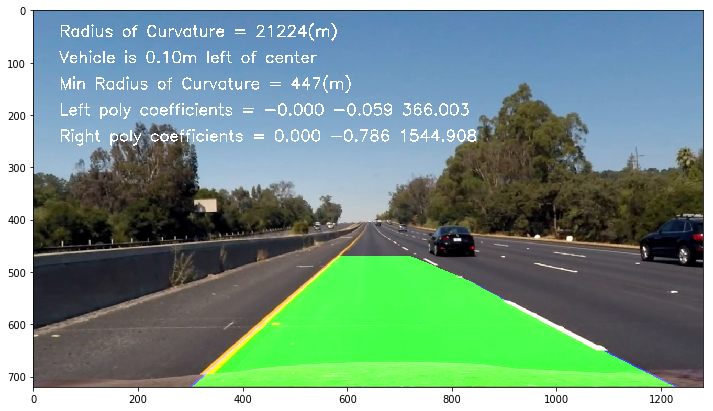

In [57]:
video_dir = "../../../CarND-Advanced-Lane-Lines/project_video.mp4"

output = 'project_output_colour.mp4'
clip1 = VideoFileClip(video_dir)
output_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)